## Sending data to Kafka server

This notebook uses the [Python client for the Apache Kafka distributed stream processing system](http://kafka-python.readthedocs.io/en/master/index.html) to send messages to a Kafka cluster. 

In this example, the messages are data generated from a linear model with $n$ input variables, i.e., 

$$
y =x^T \beta +w
$$
with $x, \beta \in \mathbb{R}^n$, and $y, w \in \mathbb{R}$. $w$ is Gaussian noise.

Messages are sent every $interval$ seconds. They are list of size (n+2) where:
* First element is the counter 
* Second element is $y$ 
* Third to last elements are $x$ values (size $n$)


In [1]:
from kafka import KafkaProducer
import time
import numpy as np
import pandas as pd

In [2]:
#Takes about one minute to load
data=pd.read_csv("../../data/data.conv.txt.gz",header=None,sep=" ")
data.columns=["Date","Hour","Sensor","Value","Voltage"]
data=data.sort_values(['Date','Hour']).reset_index(drop=True)

data['datetime']=pd.to_datetime(data.Date+' '+data.Hour)
data['relative_datetime']=data['datetime']-data['datetime'][0]
data['seconds']=data['relative_datetime'].dt.total_seconds()

sensorId_type=data.Sensor.str.split("-",expand=True)
sensorId_type.columns=['SensorId','Type']
data['SensorId']=sensorId_type['SensorId'].astype(int)
data['Type']=sensorId_type['Type'].astype(int)

In [3]:
#Drop features not needed for the simulation
data=data.drop(['datetime','relative_datetime','Sensor','Date','Hour','Voltage'],axis=1)

In [4]:
data[:5]

Value  seconds  SensorId  Type
0  17.6364    0.000        41     0
1  16.6956    0.007        44     0
2  45.7037    0.092        41     1
3   2.3000    0.237        44     2
4  47.9942    0.285        44     1

In [ ]:
from sklearn.cluster import KMeans
locs = pd.read_csv("../../data/mote_locs.txt", header=None, sep=" ")
locs.columns = ["SensorId", "X", "Y"]
locs.take(5)

In [5]:
temp=data[(data.SensorId==1) & (data.Type==0)]
temp=temp.reset_index(drop=True)

In [6]:
temp[:5]

Value  seconds  SensorId  Type
0  19.2436   79.124         1     0
1  19.2240  169.155         1     0
2  19.2142  200.931         1     0
3  19.1848  264.276         1     0
4  19.1946  321.270         1     0

In [7]:
temp_train = temp[temp.seconds < 8*86400]
temp_test = temp[(temp.seconds >= 8*86400) & (temp.seconds < 9*86400)]

temp_test[:10]

Value     seconds  SensorId  Type
16592  22.6932  691234.125         1     0
16593  22.6834  691262.504         1     0
16594  22.6834  691302.766         1     0
16595  22.6638  691327.934         1     0
16596  22.6638  691364.159         1     0
16597  22.6540  691384.790         1     0
16598  22.6540  691415.179         1     0
16599  22.6540  691450.694         1     0
16600  22.6736  691476.007         1     0
16601  22.6736  691507.201         1     0

In [9]:
def rollup(temp, interval, day_begin=0):
    # roll up data according to a time interval
    first_temp = day_begin * 86400
    last_temp = temp.iloc[-1].seconds
    time_bins = int((last_temp-first_temp)/interval) + 1
    temp_sync = np.zeros((time_bins, 5)) # Value, bin, SensorID, Type, number of elem in bin
    
    for i in range(len(temp)):
        data = temp.iloc[i]
        bin = int((data.seconds-first_temp)/interval)
        n = temp_sync[bin][-1] + 1
        new_value = (temp_sync[bin][0] * (n-1) + data.Value)/n # running avg
        temp_sync[bin][0] = new_value
        temp_sync[bin][1] = bin
        temp_sync[bin][2] = data.SensorId
        temp_sync[bin][3] = data.Type
        temp_sync[bin][4] = n
    return temp_sync


def delta_max(temp):
    # evaluate the maximum time interval between two data
    maxT = 0
    for i in range(1,len(temp)):
        time_now = temp.iloc[i].seconds
        time_before = temp.iloc[i-1].seconds
        delta = time_now - time_before
        if delta > maxT:
            maxT = delta
    return maxT


def interpolate(temp_sync, K):
    # interpolate missing data in rolled up data using the data of K neighbours
    # rolled up data referes to the output of rollup function
    # K is K/2 past data and K/2 futur data
    for bin in range(len(temp_sync)):
        # if no value provided
        left_range = max(0, bin-K/2)
        right_range = min(len(temp_sync), bin+K/2)
        if temp_sync[bin][-1] == 0:
            bins = []
            vals = []
            for n in range(int(left_range), int(right_range)):
                if temp_sync[n][-1] != 0:
                    bins.append(n)
                    vals.append(temp_sync[n][0])
            val_interp = np.interp(bin, bins, vals)
            temp_sync[bin][0] = val_interp
            temp_sync[bin][1] = bin
            temp_sync[bin][2] = 1
            temp_sync[bin][3] = 0
            temp_sync[bin][4] = 1
    return temp_sync

In [10]:
delta_max_train = delta_max(temp_train)
delta_max_test = delta_max(temp_test)
print(delta_max_train)
print(delta_max_test)

339.348
210.811


In [28]:
# Create a cleaned temperature vector:
# we want one data every interval, this is not always the case

interval = 30 # seconds
temp_train_sync = rollup(temp_train, interval)
temp_test_sync = rollup(temp_test, interval, day_begin=8)

print('Number of intervals of length %d in train set: %d' %(interval, len(temp_train_sync)))
print('Number of intervals of length %d in test set: %d' %(interval, len(temp_test_sync)))

Number of intervals of length 30 in train set: 23040
Number of intervals of length 30 in test set: 2879


In [29]:
temp_test_sync[:10]

array([[  0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 22.6932,   1.    ,   1.    ,   0.    ,   1.    ],
       [ 22.6834,   2.    ,   1.    ,   0.    ,   1.    ],
       [ 22.6834,   3.    ,   1.    ,   0.    ,   1.    ],
       [ 22.6638,   4.    ,   1.    ,   0.    ,   1.    ],
       [ 22.6638,   5.    ,   1.    ,   0.    ,   1.    ],
       [ 22.654 ,   6.    ,   1.    ,   0.    ,   1.    ],
       [ 22.654 ,   7.    ,   1.    ,   0.    ,   1.    ],
       [ 22.654 ,   8.    ,   1.    ,   0.    ,   1.    ],
       [ 22.6736,   9.    ,   1.    ,   0.    ,   1.    ]])

In [30]:
K = 20 # interpolation memory, choose according to interval (and eventually maxT)
temp_train_sync = interpolate(temp_train_sync, K)
temp_test_sync = interpolate(temp_test_sync, K)
temp_train_sync[:10]

array([[ 19.2436    ,   0.        ,   1.        ,   0.        ,   1.        ],
       [ 19.2436    ,   1.        ,   1.        ,   0.        ,   1.        ],
       [ 19.2436    ,   2.        ,   1.        ,   0.        ,   1.        ],
       [ 19.23706667,   3.        ,   1.        ,   0.        ,   1.        ],
       [ 19.23053333,   4.        ,   1.        ,   0.        ,   1.        ],
       [ 19.224     ,   5.        ,   1.        ,   0.        ,   1.        ],
       [ 19.2142    ,   6.        ,   1.        ,   0.        ,   1.        ],
       [ 19.1995    ,   7.        ,   1.        ,   0.        ,   1.        ],
       [ 19.1848    ,   8.        ,   1.        ,   0.        ,   1.        ],
       [ 19.1897    ,   9.        ,   1.        ,   0.        ,   1.        ]])

In [31]:
producer = KafkaProducer(bootstrap_servers='kafka1:19092,kafka2:29092,kafka3:39092')

In [32]:
# Feeding training data:

n = 24 # number of parameters
# n parameters -> n last temperatures
for t in range(n, len(temp_train_sync)):
    x = temp_train_sync[t-n:t, 0] # n last temperatures
    y = temp_train_sync[t, 0] # current temperature
    message = np.array2string(np.append([t,y],x),separator=",")
    print(message)
    producer.send('RLSTrain', message.encode())
    time.sleep(1)
    

[ 24.        , 19.126     , 19.2436    , 19.2436    , 19.2436    ,
  19.23706667, 19.23053333, 19.224     , 19.2142    , 19.1995    ,
  19.1848    , 19.1897    , 19.1946    , 19.1848    , 19.175     ,
  19.1848    , 19.1848    , 19.1848    , 19.175     , 19.16846667,
  19.16193333, 19.1554    , 19.1554    , 19.14805   , 19.1407    ,
  19.13335   ]
[ 25.        , 19.1456    , 19.2436    , 19.2436    , 19.23706667,
  19.23053333, 19.224     , 19.2142    , 19.1995    , 19.1848    ,
  19.1897    , 19.1946    , 19.1848    , 19.175     , 19.1848    ,
  19.1848    , 19.1848    , 19.175     , 19.16846667, 19.16193333,
  19.1554    , 19.1554    , 19.14805   , 19.1407    , 19.13335   , 19.126     ]
[ 26.        , 19.126     , 19.2436    , 19.23706667, 19.23053333,
  19.224     , 19.2142    , 19.1995    , 19.1848    , 19.1897    ,
  19.1946    , 19.1848    , 19.175     , 19.1848    , 19.1848    ,
  19.1848    , 19.175     , 19.16846667, 19.16193333, 19.1554    ,
  19.1554    , 19.14805   , 19.140

[ 48.        , 19.0868    , 19.126     , 19.1456    , 19.126     ,
  19.12926667, 19.13253333, 19.1358    , 19.1358    , 19.1162    ,
  19.1064    , 19.1162    , 19.1162    , 19.1064    , 19.1064    ,
  19.1064    , 19.11293333, 19.11946667, 19.126     , 19.1162    ,
  19.1064    , 19.1064    , 19.1064    , 19.1064    , 19.1064    , 19.0868    ]
[ 49.        , 19.077     , 19.1456    , 19.126     , 19.12926667,
  19.13253333, 19.1358    , 19.1358    , 19.1162    , 19.1064    ,
  19.1162    , 19.1162    , 19.1064    , 19.1064    , 19.1064    ,
  19.11293333, 19.11946667, 19.126     , 19.1162    , 19.1064    ,
  19.1064    , 19.1064    , 19.1064    , 19.1064    , 19.0868    , 19.0868    ]
[ 50.        , 19.0819    , 19.126     , 19.12926667, 19.13253333,
  19.1358    , 19.1358    , 19.1162    , 19.1064    , 19.1162    ,
  19.1162    , 19.1064    , 19.1064    , 19.1064    , 19.11293333,
  19.11946667, 19.126     , 19.1162    , 19.1064    , 19.1064    ,
  19.1064    , 19.1064    , 19.1064 

[ 72.        , 19.028     , 19.0868    , 19.077     , 19.0819    ,
  19.0868    , 19.077     , 19.077     , 19.077     , 19.077     ,
  19.0868    , 19.0868    , 19.0868    , 19.0672    , 19.0574    ,
  19.0623    , 19.0672    , 19.06393333, 19.06066667, 19.0574    ,
  19.0574    , 19.0574    , 19.0574    , 19.0525    , 19.0476    , 19.028     ]
[ 73.        , 19.0182    , 19.077     , 19.0819    , 19.0868    ,
  19.077     , 19.077     , 19.077     , 19.077     , 19.0868    ,
  19.0868    , 19.0868    , 19.0672    , 19.0574    , 19.0623    ,
  19.0672    , 19.06393333, 19.06066667, 19.0574    , 19.0574    ,
  19.0574    , 19.0574    , 19.0525    , 19.0476    , 19.028     , 19.028     ]
[ 74.        , 19.02065   , 19.0819    , 19.0868    , 19.077     ,
  19.077     , 19.077     , 19.077     , 19.0868    , 19.0868    ,
  19.0868    , 19.0672    , 19.0574    , 19.0623    , 19.0672    ,
  19.06393333, 19.06066667, 19.0574    , 19.0574    , 19.0574    ,
  19.0574    , 19.0525    , 19.0476 

[ 98.        , 18.94742222, 19.02065   , 19.0231    , 19.02555   ,
  19.028     , 19.028     , 19.028     , 19.028     , 19.028     ,
  19.028     , 19.0084    , 19.0084    , 19.0042    , 19.        ,
  18.9958    , 18.9916    , 18.9874    , 18.9832    , 18.979     ,
  18.9692    , 18.9643    , 18.9594    , 18.9545    , 18.9496    ,
  18.94851111]
[ 99.        , 18.94633333, 19.0231    , 19.02555   , 19.028     ,
  19.028     , 19.028     , 19.028     , 19.028     , 19.028     ,
  19.0084    , 19.0084    , 19.0042    , 19.        , 18.9958    ,
  18.9916    , 18.9874    , 18.9832    , 18.979     , 18.9692    ,
  18.9643    , 18.9594    , 18.9545    , 18.9496    , 18.94851111,
  18.94742222]
[ 100.        ,  18.94524444,  19.02555   ,  19.028     ,  19.028     ,
   19.028     ,  19.028     ,  19.028     ,  19.028     ,  19.0084    ,
   19.0084    ,  19.0042    ,  19.        ,  18.9958    ,  18.9916    ,
   18.9874    ,  18.9832    ,  18.979     ,  18.9692    ,  18.9643    ,
   18.9594  

[ 120.        ,  18.8516    ,  18.9496    ,  18.94851111,  18.94742222,
   18.94633333,  18.94524444,  18.94415556,  18.94306667,  18.94197778,
   18.94088889,  18.9398    ,  18.93      ,  18.93      ,  18.93      ,
   18.9104    ,  18.9006    ,  18.8908    ,  18.8908    ,  18.881     ,
   18.8663    ,  18.8516    ,  19.0427    ,  19.2338    ,  19.4249    ,
   18.8516    ]
[ 121.        ,  18.8614    ,  18.94851111,  18.94742222,  18.94633333,
   18.94524444,  18.94415556,  18.94306667,  18.94197778,  18.94088889,
   18.9398    ,  18.93      ,  18.93      ,  18.93      ,  18.9104    ,
   18.9006    ,  18.8908    ,  18.8908    ,  18.881     ,  18.8663    ,
   18.8516    ,  19.0427    ,  19.2338    ,  19.4249    ,  18.8516    ,
   18.8516    ]
[ 122.        ,  18.8712    ,  18.94742222,  18.94633333,  18.94524444,
   18.94415556,  18.94306667,  18.94197778,  18.94088889,  18.9398    ,
   18.93      ,  18.93      ,  18.93      ,  18.9104    ,  18.9006    ,
   18.8908    ,  18.8908    ,  1

[ 147.     ,  18.9594 ,  18.8614 ,  18.8516 ,  18.9643 ,  19.077  ,
   18.8418 ,  18.832  ,  18.8418 ,  18.8271 ,  18.8124 ,  18.9888 ,
   19.175  ,  18.8222 ,  18.8173 ,  18.8124 ,  18.9692 ,  19.1652 ,
   19.1652 ,  18.9741 ,  19.1456 ,  19.05985,  18.9741 ,  18.8124 ,
   19.1358 ,  18.8026 ]
[ 148.     ,  19.1162 ,  18.8516 ,  18.9643 ,  19.077  ,  18.8418 ,
   18.832  ,  18.8418 ,  18.8271 ,  18.8124 ,  18.9888 ,  19.175  ,
   18.8222 ,  18.8173 ,  18.8124 ,  18.9692 ,  19.1652 ,  19.1652 ,
   18.9741 ,  19.1456 ,  19.05985,  18.9741 ,  18.8124 ,  19.1358 ,
   18.8026 ,  18.9594 ]
[ 149.     ,  19.1162 ,  18.9643 ,  19.077  ,  18.8418 ,  18.832  ,
   18.8418 ,  18.8271 ,  18.8124 ,  18.9888 ,  19.175  ,  18.8222 ,
   18.8173 ,  18.8124 ,  18.9692 ,  19.1652 ,  19.1652 ,  18.9741 ,
   19.1456 ,  19.05985,  18.9741 ,  18.8124 ,  19.1358 ,  18.8026 ,
   18.9594 ,  19.1162 ]
[ 150.     ,  19.1064 ,  19.077  ,  18.8418 ,  18.832  ,  18.8418 ,
   18.8271 ,  18.8124 ,  18.9888 ,  19.175  

[ 175.     ,  18.6752 ,  18.7928 ,  18.9447 ,  18.9349 ,  18.7732 ,
   18.9251 ,  19.0868 ,  18.7634 ,  18.7438 ,  18.7438 ,  18.9006 ,
   18.9055 ,  18.9006 ,  18.90305,  18.9055 ,  18.96185,  19.0182 ,
   19.0182 ,  19.0084 ,  18.8614 ,  18.7144 ,  18.783  ,  18.8516 ,
   19.0084 ,  18.685  ]
[ 176.     ,  18.8369 ,  18.9447 ,  18.9349 ,  18.7732 ,  18.9251 ,
   19.0868 ,  18.7634 ,  18.7438 ,  18.7438 ,  18.9006 ,  18.9055 ,
   18.9006 ,  18.90305,  18.9055 ,  18.96185,  19.0182 ,  19.0182 ,
   19.0084 ,  18.8614 ,  18.7144 ,  18.783  ,  18.8516 ,  19.0084 ,
   18.685  ,  18.6752 ]
[ 177.     ,  18.9986 ,  18.9349 ,  18.7732 ,  18.9251 ,  19.0868 ,
   18.7634 ,  18.7438 ,  18.7438 ,  18.9006 ,  18.9055 ,  18.9006 ,
   18.90305,  18.9055 ,  18.96185,  19.0182 ,  19.0182 ,  19.0084 ,
   18.8614 ,  18.7144 ,  18.783  ,  18.8516 ,  19.0084 ,  18.685  ,
   18.6752 ,  18.8369 ]
[ 178.     ,  18.6752 ,  18.7732 ,  18.9251 ,  19.0868 ,  18.7634 ,
   18.7438 ,  18.7438 ,  18.9006 ,  18.9055 

[ 205.    ,  18.9692,  18.9888,  18.832 ,  18.6752,  18.8222,  18.832 ,
   18.685 ,  18.979 ,  18.8957,  18.8124,  18.9888,  18.636 ,  18.979 ,
   18.8124,  18.9692,  18.8075,  18.6458,  18.636 ,  18.636 ,  18.7977,
   18.6262,  18.636 ,  18.6213,  18.6066,  18.9594]
[ 206.    ,  18.9055,  18.832 ,  18.6752,  18.8222,  18.832 ,  18.685 ,
   18.979 ,  18.8957,  18.8124,  18.9888,  18.636 ,  18.979 ,  18.8124,
   18.9692,  18.8075,  18.6458,  18.636 ,  18.636 ,  18.7977,  18.6262,
   18.636 ,  18.6213,  18.6066,  18.9594,  18.9692]
[ 207.    ,  18.8418,  18.6752,  18.8222,  18.832 ,  18.685 ,  18.979 ,
   18.8957,  18.8124,  18.9888,  18.636 ,  18.979 ,  18.8124,  18.9692,
   18.8075,  18.6458,  18.636 ,  18.636 ,  18.7977,  18.6262,  18.636 ,
   18.6213,  18.6066,  18.9594,  18.9692,  18.9055]
[ 208.    ,  18.7781,  18.8222,  18.832 ,  18.685 ,  18.979 ,  18.8957,
   18.8124,  18.9888,  18.636 ,  18.979 ,  18.8124,  18.9692,  18.8075,
   18.6458,  18.636 ,  18.636 ,  18.7977,  18.6262, 

[ 232.        ,  18.9104    ,  18.7781    ,  18.70215   ,  18.6262    ,
   18.93      ,  18.9251    ,  18.9202    ,  18.587     ,  18.5821    ,
   18.5772    ,  18.9104    ,  18.5772    ,  18.7438    ,  18.9006    ,
   18.9104    ,  18.7389    ,  18.587     ,  18.734     ,  18.5772    ,
   18.5772    ,  18.62783333,  18.67846667,  18.7291    ,  18.5576    ,
   18.734     ]
[ 233.        ,  18.5478    ,  18.70215   ,  18.6262    ,  18.93      ,
   18.9251    ,  18.9202    ,  18.587     ,  18.5821    ,  18.5772    ,
   18.9104    ,  18.5772    ,  18.7438    ,  18.9006    ,  18.9104    ,
   18.7389    ,  18.587     ,  18.734     ,  18.5772    ,  18.5772    ,
   18.62783333,  18.67846667,  18.7291    ,  18.5576    ,  18.734     ,
   18.9104    ]
[ 234.        ,  18.8908    ,  18.6262    ,  18.93      ,  18.9251    ,
   18.9202    ,  18.587     ,  18.5821    ,  18.5772    ,  18.9104    ,
   18.5772    ,  18.7438    ,  18.9006    ,  18.9104    ,  18.7389    ,
   18.587     ,  18.734     ,  1

[ 255.     ,  18.5184 ,  18.734  ,  18.9104 ,  18.5478 ,  18.8908 ,
   18.538  ,  18.5282 ,  18.52624,  18.52428,  18.52232,  18.52036,
   18.5184 ,  18.5086 ,  18.6948 ,  18.6017 ,  18.5086 ,  18.5086 ,
   18.5086 ,  18.5086 ,  18.4988 ,  18.4988 ,  18.4988 ,  18.5184 ,
   18.4988 ,  18.4988 ]
[ 256.     ,  18.4988 ,  18.9104 ,  18.5478 ,  18.8908 ,  18.538  ,
   18.5282 ,  18.52624,  18.52428,  18.52232,  18.52036,  18.5184 ,
   18.5086 ,  18.6948 ,  18.6017 ,  18.5086 ,  18.5086 ,  18.5086 ,
   18.5086 ,  18.4988 ,  18.4988 ,  18.4988 ,  18.5184 ,  18.4988 ,
   18.4988 ,  18.5184 ]
[ 257.     ,  18.4988 ,  18.5478 ,  18.8908 ,  18.538  ,  18.5282 ,
   18.52624,  18.52428,  18.52232,  18.52036,  18.5184 ,  18.5086 ,
   18.6948 ,  18.6017 ,  18.5086 ,  18.5086 ,  18.5086 ,  18.5086 ,
   18.4988 ,  18.4988 ,  18.4988 ,  18.5184 ,  18.4988 ,  18.4988 ,
   18.5184 ,  18.4988 ]
[ 258.     ,  18.489  ,  18.8908 ,  18.538  ,  18.5282 ,  18.52624,
   18.52428,  18.52232,  18.52036,  18.5184 

[ 284.     ,  18.44   ,  18.6556 ,  18.4792 ,  18.6507 ,  18.4792 ,
   18.4792 ,  18.6409 ,  18.6409 ,  18.4596 ,  18.538  ,  18.6164 ,
   18.5233 ,  18.4302 ,  18.52085,  18.6115 ,  18.44   ,  18.4498 ,
   18.5282 ,  18.6066 ,  18.7732 ,  18.6115 ,  18.4498 ,  18.7732 ,
   18.5968 ,  18.6115 ]
[ 285.     ,  18.44   ,  18.4792 ,  18.6507 ,  18.4792 ,  18.4792 ,
   18.6409 ,  18.6409 ,  18.4596 ,  18.538  ,  18.6164 ,  18.5233 ,
   18.4302 ,  18.52085,  18.6115 ,  18.44   ,  18.4498 ,  18.5282 ,
   18.6066 ,  18.7732 ,  18.6115 ,  18.4498 ,  18.7732 ,  18.5968 ,
   18.6115 ,  18.44   ]
[ 286.     ,  18.5968 ,  18.6507 ,  18.4792 ,  18.4792 ,  18.6409 ,
   18.6409 ,  18.4596 ,  18.538  ,  18.6164 ,  18.5233 ,  18.4302 ,
   18.52085,  18.6115 ,  18.44   ,  18.4498 ,  18.5282 ,  18.6066 ,
   18.7732 ,  18.6115 ,  18.4498 ,  18.7732 ,  18.5968 ,  18.6115 ,
   18.44   ,  18.44   ]
[ 287.     ,  18.7536 ,  18.4792 ,  18.4792 ,  18.6409 ,  18.6409 ,
   18.4596 ,  18.538  ,  18.6164 ,  18.5233 

[ 312.     ,  18.5135 ,  18.4302 ,  18.5821 ,  18.4302 ,  18.5772 ,
   18.5723 ,  18.49635,  18.4204 ,  18.4106 ,  18.4106 ,  18.4106 ,
   18.4106 ,  18.4008 ,  18.5576 ,  18.3812 ,  18.5478 ,  18.538  ,
   18.3616 ,  18.342  ,  18.342  ,  18.342  ,  18.3224 ,  18.6948 ,
   18.342  ,  18.5135 ]
[ 313.     ,  18.42285,  18.5821 ,  18.4302 ,  18.5772 ,  18.5723 ,
   18.49635,  18.4204 ,  18.4106 ,  18.4106 ,  18.4106 ,  18.4106 ,
   18.4008 ,  18.5576 ,  18.3812 ,  18.5478 ,  18.538  ,  18.3616 ,
   18.342  ,  18.342  ,  18.342  ,  18.3224 ,  18.6948 ,  18.342  ,
   18.5135 ,  18.5135 ]
[ 314.     ,  18.3322 ,  18.4302 ,  18.5772 ,  18.5723 ,  18.49635,
   18.4204 ,  18.4106 ,  18.4106 ,  18.4106 ,  18.4106 ,  18.4008 ,
   18.5576 ,  18.3812 ,  18.5478 ,  18.538  ,  18.3616 ,  18.342  ,
   18.342  ,  18.342  ,  18.3224 ,  18.6948 ,  18.342  ,  18.5135 ,
   18.5135 ,  18.42285]
[ 315.     ,  18.4841 ,  18.5772 ,  18.5723 ,  18.49635,  18.4204 ,
   18.4106 ,  18.4106 ,  18.4106 ,  18.4106 

[ 340.    ,  18.4253,  18.3126,  18.3028,  18.3322,  18.3224,  18.4939,
   18.4792,  18.4792,  18.3028,  18.293 ,  18.4694,  18.293 ,  18.636 ,
   18.2832,  18.293 ,  18.2832,  18.2734,  18.4547,  18.636 ,  18.2636,
   18.44  ,  18.3812,  18.3224,  18.2636,  18.2538]
[ 341.    ,  18.391 ,  18.3028,  18.3322,  18.3224,  18.4939,  18.4792,
   18.4792,  18.3028,  18.293 ,  18.4694,  18.293 ,  18.636 ,  18.2832,
   18.293 ,  18.2832,  18.2734,  18.4547,  18.636 ,  18.2636,  18.44  ,
   18.3812,  18.3224,  18.2636,  18.2538,  18.4253]
[ 342.    ,  18.3567,  18.3322,  18.3224,  18.4939,  18.4792,  18.4792,
   18.3028,  18.293 ,  18.4694,  18.293 ,  18.636 ,  18.2832,  18.293 ,
   18.2832,  18.2734,  18.4547,  18.636 ,  18.2636,  18.44  ,  18.3812,
   18.3224,  18.2636,  18.2538,  18.4253,  18.391 ]
[ 343.    ,  18.3224,  18.3224,  18.4939,  18.4792,  18.4792,  18.3028,
   18.293 ,  18.4694,  18.293 ,  18.636 ,  18.2832,  18.293 ,  18.2832,
   18.2734,  18.4547,  18.636 ,  18.2636,  18.44  , 

[ 369.        ,  18.21786667,  18.2538    ,  18.2489    ,  18.244     ,
   18.2391    ,  18.2342    ,  18.2244    ,  18.2342    ,  18.23175   ,
   18.2293    ,  18.22685   ,  18.2244    ,  18.2244    ,  18.2244    ,
   18.2244    ,  18.2244    ,  18.2244    ,  18.244     ,  18.244     ,
   18.244     ,  18.3959    ,  18.244     ,  18.2342    ,  18.2244    ,
   18.22113333]
[ 370.        ,  18.2146    ,  18.2489    ,  18.244     ,  18.2391    ,
   18.2342    ,  18.2244    ,  18.2342    ,  18.23175   ,  18.2293    ,
   18.22685   ,  18.2244    ,  18.2244    ,  18.2244    ,  18.2244    ,
   18.2244    ,  18.2244    ,  18.244     ,  18.244     ,  18.244     ,
   18.3959    ,  18.244     ,  18.2342    ,  18.2244    ,  18.22113333,
   18.21786667]
[ 371.        ,  18.3616    ,  18.244     ,  18.2391    ,  18.2342    ,
   18.2244    ,  18.2342    ,  18.23175   ,  18.2293    ,  18.22685   ,
   18.2244    ,  18.2244    ,  18.2244    ,  18.2244    ,  18.2244    ,
   18.2244    ,  18.244     ,  1

[ 391.        ,  18.1558    ,  18.2244    ,  18.22113333,  18.21786667,
   18.2146    ,  18.3616    ,  18.3028    ,  18.244     ,  18.1852    ,
   18.5086    ,  18.4988    ,  18.3371    ,  18.1656    ,  18.25135   ,
   18.3371    ,  18.5086    ,  18.1656    ,  18.1558    ,  18.1558    ,
   18.1607    ,  18.1656    ,  18.1656    ,  18.1558    ,  18.3322    ,
   18.5086    ]
[ 392.        ,  18.1558    ,  18.22113333,  18.21786667,  18.2146    ,
   18.3616    ,  18.3028    ,  18.244     ,  18.1852    ,  18.5086    ,
   18.4988    ,  18.3371    ,  18.1656    ,  18.25135   ,  18.3371    ,
   18.5086    ,  18.1656    ,  18.1558    ,  18.1558    ,  18.1607    ,
   18.1656    ,  18.1656    ,  18.1558    ,  18.3322    ,  18.5086    ,
   18.1558    ]
[ 393.        ,  18.15253333,  18.21786667,  18.2146    ,  18.3616    ,
   18.3028    ,  18.244     ,  18.1852    ,  18.5086    ,  18.4988    ,
   18.3371    ,  18.1656    ,  18.25135   ,  18.3371    ,  18.5086    ,
   18.1656    ,  18.1558    ,  1

[ 413.        ,  18.146     ,  18.3322    ,  18.5086    ,  18.1558    ,
   18.1558    ,  18.15253333,  18.14926667,  18.146     ,  18.146     ,
   18.22685   ,  18.3077    ,  18.1754    ,  18.2489    ,  18.3224    ,
   18.2391    ,  18.1558    ,  18.191325  ,  18.22685   ,  18.262375  ,
   18.2979    ,  18.4204    ,  18.1558    ,  18.4204    ,  18.146     ,
   18.2832    ]
[ 414.        ,  18.146     ,  18.5086    ,  18.1558    ,  18.1558    ,
   18.15253333,  18.14926667,  18.146     ,  18.146     ,  18.22685   ,
   18.3077    ,  18.1754    ,  18.2489    ,  18.3224    ,  18.2391    ,
   18.1558    ,  18.191325  ,  18.22685   ,  18.262375  ,  18.2979    ,
   18.4204    ,  18.1558    ,  18.4204    ,  18.146     ,  18.2832    ,
   18.146     ]
[ 415.        ,  18.1411    ,  18.1558    ,  18.1558    ,  18.15253333,
   18.14926667,  18.146     ,  18.146     ,  18.22685   ,  18.3077    ,
   18.1754    ,  18.2489    ,  18.3224    ,  18.2391    ,  18.1558    ,
   18.191325  ,  18.22685   ,  1

[ 439.     ,  18.27144,  18.1411 ,  18.1362 ,  18.2734 ,  18.146  ,
   18.2685 ,  18.2636 ,  18.1264 ,  18.1362 ,  18.1264 ,  18.2685 ,
   18.19255,  18.1166 ,  18.2636 ,  18.1068 ,  18.2538 ,  18.1068 ,
   18.097  ,  18.2489 ,  18.2489 ,  18.1068 ,  18.4008 ,  18.1068 ,
   18.16168,  18.21656]
[ 440.     ,  18.32632,  18.1362 ,  18.2734 ,  18.146  ,  18.2685 ,
   18.2636 ,  18.1264 ,  18.1362 ,  18.1264 ,  18.2685 ,  18.19255,
   18.1166 ,  18.2636 ,  18.1068 ,  18.2538 ,  18.1068 ,  18.097  ,
   18.2489 ,  18.2489 ,  18.1068 ,  18.4008 ,  18.1068 ,  18.16168,
   18.21656,  18.27144]
[ 441.     ,  18.3812 ,  18.2734 ,  18.146  ,  18.2685 ,  18.2636 ,
   18.1264 ,  18.1362 ,  18.1264 ,  18.2685 ,  18.19255,  18.1166 ,
   18.2636 ,  18.1068 ,  18.2538 ,  18.1068 ,  18.097  ,  18.2489 ,
   18.2489 ,  18.1068 ,  18.4008 ,  18.1068 ,  18.16168,  18.21656,
   18.27144,  18.32632]
[ 442.     ,  18.2293 ,  18.146  ,  18.2685 ,  18.2636 ,  18.1264 ,
   18.1362 ,  18.1264 ,  18.2685 ,  18.19255

[ 466.      ,  18.1656  ,  18.2293  ,  18.3812  ,  18.2244  ,  18.0774  ,
   18.0823  ,  18.0872  ,  18.0676  ,  18.0676  ,  18.0676  ,  18.1999  ,
   18.1999  ,  18.232975,  18.26605 ,  18.299125,  18.3322  ,  18.1656  ,
   18.1705  ,  18.1656  ,  18.1607  ,  18.0088  ,  18.1607  ,  18.1607  ,
   18.1607  ,  18.1607  ]
[ 467.      ,  18.1509  ,  18.3812  ,  18.2244  ,  18.0774  ,  18.0823  ,
   18.0872  ,  18.0676  ,  18.0676  ,  18.0676  ,  18.1999  ,  18.1999  ,
   18.232975,  18.26605 ,  18.299125,  18.3322  ,  18.1656  ,  18.1705  ,
   18.1656  ,  18.1607  ,  18.0088  ,  18.1607  ,  18.1607  ,  18.1607  ,
   18.1607  ,  18.1656  ]
[ 468.      ,  18.15335 ,  18.2244  ,  18.0774  ,  18.0823  ,  18.0872  ,
   18.0676  ,  18.0676  ,  18.0676  ,  18.1999  ,  18.1999  ,  18.232975,
   18.26605 ,  18.299125,  18.3322  ,  18.1656  ,  18.1705  ,  18.1656  ,
   18.1607  ,  18.0088  ,  18.1607  ,  18.1607  ,  18.1607  ,  18.1607  ,
   18.1656  ,  18.1509  ]
[ 469.      ,  18.1558  ,  18.0774

[ 493.    ,  17.9892,  18.1558,  18.0284,  18.0186,  18.0284,  18.293 ,
   18.1558,  18.0284,  18.0872,  18.146 ,  18.0872,  18.0284,  18.146 ,
   18.0186,  18.1411,  18.0088,  18.0088,  18.1362,  18.2636,  18.0088,
   18.0088,  18.0088,  18.0088,  18.244 ,  17.9892]
[ 494.    ,  17.9892,  18.0284,  18.0186,  18.0284,  18.293 ,  18.1558,
   18.0284,  18.0872,  18.146 ,  18.0872,  18.0284,  18.146 ,  18.0186,
   18.1411,  18.0088,  18.0088,  18.1362,  18.2636,  18.0088,  18.0088,
   18.0088,  18.0088,  18.244 ,  17.9892,  17.9892]
[ 495.    ,  17.9794,  18.0186,  18.0284,  18.293 ,  18.1558,  18.0284,
   18.0872,  18.146 ,  18.0872,  18.0284,  18.146 ,  18.0186,  18.1411,
   18.0088,  18.0088,  18.1362,  18.2636,  18.0088,  18.0088,  18.0088,
   18.0088,  18.244 ,  17.9892,  17.9892,  17.9892]
[ 496.    ,  18.1068,  18.0284,  18.293 ,  18.1558,  18.0284,  18.0872,
   18.146 ,  18.0872,  18.0284,  18.146 ,  18.0186,  18.1411,  18.0088,
   18.0088,  18.1362,  18.2636,  18.0088,  18.0088, 

[ 520.        ,  17.9598    ,  18.1068    ,  18.097     ,  18.0872    ,
   18.0333    ,  17.9794    ,  18.0872    ,  18.2048    ,  18.0774    ,
   17.95      ,  17.9598    ,  17.9647    ,  17.9696    ,  18.0774    ,
   18.06596667,  18.05453333,  18.0431    ,  18.048     ,  18.0235    ,
   17.999     ,  17.9745    ,  17.95      ,  18.0431    ,  17.9304    ,
   18.1558    ]
[ 521.        ,  17.9843    ,  18.097     ,  18.0872    ,  18.0333    ,
   17.9794    ,  18.0872    ,  18.2048    ,  18.0774    ,  17.95      ,
   17.9598    ,  17.9647    ,  17.9696    ,  18.0774    ,  18.06596667,
   18.05453333,  18.0431    ,  18.048     ,  18.0235    ,  17.999     ,
   17.9745    ,  17.95      ,  18.0431    ,  17.9304    ,  18.1558    ,
   17.9598    ]
[ 522.        ,  18.0088    ,  18.0872    ,  18.0333    ,  17.9794    ,
   18.0872    ,  18.2048    ,  18.0774    ,  17.95      ,  17.9598    ,
   17.9647    ,  17.9696    ,  18.0774    ,  18.06596667,  18.05453333,
   18.0431    ,  18.048     ,  1

[ 545.    ,  17.8716,  17.9843,  18.0088,  18.0333,  17.95  ,  17.9451,
   17.9402,  18.1264,  17.9304,  18.0186,  18.1068,  17.9304,  18.0137,
   18.0039,  18.0039,  17.999 ,  17.901 ,  17.8912,  17.8814,  17.9794,
   18.0774,  17.9794,  17.8814,  18.0676,  17.8716]
[ 546.    ,  17.8716,  18.0088,  18.0333,  17.95  ,  17.9451,  17.9402,
   18.1264,  17.9304,  18.0186,  18.1068,  17.9304,  18.0137,  18.0039,
   18.0039,  17.999 ,  17.901 ,  17.8912,  17.8814,  17.9794,  18.0774,
   17.9794,  17.8814,  18.0676,  17.8716,  17.8716]
[ 547.    ,  17.8765,  18.0333,  17.95  ,  17.9451,  17.9402,  18.1264,
   17.9304,  18.0186,  18.1068,  17.9304,  18.0137,  18.0039,  18.0039,
   17.999 ,  17.901 ,  17.8912,  17.8814,  17.9794,  18.0774,  17.9794,
   17.8814,  18.0676,  17.8716,  17.8716,  17.8716]
[ 548.    ,  17.8814,  17.95  ,  17.9451,  17.9402,  18.1264,  17.9304,
   18.0186,  18.1068,  17.9304,  18.0137,  18.0039,  18.0039,  17.999 ,
   17.901 ,  17.8912,  17.8814,  17.9794,  18.0774, 

[ 570.        ,  17.9402    ,  17.8716    ,  17.8765    ,  17.8814    ,
   17.8716    ,  17.9745    ,  18.0676    ,  17.8814    ,  18.0676    ,
   18.00226667,  17.93693333,  17.8716    ,  17.8716    ,  17.8716    ,
   17.8716    ,  17.95      ,  18.0382    ,  17.8716    ,  17.8814    ,
   17.8716    ,  17.852     ,  17.8716    ,  17.95      ,  18.0284    ,
   17.9843    ]
[ 571.        ,  17.9402    ,  17.8765    ,  17.8814    ,  17.8716    ,
   17.9745    ,  18.0676    ,  17.8814    ,  18.0676    ,  18.00226667,
   17.93693333,  17.8716    ,  17.8716    ,  17.8716    ,  17.8716    ,
   17.95      ,  18.0382    ,  17.8716    ,  17.8814    ,  17.8716    ,
   17.852     ,  17.8716    ,  17.95      ,  18.0284    ,  17.9843    ,
   17.9402    ]
[ 572.        ,  17.9304    ,  17.8814    ,  17.8716    ,  17.9745    ,
   18.0676    ,  17.8814    ,  18.0676    ,  18.00226667,  17.93693333,
   17.8716    ,  17.8716    ,  17.8716    ,  17.8716    ,  17.95      ,
   18.0382    ,  17.8716    ,  1

[ 597.     ,  17.8324 ,  18.0088 ,  17.852  ,  17.852  ,  17.9794 ,
   17.901  ,  17.8324 ,  17.852  ,  17.8716 ,  17.8912 ,  17.8912 ,
   17.8128 ,  17.8128 ,  17.8177 ,  17.8226 ,  17.8177 ,  17.8128 ,
   17.8814 ,  17.9304 ,  17.90835,  17.8863 ,  17.91815,  17.95   ,
   17.8324 ,  17.8324 ]
[ 598.     ,  17.8128 ,  17.852  ,  17.852  ,  17.9794 ,  17.901  ,
   17.8324 ,  17.852  ,  17.8716 ,  17.8912 ,  17.8912 ,  17.8128 ,
   17.8128 ,  17.8177 ,  17.8226 ,  17.8177 ,  17.8128 ,  17.8814 ,
   17.9304 ,  17.90835,  17.8863 ,  17.91815,  17.95   ,  17.8324 ,
   17.8324 ,  17.8324 ]
[ 599.     ,  17.9402 ,  17.852  ,  17.9794 ,  17.901  ,  17.8324 ,
   17.852  ,  17.8716 ,  17.8912 ,  17.8912 ,  17.8128 ,  17.8128 ,
   17.8177 ,  17.8226 ,  17.8177 ,  17.8128 ,  17.8814 ,  17.9304 ,
   17.90835,  17.8863 ,  17.91815,  17.95   ,  17.8324 ,  17.8324 ,
   17.8324 ,  17.8128 ]
[ 600.     ,  17.8716 ,  17.9794 ,  17.901  ,  17.8324 ,  17.852  ,
   17.8716 ,  17.8912 ,  17.8912 ,  17.8128 

[ 623.        ,  17.8373    ,  17.9402    ,  17.8716    ,  17.803     ,
   17.8128    ,  17.8128    ,  17.803     ,  17.803     ,  17.9108    ,
   17.803     ,  17.7932    ,  17.8128    ,  17.8324    ,  17.7736    ,
   17.8275    ,  17.7736    ,  17.8716    ,  17.86016667,  17.84873333,
   17.8373    ,  17.7736    ,  17.80055   ,  17.8275    ,  17.8226    ,
   17.8275    ]
[ 624.        ,  17.8275    ,  17.8716    ,  17.803     ,  17.8128    ,
   17.8128    ,  17.803     ,  17.803     ,  17.9108    ,  17.803     ,
   17.7932    ,  17.8128    ,  17.8324    ,  17.7736    ,  17.8275    ,
   17.7736    ,  17.8716    ,  17.86016667,  17.84873333,  17.8373    ,
   17.7736    ,  17.80055   ,  17.8275    ,  17.8226    ,  17.8275    ,
   17.8373    ]
[ 625.        ,  17.7736    ,  17.803     ,  17.8128    ,  17.8128    ,
   17.803     ,  17.803     ,  17.9108    ,  17.803     ,  17.7932    ,
   17.8128    ,  17.8324    ,  17.7736    ,  17.8275    ,  17.7736    ,
   17.8716    ,  17.86016667,  1

[ 647.     ,  17.7785 ,  17.8373 ,  17.8275 ,  17.7736 ,  17.7638 ,
   17.7638 ,  17.8177 ,  17.8716 ,  17.7736 ,  17.8716 ,  17.852  ,
   17.852  ,  17.852  ,  17.7981 ,  17.7344 ,  17.7393 ,  17.7442 ,
   17.754  ,  17.7491 ,  17.7442 ,  17.7442 ,  17.7442 ,  17.7344 ,
   17.7344 ,  17.75645]
[ 648.     ,  17.7834 ,  17.8275 ,  17.7736 ,  17.7638 ,  17.7638 ,
   17.8177 ,  17.8716 ,  17.7736 ,  17.8716 ,  17.852  ,  17.852  ,
   17.852  ,  17.7981 ,  17.7344 ,  17.7393 ,  17.7442 ,  17.754  ,
   17.7491 ,  17.7442 ,  17.7442 ,  17.7442 ,  17.7344 ,  17.7344 ,
   17.75645,  17.7785 ]
[ 649.     ,  17.7148 ,  17.7736 ,  17.7638 ,  17.7638 ,  17.8177 ,
   17.8716 ,  17.7736 ,  17.8716 ,  17.852  ,  17.852  ,  17.852  ,
   17.7981 ,  17.7344 ,  17.7393 ,  17.7442 ,  17.754  ,  17.7491 ,
   17.7442 ,  17.7442 ,  17.7442 ,  17.7344 ,  17.7344 ,  17.75645,
   17.7785 ,  17.7834 ]
[ 650.     ,  17.7344 ,  17.7638 ,  17.7638 ,  17.8177 ,  17.8716 ,
   17.7736 ,  17.8716 ,  17.852  ,  17.852  

[ 675.        ,  17.73276667,  17.754     ,  17.75645   ,  17.7589    ,
   17.6952    ,  17.705     ,  17.7001    ,  17.6952    ,  17.8128    ,
   17.7932    ,  17.6854    ,  17.6903    ,  17.6952    ,  17.7442    ,
   17.7932    ,  17.7932    ,  17.7491    ,  17.7491    ,  17.7491    ,
   17.6756    ,  17.691525  ,  17.70745   ,  17.723375  ,  17.7393    ,
   17.73603333]
[ 676.        ,  17.7295    ,  17.75645   ,  17.7589    ,  17.6952    ,
   17.705     ,  17.7001    ,  17.6952    ,  17.8128    ,  17.7932    ,
   17.6854    ,  17.6903    ,  17.6952    ,  17.7442    ,  17.7932    ,
   17.7932    ,  17.7491    ,  17.7491    ,  17.7491    ,  17.6756    ,
   17.691525  ,  17.70745   ,  17.723375  ,  17.7393    ,  17.73603333,
   17.73276667]
[ 677.        ,  17.7246    ,  17.7589    ,  17.6952    ,  17.705     ,
   17.7001    ,  17.6952    ,  17.8128    ,  17.7932    ,  17.6854    ,
   17.6903    ,  17.6952    ,  17.7442    ,  17.7932    ,  17.7932    ,
   17.7491    ,  17.7491    ,  1

[ 697.        ,  17.5972    ,  17.7393    ,  17.73603333,  17.73276667,
   17.7295    ,  17.7246    ,  17.7197    ,  17.656     ,  17.7148    ,
   17.705     ,  17.754     ,  17.6952    ,  17.6364    ,  17.6854    ,
   17.6364    ,  17.6168    ,  17.7246    ,  17.7344    ,  17.6168    ,
   17.6168    ,  17.6658    ,  17.6266    ,  17.6364    ,  17.6364    ,
   17.6168    ]
[ 698.        ,  17.607     ,  17.73603333,  17.73276667,  17.7295    ,
   17.7246    ,  17.7197    ,  17.656     ,  17.7148    ,  17.705     ,
   17.754     ,  17.6952    ,  17.6364    ,  17.6854    ,  17.6364    ,
   17.6168    ,  17.7246    ,  17.7344    ,  17.6168    ,  17.6168    ,
   17.6658    ,  17.6266    ,  17.6364    ,  17.6364    ,  17.6168    ,
   17.5972    ]
[ 699.        ,  17.7148    ,  17.73276667,  17.7295    ,  17.7246    ,
   17.7197    ,  17.656     ,  17.7148    ,  17.705     ,  17.754     ,
   17.6952    ,  17.6364    ,  17.6854    ,  17.6364    ,  17.6168    ,
   17.7246    ,  17.7344    ,  1

[ 724.     ,  17.5384 ,  17.5972 ,  17.62905,  17.6609 ,  17.5972 ,
   17.59524,  17.59328,  17.59132,  17.58936,  17.5874 ,  17.7148 ,
   17.6315 ,  17.6952 ,  17.6854 ,  17.5776 ,  17.5678 ,  17.6364 ,
   17.558  ,  17.6952 ,  17.6609 ,  17.6266 ,  17.558  ,  17.558  ,
   17.6266 ,  17.5825 ]
[ 725.     ,  17.5384 ,  17.62905,  17.6609 ,  17.5972 ,  17.59524,
   17.59328,  17.59132,  17.58936,  17.5874 ,  17.7148 ,  17.6315 ,
   17.6952 ,  17.6854 ,  17.5776 ,  17.5678 ,  17.6364 ,  17.558  ,
   17.6952 ,  17.6609 ,  17.6266 ,  17.558  ,  17.558  ,  17.6266 ,
   17.5825 ,  17.5384 ]
[ 726.     ,  17.607  ,  17.6609 ,  17.5972 ,  17.59524,  17.59328,
   17.59132,  17.58936,  17.5874 ,  17.7148 ,  17.6315 ,  17.6952 ,
   17.6854 ,  17.5776 ,  17.5678 ,  17.6364 ,  17.558  ,  17.6952 ,
   17.6609 ,  17.6266 ,  17.558  ,  17.558  ,  17.6266 ,  17.5825 ,
   17.5384 ,  17.5384 ]
[ 727.     ,  17.6119 ,  17.5972 ,  17.59524,  17.59328,  17.59132,
   17.58936,  17.5874 ,  17.7148 ,  17.6315 

[ 753.     ,  17.4992 ,  17.5384 ,  17.6854 ,  17.6707 ,  17.656  ,
   17.6021 ,  17.5384 ,  17.656  ,  17.6021 ,  17.63885,  17.6756 ,
   17.6756 ,  17.6756 ,  17.5923 ,  17.5972 ,  17.5923 ,  17.5874 ,
   17.6217 ,  17.656  ,  17.5188 ,  17.509  ,  17.54085,  17.5727 ,
   17.4894 ,  17.6364 ]
[ 754.     ,  17.5727 ,  17.6854 ,  17.6707 ,  17.656  ,  17.6021 ,
   17.5384 ,  17.656  ,  17.6021 ,  17.63885,  17.6756 ,  17.6756 ,
   17.6756 ,  17.5923 ,  17.5972 ,  17.5923 ,  17.5874 ,  17.6217 ,
   17.656  ,  17.5188 ,  17.509  ,  17.54085,  17.5727 ,  17.4894 ,
   17.6364 ,  17.4992 ]
[ 755.     ,  17.509  ,  17.6707 ,  17.656  ,  17.6021 ,  17.5384 ,
   17.656  ,  17.6021 ,  17.63885,  17.6756 ,  17.6756 ,  17.6756 ,
   17.5923 ,  17.5972 ,  17.5923 ,  17.5874 ,  17.6217 ,  17.656  ,
   17.5188 ,  17.509  ,  17.54085,  17.5727 ,  17.4894 ,  17.6364 ,
   17.4992 ,  17.5727 ]
[ 756.     ,  17.5041 ,  17.656  ,  17.6021 ,  17.5384 ,  17.656  ,
   17.6021 ,  17.63885,  17.6756 ,  17.6756 

[ 781.        ,  17.5776    ,  17.4992    ,  17.4894    ,  17.6364    ,
   17.6021    ,  17.5678    ,  17.5335    ,  17.4992    ,  17.5678    ,
   17.56045   ,  17.5531    ,  17.4992    ,  17.4894    ,  17.5972    ,
   17.607     ,  17.509     ,  17.4992    ,  17.509     ,  17.5776    ,
   17.5678    ,  17.4992    ,  17.5776    ,  17.54166667,  17.50573333,
   17.4698    ]
[ 782.        ,  17.4796    ,  17.4894    ,  17.6364    ,  17.6021    ,
   17.5678    ,  17.5335    ,  17.4992    ,  17.5678    ,  17.56045   ,
   17.5531    ,  17.4992    ,  17.4894    ,  17.5972    ,  17.607     ,
   17.509     ,  17.4992    ,  17.509     ,  17.5776    ,  17.5678    ,
   17.4992    ,  17.5776    ,  17.54166667,  17.50573333,  17.4698    ,
   17.5776    ]
[ 783.        ,  17.4796    ,  17.6364    ,  17.6021    ,  17.5678    ,
   17.5335    ,  17.4992    ,  17.5678    ,  17.56045   ,  17.5531    ,
   17.4992    ,  17.4894    ,  17.5972    ,  17.607     ,  17.509     ,
   17.4992    ,  17.509     ,  1

[ 803.        ,  17.5139    ,  17.50573333,  17.4698    ,  17.5776    ,
   17.4796    ,  17.4796    ,  17.5335    ,  17.4992    ,  17.4992    ,
   17.509     ,  17.5384    ,  17.509     ,  17.4796    ,  17.5678    ,
   17.4992    ,  17.5776    ,  17.5776    ,  17.5776    ,  17.5286    ,
   17.5286    ,  17.5286    ,  17.5237    ,  17.5678    ,  17.558     ,
   17.4698    ]
[ 804.    ,  17.558 ,  17.4698,  17.5776,  17.4796,  17.4796,  17.5335,
   17.4992,  17.4992,  17.509 ,  17.5384,  17.509 ,  17.4796,  17.5678,
   17.4992,  17.5776,  17.5776,  17.5776,  17.5286,  17.5286,  17.5286,
   17.5237,  17.5678,  17.558 ,  17.4698,  17.5139]
[ 805.        ,  17.54493333,  17.5776    ,  17.4796    ,  17.4796    ,
   17.5335    ,  17.4992    ,  17.4992    ,  17.509     ,  17.5384    ,
   17.509     ,  17.4796    ,  17.5678    ,  17.4992    ,  17.5776    ,
   17.5776    ,  17.5776    ,  17.5286    ,  17.5286    ,  17.5286    ,
   17.5237    ,  17.5678    ,  17.558     ,  17.4698    ,  17.5139  

[ 826.        ,  17.5237    ,  17.4698    ,  17.5139    ,  17.558     ,
   17.54493333,  17.53186667,  17.5188    ,  17.51488   ,  17.51096   ,
   17.50704   ,  17.50312   ,  17.4992    ,  17.509     ,  17.5188    ,
   17.5286    ,  17.5188    ,  17.52206667,  17.52533333,  17.5286    ,
   17.52125   ,  17.5139    ,  17.50655   ,  17.4992    ,  17.5188    ,
   17.509     ]
[ 827.        ,  17.5188    ,  17.5139    ,  17.558     ,  17.54493333,
   17.53186667,  17.5188    ,  17.51488   ,  17.51096   ,  17.50704   ,
   17.50312   ,  17.4992    ,  17.509     ,  17.5188    ,  17.5286    ,
   17.5188    ,  17.52206667,  17.52533333,  17.5286    ,  17.52125   ,
   17.5139    ,  17.50655   ,  17.4992    ,  17.5188    ,  17.509     ,
   17.5237    ]
[ 828.        ,  17.5139    ,  17.558     ,  17.54493333,  17.53186667,
   17.5188    ,  17.51488   ,  17.51096   ,  17.50704   ,  17.50312   ,
   17.4992    ,  17.509     ,  17.5188    ,  17.5286    ,  17.5188    ,
   17.52206667,  17.52533333,  1

[ 850.     ,  17.4943 ,  17.5237 ,  17.5188 ,  17.5139 ,  17.509  ,
   17.5041 ,  17.4992 ,  17.4894 ,  17.4796 ,  17.4698 ,  17.47176,
   17.47372,  17.47568,  17.47764,  17.4796 ,  17.4943 ,  17.48695,
   17.4796 ,  17.46   ,  17.4796 ,  17.4894 ,  17.5041 ,  17.4992 ,
   17.4943 ,  17.4796 ]
[ 851.     ,  17.4796 ,  17.5188 ,  17.5139 ,  17.509  ,  17.5041 ,
   17.4992 ,  17.4894 ,  17.4796 ,  17.4698 ,  17.47176,  17.47372,
   17.47568,  17.47764,  17.4796 ,  17.4943 ,  17.48695,  17.4796 ,
   17.46   ,  17.4796 ,  17.4894 ,  17.5041 ,  17.4992 ,  17.4943 ,
   17.4796 ,  17.4943 ]
[ 852.     ,  17.4796 ,  17.5139 ,  17.509  ,  17.5041 ,  17.4992 ,
   17.4894 ,  17.4796 ,  17.4698 ,  17.47176,  17.47372,  17.47568,
   17.47764,  17.4796 ,  17.4943 ,  17.48695,  17.4796 ,  17.46   ,
   17.4796 ,  17.4894 ,  17.5041 ,  17.4992 ,  17.4943 ,  17.4796 ,
   17.4943 ,  17.4796 ]
[ 853.     ,  17.4796 ,  17.509  ,  17.5041 ,  17.4992 ,  17.4894 ,
   17.4796 ,  17.4698 ,  17.47176,  17.47372

[ 873.        ,  17.5972    ,  17.4796    ,  17.4943    ,  17.4796    ,
   17.4796    ,  17.4796    ,  17.47633333,  17.47306667,  17.4698    ,
   17.4649    ,  17.46      ,  17.4649    ,  17.4698    ,  17.5139    ,
   17.48695   ,  17.46      ,  17.4502    ,  17.4698    ,  17.46      ,
   17.49185   ,  17.5237    ,  17.4404    ,  17.4502    ,  17.46      ,
   17.5286    ]
[ 874.        ,  17.4698    ,  17.4943    ,  17.4796    ,  17.4796    ,
   17.4796    ,  17.47633333,  17.47306667,  17.4698    ,  17.4649    ,
   17.46      ,  17.4649    ,  17.4698    ,  17.5139    ,  17.48695   ,
   17.46      ,  17.4502    ,  17.4698    ,  17.46      ,  17.49185   ,
   17.5237    ,  17.4404    ,  17.4502    ,  17.46      ,  17.5286    ,
   17.5972    ]
[ 875.        ,  17.4796    ,  17.4796    ,  17.4796    ,  17.4796    ,
   17.47633333,  17.47306667,  17.4698    ,  17.4649    ,  17.46      ,
   17.4649    ,  17.4698    ,  17.5139    ,  17.48695   ,  17.46      ,
   17.4502    ,  17.4698    ,  1

[ 899.        ,  17.754     ,  17.4796    ,  17.46      ,  17.46      ,
   17.46      ,  17.4698    ,  17.46      ,  17.4649    ,  17.4698    ,
   17.46      ,  17.46      ,  17.46      ,  17.46      ,  17.46      ,
   17.4698    ,  17.4698    ,  17.4698    ,  17.4698    ,  17.4698    ,
   17.46      ,  17.4502    ,  17.46      ,  17.55473333,  17.64946667,
   17.7442    ]
[ 900.        ,  17.4502    ,  17.46      ,  17.46      ,  17.46      ,
   17.4698    ,  17.46      ,  17.4649    ,  17.4698    ,  17.46      ,
   17.46      ,  17.46      ,  17.46      ,  17.46      ,  17.4698    ,
   17.4698    ,  17.4698    ,  17.4698    ,  17.4698    ,  17.46      ,
   17.4502    ,  17.46      ,  17.55473333,  17.64946667,  17.7442    ,
   17.754     ]
[ 901.        ,  17.46      ,  17.46      ,  17.46      ,  17.4698    ,
   17.46      ,  17.4649    ,  17.4698    ,  17.46      ,  17.46      ,
   17.46      ,  17.46      ,  17.46      ,  17.4698    ,  17.4698    ,
   17.4698    ,  17.4698    ,  1

[ 921.        ,  17.4992    ,  17.64946667,  17.7442    ,  17.754     ,
   17.4502    ,  17.46      ,  17.4698    ,  17.4698    ,  17.6364    ,
   17.5482    ,  17.46      ,  17.46      ,  17.46      ,  17.46      ,
   17.4698    ,  17.8324    ,  17.656     ,  17.4894    ,  17.852     ,
   17.4992    ,  17.6756    ,  17.6756    ,  17.8618    ,  17.74093333,
   17.62006667]
[ 922.        ,  17.8912    ,  17.7442    ,  17.754     ,  17.4502    ,
   17.46      ,  17.4698    ,  17.4698    ,  17.6364    ,  17.5482    ,
   17.46      ,  17.46      ,  17.46      ,  17.46      ,  17.4698    ,
   17.8324    ,  17.656     ,  17.4894    ,  17.852     ,  17.4992    ,
   17.6756    ,  17.6756    ,  17.8618    ,  17.74093333,  17.62006667,
   17.4992    ]
[ 923.        ,  17.7099    ,  17.754     ,  17.4502    ,  17.46      ,
   17.4698    ,  17.4698    ,  17.6364    ,  17.5482    ,  17.46      ,
   17.46      ,  17.46      ,  17.46      ,  17.4698    ,  17.8324    ,
   17.656     ,  17.4894    ,  1

[ 943.        ,  17.66335   ,  17.74093333,  17.62006667,  17.4992    ,
   17.8912    ,  17.7099    ,  17.4992    ,  17.5188    ,  17.7344    ,
   17.95      ,  17.95      ,  17.95      ,  17.95      ,  17.7344    ,
   17.5188    ,  17.9598    ,  17.9696    ,  17.754     ,  17.6364    ,
   17.5188    ,  18.0186    ,  18.0284    ,  18.0284    ,  17.90835   ,
   17.7883    ]
[ 944.        ,  17.5384    ,  17.62006667,  17.4992    ,  17.8912    ,
   17.7099    ,  17.4992    ,  17.5188    ,  17.7344    ,  17.95      ,
   17.95      ,  17.95      ,  17.95      ,  17.7344    ,  17.5188    ,
   17.9598    ,  17.9696    ,  17.754     ,  17.6364    ,  17.5188    ,
   18.0186    ,  18.0284    ,  18.0284    ,  17.90835   ,  17.7883    ,
   17.66335   ]
[ 945.     ,  17.5286 ,  17.4992 ,  17.8912 ,  17.7099 ,  17.4992 ,
   17.5188 ,  17.7344 ,  17.95   ,  17.95   ,  17.95   ,  17.95   ,
   17.7344 ,  17.5188 ,  17.9598 ,  17.9696 ,  17.754  ,  17.6364 ,
   17.5188 ,  18.0186 ,  18.0284 ,  18.0284 

[ 971.      ,  17.87895 ,  17.6413  ,  17.7442  ,  17.8471  ,  17.8569  ,
   17.5286  ,  17.5433  ,  17.558   ,  17.558   ,  17.5776  ,  17.5874  ,
   17.5972  ,  17.9598  ,  18.3224  ,  17.5972  ,  17.9892  ,  18.3812  ,
   17.6266  ,  17.6364  ,  17.6364  ,  17.6364  ,  17.6364  ,  18.0774  ,
   17.6364  ,  17.757675]
[ 972.      ,  18.000225,  17.7442  ,  17.8471  ,  17.8569  ,  17.5286  ,
   17.5433  ,  17.558   ,  17.558   ,  17.5776  ,  17.5874  ,  17.5972  ,
   17.9598  ,  18.3224  ,  17.5972  ,  17.9892  ,  18.3812  ,  17.6266  ,
   17.6364  ,  17.6364  ,  17.6364  ,  17.6364  ,  18.0774  ,  17.6364  ,
   17.757675,  17.87895 ]
[ 973.      ,  18.1215  ,  17.8471  ,  17.8569  ,  17.5286  ,  17.5433  ,
   17.558   ,  17.558   ,  17.5776  ,  17.5874  ,  17.5972  ,  17.9598  ,
   18.3224  ,  17.5972  ,  17.9892  ,  18.3812  ,  17.6266  ,  17.6364  ,
   17.6364  ,  17.6364  ,  17.6364  ,  18.0774  ,  17.6364  ,  17.757675,
   17.87895 ,  18.000225]
[ 974.      ,  18.1362  ,  17.8569

[ 994.        ,  17.8814    ,  17.757675  ,  17.87895   ,  18.000225  ,
   18.1215    ,  18.1362    ,  17.6854    ,  18.1607    ,  18.01206667,
   17.86343333,  17.7148    ,  17.7197    ,  17.7246    ,  18.2538    ,
   18.0039    ,  17.754     ,  18.8516    ,  18.3175    ,  18.8908    ,
   18.3567    ,  18.3616    ,  18.9496    ,  18.3959    ,  18.13375   ,
   17.8716    ]
[ 995.        ,  17.901     ,  17.87895   ,  18.000225  ,  18.1215    ,
   18.1362    ,  17.6854    ,  18.1607    ,  18.01206667,  17.86343333,
   17.7148    ,  17.7197    ,  17.7246    ,  18.2538    ,  18.0039    ,
   17.754     ,  18.8516    ,  18.3175    ,  18.8908    ,  18.3567    ,
   18.3616    ,  18.9496    ,  18.3959    ,  18.13375   ,  17.8716    ,
   17.8814    ]
[ 996.        ,  17.8912    ,  18.000225  ,  18.1215    ,  18.1362    ,
   17.6854    ,  18.1607    ,  18.01206667,  17.86343333,  17.7148    ,
   17.7197    ,  17.7246    ,  18.2538    ,  18.0039    ,  17.754     ,
   18.8516    ,  18.3175    ,  1

[ 1015.        ,   18.8418    ,   18.3959    ,   18.13375   ,
    17.8716    ,   17.8814    ,   17.901     ,   17.8912    ,
    17.9108    ,   17.9304    ,   18.5576    ,   18.76666667,
    18.97573333,   19.1848    ,   18.0088    ,   18.6115    ,
    18.6262    ,   18.6409    ,   18.0578    ,   19.273     ,
    18.0872    ,   18.7193    ,   18.146     ,   18.1656    ,
    19.3906    ,   19.1162    ]
[ 1016.        ,   18.8565    ,   18.13375   ,   17.8716    ,
    17.8814    ,   17.901     ,   17.8912    ,   17.9108    ,
    17.9304    ,   18.5576    ,   18.76666667,   18.97573333,
    19.1848    ,   18.0088    ,   18.6115    ,   18.6262    ,
    18.6409    ,   18.0578    ,   19.273     ,   18.0872    ,
    18.7193    ,   18.146     ,   18.1656    ,   19.3906    ,
    19.1162    ,   18.8418    ]
[ 1017.        ,   18.3126    ,   17.8716    ,   17.8814    ,
    17.901     ,   17.8912    ,   17.9108    ,   17.9304    ,
    18.5576    ,   18.76666667,   18.97573333,   19.1848    ,
    18

[ 1038.     ,   19.9296 ,   19.1162 ,   18.8418 ,   18.8565 ,   18.3126 ,
    18.3322 ,   18.3518 ,   18.9545 ,   18.9741 ,   19.28525,   19.5964 ,
    18.4694 ,   19.665  ,   19.1309 ,   18.5968 ,   18.6262 ,   18.6556 ,
    19.2289 ,   19.2534 ,   19.2681 ,   19.04515,   18.8222 ,   18.8614 ,
    18.9006 ,   18.9398 ]
[ 1039.     ,   19.0476 ,   18.8418 ,   18.8565 ,   18.3126 ,   18.3322 ,
    18.3518 ,   18.9545 ,   18.9741 ,   19.28525,   19.5964 ,   18.4694 ,
    19.665  ,   19.1309 ,   18.5968 ,   18.6262 ,   18.6556 ,   19.2289 ,
    19.2534 ,   19.2681 ,   19.04515,   18.8222 ,   18.8614 ,   18.9006 ,
    18.9398 ,   19.9296 ]
[ 1040.     ,   19.077  ,   18.8565 ,   18.3126 ,   18.3322 ,   18.3518 ,
    18.9545 ,   18.9741 ,   19.28525,   19.5964 ,   18.4694 ,   19.665  ,
    19.1309 ,   18.5968 ,   18.6262 ,   18.6556 ,   19.2289 ,   19.2534 ,
    19.2681 ,   19.04515,   18.8222 ,   18.8614 ,   18.9006 ,   18.9398 ,
    19.9296 ,   19.0476 ]
[ 1041.     ,   19.1064 ,   18.312

[ 1061.        ,   19.6552    ,   18.9398    ,   19.9296    ,
    19.0476    ,   19.077     ,   19.1064    ,   19.1358    ,
    19.5964    ,   19.616     ,   19.6405    ,   19.2534    ,
    19.28933333,   19.32526667,   19.3612    ,   19.4004    ,
    19.4298    ,   19.4494    ,   19.4788    ,   19.5082    ,
    20.253     ,   19.9051    ,   19.5572    ,   19.9345    ,
    19.616     ,   19.6356    ]
[ 1062.        ,   19.6846    ,   19.9296    ,   19.0476    ,
    19.077     ,   19.1064    ,   19.1358    ,   19.5964    ,
    19.616     ,   19.6405    ,   19.2534    ,   19.28933333,
    19.32526667,   19.3612    ,   19.4004    ,   19.4298    ,
    19.4494    ,   19.4788    ,   19.5082    ,   20.253     ,
    19.9051    ,   19.5572    ,   19.9345    ,   19.616     ,
    19.6356    ,   19.6552    ]
[ 1063.        ,   19.714     ,   19.0476    ,   19.077     ,
    19.1064    ,   19.1358    ,   19.5964    ,   19.616     ,
    19.6405    ,   19.2534    ,   19.28933333,   19.32526667,
    19

[ 1084.     ,   20.057  ,   19.6356 ,   19.6552 ,   19.6846 ,   19.714  ,
    19.7434 ,   19.7728 ,   19.91   ,   20.0472 ,   20.1844 ,   20.0325 ,
    19.8806 ,   20.596  ,   20.2579 ,   20.10355,   19.9492 ,   19.9688 ,
    19.9786 ,   20.7136 ,   19.9688 ,   20.3412 ,   19.9884 ,   20.7626 ,
    20.0276 ,   20.0423 ]
[ 1085.     ,   20.8312 ,   19.6552 ,   19.6846 ,   19.714  ,   19.7434 ,
    19.7728 ,   19.91   ,   20.0472 ,   20.1844 ,   20.0325 ,   19.8806 ,
    20.596  ,   20.2579 ,   20.10355,   19.9492 ,   19.9688 ,   19.9786 ,
    20.7136 ,   19.9688 ,   20.3412 ,   19.9884 ,   20.7626 ,   20.0276 ,
    20.0423 ,   20.057  ]
[ 1086.     ,   20.4784 ,   19.6846 ,   19.714  ,   19.7434 ,   19.7728 ,
    19.91   ,   20.0472 ,   20.1844 ,   20.0325 ,   19.8806 ,   20.596  ,
    20.2579 ,   20.10355,   19.9492 ,   19.9688 ,   19.9786 ,   20.7136 ,
    19.9688 ,   20.3412 ,   19.9884 ,   20.7626 ,   20.0276 ,   20.0423 ,
    20.057  ,   20.8312 ]
[ 1087.     ,   20.1256 ,   19.714

[ 1109.      ,   20.8312  ,   20.8312  ,   20.4784  ,   20.1256  ,
    20.89    ,   20.81405 ,   20.7381  ,   20.66215 ,   20.5862  ,
    20.4     ,   20.2138  ,   20.2138  ,   20.2236  ,   20.2236  ,
    20.2236  ,   20.352225,   20.48085 ,   20.609475,   20.7381  ,
    21.2428  ,   21.2624  ,   21.282   ,   20.8067  ,   20.8165  ,
    21.3212  ]
[ 1110.      ,   20.84345 ,   20.4784  ,   20.1256  ,   20.89    ,
    20.81405 ,   20.7381  ,   20.66215 ,   20.5862  ,   20.4     ,
    20.2138  ,   20.2138  ,   20.2236  ,   20.2236  ,   20.2236  ,
    20.352225,   20.48085 ,   20.609475,   20.7381  ,   21.2428  ,
    21.2624  ,   21.282   ,   20.8067  ,   20.8165  ,   21.3212  ,
    20.8312  ]
[ 1111.      ,   20.8557  ,   20.1256  ,   20.89    ,   20.81405 ,
    20.7381  ,   20.66215 ,   20.5862  ,   20.4     ,   20.2138  ,
    20.2138  ,   20.2236  ,   20.2236  ,   20.2236  ,   20.352225,
    20.48085 ,   20.609475,   20.7381  ,   21.2428  ,   21.2624  ,
    21.282   ,   20.8067  ,   20

[ 1133.     ,   21.184  ,   20.8312 ,   20.84345,   20.8557 ,   20.8753 ,
    21.3996 ,   21.4192 ,   21.4388 ,   20.4392 ,   21.4878 ,   21.5172 ,
    21.5074 ,   21.2624 ,   21.0174 ,   21.5368 ,   21.0321 ,   20.5274 ,
    21.0909 ,   21.6544 ,   21.1154 ,   21.135  ,   20.5666 ,   20.5568 ,
    21.7916 ,   20.5568 ]
[ 1134.     ,   21.8112 ,   20.84345,   20.8557 ,   20.8753 ,   21.3996 ,
    21.4192 ,   21.4388 ,   20.4392 ,   21.4878 ,   21.5172 ,   21.5074 ,
    21.2624 ,   21.0174 ,   21.5368 ,   21.0321 ,   20.5274 ,   21.0909 ,
    21.6544 ,   21.1154 ,   21.135  ,   20.5666 ,   20.5568 ,   21.7916 ,
    20.5568 ,   21.184  ]
[ 1135.    ,   21.1987,   20.8557,   20.8753,   21.3996,   21.4192,
    21.4388,   20.4392,   21.4878,   21.5172,   21.5074,   21.2624,
    21.0174,   21.5368,   21.0321,   20.5274,   21.0909,   21.6544,
    21.1154,   21.135 ,   20.5666,   20.5568,   21.7916,   20.5568,
    21.184 ,   21.8112]
[ 1136.    ,   20.5862,   20.8753,   21.3996,   21.4192,   2

[ 1161.     ,   20.4588 ,   21.2379 ,   21.8896 ,   21.2477 ,   20.6058 ,
    20.6156 ,   21.282  ,   20.6254 ,   20.6156 ,   20.6254 ,   22.017  ,
    21.3408 ,   21.3506 ,   22.0856 ,   21.38   ,   22.0954 ,   21.723  ,
    21.3506 ,   21.3506 ,   21.3506 ,   21.3555 ,   21.77445,   22.1934 ,
    21.3555 ,   22.2424 ]
[ 1162.     ,   21.3702 ,   21.8896 ,   21.2477 ,   20.6058 ,   20.6156 ,
    21.282  ,   20.6254 ,   20.6156 ,   20.6254 ,   22.017  ,   21.3408 ,
    21.3506 ,   22.0856 ,   21.38   ,   22.0954 ,   21.723  ,   21.3506 ,
    21.3506 ,   21.3506 ,   21.3555 ,   21.77445,   22.1934 ,   21.3555 ,
    22.2424 ,   20.4588 ]
[ 1163.     ,   20.4196 ,   21.2477 ,   20.6058 ,   20.6156 ,   21.282  ,
    20.6254 ,   20.6156 ,   20.6254 ,   22.017  ,   21.3408 ,   21.3506 ,
    22.0856 ,   21.38   ,   22.0954 ,   21.723  ,   21.3506 ,   21.3506 ,
    21.3506 ,   21.3555 ,   21.77445,   22.1934 ,   21.3555 ,   22.2424 ,
    20.4588 ,   21.3702 ]
[ 1164.     ,   20.3804 ,   20.605

[ 1187.     ,   22.6589 ,   20.4196 ,   20.3804 ,   20.351  ,   22.36   ,
    20.302  ,   20.2873 ,   20.2726 ,   20.253  ,   20.988  ,   21.723  ,
    22.458  ,   20.1942 ,   21.3408 ,   22.5168 ,   20.1354 ,   20.71115,
    21.2869 ,   20.0668 ,   20.0374 ,   20.0178 ,   21.2967 ,   19.9786 ,
    21.3163 ,   22.6834 ]
[ 1188.     ,   22.6344 ,   20.3804 ,   20.351  ,   22.36   ,   20.302  ,
    20.2873 ,   20.2726 ,   20.253  ,   20.988  ,   21.723  ,   22.458  ,
    20.1942 ,   21.3408 ,   22.5168 ,   20.1354 ,   20.71115,   21.2869 ,
    20.0668 ,   20.0374 ,   20.0178 ,   21.2967 ,   19.9786 ,   21.3163 ,
    22.6834 ,   22.6589 ]
[ 1189.     ,   21.2428 ,   20.351  ,   22.36   ,   20.302  ,   20.2873 ,
    20.2726 ,   20.253  ,   20.988  ,   21.723  ,   22.458  ,   20.1942 ,
    21.3408 ,   22.5168 ,   20.1354 ,   20.71115,   21.2869 ,   20.0668 ,
    20.0374 ,   20.0178 ,   21.2967 ,   19.9786 ,   21.3163 ,   22.6834 ,
    22.6589 ,   22.6344 ]
[ 1190.     ,   22.7128 ,   22.36 

[ 1213.     ,   20.106  ,   21.2428 ,   22.7128 ,   21.2673 ,   21.282  ,
    21.27465,   21.2673 ,   22.7324 ,   21.2771 ,   21.3065 ,   21.3016 ,
    21.3359 ,   22.8304 ,   21.3898 ,   22.8892 ,   19.9296 ,   19.9541 ,
    19.9786 ,   19.9835 ,   19.9884 ,   20.008  ,   21.5123 ,   20.0472 ,
    23.0068 ,   23.0264 ]
[ 1214.     ,   21.5809 ,   22.7128 ,   21.2673 ,   21.282  ,   21.27465,
    21.2673 ,   22.7324 ,   21.2771 ,   21.3065 ,   21.3016 ,   21.3359 ,
    22.8304 ,   21.3898 ,   22.8892 ,   19.9296 ,   19.9541 ,   19.9786 ,
    19.9835 ,   19.9884 ,   20.008  ,   21.5123 ,   20.0472 ,   23.0068 ,
    23.0264 ,   20.106  ]
[ 1215.     ,   21.6005 ,   21.2673 ,   21.282  ,   21.27465,   21.2673 ,
    22.7324 ,   21.2771 ,   21.3065 ,   21.3016 ,   21.3359 ,   22.8304 ,
    21.3898 ,   22.8892 ,   19.9296 ,   19.9541 ,   19.9786 ,   19.9835 ,
    19.9884 ,   20.008  ,   21.5123 ,   20.0472 ,   23.0068 ,   23.0264 ,
    20.106  ,   21.5809 ]
[ 1216.     ,   20.1354 ,   21.282

[ 1241.    ,   20.5666,   23.0852,   20.155 ,   21.6201,   23.0852,
    23.1146,   20.2236,   20.2432,   20.2432,   23.193 ,   20.2824,
    20.302 ,   20.3118,   20.3216,   21.0664,   21.8112,   22.556 ,
    23.3008,   21.8798,   20.4588,   23.3596,   21.9141,   20.5176,
    20.5372,   20.5568]
[ 1242.    ,   23.34  ,   20.155 ,   21.6201,   23.0852,   23.1146,
    20.2236,   20.2432,   20.2432,   23.193 ,   20.2824,   20.302 ,
    20.3118,   20.3216,   21.0664,   21.8112,   22.556 ,   23.3008,
    21.8798,   20.4588,   23.3596,   21.9141,   20.5176,   20.5372,
    20.5568,   20.5666]
[ 1243.    ,   21.968 ,   21.6201,   23.0852,   23.1146,   20.2236,
    20.2432,   20.2432,   23.193 ,   20.2824,   20.302 ,   20.3118,
    20.3216,   21.0664,   21.8112,   22.556 ,   23.3008,   21.8798,
    20.4588,   23.3596,   21.9141,   20.5176,   20.5372,   20.5568,
    20.5666,   23.34  ]
[ 1244.    ,   20.596 ,   23.0852,   23.1146,   20.2236,   20.2432,
    20.2432,   23.193 ,   20.2824,   20.302 

[ 1265.        ,   22.2816    ,   20.5666    ,   23.34      ,
    21.968     ,   20.596     ,   21.31875   ,   22.0415    ,
    23.487     ,   22.0856    ,   23.5164    ,   23.5605    ,
    23.6046    ,   23.6536    ,   23.683     ,   23.6732    ,
    23.683     ,   23.19626667,   22.70953333,   22.2228    ,
    23.732     ,   22.2228    ,   21.4486    ,   20.6744    ,
    22.2424    ,   23.8104    ]
[ 1266.        ,   20.7528    ,   23.34      ,   21.968     ,
    20.596     ,   21.31875   ,   22.0415    ,   23.487     ,
    22.0856    ,   23.5164    ,   23.5605    ,   23.6046    ,
    23.6536    ,   23.683     ,   23.6732    ,   23.683     ,
    23.19626667,   22.70953333,   22.2228    ,   23.732     ,
    22.2228    ,   21.4486    ,   20.6744    ,   22.2424    ,
    23.8104    ,   22.2816    ]
[ 1267.        ,   20.77893333,   21.968     ,   20.596     ,
    21.31875   ,   22.0415    ,   23.487     ,   22.0856    ,
    23.5164    ,   23.5605    ,   23.6046    ,   23.6536    ,
    23

[ 1286.        ,   22.0758    ,   20.6744    ,   22.2424    ,
    23.8104    ,   22.2816    ,   20.7528    ,   20.77893333,
    20.80506667,   20.8312    ,   23.8496    ,   20.8606    ,
    22.3992    ,   22.40655   ,   22.4139    ,   23.9084    ,
    22.3992    ,   22.409     ,   20.8704    ,   22.4188    ,
    20.8704    ,   20.8704    ,   22.4188    ,   20.8802    ,
    21.6642    ,   22.4482    ]
[ 1287.        ,   21.7034    ,   22.2424    ,   23.8104    ,
    22.2816    ,   20.7528    ,   20.77893333,   20.80506667,
    20.8312    ,   23.8496    ,   20.8606    ,   22.3992    ,
    22.40655   ,   22.4139    ,   23.9084    ,   22.3992    ,
    22.409     ,   20.8704    ,   22.4188    ,   20.8704    ,
    20.8704    ,   22.4188    ,   20.8802    ,   21.6642    ,
    22.4482    ,   22.0758    ]
[ 1288.        ,   21.331     ,   23.8104    ,   22.2816    ,
    20.7528    ,   20.77893333,   20.80506667,   20.8312    ,
    23.8496    ,   20.8606    ,   22.3992    ,   22.40655   ,
    22

[ 1309.        ,   21.0566    ,   22.4482    ,   22.0758    ,
    21.7034    ,   21.331     ,   20.9586    ,   21.72545   ,
    22.4923    ,   22.5021    ,   21.0076    ,   21.0076    ,
    21.0076    ,   21.0125    ,   21.0174    ,   21.0076    ,
    21.0272    ,   21.0468    ,   22.5854    ,   22.57805   ,
    22.5707    ,   23.10806667,   23.64543333,   24.1828    ,
    22.6099    ,   21.0468    ]
[ 1310.        ,   21.821     ,   22.0758    ,   21.7034    ,
    21.331     ,   20.9586    ,   21.72545   ,   22.4923    ,
    22.5021    ,   21.0076    ,   21.0076    ,   21.0076    ,
    21.0125    ,   21.0174    ,   21.0076    ,   21.0272    ,
    21.0468    ,   22.5854    ,   22.57805   ,   22.5707    ,
    23.10806667,   23.64543333,   24.1828    ,   22.6099    ,
    21.0468    ,   21.0566    ]
[ 1311.        ,   22.5854    ,   21.7034    ,   21.331     ,
    20.9586    ,   21.72545   ,   22.4923    ,   22.5021    ,
    21.0076    ,   21.0076    ,   21.0076    ,   21.0125    ,
    21

[ 1330.        ,   24.005175  ,   24.1828    ,   22.6099    ,
    21.0468    ,   21.0566    ,   21.821     ,   22.5854    ,
    21.0468    ,   21.0468    ,   24.2122    ,   21.0664    ,
    21.0762    ,   22.6883    ,   21.086     ,   21.1056    ,
    22.752     ,   24.3984    ,   24.37226667,   24.34613333,
    24.32      ,   22.7422    ,   24.3102    ,   24.3396    ,
    24.369     ,   24.3984    ]
[ 1331.        ,   23.61195   ,   22.6099    ,   21.0468    ,
    21.0566    ,   21.821     ,   22.5854    ,   21.0468    ,
    21.0468    ,   24.2122    ,   21.0664    ,   21.0762    ,
    22.6883    ,   21.086     ,   21.1056    ,   22.752     ,
    24.3984    ,   24.37226667,   24.34613333,   24.32      ,
    22.7422    ,   24.3102    ,   24.3396    ,   24.369     ,
    24.3984    ,   24.005175  ]
[ 1332.        ,   23.218725  ,   21.0468    ,   21.0566    ,
    21.821     ,   22.5854    ,   21.0468    ,   21.0468    ,
    24.2122    ,   21.0664    ,   21.0762    ,   22.6883    ,
    21

[ 1351.        ,   22.8451    ,   24.3396    ,   24.369     ,
    24.3984    ,   24.005175  ,   23.61195   ,   23.218725  ,
    22.8255    ,   21.184     ,   22.8353    ,   24.4376    ,
    24.3984    ,   24.3935    ,   24.3886    ,   24.4082    ,
    22.7716    ,   24.418     ,   24.36573333,   24.31346667,
    24.2612    ,   24.3053    ,   24.3494    ,   21.1644    ,
    21.1644    ,   22.00475   ]
[ 1352.        ,   24.5356    ,   24.369     ,   24.3984    ,
    24.005175  ,   23.61195   ,   23.218725  ,   22.8255    ,
    21.184     ,   22.8353    ,   24.4376    ,   24.3984    ,
    24.3935    ,   24.3886    ,   24.4082    ,   22.7716    ,
    24.418     ,   24.36573333,   24.31346667,   24.2612    ,
    24.3053    ,   24.3494    ,   21.1644    ,   21.1644    ,
    22.00475   ,   22.8451    ]
[ 1353.        ,   22.8549    ,   24.3984    ,   24.005175  ,
    23.61195   ,   23.218725  ,   22.8255    ,   21.184     ,
    22.8353    ,   24.4376    ,   24.3984    ,   24.3935    ,
    24

[ 1372.        ,   21.184     ,   21.1644    ,   21.1644    ,
    22.00475   ,   22.8451    ,   24.5356    ,   22.8549    ,
    24.5552    ,   24.5552    ,   23.7173    ,   22.8794    ,
    22.8843    ,   22.32406667,   21.76383333,   21.2036    ,
    21.2134    ,   21.77363333,   22.33386667,   22.8941    ,
    22.05865   ,   21.2232    ,   22.8304    ,   21.2232    ,
    22.8402    ,   22.0121    ]
[ 1373.        ,   21.1938    ,   21.1644    ,   22.00475   ,
    22.8451    ,   24.5356    ,   22.8549    ,   24.5552    ,
    24.5552    ,   23.7173    ,   22.8794    ,   22.8843    ,
    22.32406667,   21.76383333,   21.2036    ,   21.2134    ,
    21.77363333,   22.33386667,   22.8941    ,   22.05865   ,
    21.2232    ,   22.8304    ,   21.2232    ,   22.8402    ,
    22.0121    ,   21.184     ]
[ 1374.        ,   24.4572    ,   22.00475   ,   22.8451    ,
    24.5356    ,   22.8549    ,   24.5552    ,   24.5552    ,
    23.7173    ,   22.8794    ,   22.8843    ,   22.32406667,
    21

[ 1393.        ,   21.2526    ,   21.2232    ,   22.8402    ,
    22.0121    ,   21.184     ,   21.1938    ,   24.4572    ,
    22.85      ,   21.2428    ,   24.4474    ,   21.2036    ,
    21.2232    ,   24.4572    ,   24.43433333,   24.41146667,
    24.3886    ,   21.2232    ,   21.2036    ,   22.7814    ,
    21.2134    ,   22.7716    ,   22.7814    ,   22.7618    ,
    21.2624    ,   22.7324    ]
[ 1394.        ,   24.222     ,   22.8402    ,   22.0121    ,
    21.184     ,   21.1938    ,   24.4572    ,   22.85      ,
    21.2428    ,   24.4474    ,   21.2036    ,   21.2232    ,
    24.4572    ,   24.43433333,   24.41146667,   24.3886    ,
    21.2232    ,   21.2036    ,   22.7814    ,   21.2134    ,
    22.7716    ,   22.7814    ,   22.7618    ,   21.2624    ,
    22.7324    ,   21.2526    ]
[ 1395.        ,   22.7324    ,   22.0121    ,   21.184     ,
    21.1938    ,   24.4572    ,   22.85      ,   21.2428    ,
    24.4474    ,   21.2036    ,   21.2232    ,   24.4572    ,
    24

[ 1416.    ,   22.7814,   22.7324,   21.2526,   24.222 ,   22.7324,
    21.2428,   22.7569,   22.7422,   21.2624,   21.2722,   22.7912,
    22.8059,   24.3298,   22.8255,   21.2624,   22.8059,   22.8206,
    22.0415,   21.2624,   22.8255,   24.3886,   24.3788,   21.2428,
    22.8255,   22.8157]
[ 1417.    ,   24.418 ,   21.2526,   24.222 ,   22.7324,   21.2428,
    22.7569,   22.7422,   21.2624,   21.2722,   22.7912,   22.8059,
    24.3298,   22.8255,   21.2624,   22.8059,   22.8206,   22.0415,
    21.2624,   22.8255,   24.3886,   24.3788,   21.2428,   22.8255,
    22.8157,   22.7814]
[ 1418.    ,   22.7814,   24.222 ,   22.7324,   21.2428,   22.7569,
    22.7422,   21.2624,   21.2722,   22.7912,   22.8059,   24.3298,
    22.8255,   21.2624,   22.8059,   22.8206,   22.0415,   21.2624,
    22.8255,   24.3886,   24.3788,   21.2428,   22.8255,   22.8157,
    22.7814,   24.418 ]
[ 1419.    ,   21.9337,   22.7324,   21.2428,   22.7569,   22.7422,
    21.2624,   21.2722,   22.7912,   22.8059

[ 1444.     ,   24.6042 ,   21.086  ,   21.0664 ,   21.086  ,   21.0713 ,
    21.0566 ,   24.5258 ,   22.7961 ,   21.0664 ,   21.0566 ,   24.5944 ,
    24.614  ,   24.614  ,   21.1252 ,   22.9039 ,   22.9235 ,   24.6532 ,
    23.8055 ,   22.9578 ,   22.95045,   22.9431 ,   21.2722 ,   24.6336 ,
    22.9529 ,   22.9529 ]
[ 1445.     ,   22.9627 ,   21.0664 ,   21.086  ,   21.0713 ,   21.0566 ,
    24.5258 ,   22.7961 ,   21.0664 ,   21.0566 ,   24.5944 ,   24.614  ,
    24.614  ,   21.1252 ,   22.9039 ,   22.9235 ,   24.6532 ,   23.8055 ,
    22.9578 ,   22.95045,   22.9431 ,   21.2722 ,   24.6336 ,   22.9529 ,
    22.9529 ,   24.6042 ]
[ 1446.     ,   21.3212 ,   21.086  ,   21.0713 ,   21.0566 ,   24.5258 ,
    22.7961 ,   21.0664 ,   21.0566 ,   24.5944 ,   24.614  ,   24.614  ,
    21.1252 ,   22.9039 ,   22.9235 ,   24.6532 ,   23.8055 ,   22.9578 ,
    22.95045,   22.9431 ,   21.2722 ,   24.6336 ,   22.9529 ,   22.9529 ,
    24.6042 ,   22.9627 ]
[ 1447.     ,   21.331  ,   21.071

[ 1470.     ,   24.6336 ,   21.3212 ,   21.331  ,   22.9578 ,   22.9431 ,
    22.9333 ,   21.3408 ,   21.3604 ,   22.9431 ,   22.948  ,   22.1542 ,
    21.3604 ,   22.9186 ,   22.948  ,   22.9725 ,   24.5748 ,   22.9872 ,
    24.614  ,   21.38   ,   22.9921 ,   22.16155,   21.331  ,   22.9774 ,
    21.3016 ,   22.9676 ]
[ 1471.     ,   21.3212 ,   21.331  ,   22.9578 ,   22.9431 ,   22.9333 ,
    21.3408 ,   21.3604 ,   22.9431 ,   22.948  ,   22.1542 ,   21.3604 ,
    22.9186 ,   22.948  ,   22.9725 ,   24.5748 ,   22.9872 ,   24.614  ,
    21.38   ,   22.9921 ,   22.16155,   21.331  ,   22.9774 ,   21.3016 ,
    22.9676 ,   24.6336 ]
[ 1472.     ,   22.997  ,   22.9578 ,   22.9431 ,   22.9333 ,   21.3408 ,
    21.3604 ,   22.9431 ,   22.948  ,   22.1542 ,   21.3604 ,   22.9186 ,
    22.948  ,   22.9725 ,   24.5748 ,   22.9872 ,   24.614  ,   21.38   ,
    22.9921 ,   22.16155,   21.331  ,   22.9774 ,   21.3016 ,   22.9676 ,
    24.6336 ,   21.3212 ]
[ 1473.     ,   23.0019 ,   22.943

[ 1494.      ,   24.565   ,   24.6336  ,   21.3212  ,   22.997   ,
    23.0019  ,   22.571925,   22.14195 ,   21.711975,   21.282   ,
    21.2624  ,   23.0019  ,   21.2428  ,   22.09295 ,   22.9431  ,
    21.2232  ,   22.9725  ,   22.948   ,   22.94065 ,   22.9333  ,
    21.184   ,   21.1252  ,   24.5944  ,   22.8598  ,   21.1252  ,
    24.5552  ]
[ 1495.      ,   22.8304  ,   21.3212  ,   22.997   ,   23.0019  ,
    22.571925,   22.14195 ,   21.711975,   21.282   ,   21.2624  ,
    23.0019  ,   21.2428  ,   22.09295 ,   22.9431  ,   21.2232  ,
    22.9725  ,   22.948   ,   22.94065 ,   22.9333  ,   21.184   ,
    21.1252  ,   24.5944  ,   22.8598  ,   21.1252  ,   24.5552  ,
    24.565   ]
[ 1496.      ,   24.565   ,   22.997   ,   23.0019  ,   22.571925,
    22.14195 ,   21.711975,   21.282   ,   21.2624  ,   23.0019  ,
    21.2428  ,   22.09295 ,   22.9431  ,   21.2232  ,   22.9725  ,
    22.948   ,   22.94065 ,   22.9333  ,   21.184   ,   21.1252  ,
    24.5944  ,   22.8598  ,   21

[ 1519.        ,   20.9488    ,   22.8304    ,   24.565     ,
    24.5797    ,   24.5944    ,   21.0272    ,   21.037     ,
    24.6336    ,   22.8206    ,   21.0076    ,   24.6728    ,
    20.9978    ,   24.7022    ,   24.712     ,   22.8696    ,
    21.0272    ,   22.8843    ,   22.899     ,   24.7806    ,
    24.7904    ,   22.25546667,   22.8745    ,   20.9684    ,
    20.9586    ,   22.8304    ]
[ 1520.        ,   22.8402    ,   24.565     ,   24.5797    ,
    24.5944    ,   21.0272    ,   21.037     ,   24.6336    ,
    22.8206    ,   21.0076    ,   24.6728    ,   20.9978    ,
    24.7022    ,   24.712     ,   22.8696    ,   21.0272    ,
    22.8843    ,   22.899     ,   24.7806    ,   24.7904    ,
    22.25546667,   22.8745    ,   20.9684    ,   20.9586    ,
    22.8304    ,   20.9488    ]
[ 1521.        ,   22.8402    ,   24.5797    ,   24.5944    ,
    21.0272    ,   21.037     ,   24.6336    ,   22.8206    ,
    21.0076    ,   24.6728    ,   20.9978    ,   24.7022    ,
    24

[ 1540.     ,   22.7765 ,   20.9684 ,   20.9586 ,   22.8304 ,   20.9488 ,
    22.8402 ,   22.8402 ,   24.7708 ,   20.9096 ,   22.8451 ,   20.9096 ,
    22.8402 ,   24.7708 ,   20.9096 ,   22.7961 ,   20.9096 ,   22.801  ,
    22.7912 ,   20.9096 ,   22.7716 ,   22.7667 ,   21.82835,   20.89   ,
    22.7569 ,   24.6532 ]
[ 1541.     ,   22.801  ,   20.9586 ,   22.8304 ,   20.9488 ,   22.8402 ,
    22.8402 ,   24.7708 ,   20.9096 ,   22.8451 ,   20.9096 ,   22.8402 ,
    24.7708 ,   20.9096 ,   22.7961 ,   20.9096 ,   22.801  ,   22.7912 ,
    20.9096 ,   22.7716 ,   22.7667 ,   21.82835,   20.89   ,   22.7569 ,
    24.6532 ,   22.7765 ]
[ 1542.     ,   24.7512 ,   22.8304 ,   20.9488 ,   22.8402 ,   22.8402 ,
    24.7708 ,   20.9096 ,   22.8451 ,   20.9096 ,   22.8402 ,   24.7708 ,
    20.9096 ,   22.7961 ,   20.9096 ,   22.801  ,   22.7912 ,   20.9096 ,
    22.7716 ,   22.7667 ,   21.82835,   20.89   ,   22.7569 ,   24.6532 ,
    22.7765 ,   22.801  ]
[ 1543.     ,   22.8206 ,   20.948

[ 1566.     ,   21.0566 ,   24.7512 ,   22.8206 ,   20.89   ,   20.89   ,
    20.89   ,   20.89   ,   20.89   ,   24.7512 ,   24.7316 ,   24.7316 ,
    24.7316 ,   20.8802 ,   20.88755,   20.8949 ,   20.90225,   20.9096 ,
    22.8255 ,   20.9292 ,   24.7316 ,   20.9684 ,   20.988  ,   21.0174 ,
    24.7218 ,   21.0468 ]
[ 1567.     ,   21.0664 ,   22.8206 ,   20.89   ,   20.89   ,   20.89   ,
    20.89   ,   20.89   ,   24.7512 ,   24.7316 ,   24.7316 ,   24.7316 ,
    20.8802 ,   20.88755,   20.8949 ,   20.90225,   20.9096 ,   22.8255 ,
    20.9292 ,   24.7316 ,   20.9684 ,   20.988  ,   21.0174 ,   24.7218 ,
    21.0468 ,   21.0566 ]
[ 1568.     ,   21.086  ,   20.89   ,   20.89   ,   20.89   ,   20.89   ,
    20.89   ,   24.7512 ,   24.7316 ,   24.7316 ,   24.7316 ,   20.8802 ,
    20.88755,   20.8949 ,   20.90225,   20.9096 ,   22.8255 ,   20.9292 ,
    24.7316 ,   20.9684 ,   20.988  ,   21.0174 ,   24.7218 ,   21.0468 ,
    21.0566 ,   21.0664 ]
[ 1569.     ,   21.1056 ,   20.89 

[ 1592.     ,   23.0362 ,   21.086  ,   21.1056 ,   21.0958 ,   22.9235 ,
    22.9529 ,   21.1448 ,   21.1448 ,   21.1546 ,   21.1693 ,   21.184  ,
    21.2036 ,   21.2134 ,   21.2036 ,   24.7512 ,   21.1938 ,   21.184  ,
    21.2036 ,   23.0019 ,   22.98475,   22.9676 ,   22.9823 ,   21.1742 ,
    21.1742 ,   23.0313 ]
[ 1593.     ,   24.8492 ,   21.1056 ,   21.0958 ,   22.9235 ,   22.9529 ,
    21.1448 ,   21.1448 ,   21.1546 ,   21.1693 ,   21.184  ,   21.2036 ,
    21.2134 ,   21.2036 ,   24.7512 ,   21.1938 ,   21.184  ,   21.2036 ,
    23.0019 ,   22.98475,   22.9676 ,   22.9823 ,   21.1742 ,   21.1742 ,
    23.0313 ,   23.0362 ]
[ 1594.     ,   24.8296 ,   21.0958 ,   22.9235 ,   22.9529 ,   21.1448 ,
    21.1448 ,   21.1546 ,   21.1693 ,   21.184  ,   21.2036 ,   21.2134 ,
    21.2036 ,   24.7512 ,   21.1938 ,   21.184  ,   21.2036 ,   23.0019 ,
    22.98475,   22.9676 ,   22.9823 ,   21.1742 ,   21.1742 ,   23.0313 ,
    23.0362 ,   24.8492 ]
[ 1595.     ,   21.2428 ,   22.923

[ 1619.    ,   21.3506,   21.2428,   24.7512,   22.9872,   22.9676,
    24.6924,   22.9627,   22.9627,   24.6924,   24.712 ,   21.2281,
    22.9872,   22.1346,   21.282 ,   24.8786,   24.8982,   23.0901,
    24.8786,   23.1097,   21.3408,   23.1195,   21.3702,   23.1832,
    23.1685,   24.9276]
[ 1620.     ,   22.22525,   24.7512 ,   22.9872 ,   22.9676 ,   24.6924 ,
    22.9627 ,   22.9627 ,   24.6924 ,   24.712  ,   21.2281 ,   22.9872 ,
    22.1346 ,   21.282  ,   24.8786 ,   24.8982 ,   23.0901 ,   24.8786 ,
    23.1097 ,   21.3408 ,   23.1195 ,   21.3702 ,   23.1832 ,   23.1685 ,
    24.9276 ,   21.3506 ]
[ 1621.     ,   23.0999 ,   22.9872 ,   22.9676 ,   24.6924 ,   22.9627 ,
    22.9627 ,   24.6924 ,   24.712  ,   21.2281 ,   22.9872 ,   22.1346 ,
    21.282  ,   24.8786 ,   24.8982 ,   23.0901 ,   24.8786 ,   23.1097 ,
    21.3408 ,   23.1195 ,   21.3702 ,   23.1832 ,   23.1685 ,   24.9276 ,
    21.3506 ,   22.22525]
[ 1622.     ,   23.97455,   22.9676 ,   24.6924 ,   22.9627 

[ 1645.     ,   23.10725,   23.0999 ,   23.97455,   24.8492 ,   23.095  ,
    24.8002 ,   23.93045,   23.0607 ,   24.712  ,   21.38   ,   21.3604 ,
    21.3702 ,   21.3702 ,   21.3702 ,   21.3702 ,   21.3506 ,   21.3604 ,
    21.3604 ,   21.3408 ,   24.7218 ,   24.7414 ,   21.3506 ,   24.7904 ,
    23.0803 ,   23.0999 ]
[ 1646.     ,   23.1146 ,   23.97455,   24.8492 ,   23.095  ,   24.8002 ,
    23.93045,   23.0607 ,   24.712  ,   21.38   ,   21.3604 ,   21.3702 ,
    21.3702 ,   21.3702 ,   21.3702 ,   21.3506 ,   21.3604 ,   21.3604 ,
    21.3408 ,   24.7218 ,   24.7414 ,   21.3506 ,   24.7904 ,   23.0803 ,
    23.0999 ,   23.10725]
[ 1647.     ,   24.761  ,   24.8492 ,   23.095  ,   24.8002 ,   23.93045,
    23.0607 ,   24.712  ,   21.38   ,   21.3604 ,   21.3702 ,   21.3702 ,
    21.3702 ,   21.3702 ,   21.3506 ,   21.3604 ,   21.3604 ,   21.3408 ,
    24.7218 ,   24.7414 ,   21.3506 ,   24.7904 ,   23.0803 ,   23.0999 ,
    23.10725,   23.1146 ]
[ 1648.     ,   24.81   ,   23.095

[ 1668.        ,   21.6054    ,   23.0999    ,   23.10725   ,
    23.1146    ,   24.761     ,   24.81      ,   21.4192    ,
    21.429     ,   23.1636    ,   21.4192    ,   22.27425   ,
    23.1293    ,   22.57886667,   22.02843333,   21.478     ,
    24.712     ,   23.095     ,   21.527     ,   22.05293333,
    22.57886667,   23.1048    ,   21.5662    ,   23.1489    ,
    21.5662    ,   21.5858    ]
[ 1669.        ,   21.5956    ,   23.10725   ,   23.1146    ,
    24.761     ,   24.81      ,   21.4192    ,   21.429     ,
    23.1636    ,   21.4192    ,   22.27425   ,   23.1293    ,
    22.57886667,   22.02843333,   21.478     ,   24.712     ,
    23.095     ,   21.527     ,   22.05293333,   22.57886667,
    23.1048    ,   21.5662    ,   23.1489    ,   21.5662    ,
    21.5858    ,   21.6054    ]
[ 1670.        ,   23.193     ,   23.1146    ,   24.761     ,
    24.81      ,   21.4192    ,   21.429     ,   23.1636    ,
    21.4192    ,   22.27425   ,   23.1293    ,   22.57886667,
    22

[ 1689.        ,   21.478     ,   23.1489    ,   21.5662    ,
    21.5858    ,   21.6054    ,   21.5956    ,   23.193     ,
    23.1979    ,   23.2028    ,   21.6152    ,   21.5858    ,
    21.5956    ,   22.70953333,   23.82346667,   24.9374    ,
    23.2371    ,   21.478     ,   21.478     ,   21.478     ,
    21.478     ,   24.9766    ,   23.242     ,   23.23465   ,
    23.2273    ,   23.1636    ]
[ 1690.        ,   22.2571    ,   21.5662    ,   21.5858    ,
    21.6054    ,   21.5956    ,   23.193     ,   23.1979    ,
    23.2028    ,   21.6152    ,   21.5858    ,   21.5956    ,
    22.70953333,   23.82346667,   24.9374    ,   23.2371    ,
    21.478     ,   21.478     ,   21.478     ,   21.478     ,
    24.9766    ,   23.242     ,   23.23465   ,   23.2273    ,
    23.1636    ,   21.478     ]
[ 1691.        ,   23.0362    ,   21.5858    ,   21.6054    ,
    21.5956    ,   23.193     ,   23.1979    ,   23.2028    ,
    21.6152    ,   21.5858    ,   21.5956    ,   22.70953333,
    23

[ 1710.        ,   21.13826667,   23.23465   ,   23.2273    ,
    23.1636    ,   21.478     ,   22.2571    ,   23.0362    ,
    21.3702    ,   22.9578    ,   22.9431    ,   22.14685   ,
    21.3506    ,   21.3408    ,   21.3408    ,   22.40573333,
    23.47066667,   24.5356    ,   21.282     ,   21.2624    ,
    21.233     ,   24.4572    ,   24.4376    ,   21.1938    ,
    21.1791    ,   21.1644    ]
[ 1711.        ,   21.11213333,   23.2273    ,   23.1636    ,
    21.478     ,   22.2571    ,   23.0362    ,   21.3702    ,
    22.9578    ,   22.9431    ,   22.14685   ,   21.3506    ,
    21.3408    ,   21.3408    ,   22.40573333,   23.47066667,
    24.5356    ,   21.282     ,   21.2624    ,   21.233     ,
    24.4572    ,   24.4376    ,   21.1938    ,   21.1791    ,
    21.1644    ,   21.13826667]
[ 1712.        ,   21.086     ,   23.1636    ,   21.478     ,
    22.2571    ,   23.0362    ,   21.3702    ,   22.9578    ,
    22.9431    ,   22.14685   ,   21.3506    ,   21.3408    ,
    21

[ 1731.        ,   22.9382    ,   21.1938    ,   21.1791    ,
    21.1644    ,   21.13826667,   21.11213333,   21.086     ,
    21.0664    ,   21.0419    ,   21.0174    ,   22.6393    ,
    24.2612    ,   24.1926    ,   20.9488    ,   24.075     ,
    24.0456    ,   20.89      ,   24.0456    ,   20.8704    ,
    22.4482    ,   21.6642    ,   20.8802    ,   21.67155   ,
    22.4629    ,   22.4531    ]
[ 1732.        ,   23.4233    ,   21.1791    ,   21.1644    ,
    21.13826667,   21.11213333,   21.086     ,   21.0664    ,
    21.0419    ,   21.0174    ,   22.6393    ,   24.2612    ,
    24.1926    ,   20.9488    ,   24.075     ,   24.0456    ,
    20.89      ,   24.0456    ,   20.8704    ,   22.4482    ,
    21.6642    ,   20.8802    ,   21.67155   ,   22.4629    ,
    22.4531    ,   22.9382    ]
[ 1733.        ,   23.9084    ,   21.1644    ,   21.13826667,
    21.11213333,   21.086     ,   21.0664    ,   21.0419    ,
    21.0174    ,   22.6393    ,   24.2612    ,   24.1926    ,
    20

[ 1752.        ,   23.7516    ,   21.67155   ,   22.4629    ,
    22.4531    ,   22.9382    ,   23.4233    ,   23.9084    ,
    23.41023333,   22.91206667,   22.4139    ,   22.4286    ,
    23.1685    ,   23.9084    ,   23.8986    ,   22.4874    ,
    21.7818    ,   21.0762    ,   21.086     ,   22.4776    ,
    23.8692    ,   23.83      ,   23.7908    ,   21.184     ,
    23.7222    ,   21.2428    ]
[ 1753.        ,   22.5266    ,   22.4629    ,   22.4531    ,
    22.9382    ,   23.4233    ,   23.9084    ,   23.41023333,
    22.91206667,   22.4139    ,   22.4286    ,   23.1685    ,
    23.9084    ,   23.8986    ,   22.4874    ,   21.7818    ,
    21.0762    ,   21.086     ,   22.4776    ,   23.8692    ,
    23.83      ,   23.7908    ,   21.184     ,   23.7222    ,
    21.2428    ,   23.7516    ]
[ 1754.        ,   21.3114    ,   22.4531    ,   22.9382    ,
    23.4233    ,   23.9084    ,   23.41023333,   22.91206667,
    22.4139    ,   22.4286    ,   23.1685    ,   23.9084    ,
    23

[ 1777.    ,   21.2624,   22.5266,   21.3114,   23.8006,   23.8104,
    21.38  ,   22.5952,   23.7614,   23.7614,   23.7712,   22.2032,
    23.7516,   21.4192,   22.5756,   23.732 ,   22.5511,   22.5413,
    22.5315,   23.6536,   22.507 ,   21.3604,   21.9141,   22.4678,
    21.3016,   23.7026]
[ 1778.    ,   21.2477,   21.3114,   23.8006,   23.8104,   21.38  ,
    22.5952,   23.7614,   23.7614,   23.7712,   22.2032,   23.7516,
    21.4192,   22.5756,   23.732 ,   22.5511,   22.5413,   22.5315,
    23.6536,   22.507 ,   21.3604,   21.9141,   22.4678,   21.3016,
    23.7026,   21.2624]
[ 1779.    ,   21.233 ,   23.8006,   23.8104,   21.38  ,   22.5952,
    23.7614,   23.7614,   23.7712,   22.2032,   23.7516,   21.4192,
    22.5756,   23.732 ,   22.5511,   22.5413,   22.5315,   23.6536,
    22.507 ,   21.3604,   21.9141,   22.4678,   21.3016,   23.7026,
    21.2624,   21.2477]
[ 1780.        ,   21.65276667,   23.8104    ,   21.38      ,
    22.5952    ,   23.7614    ,   23.7614    ,   2

[ 1799.        ,   22.3894    ,   21.3016    ,   23.7026    ,
    21.2624    ,   21.2477    ,   21.233     ,   21.65276667,
    22.07253333,   22.4923    ,   23.7712    ,   21.2036    ,
    21.82345   ,   22.4433    ,   23.7712    ,   23.11215   ,
    22.4531    ,   22.409     ,   22.3992    ,   22.3845    ,
    22.3992    ,   21.086     ,   21.0762    ,   21.0664    ,
    22.3992    ,   22.3992    ]
[ 1800.        ,   22.3796    ,   23.7026    ,   21.2624    ,
    21.2477    ,   21.233     ,   21.65276667,   22.07253333,
    22.4923    ,   23.7712    ,   21.2036    ,   21.82345   ,
    22.4433    ,   23.7712    ,   23.11215   ,   22.4531    ,
    22.409     ,   22.3992    ,   22.3845    ,   22.3992    ,
    21.086     ,   21.0762    ,   21.0664    ,   22.3992    ,
    22.3992    ,   22.3894    ]
[ 1801.        ,   22.3551    ,   21.2624    ,   21.2477    ,
    21.233     ,   21.65276667,   22.07253333,   22.4923    ,
    23.7712    ,   21.2036    ,   21.82345   ,   22.4433    ,
    23

[ 1824.    ,   20.8704,   22.3796,   22.3551,   22.3306,   23.683 ,
    23.634 ,   23.6242,   22.9627,   22.3012,   22.2963,   22.2914,
    22.2914,   22.2865,   22.2767,   22.2375,   22.2326,   22.2424,
    22.2571,   23.6634,   23.6732,   22.2865,   20.8704,   22.2718,
    22.2669,   22.2473]
[ 1825.    ,   20.8704,   22.3551,   22.3306,   23.683 ,   23.634 ,
    23.6242,   22.9627,   22.3012,   22.2963,   22.2914,   22.2914,
    22.2865,   22.2767,   22.2375,   22.2326,   22.2424,   22.2571,
    23.6634,   23.6732,   22.2865,   20.8704,   22.2718,   22.2669,
    22.2473,   20.8704]
[ 1826.    ,   20.8704,   22.3306,   23.683 ,   23.634 ,   23.6242,
    22.9627,   22.3012,   22.2963,   22.2914,   22.2914,   22.2865,
    22.2767,   22.2375,   22.2326,   22.2424,   22.2571,   23.6634,
    23.6732,   22.2865,   20.8704,   22.2718,   22.2669,   22.2473,
    20.8704,   20.8704]
[ 1827.    ,   23.5164,   23.683 ,   23.634 ,   23.6242,   22.9627,
    22.3012,   22.2963,   22.2914,   22.2914

[ 1847.        ,   22.0366    ,   22.2473    ,   20.8704    ,
    20.8704    ,   20.8704    ,   23.5164    ,   23.5066    ,
    23.4968    ,   23.4674    ,   20.7724    ,   21.66093333,
    22.54946667,   23.438     ,   22.0856    ,   22.0954    ,
    22.0954    ,   22.0856    ,   22.0905    ,   22.0954    ,
    22.0905    ,   20.7136    ,   20.7185    ,   20.7234    ,
    21.16113333,   21.59886667]
[ 1848.        ,   22.0268    ,   20.8704    ,   20.8704    ,
    20.8704    ,   23.5164    ,   23.5066    ,   23.4968    ,
    23.4674    ,   20.7724    ,   21.66093333,   22.54946667,
    23.438     ,   22.0856    ,   22.0954    ,   22.0954    ,
    22.0856    ,   22.0905    ,   22.0954    ,   22.0905    ,
    20.7136    ,   20.7185    ,   20.7234    ,   21.16113333,
    21.59886667,   22.0366    ]
[ 1849.        ,   22.0268    ,   20.8704    ,   20.8704    ,
    23.5164    ,   23.5066    ,   23.4968    ,   23.4674    ,
    20.7724    ,   21.66093333,   22.54946667,   23.438     ,
    22

[ 1868.        ,   21.8994    ,   20.7234    ,   21.16113333,
    21.59886667,   22.0366    ,   22.0268    ,   22.0268    ,
    23.3596    ,   23.34      ,   20.7038    ,   20.694     ,
    23.3106    ,   20.6744    ,   23.3302    ,   23.3204    ,
    20.645     ,   21.9631    ,   23.2812    ,   21.9533    ,
    23.2714    ,   21.9386    ,   23.242     ,   23.23546667,
    23.22893333,   23.2224    ]
[ 1869.        ,   23.2224    ,   21.16113333,   21.59886667,
    22.0366    ,   22.0268    ,   22.0268    ,   23.3596    ,
    23.34      ,   20.7038    ,   20.694     ,   23.3106    ,
    20.6744    ,   23.3302    ,   23.3204    ,   20.645     ,
    21.9631    ,   23.2812    ,   21.9533    ,   23.2714    ,
    21.9386    ,   23.242     ,   23.23546667,   23.22893333,
    23.2224    ,   21.8994    ]
[ 1870.        ,   23.2028    ,   21.59886667,   22.0366    ,
    22.0268    ,   22.0268    ,   23.3596    ,   23.34      ,
    20.7038    ,   20.694     ,   23.3106    ,   20.6744    ,
    23

[ 1889.        ,   21.69605   ,   23.23546667,   23.22893333,
    23.2224    ,   21.8994    ,   23.2224    ,   23.2028    ,
    21.8798    ,   20.5568    ,   23.1832    ,   20.547     ,
    21.8504    ,   21.8357    ,   21.821     ,   21.8112    ,
    21.35713333,   20.90306667,   20.449     ,   21.7524    ,
    21.0762    ,   20.4       ,   21.7328    ,   21.72545   ,
    21.7181    ,   21.7034    ]
[ 1890.        ,   21.6887    ,   23.22893333,   23.2224    ,
    21.8994    ,   23.2224    ,   23.2028    ,   21.8798    ,
    20.5568    ,   23.1832    ,   20.547     ,   21.8504    ,
    21.8357    ,   21.821     ,   21.8112    ,   21.35713333,
    20.90306667,   20.449     ,   21.7524    ,   21.0762    ,
    20.4       ,   21.7328    ,   21.72545   ,   21.7181    ,
    21.7034    ,   21.69605   ]
[ 1891.        ,   20.3412    ,   23.2224    ,   21.8994    ,
    23.2224    ,   23.2028    ,   21.8798    ,   20.5568    ,
    23.1832    ,   20.547     ,   21.8504    ,   21.8357    ,
    21

[ 1910.        ,   20.2432    ,   21.72545   ,   21.7181    ,
    21.7034    ,   21.69605   ,   21.6887    ,   20.3412    ,
    21.6789    ,   20.3412    ,   20.3314    ,   22.9676    ,
    21.20033333,   21.6103    ,   22.85      ,   21.5809    ,
    22.8402    ,   21.576     ,   21.5711    ,   21.5662    ,
    22.1983    ,   22.8304    ,   21.5466    ,   21.5417    ,
    21.5368    ,   21.5368    ]
[ 1911.        ,   21.086     ,   21.7181    ,   21.7034    ,
    21.69605   ,   21.6887    ,   20.3412    ,   21.6789    ,
    20.3412    ,   20.3314    ,   22.9676    ,   21.20033333,
    21.6103    ,   22.85      ,   21.5809    ,   22.8402    ,
    21.576     ,   21.5711    ,   21.5662    ,   22.1983    ,
    22.8304    ,   21.5466    ,   21.5417    ,   21.5368    ,
    21.5368    ,   20.2432    ]
[ 1912.        ,   21.9288    ,   21.7034    ,   21.69605   ,
    21.6887    ,   20.3412    ,   21.6789    ,   20.3412    ,
    20.3314    ,   22.9676    ,   21.20033333,   21.6103    ,
    22

[ 1931.        ,   21.3996    ,   21.5417    ,   21.5368    ,
    21.5368    ,   20.2432    ,   21.086     ,   21.9288    ,
    22.7716    ,   20.2236    ,   21.5025    ,   20.2138    ,
    20.21216667,   20.21053333,   20.2089    ,   20.204     ,
    20.204     ,   20.8361    ,   21.4682    ,   21.4584    ,
    20.1844    ,   22.6932    ,   20.1746    ,   21.4192    ,
    21.4192    ,   21.4192    ]
[ 1932.        ,   21.3898    ,   21.5368    ,   21.5368    ,
    20.2432    ,   21.086     ,   21.9288    ,   22.7716    ,
    20.2236    ,   21.5025    ,   20.2138    ,   20.21216667,
    20.21053333,   20.2089    ,   20.204     ,   20.204     ,
    20.8361    ,   21.4682    ,   21.4584    ,   20.1844    ,
    22.6932    ,   20.1746    ,   21.4192    ,   21.4192    ,
    21.4192    ,   21.3996    ]
[ 1933.        ,   21.38      ,   21.5368    ,   20.2432    ,
    21.086     ,   21.9288    ,   22.7716    ,   20.2236    ,
    21.5025    ,   20.2138    ,   20.21216667,   20.21053333,
    20

[ 1955.    ,   22.5168,   21.3996,   21.3898,   21.38  ,   21.3653,
    21.3653,   21.3506,   21.3359,   20.0864,   20.0766,   20.0668,
    20.057 ,   20.0472,   21.2722,   22.5364,   21.9043,   21.2722,
    21.282 ,   21.2722,   20.0374,   20.0276,   21.2526,   22.5266,
    21.2526,   21.8847]
[ 1956.    ,   21.2428,   21.3898,   21.38  ,   21.3653,   21.3653,
    21.3506,   21.3359,   20.0864,   20.0766,   20.0668,   20.057 ,
    20.0472,   21.2722,   22.5364,   21.9043,   21.2722,   21.282 ,
    21.2722,   20.0374,   20.0276,   21.2526,   22.5266,   21.2526,
    21.8847,   22.5168]
[ 1957.    ,   19.9786,   21.38  ,   21.3653,   21.3653,   21.3506,
    21.3359,   20.0864,   20.0766,   20.0668,   20.057 ,   20.0472,
    21.2722,   22.5364,   21.9043,   21.2722,   21.282 ,   21.2722,
    20.0374,   20.0276,   21.2526,   22.5266,   21.2526,   21.8847,
    22.5168,   21.2428]
[ 1958.    ,   19.9786,   21.3653,   21.3653,   21.3506,   21.3359,
    20.0864,   20.0766,   20.0668,   20.057 

[ 1979.        ,   19.9884    ,   22.5168    ,   21.2428    ,
    19.9786    ,   19.9786    ,   21.2232    ,   19.959     ,
    19.9786    ,   22.458     ,   21.8406    ,   21.2232    ,
    22.458     ,   22.44166667,   22.42533333,   22.409     ,
    21.1938    ,   22.3796    ,   22.36      ,   21.1742    ,
    22.3404    ,   19.9982    ,   22.3208    ,   21.7328    ,
    21.1448    ,   21.135     ]
[ 1980.        ,   19.9884    ,   21.2428    ,   19.9786    ,
    19.9786    ,   21.2232    ,   19.959     ,   19.9786    ,
    22.458     ,   21.8406    ,   21.2232    ,   22.458     ,
    22.44166667,   22.42533333,   22.409     ,   21.1938    ,
    22.3796    ,   22.36      ,   21.1742    ,   22.3404    ,
    19.9982    ,   22.3208    ,   21.7328    ,   21.1448    ,
    21.135     ,   19.9884    ]
[ 1981.        ,   21.1203    ,   19.9786    ,   19.9786    ,
    21.2232    ,   19.959     ,   19.9786    ,   22.458     ,
    21.8406    ,   21.2232    ,   22.458     ,   22.44166667,
    22

[ 2001.        ,   22.066     ,   21.1448    ,   21.135     ,
    19.9884    ,   19.9884    ,   21.1203    ,   19.9884    ,
    21.1105    ,   22.2228    ,   21.1007    ,   21.0958    ,
    21.0909    ,   22.2228    ,   22.213     ,   22.2032    ,
    22.1934    ,   22.1836    ,   21.0664    ,   21.0566    ,
    20.68746667,   20.31833333,   19.9492    ,   21.0272    ,
    21.0223    ,   19.9492    ]
[ 2002.        ,   22.066     ,   21.135     ,   19.9884    ,
    19.9884    ,   21.1203    ,   19.9884    ,   21.1105    ,
    22.2228    ,   21.1007    ,   21.0958    ,   21.0909    ,
    22.2228    ,   22.213     ,   22.2032    ,   22.1934    ,
    22.1836    ,   21.0664    ,   21.0566    ,   20.68746667,
    20.31833333,   19.9492    ,   21.0272    ,   21.0223    ,
    19.9492    ,   22.066     ]
[ 2003.        ,   22.066     ,   19.9884    ,   19.9884    ,
    21.1203    ,   19.9884    ,   21.1105    ,   22.2228    ,
    21.1007    ,   21.0958    ,   21.0909    ,   22.2228    ,
    22

[ 2022.        ,   21.87      ,   21.0272    ,   21.0223    ,
    19.9492    ,   22.066     ,   22.066     ,   22.066     ,
    22.0366    ,   20.9684    ,   22.0072    ,   22.0023    ,
    21.9974    ,   19.9198    ,   21.9778    ,   20.9439    ,
    21.9876    ,   20.9439    ,   20.94553333,   20.94716667,
    20.9488    ,   20.939     ,   21.968     ,   19.8904    ,
    20.89      ,   21.8896    ]
[ 2023.        ,   21.8504    ,   21.0223    ,   19.9492    ,
    22.066     ,   22.066     ,   22.066     ,   22.0366    ,
    20.9684    ,   22.0072    ,   22.0023    ,   21.9974    ,
    19.9198    ,   21.9778    ,   20.9439    ,   21.9876    ,
    20.9439    ,   20.94553333,   20.94716667,   20.9488    ,
    20.939     ,   21.968     ,   19.8904    ,   20.89      ,
    21.8896    ,   21.87      ]
[ 2024.        ,   20.8557    ,   19.9492    ,   22.066     ,
    22.066     ,   22.066     ,   22.0366    ,   20.9684    ,
    22.0072    ,   22.0023    ,   21.9974    ,   19.9198    ,
    21

[ 2044.        ,   20.58837778,   20.89      ,   21.8896    ,
    21.87      ,   21.8504    ,   20.8557    ,   21.8602    ,
    20.8655    ,   19.8708    ,   20.841     ,   19.861     ,
    19.8512    ,   21.821     ,   20.8361    ,   19.8512    ,
    19.8414    ,   19.8512    ,   19.8512    ,   21.8112    ,
    20.8312    ,   20.8263    ,   20.8312    ,   20.8263    ,
    20.8214    ,   20.70488889]
[ 2045.        ,   20.47186667,   21.8896    ,   21.87      ,
    21.8504    ,   20.8557    ,   21.8602    ,   20.8655    ,
    19.8708    ,   20.841     ,   19.861     ,   19.8512    ,
    21.821     ,   20.8361    ,   19.8512    ,   19.8414    ,
    19.8512    ,   19.8512    ,   21.8112    ,   20.8312    ,
    20.8263    ,   20.8312    ,   20.8263    ,   20.8214    ,
    20.70488889,   20.58837778]
[ 2046.        ,   20.8165    ,   21.87      ,   21.8504    ,
    20.8557    ,   21.8602    ,   20.8655    ,   19.8708    ,
    20.841     ,   19.861     ,   19.8512    ,   21.821     ,
    20

[ 2065.        ,   20.743     ,   20.8263    ,   20.8214    ,
    20.70488889,   20.58837778,   20.47186667,   20.8165    ,
    19.7924    ,   20.8018    ,   19.7924    ,   20.29955   ,
    20.8067    ,   19.7826    ,   21.8112    ,   19.7924    ,
    21.8112    ,   21.30405   ,   20.7969    ,   20.7969    ,
    19.7728    ,   19.7728    ,   19.7924    ,   19.7777    ,
    19.763     ,   20.7528    ]
[ 2066.        ,   20.7332    ,   20.8214    ,   20.70488889,
    20.58837778,   20.47186667,   20.8165    ,   19.7924    ,
    20.8018    ,   19.7924    ,   20.29955   ,   20.8067    ,
    19.7826    ,   21.8112    ,   19.7924    ,   21.8112    ,
    21.30405   ,   20.7969    ,   20.7969    ,   19.7728    ,
    19.7728    ,   19.7924    ,   19.7777    ,   19.763     ,
    20.7528    ,   20.743     ]
[ 2067.        ,   20.7381    ,   20.70488889,   20.58837778,
    20.47186667,   20.8165    ,   19.7924    ,   20.8018    ,
    19.7924    ,   20.29955   ,   20.8067    ,   19.7826    ,
    21

[ 2090.    ,   20.5715,   20.7332,   20.7381,   21.7132,   21.7132,
    21.7132,   20.6989,   20.6891,   19.714 ,   19.714 ,   19.714 ,
    19.7042,   19.714 ,   20.6548,   19.6944,   20.6548,   19.6944,
    19.7042,   20.6254,   20.6156,   20.3118,   20.008 ,   19.7042,
    20.5813,   20.5715]
[ 2091.    ,   21.429 ,   20.7381,   21.7132,   21.7132,   21.7132,
    20.6989,   20.6891,   19.714 ,   19.714 ,   19.714 ,   19.7042,
    19.714 ,   20.6548,   19.6944,   20.6548,   19.6944,   19.7042,
    20.6254,   20.6156,   20.3118,   20.008 ,   19.7042,   20.5813,
    20.5715,   20.5715]
[ 2092.    ,   19.6846,   21.7132,   21.7132,   21.7132,   20.6989,
    20.6891,   19.714 ,   19.714 ,   19.714 ,   19.7042,   19.714 ,
    20.6548,   19.6944,   20.6548,   19.6944,   19.7042,   20.6254,
    20.6156,   20.3118,   20.008 ,   19.7042,   20.5813,   20.5715,
    20.5715,   21.429 ]
[ 2093.    ,   19.6944,   21.7132,   21.7132,   20.6989,   20.6891,
    19.714 ,   19.714 ,   19.714 ,   19.7042

[ 2117.     ,   19.567  ,   19.6944 ,   20.5519 ,   21.4192 ,   21.3996 ,
    20.5274 ,   20.68812,   20.84884,   21.00956,   21.17028,   21.331  ,
    21.3212 ,   20.4882 ,   19.6552 ,   21.282  ,   20.4588 ,   20.0472 ,
    19.6356 ,   21.2918 ,   19.6062 ,   20.4294 ,   19.567  ,   20.4245 ,
    21.2722 ,   20.4196 ]
[ 2118.     ,   19.5719 ,   20.5519 ,   21.4192 ,   21.3996 ,   20.5274 ,
    20.68812,   20.84884,   21.00956,   21.17028,   21.331  ,   21.3212 ,
    20.4882 ,   19.6552 ,   21.282  ,   20.4588 ,   20.0472 ,   19.6356 ,
    21.2918 ,   19.6062 ,   20.4294 ,   19.567  ,   20.4245 ,   21.2722 ,
    20.4196 ,   19.567  ]
[ 2119.     ,   19.5768 ,   21.4192 ,   21.3996 ,   20.5274 ,   20.68812,
    20.84884,   21.00956,   21.17028,   21.331  ,   21.3212 ,   20.4882 ,
    19.6552 ,   21.282  ,   20.4588 ,   20.0472 ,   19.6356 ,   21.2918 ,
    19.6062 ,   20.4294 ,   19.567  ,   20.4245 ,   21.2722 ,   20.4196 ,
    19.567  ,   19.5719 ]
[ 2120.        ,   19.58006667,   

[ 2138.        ,   21.1742    ,   20.4245    ,   21.2722    ,
    20.4196    ,   19.567     ,   19.5719    ,   19.5768    ,
    19.58006667,   19.58333333,   19.5866    ,   21.184     ,
    20.3951    ,   20.39265   ,   20.3902    ,   19.5866    ,
    19.5817    ,   19.5768    ,   19.5768    ,   19.5768    ,
    20.3902    ,   20.7969    ,   21.2036    ,   19.5621    ,
    19.567     ,   20.3755    ]
[ 2139.        ,   20.7675    ,   21.2722    ,   20.4196    ,
    19.567     ,   19.5719    ,   19.5768    ,   19.58006667,
    19.58333333,   19.5866    ,   21.184     ,   20.3951    ,
    20.39265   ,   20.3902    ,   19.5866    ,   19.5817    ,
    19.5768    ,   19.5768    ,   19.5768    ,   20.3902    ,
    20.7969    ,   21.2036    ,   19.5621    ,   19.567     ,
    20.3755    ,   21.1742    ]
[ 2140.        ,   20.3608    ,   20.4196    ,   19.567     ,
    19.5719    ,   19.5768    ,   19.58006667,   19.58333333,
    19.5866    ,   21.184     ,   20.3951    ,   20.39265   ,
    20

[ 2161.        ,   21.086     ,   20.3755    ,   21.1742    ,
    20.7675    ,   20.3608    ,   20.3559    ,   21.135     ,
    19.5572    ,   21.1154    ,   19.5376    ,   21.1056    ,
    20.7087    ,   20.3118    ,   20.31425   ,   20.3167    ,
    19.518     ,   19.5082    ,   20.3118    ,   20.2971    ,
    20.56006667,   20.82303333,   21.086     ,   21.086     ,
    21.086     ,   20.2922    ]
[ 2162.        ,   20.6891    ,   21.1742    ,   20.7675    ,
    20.3608    ,   20.3559    ,   21.135     ,   19.5572    ,
    21.1154    ,   19.5376    ,   21.1056    ,   20.7087    ,
    20.3118    ,   20.31425   ,   20.3167    ,   19.518     ,
    19.5082    ,   20.3118    ,   20.2971    ,   20.56006667,
    20.82303333,   21.086     ,   21.086     ,   21.086     ,
    20.2922    ,   21.086     ]
[ 2163.        ,   20.2922    ,   20.7675    ,   20.3608    ,
    20.3559    ,   21.135     ,   19.5572    ,   21.1154    ,
    19.5376    ,   21.1056    ,   20.7087    ,   20.3118    ,
    20

[ 2182.     ,   21.0076 ,   21.086  ,   21.086  ,   20.2922 ,   21.086  ,
    20.6891 ,   20.2922 ,   19.4984 ,   19.4886 ,   21.086  ,   20.2775 ,
    21.0664 ,   20.2628 ,   21.0664 ,   19.4788 ,   20.2628 ,   20.26525,
    20.2677 ,   20.26035,   20.253  ,   20.253  ,   20.253  ,   20.2432 ,
    21.037  ,   21.0223 ]
[ 2183.     ,   20.2138 ,   21.086  ,   20.2922 ,   21.086  ,   20.6891 ,
    20.2922 ,   19.4984 ,   19.4886 ,   21.086  ,   20.2775 ,   21.0664 ,
    20.2628 ,   21.0664 ,   19.4788 ,   20.2628 ,   20.26525,   20.2677 ,
    20.26035,   20.253  ,   20.253  ,   20.253  ,   20.2432 ,   21.037  ,
    21.0223 ,   21.0076 ]
[ 2184.     ,   20.6058 ,   20.2922 ,   21.086  ,   20.6891 ,   20.2922 ,
    19.4984 ,   19.4886 ,   21.086  ,   20.2775 ,   21.0664 ,   20.2628 ,
    21.0664 ,   19.4788 ,   20.2628 ,   20.26525,   20.2677 ,   20.26035,
    20.253  ,   20.253  ,   20.253  ,   20.2432 ,   21.037  ,   21.0223 ,
    21.0076 ,   20.2138 ]
[ 2185.     ,   20.9978 ,   21.086

[ 2208.     ,   19.71645,   20.6058 ,   20.9978 ,   19.4004 ,   20.9978 ,
    20.9978 ,   20.9978 ,   19.3808 ,   20.1795 ,   20.1746 ,   20.1795 ,
    19.3808 ,   20.9684 ,   20.1599 ,   20.1599 ,   20.9684 ,   20.9488 ,
    19.3514 ,   20.1501 ,   20.1452 ,   20.1403 ,   19.3416 ,   20.1305 ,
    19.73115,   19.3318 ]
[ 2209.     ,   20.1011 ,   20.9978 ,   19.4004 ,   20.9978 ,   20.9978 ,
    20.9978 ,   19.3808 ,   20.1795 ,   20.1746 ,   20.1795 ,   19.3808 ,
    20.9684 ,   20.1599 ,   20.1599 ,   20.9684 ,   20.9488 ,   19.3514 ,
    20.1501 ,   20.1452 ,   20.1403 ,   19.3416 ,   20.1305 ,   19.73115,
    19.3318 ,   19.71645]
[ 2210.     ,   20.1158 ,   19.4004 ,   20.9978 ,   20.9978 ,   20.9978 ,
    19.3808 ,   20.1795 ,   20.1746 ,   20.1795 ,   19.3808 ,   20.9684 ,
    20.1599 ,   20.1599 ,   20.9684 ,   20.9488 ,   19.3514 ,   20.1501 ,
    20.1452 ,   20.1403 ,   19.3416 ,   20.1305 ,   19.73115,   19.3318 ,
    19.71645,   20.1011 ]
[ 2211.     ,   20.89   ,   20.997

[ 2230.        ,   20.0472    ,   19.73115   ,   19.3318    ,
    19.71645   ,   20.1011    ,   20.1158    ,   20.89      ,
    20.1011    ,   20.106     ,   19.84466667,   19.58333333,
    19.322     ,   19.322     ,   19.322     ,   19.322     ,
    19.322     ,   20.0864    ,   20.0766    ,   20.8508    ,
    20.841     ,   20.8312    ,   19.812     ,   20.0619    ,
    19.3024    ,   19.6748    ]
[ 2231.        ,   20.0521    ,   19.3318    ,   19.71645   ,
    20.1011    ,   20.1158    ,   20.89      ,   20.1011    ,
    20.106     ,   19.84466667,   19.58333333,   19.322     ,
    19.322     ,   19.322     ,   19.322     ,   19.322     ,
    20.0864    ,   20.0766    ,   20.8508    ,   20.841     ,
    20.8312    ,   19.812     ,   20.0619    ,   19.3024    ,
    19.6748    ,   20.0472    ]
[ 2232.        ,   20.42695   ,   19.71645   ,   20.1011    ,
    20.1158    ,   20.89      ,   20.1011    ,   20.106     ,
    19.84466667,   19.58333333,   19.322     ,   19.322     ,
    19

[ 2253.     ,   20.7332 ,   19.6748 ,   20.0472 ,   20.0521 ,   20.42695,
    20.8018 ,   19.2828 ,   20.8018 ,   19.2828 ,   19.6552 ,   20.0276 ,
    20.792  ,   19.273  ,   20.7724 ,   20.7724 ,   20.7528 ,   19.2632 ,
    20.7528 ,   20.7528 ,   20.0031 ,   20.37305,   20.743  ,   19.2338 ,
    19.9933 ,   20.7332 ]
[ 2254.     ,   19.9884 ,   20.0472 ,   20.0521 ,   20.42695,   20.8018 ,
    19.2828 ,   20.8018 ,   19.2828 ,   19.6552 ,   20.0276 ,   20.792  ,
    19.273  ,   20.7724 ,   20.7724 ,   20.7528 ,   19.2632 ,   20.7528 ,
    20.7528 ,   20.0031 ,   20.37305,   20.743  ,   19.2338 ,   19.9933 ,
    20.7332 ,   20.7332 ]
[ 2255.     ,   20.7234 ,   20.0521 ,   20.42695,   20.8018 ,   19.2828 ,
    20.8018 ,   19.2828 ,   19.6552 ,   20.0276 ,   20.792  ,   19.273  ,
    20.7724 ,   20.7724 ,   20.7528 ,   19.2632 ,   20.7528 ,   20.7528 ,
    20.0031 ,   20.37305,   20.743  ,   19.2338 ,   19.9933 ,   20.7332 ,
    20.7332 ,   19.9884 ]
[ 2256.     ,   19.2436 ,   20.426

[ 2279.     ,   19.90755,   20.7234 ,   19.2436 ,   20.7038 ,   20.7136 ,
    20.7136 ,   20.7038 ,   20.694  ,   20.7038 ,   19.9639 ,   19.959  ,
    19.2338 ,   19.959  ,   19.224  ,   20.6744 ,   20.6842 ,   20.6646 ,
    19.224  ,   19.9394 ,   20.6548 ,   20.4049 ,   20.155  ,   19.9051 ,
    20.6548 ,   19.9149 ]
[ 2280.     ,   19.9002 ,   19.2436 ,   20.7038 ,   20.7136 ,   20.7136 ,
    20.7038 ,   20.694  ,   20.7038 ,   19.9639 ,   19.959  ,   19.2338 ,
    19.959  ,   19.224  ,   20.6744 ,   20.6842 ,   20.6646 ,   19.224  ,
    19.9394 ,   20.6548 ,   20.4049 ,   20.155  ,   19.9051 ,   20.6548 ,
    19.9149 ,   19.90755]
[ 2281.     ,   19.9002 ,   20.7038 ,   20.7136 ,   20.7136 ,   20.7038 ,
    20.694  ,   20.7038 ,   19.9639 ,   19.959  ,   19.2338 ,   19.959  ,
    19.224  ,   20.6744 ,   20.6842 ,   20.6646 ,   19.224  ,   19.9394 ,
    20.6548 ,   20.4049 ,   20.155  ,   19.9051 ,   20.6548 ,   19.9149 ,
    19.90755,   19.9002 ]
[ 2282.     ,   19.9002 ,   20.713

[ 2305.     ,   19.861  ,   19.9002 ,   19.9002 ,   19.8953 ,   19.53515,
    19.175  ,   19.9051 ,   19.8855 ,   19.1652 ,   20.596  ,   19.1652 ,
    19.1554 ,   19.51555,   19.8757 ,   19.1456 ,   19.8708 ,   20.596  ,
    19.1456 ,   20.5862 ,   19.861  ,   19.861  ,   19.1456 ,   19.1358 ,
    19.861  ,   19.861  ]
[ 2306.     ,   19.861  ,   19.9002 ,   19.8953 ,   19.53515,   19.175  ,
    19.9051 ,   19.8855 ,   19.1652 ,   20.596  ,   19.1652 ,   19.1554 ,
    19.51555,   19.8757 ,   19.1456 ,   19.8708 ,   20.596  ,   19.1456 ,
    20.5862 ,   19.861  ,   19.861  ,   19.1456 ,   19.1358 ,   19.861  ,
    19.861  ,   19.861  ]
[ 2307.     ,   19.1456 ,   19.8953 ,   19.53515,   19.175  ,   19.9051 ,
    19.8855 ,   19.1652 ,   20.596  ,   19.1652 ,   19.1554 ,   19.51555,
    19.8757 ,   19.1456 ,   19.8708 ,   20.596  ,   19.1456 ,   20.5862 ,
    19.861  ,   19.861  ,   19.1456 ,   19.1358 ,   19.861  ,   19.861  ,
    19.861  ,   19.861  ]
[ 2308.     ,   19.1456 ,   19.535

[ 2332.    ,   19.7826,   19.1456,   19.1456,   19.1358,   19.126 ,
    19.8512,   20.5568,   19.8365,   19.8365,   20.547 ,   20.5372,
    19.8414,   20.5274,   19.8169,   19.1064,   19.4543,   19.8022,
    19.8071,   20.5078,   20.5029,   20.498 ,   20.498 ,   19.0868,
    19.7875,   19.7826]
[ 2333.    ,   20.4784,   19.1456,   19.1358,   19.126 ,   19.8512,
    20.5568,   19.8365,   19.8365,   20.547 ,   20.5372,   19.8414,
    20.5274,   19.8169,   19.1064,   19.4543,   19.8022,   19.8071,
    20.5078,   20.5029,   20.498 ,   20.498 ,   19.0868,   19.7875,
    19.7826,   19.7826]
[ 2334.    ,   19.7826,   19.1358,   19.126 ,   19.8512,   20.5568,
    19.8365,   19.8365,   20.547 ,   20.5372,   19.8414,   20.5274,
    19.8169,   19.1064,   19.4543,   19.8022,   19.8071,   20.5078,
    20.5029,   20.498 ,   20.498 ,   19.0868,   19.7875,   19.7826,
    19.7826,   20.4784]
[ 2335.    ,   19.7777,   19.126 ,   19.8512,   20.5568,   19.8365,
    19.8365,   20.547 ,   20.5372,   19.8414

[ 2355.        ,   20.4294    ,   19.7826    ,   19.7826    ,
    20.4784    ,   19.7826    ,   19.7777    ,   19.0868    ,
    19.7826    ,   20.1305    ,   20.4784    ,   20.01126667,
    19.54413333,   19.077     ,   20.4686    ,   20.293425  ,
    20.11825   ,   19.943075  ,   19.7679    ,   19.42735   ,
    19.0868    ,   19.0868    ,   19.077     ,   19.7581    ,
    20.4392    ,   19.0672    ]
[ 2356.        ,   19.7483    ,   19.7826    ,   20.4784    ,
    19.7826    ,   19.7777    ,   19.0868    ,   19.7826    ,
    20.1305    ,   20.4784    ,   20.01126667,   19.54413333,
    19.077     ,   20.4686    ,   20.293425  ,   20.11825   ,
    19.943075  ,   19.7679    ,   19.42735   ,   19.0868    ,
    19.0868    ,   19.077     ,   19.7581    ,   20.4392    ,
    19.0672    ,   20.4294    ]
[ 2357.        ,   19.0672    ,   20.4784    ,   19.7826    ,
    19.7777    ,   19.0868    ,   19.7826    ,   20.1305    ,
    20.4784    ,   20.01126667,   19.54413333,   19.077     ,
    20

[ 2376.        ,   20.3902    ,   19.7581    ,   20.4392    ,
    19.0672    ,   20.4294    ,   19.7483    ,   19.0672    ,
    19.7483    ,   19.97533333,   20.20236667,   20.4294    ,
    20.4392    ,   19.0476    ,   20.4196    ,   19.7336    ,
    20.4098    ,   19.0476    ,   19.7238    ,   19.7189    ,
    20.3902    ,   19.7287    ,   20.4       ,   19.7287    ,
    20.3902    ,   19.7238    ]
[ 2377.        ,   20.3804    ,   20.4392    ,   19.0672    ,
    20.4294    ,   19.7483    ,   19.0672    ,   19.7483    ,
    19.97533333,   20.20236667,   20.4294    ,   20.4392    ,
    19.0476    ,   20.4196    ,   19.7336    ,   20.4098    ,
    19.0476    ,   19.7238    ,   19.7189    ,   20.3902    ,
    19.7287    ,   20.4       ,   19.7287    ,   20.3902    ,
    19.7238    ,   20.3902    ]
[ 2378.        ,   19.0574    ,   19.0672    ,   20.4294    ,
    19.7483    ,   19.0672    ,   19.7483    ,   19.97533333,
    20.20236667,   20.4294    ,   20.4392    ,   19.0476    ,
    20

[ 2401.     ,   19.6748 ,   20.3804 ,   19.0574 ,   19.7189 ,   19.0476 ,
    19.714  ,   20.3706 ,   19.714  ,   19.7189 ,   20.3706 ,   19.7091 ,
    19.0476 ,   19.0378 ,   19.028  ,   19.0182 ,   19.6895 ,   19.6944 ,
    19.6895 ,   19.6895 ,   20.3804 ,   20.03495,   19.6895 ,   19.6846 ,
    19.6797 ,   20.3412 ]
[ 2402.     ,   19.0084 ,   19.0574 ,   19.7189 ,   19.0476 ,   19.714  ,
    20.3706 ,   19.714  ,   19.7189 ,   20.3706 ,   19.7091 ,   19.0476 ,
    19.0378 ,   19.028  ,   19.0182 ,   19.6895 ,   19.6944 ,   19.6895 ,
    19.6895 ,   20.3804 ,   20.03495,   19.6895 ,   19.6846 ,   19.6797 ,
    20.3412 ,   19.6748 ]
[ 2403.     ,   19.6699 ,   19.7189 ,   19.0476 ,   19.714  ,   20.3706 ,
    19.714  ,   19.7189 ,   20.3706 ,   19.7091 ,   19.0476 ,   19.0378 ,
    19.028  ,   19.0182 ,   19.6895 ,   19.6944 ,   19.6895 ,   19.6895 ,
    20.3804 ,   20.03495,   19.6895 ,   19.6846 ,   19.6797 ,   20.3412 ,
    19.6748 ,   19.0084 ]
[ 2404.     ,   19.31955,   19.047

[ 2427.     ,   20.3069 ,   19.6699 ,   19.31955,   18.9692 ,   19.6601 ,
    18.9888 ,   19.6601 ,   20.3314 ,   20.3314 ,   19.6699 ,   19.6601 ,
    20.3216 ,   19.6552 ,   19.6503 ,   20.3216 ,   19.665  ,   19.6552 ,
    20.3216 ,   20.3216 ,   19.6503 ,   20.3118 ,   19.6454 ,   18.9692 ,
    19.6454 ,   20.302  ]
[ 2428.     ,   20.3118 ,   19.31955,   18.9692 ,   19.6601 ,   18.9888 ,
    19.6601 ,   20.3314 ,   20.3314 ,   19.6699 ,   19.6601 ,   20.3216 ,
    19.6552 ,   19.6503 ,   20.3216 ,   19.665  ,   19.6552 ,   20.3216 ,
    20.3216 ,   19.6503 ,   20.3118 ,   19.6454 ,   18.9692 ,   19.6454 ,
    20.302  ,   20.3069 ]
[ 2429.    ,   18.9692,   18.9692,   19.6601,   18.9888,   19.6601,
    20.3314,   20.3314,   19.6699,   19.6601,   20.3216,   19.6552,
    19.6503,   20.3216,   19.665 ,   19.6552,   20.3216,   20.3216,
    19.6503,   20.3118,   19.6454,   18.9692,   19.6454,   20.302 ,
    20.3069,   20.3118]
[ 2430.    ,   20.3216,   19.6601,   18.9888,   19.6601,   2

[ 2454.        ,   19.38733333,   20.3216    ,   19.6503    ,
    19.6454    ,   19.6356    ,   19.6405    ,   19.6356    ,
    19.6356    ,   20.302     ,   20.2922    ,   20.302     ,
    19.6405    ,   19.6307    ,   18.9594    ,   19.6307    ,
    20.2824    ,   18.9594    ,   19.6111    ,   19.28035   ,
    18.9496    ,   19.6111    ,   18.9496    ,   20.2824    ,
    19.616     ,   19.50166667]
[ 2455.        ,   19.6111    ,   19.6503    ,   19.6454    ,
    19.6356    ,   19.6405    ,   19.6356    ,   19.6356    ,
    20.302     ,   20.2922    ,   20.302     ,   19.6405    ,
    19.6307    ,   18.9594    ,   19.6307    ,   20.2824    ,
    18.9594    ,   19.6111    ,   19.28035   ,   18.9496    ,
    19.6111    ,   18.9496    ,   20.2824    ,   19.616     ,
    19.50166667,   19.38733333]
[ 2456.        ,   18.9398    ,   19.6454    ,   19.6356    ,
    19.6405    ,   19.6356    ,   19.6356    ,   20.302     ,
    20.2922    ,   20.302     ,   19.6405    ,   19.6307    ,
    18

[ 2475.        ,   19.567     ,   20.2824    ,   19.616     ,
    19.50166667,   19.38733333,   19.6111    ,   18.9398    ,
    20.2628    ,   19.6013    ,   19.26565   ,   18.93      ,
    19.5866    ,   19.5866    ,   19.5866    ,   19.5915    ,
    18.93      ,   18.9202    ,   19.5768    ,   19.5768    ,
    19.5768    ,   20.2236    ,   19.5768    ,   20.2236    ,
    18.9104    ,   19.567     ]
[ 2476.        ,   18.9006    ,   19.616     ,   19.50166667,
    19.38733333,   19.6111    ,   18.9398    ,   20.2628    ,
    19.6013    ,   19.26565   ,   18.93      ,   19.5866    ,
    19.5866    ,   19.5866    ,   19.5915    ,   18.93      ,
    18.9202    ,   19.5768    ,   19.5768    ,   19.5768    ,
    20.2236    ,   19.5768    ,   20.2236    ,   18.9104    ,
    19.567     ,   19.567     ]
[ 2477.        ,   20.1942    ,   19.50166667,   19.38733333,
    19.6111    ,   18.9398    ,   20.2628    ,   19.6013    ,
    19.26565   ,   18.93      ,   19.5866    ,   19.5866    ,
    19

[ 2499.        ,   19.518     ,   19.567     ,   18.9006    ,
    20.1942    ,   20.1844    ,   19.8659    ,   19.5474    ,
    20.1844    ,   19.5425    ,   19.86835   ,   20.1942    ,
    19.5376    ,   20.1746    ,   20.1844    ,   19.5376    ,
    19.5327    ,   19.5278    ,   19.518     ,   19.5278    ,
    20.155     ,   19.5229    ,   20.1648    ,   20.1452    ,
    19.93613333,   19.72706667]
[ 2500.        ,   20.1452    ,   18.9006    ,   20.1942    ,
    20.1844    ,   19.8659    ,   19.5474    ,   20.1844    ,
    19.5425    ,   19.86835   ,   20.1942    ,   19.5376    ,
    20.1746    ,   20.1844    ,   19.5376    ,   19.5327    ,
    19.5278    ,   19.518     ,   19.5278    ,   20.155     ,
    19.5229    ,   20.1648    ,   20.1452    ,   19.93613333,
    19.72706667,   19.518     ]
[ 2501.        ,   18.8712    ,   20.1942    ,   20.1844    ,
    19.8659    ,   19.5474    ,   20.1844    ,   19.5425    ,
    19.86835   ,   20.1942    ,   19.5376    ,   20.1746    ,
    20

[ 2520.        ,   18.8712    ,   20.1452    ,   19.93613333,
    19.72706667,   19.518     ,   20.1452    ,   18.8712    ,
    19.4984    ,   19.4788    ,   19.4886    ,   19.4788    ,
    20.0962    ,   19.4886    ,   19.4837    ,   18.881     ,
    19.4935    ,   19.4984    ,   19.4886    ,   19.4984    ,
    20.0962    ,   20.106     ,   18.8908    ,   18.8908    ,
    19.4837    ,   18.8712    ]
[ 2521.        ,   19.27626667,   19.93613333,   19.72706667,
    19.518     ,   20.1452    ,   18.8712    ,   19.4984    ,
    19.4788    ,   19.4886    ,   19.4788    ,   20.0962    ,
    19.4886    ,   19.4837    ,   18.881     ,   19.4935    ,
    19.4984    ,   19.4886    ,   19.4984    ,   20.0962    ,
    20.106     ,   18.8908    ,   18.8908    ,   19.4837    ,
    18.8712    ,   18.8712    ]
[ 2522.        ,   19.68133333,   19.72706667,   19.518     ,
    20.1452    ,   18.8712    ,   19.4984    ,   19.4788    ,
    19.4886    ,   19.4788    ,   20.0962    ,   19.4886    ,
    19

[ 2541.        ,   19.4543    ,   18.8908    ,   19.4837    ,
    18.8712    ,   18.8712    ,   19.27626667,   19.68133333,
    20.0864    ,   19.4739    ,   18.8712    ,   19.4788    ,
    20.106     ,   20.0962    ,   20.0864    ,   18.8614    ,
    18.8614    ,   19.4788    ,   19.4641    ,   20.0864    ,
    20.0766    ,   18.8516    ,   18.8516    ,   19.4543    ,
    19.4592    ,   19.4592    ]
[ 2542.        ,   19.76055   ,   19.4837    ,   18.8712    ,
    18.8712    ,   19.27626667,   19.68133333,   20.0864    ,
    19.4739    ,   18.8712    ,   19.4788    ,   20.106     ,
    20.0962    ,   20.0864    ,   18.8614    ,   18.8614    ,
    19.4788    ,   19.4641    ,   20.0864    ,   20.0766    ,
    18.8516    ,   18.8516    ,   19.4543    ,   19.4592    ,
    19.4592    ,   19.4543    ]
[ 2543.        ,   20.0668    ,   18.8712    ,   18.8712    ,
    19.27626667,   19.68133333,   20.0864    ,   19.4739    ,
    18.8712    ,   19.4788    ,   20.106     ,   20.0962    ,
    20

[ 2565.     ,   18.832  ,   19.4543 ,   19.76055,   20.0668 ,   19.4494 ,
    19.4347 ,   20.0374 ,   19.73605,   19.4347 ,   19.13335,   18.832  ,
    18.8418 ,   18.8516 ,   18.8516 ,   18.832  ,   19.42   ,   19.7091 ,
    19.9982 ,   19.9884 ,   19.4151 ,   18.8418 ,   19.4151 ,   19.4151 ,
    18.832  ,   18.8418 ]
[ 2566.     ,   19.4102 ,   19.76055,   20.0668 ,   19.4494 ,   19.4347 ,
    20.0374 ,   19.73605,   19.4347 ,   19.13335,   18.832  ,   18.8418 ,
    18.8516 ,   18.8516 ,   18.832  ,   19.42   ,   19.7091 ,   19.9982 ,
    19.9884 ,   19.4151 ,   18.8418 ,   19.4151 ,   19.4151 ,   18.832  ,
    18.8418 ,   18.832  ]
[ 2567.     ,   19.4102 ,   20.0668 ,   19.4494 ,   19.4347 ,   20.0374 ,
    19.73605,   19.4347 ,   19.13335,   18.832  ,   18.8418 ,   18.8516 ,
    18.8516 ,   18.832  ,   19.42   ,   19.7091 ,   19.9982 ,   19.9884 ,
    19.4151 ,   18.8418 ,   19.4151 ,   19.4151 ,   18.832  ,   18.8418 ,
    18.832  ,   19.4102 ]
[ 2568.     ,   19.4053 ,   19.449

[ 2591.     ,   19.9002 ,   19.4102 ,   19.4053 ,   18.832  ,   19.9786 ,
    18.8222 ,   18.8222 ,   19.3857 ,   19.9492 ,   19.959  ,   19.95655,
    19.9541 ,   19.95165,   19.9492 ,   18.8124 ,   19.3857 ,   19.38325,
    19.3808 ,   18.8124 ,   19.9198 ,   19.3759 ,   19.9002 ,   19.371  ,
    19.91   ,   19.9051 ]
[ 2592.     ,   19.91   ,   19.4053 ,   18.832  ,   19.9786 ,   18.8222 ,
    18.8222 ,   19.3857 ,   19.9492 ,   19.959  ,   19.95655,   19.9541 ,
    19.95165,   19.9492 ,   18.8124 ,   19.3857 ,   19.38325,   19.3808 ,
    18.8124 ,   19.9198 ,   19.3759 ,   19.9002 ,   19.371  ,   19.91   ,
    19.9051 ,   19.9002 ]
[ 2593.     ,   19.3612 ,   18.832  ,   19.9786 ,   18.8222 ,   18.8222 ,
    19.3857 ,   19.9492 ,   19.959  ,   19.95655,   19.9541 ,   19.95165,
    19.9492 ,   18.8124 ,   19.3857 ,   19.38325,   19.3808 ,   18.8124 ,
    19.9198 ,   19.3759 ,   19.9002 ,   19.371  ,   19.91   ,   19.9051 ,
    19.9002 ,   19.91   ]
[ 2594.     ,   19.0868 ,   19.978

[ 2618.    ,   19.812 ,   19.0868,   18.8124,   19.0868,   19.3612,
    19.3612,   19.0917,   18.8222,   19.0868,   19.3514,   19.3465,
    19.3514,   19.3465,   19.8806,   18.8124,   18.8222,   19.3416,
    19.0672,   18.7928,   18.7928,   18.7928,   19.3318,   18.7928,
    19.8316,   19.8218]
[ 2619.    ,   19.812 ,   18.8124,   19.0868,   19.3612,   19.3612,
    19.0917,   18.8222,   19.0868,   19.3514,   19.3465,   19.3514,
    19.3465,   19.8806,   18.8124,   18.8222,   19.3416,   19.0672,
    18.7928,   18.7928,   18.7928,   19.3318,   18.7928,   19.8316,
    19.8218,   19.812 ]
[ 2620.    ,   18.7928,   19.0868,   19.3612,   19.3612,   19.0917,
    18.8222,   19.0868,   19.3514,   19.3465,   19.3514,   19.3465,
    19.8806,   18.8124,   18.8222,   19.3416,   19.0672,   18.7928,
    18.7928,   18.7928,   19.3318,   18.7928,   19.8316,   19.8218,
    19.812 ,   19.812 ]
[ 2621.    ,   18.7928,   19.3612,   19.3612,   19.0917,   18.8222,
    19.0868,   19.3514,   19.3465,   19.3514

[ 2644.        ,   19.2534    ,   18.7928    ,   18.7928    ,
    19.7924    ,   18.7928    ,   19.2975    ,   19.8022    ,
    19.3024    ,   18.7928    ,   19.2975    ,   19.2877    ,
    18.7928    ,   19.2926    ,   19.7924    ,   19.2975    ,
    19.7728    ,   19.2828    ,   19.19786667,   19.11293333,
    19.2681    ,   19.7532    ,   19.2485    ,   19.2583    ,
    19.2632    ,   19.2534    ]
[ 2645.        ,   18.7634    ,   18.7928    ,   19.7924    ,
    18.7928    ,   19.2975    ,   19.8022    ,   19.3024    ,
    18.7928    ,   19.2975    ,   19.2877    ,   18.7928    ,
    19.2926    ,   19.7924    ,   19.2975    ,   19.7728    ,
    19.2828    ,   19.19786667,   19.11293333,   19.2681    ,
    19.7532    ,   19.2485    ,   19.2583    ,   19.2632    ,
    19.2534    ,   19.2534    ]
[ 2646.        ,   19.7434    ,   19.7924    ,   18.7928    ,
    19.2975    ,   19.8022    ,   19.3024    ,   18.7928    ,
    19.2975    ,   19.2877    ,   18.7928    ,   19.2926    ,
    19

[ 2665.        ,   18.97165   ,   19.2583    ,   19.2632    ,
    19.2534    ,   19.2534    ,   18.7634    ,   19.7434    ,
    19.2632    ,   18.7585    ,   19.2534    ,   18.7536    ,
    18.9937    ,   19.2338    ,   19.7336    ,   19.4788    ,
    19.224     ,   19.05413333,   19.2142    ,   19.2191    ,
    19.2142    ,   19.7042    ,   19.3808    ,   19.0574    ,
    19.2289    ,   19.2191    ]
[ 2666.        ,   18.7242    ,   19.2632    ,   19.2534    ,
    19.2534    ,   18.7634    ,   19.7434    ,   19.2632    ,
    18.7585    ,   19.2534    ,   18.7536    ,   18.9937    ,
    19.2338    ,   19.7336    ,   19.4788    ,   19.224     ,
    19.05413333,   19.2142    ,   19.2191    ,   19.2142    ,
    19.7042    ,   19.3808    ,   19.0574    ,   19.2289    ,
    19.2191    ,   18.97165   ]
[ 2667.        ,   19.2044    ,   19.2534    ,   19.2534    ,
    18.7634    ,   19.7434    ,   19.2632    ,   18.7585    ,
    19.2534    ,   18.7536    ,   18.9937    ,   19.2338    ,
    19

[ 2686.        ,   19.175     ,   19.0574    ,   19.2289    ,
    19.2191    ,   18.97165   ,   18.7242    ,   19.2044    ,
    19.6748    ,   19.4298    ,   19.1848    ,   19.1946    ,
    19.6552    ,   19.1897    ,   19.1946    ,   18.7242    ,
    19.1897    ,   18.7438    ,   18.7242    ,   19.6552    ,
    18.7144    ,   18.79116667,   18.86793333,   18.9447    ,
    19.02146667,   19.09823333]
[ 2687.        ,   19.322     ,   19.2289    ,   19.2191    ,
    18.97165   ,   18.7242    ,   19.2044    ,   19.6748    ,
    19.4298    ,   19.1848    ,   19.1946    ,   19.6552    ,
    19.1897    ,   19.1946    ,   18.7242    ,   19.1897    ,
    18.7438    ,   18.7242    ,   19.6552    ,   18.7144    ,
    18.79116667,   18.86793333,   18.9447    ,   19.02146667,
    19.09823333,   19.175     ]
[ 2688.        ,   19.469     ,   19.2191    ,   18.97165   ,
    18.7242    ,   19.2044    ,   19.6748    ,   19.4298    ,
    19.1848    ,   19.1946    ,   19.6552    ,   19.1897    ,
    19

[ 2707.        ,   19.1456    ,   18.9447    ,   19.02146667,
    19.09823333,   19.175     ,   19.322     ,   19.469     ,
    19.616     ,   19.62253333,   19.62906667,   19.6356    ,
    19.01166667,   19.30403333,   19.5964    ,   19.6062    ,
    19.1505    ,   18.6948    ,   18.7046    ,   19.6062    ,
    19.30566667,   19.00513333,   18.7046    ,   18.6948    ,
    18.685     ,   18.9153    ]
[ 2708.        ,   19.1358    ,   19.02146667,   19.09823333,
    19.175     ,   19.322     ,   19.469     ,   19.616     ,
    19.62253333,   19.62906667,   19.6356    ,   19.01166667,
    19.30403333,   19.5964    ,   19.6062    ,   19.1505    ,
    18.6948    ,   18.7046    ,   19.6062    ,   19.30566667,
    19.00513333,   18.7046    ,   18.6948    ,   18.685     ,
    18.9153    ,   19.1456    ]
[ 2709.        ,   19.5964    ,   19.09823333,   19.175     ,
    19.322     ,   19.469     ,   19.616     ,   19.62253333,
    19.62906667,   19.6356    ,   19.01166667,   19.30403333,
    19

[ 2728.     ,   19.0721 ,   18.6948 ,   18.685  ,   18.9153 ,   19.1456 ,
    19.1358 ,   19.5964 ,   18.685  ,   19.5768 ,   19.126  ,   19.1358 ,
    19.1358 ,   19.1358 ,   19.1358 ,   19.126  ,   19.1407 ,   19.1309 ,
    19.5866 ,   19.1211 ,   19.1064 ,   19.1113 ,   18.6654 ,   19.1015 ,
    18.87855,   18.6556 ]
[ 2729.     ,   19.0623 ,   18.685  ,   18.9153 ,   19.1456 ,   19.1358 ,
    19.5964 ,   18.685  ,   19.5768 ,   19.126  ,   19.1358 ,   19.1358 ,
    19.1358 ,   19.1358 ,   19.126  ,   19.1407 ,   19.1309 ,   19.5866 ,
    19.1211 ,   19.1064 ,   19.1113 ,   18.6654 ,   19.1015 ,   18.87855,
    18.6556 ,   19.0721 ]
[ 2730.     ,   18.636  ,   18.9153 ,   19.1456 ,   19.1358 ,   19.5964 ,
    18.685  ,   19.5768 ,   19.126  ,   19.1358 ,   19.1358 ,   19.1358 ,
    19.1358 ,   19.126  ,   19.1407 ,   19.1309 ,   19.5866 ,   19.1211 ,
    19.1064 ,   19.1113 ,   18.6654 ,   19.1015 ,   18.87855,   18.6556 ,
    19.0721 ,   19.0623 ]
[ 2731.     ,   19.0672 ,   19.145

[ 2754.    ,   18.6164,   18.636 ,   19.0672,   19.0672,   18.636 ,
    19.077 ,   18.636 ,   19.4984,   19.0672,   19.5082,   19.0623,
    19.0672,   19.0721,   19.4984,   19.4984,   18.6164,   18.6164,
    19.4984,   18.6213,   19.4984,   19.469 ,   19.1848,   18.9006,
    18.6164,   19.0378]
[ 2755.    ,   19.0476,   19.0672,   19.0672,   18.636 ,   19.077 ,
    18.636 ,   19.4984,   19.0672,   19.5082,   19.0623,   19.0672,
    19.0721,   19.4984,   19.4984,   18.6164,   18.6164,   19.4984,
    18.6213,   19.4984,   19.469 ,   19.1848,   18.9006,   18.6164,
    19.0378,   18.6164]
[ 2756.    ,   19.0476,   19.0672,   18.636 ,   19.077 ,   18.636 ,
    19.4984,   19.0672,   19.5082,   19.0623,   19.0672,   19.0721,
    19.4984,   19.4984,   18.6164,   18.6164,   19.4984,   18.6213,
    19.4984,   19.469 ,   19.1848,   18.9006,   18.6164,   19.0378,
    18.6164,   19.0476]
[ 2757.    ,   18.8369,   18.636 ,   19.077 ,   18.636 ,   19.4984,
    19.0672,   19.5082,   19.0623,   19.0672

[ 2779.        ,   18.5772    ,   19.0476    ,   19.0476    ,
    18.8369    ,   18.6262    ,   19.0623    ,   18.83935   ,
    18.6164    ,   19.0427    ,   19.0378    ,   18.5968    ,
    18.5968    ,   19.0329    ,   19.0378    ,   18.5772    ,
    18.587     ,   18.80505   ,   19.0231    ,   18.5968    ,
    19.4592    ,   19.469     ,   18.88426667,   18.5968    ,
    19.0133    ,   19.0133    ]
[ 2780.        ,   18.5723    ,   19.0476    ,   18.8369    ,
    18.6262    ,   19.0623    ,   18.83935   ,   18.6164    ,
    19.0427    ,   19.0378    ,   18.5968    ,   18.5968    ,
    19.0329    ,   19.0378    ,   18.5772    ,   18.587     ,
    18.80505   ,   19.0231    ,   18.5968    ,   19.4592    ,
    19.469     ,   18.88426667,   18.5968    ,   19.0133    ,
    19.0133    ,   18.5772    ]
[ 2781.        ,   18.5674    ,   18.8369    ,   18.6262    ,
    19.0623    ,   18.83935   ,   18.6164    ,   19.0427    ,
    19.0378    ,   18.5968    ,   18.5968    ,   19.0329    ,
    19

[ 2800.     ,   19.42   ,   18.5968 ,   19.0133 ,   19.0133 ,   18.5772 ,
    18.5723 ,   18.5674 ,   18.5576 ,   18.55515,   18.5527 ,   19.42   ,
    19.4396 ,   19.0084 ,   19.0084 ,   19.4396 ,   18.9839 ,   18.538  ,
    18.9741 ,   19.4102 ,   19.4053 ,   19.4004 ,   19.42   ,   19.4004 ,
    19.4004 ,   18.9741 ]
[ 2801.     ,   18.979  ,   19.0133 ,   19.0133 ,   18.5772 ,   18.5723 ,
    18.5674 ,   18.5576 ,   18.55515,   18.5527 ,   19.42   ,   19.4396 ,
    19.0084 ,   19.0084 ,   19.4396 ,   18.9839 ,   18.538  ,   18.9741 ,
    19.4102 ,   19.4053 ,   19.4004 ,   19.42   ,   19.4004 ,   19.4004 ,
    18.9741 ,   19.42   ]
[ 2802.     ,   18.9741 ,   19.0133 ,   18.5772 ,   18.5723 ,   18.5674 ,
    18.5576 ,   18.55515,   18.5527 ,   19.42   ,   19.4396 ,   19.0084 ,
    19.0084 ,   19.4396 ,   18.9839 ,   18.538  ,   18.9741 ,   19.4102 ,
    19.4053 ,   19.4004 ,   19.42   ,   19.4004 ,   19.4004 ,   18.9741 ,
    19.42   ,   18.979  ]
[ 2803.     ,   18.9741 ,   18.577

[ 2826.     ,   19.3416 ,   18.9741 ,   18.9741 ,   19.17745,   19.3808 ,
    18.5184 ,   19.3808 ,   18.5086 ,   18.9447 ,   18.94225,   18.9398 ,
    18.4988 ,   19.3906 ,   19.16765,   18.9447 ,   18.72175,   18.4988 ,
    18.489  ,   18.489  ,   19.3612 ,   18.9153 ,   18.4988 ,   18.9251 ,
    18.4988 ,   18.489  ]
[ 2827.        ,   19.19786667,   18.9741    ,   19.17745   ,
    19.3808    ,   18.5184    ,   19.3808    ,   18.5086    ,
    18.9447    ,   18.94225   ,   18.9398    ,   18.4988    ,
    19.3906    ,   19.16765   ,   18.9447    ,   18.72175   ,
    18.4988    ,   18.489     ,   18.489     ,   19.3612    ,
    18.9153    ,   18.4988    ,   18.9251    ,   18.4988    ,
    18.489     ,   19.3416    ]
[ 2828.        ,   19.05413333,   19.17745   ,   19.3808    ,
    18.5184    ,   19.3808    ,   18.5086    ,   18.9447    ,
    18.94225   ,   18.9398    ,   18.4988    ,   19.3906    ,
    19.16765   ,   18.9447    ,   18.72175   ,   18.4988    ,
    18.489     ,   18.489 

[ 2847.        ,   19.2926    ,   18.9251    ,   18.4988    ,
    18.489     ,   19.3416    ,   19.19786667,   19.05413333,
    18.9104    ,   18.9104    ,   18.8908    ,   19.3024    ,
    19.3122    ,   18.75686667,   18.8908    ,   19.3024    ,
    18.4792    ,   19.3122    ,   18.4792    ,   18.489     ,
    18.4841    ,   18.4792    ,   18.489     ,   19.3024    ,
    18.8957    ,   18.8908    ]
[ 2848.        ,   19.273     ,   18.4988    ,   18.489     ,
    19.3416    ,   19.19786667,   19.05413333,   18.9104    ,
    18.9104    ,   18.8908    ,   19.3024    ,   19.3122    ,
    18.75686667,   18.8908    ,   19.3024    ,   18.4792    ,
    19.3122    ,   18.4792    ,   18.489     ,   18.4841    ,
    18.4792    ,   18.489     ,   19.3024    ,   18.8957    ,
    18.8908    ,   19.2926    ]
[ 2849.        ,   18.8761    ,   18.489     ,   19.3416    ,
    19.19786667,   19.05413333,   18.9104    ,   18.9104    ,
    18.8908    ,   19.3024    ,   19.3122    ,   18.75686667,
    18

[ 2869.        ,   19.224     ,   18.8957    ,   18.8908    ,
    19.2926    ,   19.273     ,   18.8761    ,   18.87365   ,
    18.8712    ,   18.8712    ,   18.8663    ,   18.8663    ,
    19.273     ,   19.0721    ,   18.8712    ,   19.2632    ,
    18.4694    ,   18.8614    ,   18.4596    ,   18.65315   ,
    18.8467    ,   18.8418    ,   19.224     ,   18.72746667,
    18.8663    ,   19.224     ]
[ 2870.        ,   18.8467    ,   18.8908    ,   19.2926    ,
    19.273     ,   18.8761    ,   18.87365   ,   18.8712    ,
    18.8712    ,   18.8663    ,   18.8663    ,   19.273     ,
    19.0721    ,   18.8712    ,   19.2632    ,   18.4694    ,
    18.8614    ,   18.4596    ,   18.65315   ,   18.8467    ,
    18.8418    ,   19.224     ,   18.72746667,   18.8663    ,
    19.224     ,   19.224     ]
[ 2871.        ,   18.4694    ,   19.2926    ,   19.273     ,
    18.8761    ,   18.87365   ,   18.8712    ,   18.8712    ,
    18.8663    ,   18.8663    ,   19.273     ,   19.0721    ,
    18

[ 2890.        ,   18.4498    ,   18.72746667,   18.8663    ,
    19.224     ,   19.224     ,   18.8467    ,   18.4694    ,
    19.2142    ,   19.2044    ,   18.4792    ,   19.224     ,
    18.4792    ,   18.8369    ,   19.224     ,   19.06916   ,
    18.91432   ,   18.75948   ,   18.60464   ,   18.4498    ,
    18.4449    ,   18.44      ,   18.44      ,   18.44      ,
    18.44      ,   18.4449    ]
[ 2891.     ,   18.4302 ,   18.8663 ,   19.224  ,   19.224  ,   18.8467 ,
    18.4694 ,   19.2142 ,   19.2044 ,   18.4792 ,   19.224  ,   18.4792 ,
    18.8369 ,   19.224  ,   19.06916,   18.91432,   18.75948,   18.60464,
    18.4498 ,   18.4449 ,   18.44   ,   18.44   ,   18.44   ,   18.44   ,
    18.4449 ,   18.4498 ]
[ 2892.     ,   18.4316 ,   19.224  ,   19.224  ,   18.8467 ,   18.4694 ,
    19.2142 ,   19.2044 ,   18.4792 ,   19.224  ,   18.4792 ,   18.8369 ,
    19.224  ,   19.06916,   18.91432,   18.75948,   18.60464,   18.4498 ,
    18.4449 ,   18.44   ,   18.44   ,   18.44   ,   

[ 2914.        ,   18.39971111,   18.4498    ,   18.4302    ,
    18.4316    ,   18.433     ,   18.4344    ,   18.4358    ,
    18.4372    ,   18.4386    ,   18.44      ,   18.4302    ,
    18.4302    ,   18.4302    ,   18.4302    ,   18.4302    ,
    18.4302    ,   18.4302    ,   18.4302    ,   18.4302    ,
    18.42584444,   18.42148889,   18.41713333,   18.41277778,
    18.40842222,   18.40406667]
[ 2915.        ,   18.39535556,   18.4302    ,   18.4316    ,
    18.433     ,   18.4344    ,   18.4358    ,   18.4372    ,
    18.4386    ,   18.44      ,   18.4302    ,   18.4302    ,
    18.4302    ,   18.4302    ,   18.4302    ,   18.4302    ,
    18.4302    ,   18.4302    ,   18.4302    ,   18.42584444,
    18.42148889,   18.41713333,   18.41277778,   18.40842222,
    18.40406667,   18.39971111]
[ 2916.        ,   18.391     ,   18.4316    ,   18.433     ,
    18.4344    ,   18.4358    ,   18.4372    ,   18.4386    ,
    18.44      ,   18.4302    ,   18.4302    ,   18.4302    ,
    18

[ 2935.        ,   18.3714    ,   18.41277778,   18.40842222,
    18.40406667,   18.39971111,   18.39535556,   18.391     ,
    18.391     ,   18.391     ,   18.391     ,   18.391     ,
    18.391     ,   18.38773333,   18.38446667,   18.3812    ,
    18.391     ,   18.38773333,   18.38446667,   18.3812    ,
    18.3616    ,   18.3714    ,   18.3812    ,   18.391     ,
    18.3812    ,   18.3714    ]
[ 2936.        ,   18.3616    ,   18.40842222,   18.40406667,
    18.39971111,   18.39535556,   18.391     ,   18.391     ,
    18.391     ,   18.391     ,   18.391     ,   18.391     ,
    18.38773333,   18.38446667,   18.3812    ,   18.391     ,
    18.38773333,   18.38446667,   18.3812    ,   18.3616    ,
    18.3714    ,   18.3812    ,   18.391     ,   18.3812    ,
    18.3714    ,   18.3714    ]
[ 2937.        ,   18.3714    ,   18.40406667,   18.39971111,
    18.39535556,   18.391     ,   18.391     ,   18.391     ,
    18.391     ,   18.391     ,   18.391     ,   18.38773333,
    18

[ 2957.        ,   18.34526667,   18.3812    ,   18.3714    ,
    18.3714    ,   18.3616    ,   18.3714    ,   18.3763    ,
    18.3812    ,   18.3714    ,   18.3714    ,   18.3616    ,
    18.3616    ,   18.3616    ,   18.3616    ,   18.3616    ,
    18.3616    ,   18.3616    ,   18.3616    ,   18.3567    ,
    18.3518    ,   18.3567    ,   18.3616    ,   18.3616    ,
    18.3567    ,   18.3518    ]
[ 2958.        ,   18.33873333,   18.3714    ,   18.3714    ,
    18.3616    ,   18.3714    ,   18.3763    ,   18.3812    ,
    18.3714    ,   18.3714    ,   18.3616    ,   18.3616    ,
    18.3616    ,   18.3616    ,   18.3616    ,   18.3616    ,
    18.3616    ,   18.3616    ,   18.3567    ,   18.3518    ,
    18.3567    ,   18.3616    ,   18.3616    ,   18.3567    ,
    18.3518    ,   18.34526667]
[ 2959.        ,   18.3322    ,   18.3714    ,   18.3616    ,
    18.3714    ,   18.3763    ,   18.3812    ,   18.3714    ,
    18.3714    ,   18.3616    ,   18.3616    ,   18.3616    ,
    18

[ 2978.        ,   18.3126    ,   18.3616    ,   18.3567    ,
    18.3518    ,   18.34526667,   18.33873333,   18.3322    ,
    18.342     ,   18.3322    ,   18.3224    ,   18.3273    ,
    18.3322    ,   18.3322    ,   18.32975   ,   18.3273    ,
    18.32485   ,   18.3224    ,   18.3126    ,   18.3028    ,
    18.3028    ,   18.3028    ,   18.30606667,   18.30933333,
    18.3126    ,   18.3224    ]
[ 2979.        ,   18.3028    ,   18.3567    ,   18.3518    ,
    18.34526667,   18.33873333,   18.3322    ,   18.342     ,
    18.3322    ,   18.3224    ,   18.3273    ,   18.3322    ,
    18.3322    ,   18.32975   ,   18.3273    ,   18.32485   ,
    18.3224    ,   18.3126    ,   18.3028    ,   18.3028    ,
    18.3028    ,   18.30606667,   18.30933333,   18.3126    ,
    18.3224    ,   18.3126    ]
[ 2980.        ,   18.3077    ,   18.3518    ,   18.34526667,
    18.33873333,   18.3322    ,   18.342     ,   18.3322    ,
    18.3224    ,   18.3273    ,   18.3322    ,   18.3322    ,
    18

[ 2999.        ,   18.2979    ,   18.30933333,   18.3126    ,
    18.3224    ,   18.3126    ,   18.3028    ,   18.3077    ,
    18.3126    ,   18.30672   ,   18.30084   ,   18.29496   ,
    18.28908   ,   18.2832    ,   18.3028    ,   18.293     ,
    18.29104   ,   18.28908   ,   18.28712   ,   18.28516   ,
    18.2832    ,   18.2832    ,   18.3126    ,   18.3028    ,
    18.293     ,   18.2832    ]
[ 3000.     ,   18.3126 ,   18.3126 ,   18.3224 ,   18.3126 ,   18.3028 ,
    18.3077 ,   18.3126 ,   18.30672,   18.30084,   18.29496,   18.28908,
    18.2832 ,   18.3028 ,   18.293  ,   18.29104,   18.28908,   18.28712,
    18.28516,   18.2832 ,   18.2832 ,   18.3126 ,   18.3028 ,   18.293  ,
    18.2832 ,   18.2979 ]
[ 3001.     ,   18.3028 ,   18.3224 ,   18.3126 ,   18.3028 ,   18.3077 ,
    18.3126 ,   18.30672,   18.30084,   18.29496,   18.28908,   18.2832 ,
    18.3028 ,   18.293  ,   18.29104,   18.28908,   18.28712,   18.28516,
    18.2832 ,   18.2832 ,   18.3126 ,   18.3028 ,   

[ 3025.     ,   18.24792,   18.3028 ,   18.2734 ,   18.2734 ,   18.2734 ,
    18.2636 ,   18.2538 ,   18.2587 ,   18.2636 ,   18.2636 ,   18.2636 ,
    18.2622 ,   18.2608 ,   18.2594 ,   18.258  ,   18.2566 ,   18.2552 ,
    18.2538 ,   18.244  ,   18.244  ,   18.244  ,   18.2489 ,   18.2538 ,
    18.2636 ,   18.25576]
[ 3026.     ,   18.24008,   18.2734 ,   18.2734 ,   18.2734 ,   18.2636 ,
    18.2538 ,   18.2587 ,   18.2636 ,   18.2636 ,   18.2636 ,   18.2622 ,
    18.2608 ,   18.2594 ,   18.258  ,   18.2566 ,   18.2552 ,   18.2538 ,
    18.244  ,   18.244  ,   18.244  ,   18.2489 ,   18.2538 ,   18.2636 ,
    18.25576,   18.24792]
[ 3027.     ,   18.23224,   18.2734 ,   18.2734 ,   18.2636 ,   18.2538 ,
    18.2587 ,   18.2636 ,   18.2636 ,   18.2636 ,   18.2622 ,   18.2608 ,
    18.2594 ,   18.258  ,   18.2566 ,   18.2552 ,   18.2538 ,   18.244  ,
    18.244  ,   18.244  ,   18.2489 ,   18.2538 ,   18.2636 ,   18.25576,
    18.24792,   18.24008]
[ 3028.     ,   18.2244 ,   18.273

[ 3048.        ,   18.2048    ,   18.25576   ,   18.24792   ,
    18.24008   ,   18.23224   ,   18.2244    ,   18.2244    ,
    18.2244    ,   18.2244    ,   18.2342    ,   18.244     ,
    18.2342    ,   18.22766667,   18.22113333,   18.2146    ,
    18.2146    ,   18.2146    ,   18.2146    ,   18.2146    ,
    18.2097    ,   18.2048    ,   18.2048    ,   18.2048    ,
    18.2048    ,   18.2048    ]
[ 3049.        ,   18.2048    ,   18.24792   ,   18.24008   ,
    18.23224   ,   18.2244    ,   18.2244    ,   18.2244    ,
    18.2244    ,   18.2342    ,   18.244     ,   18.2342    ,
    18.22766667,   18.22113333,   18.2146    ,   18.2146    ,
    18.2146    ,   18.2146    ,   18.2146    ,   18.2097    ,
    18.2048    ,   18.2048    ,   18.2048    ,   18.2048    ,
    18.2048    ,   18.2048    ]
[ 3050.        ,   18.2048    ,   18.24008   ,   18.23224   ,
    18.2244    ,   18.2244    ,   18.2244    ,   18.2244    ,
    18.2342    ,   18.244     ,   18.2342    ,   18.22766667,
    18

[ 3071.    ,   18.1656,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2048,   18.2048,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2048,   18.2048,   18.2146,   18.2146,   18.2146,   18.2146,
    18.2048,   18.195 ,   18.195 ,   18.195 ,   18.1901,   18.1852,
    18.1656,   18.1656]
[ 3072.    ,   18.1656,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2048,   18.2048,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2048,   18.2146,   18.2146,   18.2146,   18.2146,   18.2048,
    18.195 ,   18.195 ,   18.195 ,   18.1901,   18.1852,   18.1656,
    18.1656,   18.1656]
[ 3073.    ,   18.1656,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2048,   18.2048,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2146,   18.2146,   18.2146,   18.2146,   18.2048,   18.195 ,
    18.195 ,   18.195 ,   18.1901,   18.1852,   18.1656,   18.1656,
    18.1656,   18.1656]
[ 3074.    ,   18.1607,   18.2048,   18.2048,   18.2048,   18.2048,
    18.2048,   18.2048,   18.2048,   18.2048

[ 3094.        ,   18.146     ,   18.1656    ,   18.1656    ,
    18.1656    ,   18.1656    ,   18.1607    ,   18.1607    ,
    18.1607    ,   18.1607    ,   18.1558    ,   18.15416667,
    18.15253333,   18.1509    ,   18.14926667,   18.14763333,
    18.146     ,   18.1264    ,   18.1362    ,   18.1264    ,
    18.1313    ,   18.1362    ,   18.1264    ,   18.1362    ,
    18.146     ,   18.1558    ]
[ 3095.        ,   18.14436667,   18.1656    ,   18.1656    ,
    18.1656    ,   18.1607    ,   18.1607    ,   18.1607    ,
    18.1607    ,   18.1558    ,   18.15416667,   18.15253333,
    18.1509    ,   18.14926667,   18.14763333,   18.146     ,
    18.1264    ,   18.1362    ,   18.1264    ,   18.1313    ,
    18.1362    ,   18.1264    ,   18.1362    ,   18.146     ,
    18.1558    ,   18.146     ]
[ 3096.        ,   18.14273333,   18.1656    ,   18.1656    ,
    18.1607    ,   18.1607    ,   18.1607    ,   18.1607    ,
    18.1558    ,   18.15416667,   18.15253333,   18.1509    ,
    18

[ 3115.        ,   18.08916   ,   18.1362    ,   18.146     ,
    18.1558    ,   18.146     ,   18.14436667,   18.14273333,
    18.1411    ,   18.142325  ,   18.14355   ,   18.144775  ,
    18.146     ,   18.1264    ,   18.1362    ,   18.1264    ,
    18.1264    ,   18.1264    ,   18.12313333,   18.11986667,
    18.1166    ,   18.11333333,   18.11006667,   18.1068    ,
    18.10092   ,   18.09504   ]
[ 3116.        ,   18.08328   ,   18.146     ,   18.1558    ,
    18.146     ,   18.14436667,   18.14273333,   18.1411    ,
    18.142325  ,   18.14355   ,   18.144775  ,   18.146     ,
    18.1264    ,   18.1362    ,   18.1264    ,   18.1264    ,
    18.1264    ,   18.12313333,   18.11986667,   18.1166    ,
    18.11333333,   18.11006667,   18.1068    ,   18.10092   ,
    18.09504   ,   18.08916   ]
[ 3117.        ,   18.0774    ,   18.1558    ,   18.146     ,
    18.14436667,   18.14273333,   18.1411    ,   18.142325  ,
    18.14355   ,   18.144775  ,   18.146     ,   18.1264    ,
    18

[ 3136.        ,   18.0774    ,   18.1068    ,   18.10092   ,
    18.09504   ,   18.08916   ,   18.08328   ,   18.0774    ,
    18.0872    ,   18.0872    ,   18.08066667,   18.07413333,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0578    ,
    18.0529    ,   18.048     ,   18.048     ,   18.048     ,
    18.048     ,   18.048     ,   18.048     ,   18.0676    ,
    18.07086667,   18.07413333]
[ 3137.        ,   18.07413333,   18.10092   ,   18.09504   ,
    18.08916   ,   18.08328   ,   18.0774    ,   18.0872    ,
    18.0872    ,   18.08066667,   18.07413333,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0578    ,   18.0529    ,
    18.048     ,   18.048     ,   18.048     ,   18.048     ,
    18.048     ,   18.048     ,   18.0676    ,   18.07086667,
    18.07413333,   18.0774    ]
[ 3138.        ,   18.07086667,   18.09504   ,   18.08916   ,
    18.08328   ,   18.0774    ,   18.0872    ,   18.0872    ,
    18.08066667,   18.07413333,   18.0676    ,   18.0676    ,
    18

[ 3157.        ,   18.0284    ,   18.0676    ,   18.07086667,
    18.07413333,   18.0774    ,   18.07413333,   18.07086667,
    18.0676    ,   18.0578    ,   18.048     ,   18.05126667,
    18.05453333,   18.0578    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.06106667,   18.05453333,
    18.048     ,   18.0676    ,   18.0627    ,   18.0578    ,
    18.048     ,   18.0382    ]
[ 3158.        ,   18.0284    ,   18.07086667,   18.07413333,
    18.0774    ,   18.07413333,   18.07086667,   18.0676    ,
    18.0578    ,   18.048     ,   18.05126667,   18.05453333,
    18.0578    ,   18.0676    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.06106667,   18.05453333,   18.048     ,
    18.0676    ,   18.0627    ,   18.0578    ,   18.048     ,
    18.0382    ,   18.0284    ]
[ 3159.        ,   18.0284    ,   18.07413333,   18.0774    ,
    18.07413333,   18.07086667,   18.0676    ,   18.0578    ,
    18.048     ,   18.05126667,   18.05453333,   18.0578    ,
    18

[ 3178.        ,   18.0186    ,   18.0578    ,   18.048     ,
    18.0382    ,   18.0284    ,   18.0284    ,   18.0284    ,
    18.0284    ,   18.0186    ,   18.0284    ,   18.02513333,
    18.02186667,   18.0186    ,   18.0284    ,   18.0186    ,
    18.0088    ,   18.0088    ,   18.0088    ,   18.0088    ,
    18.0088    ,   18.0088    ,   18.0088    ,   18.0088    ,
    18.0088    ,   18.0186    ]
[ 3179.        ,   18.0186    ,   18.048     ,   18.0382    ,
    18.0284    ,   18.0284    ,   18.0284    ,   18.0284    ,
    18.0186    ,   18.0284    ,   18.02513333,   18.02186667,
    18.0186    ,   18.0284    ,   18.0186    ,   18.0088    ,
    18.0088    ,   18.0088    ,   18.0088    ,   18.0088    ,
    18.0088    ,   18.0088    ,   18.0088    ,   18.0088    ,
    18.0186    ,   18.0186    ]
[ 3180.        ,   18.0088    ,   18.0382    ,   18.0284    ,
    18.0284    ,   18.0284    ,   18.0284    ,   18.0186    ,
    18.0284    ,   18.02513333,   18.02186667,   18.0186    ,
    18

[ 3199.        ,   17.9794    ,   18.0088    ,   18.0088    ,
    18.0186    ,   18.0186    ,   18.0186    ,   18.0088    ,
    17.9892    ,   17.999     ,   17.999     ,   18.0088    ,
    17.9892    ,   17.99246667,   17.99573333,   17.999     ,
    17.9892    ,   17.9892    ,   17.9892    ,   17.9892    ,
    17.9892    ,   17.98756667,   17.98593333,   17.9843    ,
    17.98266667,   17.98103333]
[ 3200.        ,   17.9892    ,   18.0088    ,   18.0186    ,
    18.0186    ,   18.0186    ,   18.0088    ,   17.9892    ,
    17.999     ,   17.999     ,   18.0088    ,   17.9892    ,
    17.99246667,   17.99573333,   17.999     ,   17.9892    ,
    17.9892    ,   17.9892    ,   17.9892    ,   17.9892    ,
    17.98756667,   17.98593333,   17.9843    ,   17.98266667,
    17.98103333,   17.9794    ]
[ 3201.        ,   17.9843    ,   18.0186    ,   18.0186    ,
    18.0186    ,   18.0088    ,   17.9892    ,   17.999     ,
    17.999     ,   18.0088    ,   17.9892    ,   17.99246667,
    17

[ 3220.        ,   17.9892    ,   17.9843    ,   17.98266667,
    17.98103333,   17.9794    ,   17.9892    ,   17.9843    ,
    17.9794    ,   17.9794    ,   17.9696    ,   17.96764   ,
    17.96568   ,   17.96372   ,   17.96176   ,   17.9598    ,
    17.9696    ,   17.9696    ,   17.9843    ,   17.999     ,
    17.99573333,   17.99246667,   17.9892    ,   17.9794    ,
    17.9794    ,   17.9843    ]
[ 3221.        ,   17.9794    ,   17.98266667,   17.98103333,
    17.9794    ,   17.9892    ,   17.9843    ,   17.9794    ,
    17.9794    ,   17.9696    ,   17.96764   ,   17.96568   ,
    17.96372   ,   17.96176   ,   17.9598    ,   17.9696    ,
    17.9696    ,   17.9843    ,   17.999     ,   17.99573333,
    17.99246667,   17.9892    ,   17.9794    ,   17.9794    ,
    17.9843    ,   17.9892    ]
[ 3222.        ,   17.9696    ,   17.98103333,   17.9794    ,
    17.9892    ,   17.9843    ,   17.9794    ,   17.9794    ,
    17.9696    ,   17.96764   ,   17.96568   ,   17.96372   ,
    17

[ 3241.        ,   17.95      ,   17.9794    ,   17.9794    ,
    17.9843    ,   17.9892    ,   17.9794    ,   17.9696    ,
    17.9598    ,   17.95      ,   17.95326667,   17.95653333,
    17.9598    ,   17.96306667,   17.96633333,   17.9696    ,
    17.9696    ,   17.9794    ,   17.9598    ,   17.9598    ,
    17.95      ,   17.9598    ,   17.9549    ,   17.95      ,
    17.95      ,   17.95      ]
[ 3242.        ,   17.95      ,   17.9794    ,   17.9843    ,
    17.9892    ,   17.9794    ,   17.9696    ,   17.9598    ,
    17.95      ,   17.95326667,   17.95653333,   17.9598    ,
    17.96306667,   17.96633333,   17.9696    ,   17.9696    ,
    17.9794    ,   17.9598    ,   17.9598    ,   17.95      ,
    17.9598    ,   17.9549    ,   17.95      ,   17.95      ,
    17.95      ,   17.95      ]
[ 3243.        ,   17.95      ,   17.9843    ,   17.9892    ,
    17.9794    ,   17.9696    ,   17.9598    ,   17.95      ,
    17.95326667,   17.95653333,   17.9598    ,   17.96306667,
    17

[ 3263.        ,   17.9402    ,   17.95      ,   17.95      ,
    17.95      ,   17.95      ,   17.95      ,   17.95      ,
    17.9549    ,   17.9598    ,   17.9598    ,   17.9598    ,
    17.9402    ,   17.9206    ,   17.9255    ,   17.9304    ,
    17.9108    ,   17.9157    ,   17.9206    ,   17.9255    ,
    17.9304    ,   17.9206    ,   17.92386667,   17.92713333,
    17.9304    ,   17.95      ]
[ 3264.        ,   17.9402    ,   17.95      ,   17.95      ,
    17.95      ,   17.95      ,   17.95      ,   17.9549    ,
    17.9598    ,   17.9598    ,   17.9598    ,   17.9402    ,
    17.9206    ,   17.9255    ,   17.9304    ,   17.9108    ,
    17.9157    ,   17.9206    ,   17.9255    ,   17.9304    ,
    17.9206    ,   17.92386667,   17.92713333,   17.9304    ,
    17.95      ,   17.9402    ]
[ 3265.        ,   17.9304    ,   17.95      ,   17.95      ,
    17.95      ,   17.95      ,   17.9549    ,   17.9598    ,
    17.9598    ,   17.9598    ,   17.9402    ,   17.9206    ,
    17

[ 3284.        ,   17.983075  ,   17.92713333,   17.9304    ,
    17.95      ,   17.9402    ,   17.9402    ,   17.9304    ,
    17.9304    ,   17.9402    ,   17.95      ,   17.9402    ,
    17.95      ,   17.95      ,   17.95      ,   17.9696    ,
    17.9598    ,   17.96633333,   17.97286667,   17.9794    ,
    17.9696    ,   17.97286667,   17.97613333,   17.9794    ,
    17.980625  ,   17.98185   ]
[ 3285.        ,   17.9843    ,   17.9304    ,   17.95      ,
    17.9402    ,   17.9402    ,   17.9304    ,   17.9304    ,
    17.9402    ,   17.95      ,   17.9402    ,   17.95      ,
    17.95      ,   17.95      ,   17.9696    ,   17.9598    ,
    17.96633333,   17.97286667,   17.9794    ,   17.9696    ,
    17.97286667,   17.97613333,   17.9794    ,   17.980625  ,
    17.98185   ,   17.983075  ]
[ 3286.        ,   17.98266667,   17.95      ,   17.9402    ,
    17.9402    ,   17.9304    ,   17.9304    ,   17.9402    ,
    17.95      ,   17.9402    ,   17.95      ,   17.95      ,
    17

[ 3305.        ,   17.95      ,   17.9794    ,   17.980625  ,
    17.98185   ,   17.983075  ,   17.9843    ,   17.98266667,
    17.98103333,   17.9794    ,   17.9892    ,   17.9794    ,
    17.9745    ,   17.9696    ,   17.9696    ,   17.9794    ,
    17.9892    ,   17.9745    ,   17.9696    ,   17.9696    ,
    17.95      ,   17.95      ,   17.95      ,   17.9598    ,
    17.9696    ,   17.95      ]
[ 3306.        ,   17.95      ,   17.980625  ,   17.98185   ,
    17.983075  ,   17.9843    ,   17.98266667,   17.98103333,
    17.9794    ,   17.9892    ,   17.9794    ,   17.9745    ,
    17.9696    ,   17.9696    ,   17.9794    ,   17.9892    ,
    17.9745    ,   17.9696    ,   17.9696    ,   17.95      ,
    17.95      ,   17.95      ,   17.9598    ,   17.9696    ,
    17.95      ,   17.95      ]
[ 3307.        ,   17.9402    ,   17.98185   ,   17.983075  ,
    17.9843    ,   17.98266667,   17.98103333,   17.9794    ,
    17.9892    ,   17.9794    ,   17.9745    ,   17.9696    ,
    17

[ 3329.        ,   17.89773333,   17.95      ,   17.95      ,
    17.9402    ,   17.9304    ,   17.9108    ,   17.9157    ,
    17.9206    ,   17.91815   ,   17.9157    ,   17.91325   ,
    17.9108    ,   17.9108    ,   17.9108    ,   17.901     ,
    17.9108    ,   17.901     ,   17.8912    ,   17.901     ,
    17.9108    ,   17.9108    ,   17.901     ,   17.8961    ,
    17.8912    ,   17.89446667]
[ 3330.        ,   17.901     ,   17.95      ,   17.9402    ,
    17.9304    ,   17.9108    ,   17.9157    ,   17.9206    ,
    17.91815   ,   17.9157    ,   17.91325   ,   17.9108    ,
    17.9108    ,   17.9108    ,   17.901     ,   17.9108    ,
    17.901     ,   17.8912    ,   17.901     ,   17.9108    ,
    17.9108    ,   17.901     ,   17.8961    ,   17.8912    ,
    17.89446667,   17.89773333]
[ 3331.        ,   17.89773333,   17.9402    ,   17.9304    ,
    17.9108    ,   17.9157    ,   17.9206    ,   17.91815   ,
    17.9157    ,   17.91325   ,   17.9108    ,   17.9108    ,
    17

[ 3350.        ,   17.83632   ,   17.8961    ,   17.8912    ,
    17.89446667,   17.89773333,   17.901     ,   17.89773333,
    17.89446667,   17.8912    ,   17.88793333,   17.88466667,
    17.8814    ,   17.87813333,   17.87486667,   17.8716    ,
    17.8667    ,   17.8618    ,   17.8569    ,   17.852     ,
    17.84955   ,   17.8471    ,   17.84465   ,   17.8422    ,
    17.84024   ,   17.83828   ]
[ 3351.        ,   17.83436   ,   17.8912    ,   17.89446667,
    17.89773333,   17.901     ,   17.89773333,   17.89446667,
    17.8912    ,   17.88793333,   17.88466667,   17.8814    ,
    17.87813333,   17.87486667,   17.8716    ,   17.8667    ,
    17.8618    ,   17.8569    ,   17.852     ,   17.84955   ,
    17.8471    ,   17.84465   ,   17.8422    ,   17.84024   ,
    17.83828   ,   17.83632   ]
[ 3352.        ,   17.8324    ,   17.89446667,   17.89773333,
    17.901     ,   17.89773333,   17.89446667,   17.8912    ,
    17.88793333,   17.88466667,   17.8814    ,   17.87813333,
    17

[ 3372.        ,   17.8128    ,   17.84024   ,   17.83828   ,
    17.83632   ,   17.83436   ,   17.8324    ,   17.8226    ,
    17.8275    ,   17.8324    ,   17.8275    ,   17.8226    ,
    17.8226    ,   17.8226    ,   17.8226    ,   17.8226    ,
    17.8226    ,   17.8226    ,   17.8226    ,   17.8226    ,
    17.8226    ,   17.8226    ,   17.81933333,   17.81606667,
    17.8128    ,   17.8128    ]
[ 3373.        ,   17.8128    ,   17.83828   ,   17.83632   ,
    17.83436   ,   17.8324    ,   17.8226    ,   17.8275    ,
    17.8324    ,   17.8275    ,   17.8226    ,   17.8226    ,
    17.8226    ,   17.8226    ,   17.8226    ,   17.8226    ,
    17.8226    ,   17.8226    ,   17.8226    ,   17.8226    ,
    17.8226    ,   17.81933333,   17.81606667,   17.8128    ,
    17.8128    ,   17.8128    ]
[ 3374.        ,   17.8128    ,   17.83632   ,   17.83436   ,
    17.8324    ,   17.8226    ,   17.8275    ,   17.8324    ,
    17.8275    ,   17.8226    ,   17.8226    ,   17.8226    ,
    17

[ 3393.        ,   17.7736    ,   17.81606667,   17.8128    ,
    17.8128    ,   17.8128    ,   17.8128    ,   17.8128    ,
    17.81035   ,   17.8079    ,   17.8128    ,   17.7932    ,
    17.8128    ,   17.803     ,   17.803     ,   17.7834    ,
    17.78666667,   17.78993333,   17.7932    ,   17.7736    ,
    17.7834    ,   17.7932    ,   17.7834    ,   17.7736    ,
    17.7785    ,   17.7834    ]
[ 3394.        ,   17.7736    ,   17.8128    ,   17.8128    ,
    17.8128    ,   17.8128    ,   17.8128    ,   17.81035   ,
    17.8079    ,   17.8128    ,   17.7932    ,   17.8128    ,
    17.803     ,   17.803     ,   17.7834    ,   17.78666667,
    17.78993333,   17.7932    ,   17.7736    ,   17.7834    ,
    17.7932    ,   17.7834    ,   17.7736    ,   17.7785    ,
    17.7834    ,   17.7736    ]
[ 3395.        ,   17.7638    ,   17.8128    ,   17.8128    ,
    17.8128    ,   17.8128    ,   17.81035   ,   17.8079    ,
    17.8128    ,   17.7932    ,   17.8128    ,   17.803     ,
    17

[ 3414.        ,   17.74501667,   17.7736    ,   17.7785    ,
    17.7834    ,   17.7736    ,   17.7736    ,   17.7638    ,
    17.754     ,   17.754     ,   17.76053333,   17.76706667,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7736    ,
    17.7638    ,   17.7736    ,   17.76788333,   17.76216667,
    17.75645   ,   17.75073333]
[ 3415.        ,   17.7393    ,   17.7785    ,   17.7834    ,
    17.7736    ,   17.7736    ,   17.7638    ,   17.754     ,
    17.754     ,   17.76053333,   17.76706667,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7638    ,
    17.7736    ,   17.76788333,   17.76216667,   17.75645   ,
    17.75073333,   17.74501667]
[ 3416.        ,   17.738075  ,   17.7834    ,   17.7736    ,
    17.7736    ,   17.7638    ,   17.754     ,   17.754     ,
    17.76053333,   17.76706667,   17.7736    ,   17.7736    ,
    17

[ 3435.        ,   17.69193333,   17.76216667,   17.75645   ,
    17.75073333,   17.74501667,   17.7393    ,   17.738075  ,
    17.73685   ,   17.735625  ,   17.7344    ,   17.7246    ,
    17.7148    ,   17.7148    ,   17.7344    ,   17.7148    ,
    17.7344    ,   17.7148    ,   17.705     ,   17.6952    ,
    17.6952    ,   17.6756    ,   17.6952    ,   17.6952    ,
    17.6952    ,   17.69356667]
[ 3436.        ,   17.6903    ,   17.75645   ,   17.75073333,
    17.74501667,   17.7393    ,   17.738075  ,   17.73685   ,
    17.735625  ,   17.7344    ,   17.7246    ,   17.7148    ,
    17.7148    ,   17.7344    ,   17.7148    ,   17.7344    ,
    17.7148    ,   17.705     ,   17.6952    ,   17.6952    ,
    17.6756    ,   17.6952    ,   17.6952    ,   17.6952    ,
    17.69356667,   17.69193333]
[ 3437.        ,   17.68866667,   17.75073333,   17.74501667,
    17.7393    ,   17.738075  ,   17.73685   ,   17.735625  ,
    17.7344    ,   17.7246    ,   17.7148    ,   17.7148    ,
    17

[ 3456.        ,   17.7442    ,   17.6952    ,   17.6952    ,
    17.69356667,   17.69193333,   17.6903    ,   17.68866667,
    17.68703333,   17.6854    ,   17.6952    ,   17.698     ,
    17.7008    ,   17.7036    ,   17.7064    ,   17.7092    ,
    17.712     ,   17.7148    ,   17.7148    ,   17.7148    ,
    17.7197    ,   17.7246    ,   17.7295    ,   17.7344    ,
    17.73766667,   17.74093333]
[ 3457.        ,   17.7344    ,   17.6952    ,   17.69356667,
    17.69193333,   17.6903    ,   17.68866667,   17.68703333,
    17.6854    ,   17.6952    ,   17.698     ,   17.7008    ,
    17.7036    ,   17.7064    ,   17.7092    ,   17.712     ,
    17.7148    ,   17.7148    ,   17.7148    ,   17.7197    ,
    17.7246    ,   17.7295    ,   17.7344    ,   17.73766667,
    17.74093333,   17.7442    ]
[ 3458.        ,   17.72786667,   17.69356667,   17.69193333,
    17.6903    ,   17.68866667,   17.68703333,   17.6854    ,
    17.6952    ,   17.698     ,   17.7008    ,   17.7036    ,
    17

[ 3477.        ,   17.6854    ,   17.7344    ,   17.73766667,
    17.74093333,   17.7442    ,   17.7344    ,   17.72786667,
    17.72133333,   17.7148    ,   17.711125  ,   17.70745   ,
    17.703775  ,   17.7001    ,   17.696425  ,   17.69275   ,
    17.689075  ,   17.6854    ,   17.6854    ,   17.6854    ,
    17.6952    ,   17.6952    ,   17.6903    ,   17.6854    ,
    17.6805    ,   17.6756    ]
[ 3478.        ,   17.6854    ,   17.73766667,   17.74093333,
    17.7442    ,   17.7344    ,   17.72786667,   17.72133333,
    17.7148    ,   17.711125  ,   17.70745   ,   17.703775  ,
    17.7001    ,   17.696425  ,   17.69275   ,   17.689075  ,
    17.6854    ,   17.6854    ,   17.6854    ,   17.6952    ,
    17.6952    ,   17.6903    ,   17.6854    ,   17.6805    ,
    17.6756    ,   17.6854    ]
[ 3479.        ,   17.6854    ,   17.74093333,   17.7442    ,
    17.7344    ,   17.72786667,   17.72133333,   17.7148    ,
    17.711125  ,   17.70745   ,   17.703775  ,   17.7001    ,
    17

[ 3498.        ,   17.6021    ,   17.6854    ,   17.6805    ,
    17.6756    ,   17.6854    ,   17.6854    ,   17.6854    ,
    17.68344   ,   17.68148   ,   17.67952   ,   17.67756   ,
    17.6756    ,   17.6756    ,   17.6756    ,   17.66906667,
    17.66253333,   17.656     ,   17.64946667,   17.64293333,
    17.6364    ,   17.62986667,   17.62333333,   17.6168    ,
    17.607     ,   17.5972    ]
[ 3499.        ,   17.607     ,   17.6805    ,   17.6756    ,
    17.6854    ,   17.6854    ,   17.6854    ,   17.68344   ,
    17.68148   ,   17.67952   ,   17.67756   ,   17.6756    ,
    17.6756    ,   17.6756    ,   17.66906667,   17.66253333,
    17.656     ,   17.64946667,   17.64293333,   17.6364    ,
    17.62986667,   17.62333333,   17.6168    ,   17.607     ,
    17.5972    ,   17.6021    ]
[ 3500.        ,   17.6119    ,   17.6756    ,   17.6854    ,
    17.6854    ,   17.6854    ,   17.68344   ,   17.68148   ,
    17.67952   ,   17.67756   ,   17.6756    ,   17.6756    ,
    17

[ 3519.        ,   17.5482    ,   17.6168    ,   17.607     ,
    17.5972    ,   17.6021    ,   17.607     ,   17.6119    ,
    17.6168    ,   17.61026667,   17.60373333,   17.5972    ,
    17.59066667,   17.58413333,   17.5776    ,   17.5678    ,
    17.558     ,   17.5531    ,   17.5482    ,   17.54983333,
    17.55146667,   17.5531    ,   17.55473333,   17.55636667,
    17.558     ,   17.5531    ]
[ 3520.        ,   17.5433    ,   17.607     ,   17.5972    ,
    17.6021    ,   17.607     ,   17.6119    ,   17.6168    ,
    17.61026667,   17.60373333,   17.5972    ,   17.59066667,
    17.58413333,   17.5776    ,   17.5678    ,   17.558     ,
    17.5531    ,   17.5482    ,   17.54983333,   17.55146667,
    17.5531    ,   17.55473333,   17.55636667,   17.558     ,
    17.5531    ,   17.5482    ]
[ 3521.        ,   17.5384    ,   17.5972    ,   17.6021    ,
    17.607     ,   17.6119    ,   17.6168    ,   17.61026667,
    17.60373333,   17.5972    ,   17.59066667,   17.58413333,
    17

[ 3540.        ,   17.46      ,   17.55636667,   17.558     ,
    17.5531    ,   17.5482    ,   17.5433    ,   17.5384    ,
    17.5237    ,   17.509     ,   17.5188    ,   17.51226667,
    17.50573333,   17.4992    ,   17.4992    ,   17.4796    ,
    17.48613333,   17.49266667,   17.4992    ,   17.46      ,
    17.46326667,   17.46653333,   17.4698    ,   17.46735   ,
    17.4649    ,   17.46245   ]
[ 3541.        ,   17.4502    ,   17.558     ,   17.5531    ,
    17.5482    ,   17.5433    ,   17.5384    ,   17.5237    ,
    17.509     ,   17.5188    ,   17.51226667,   17.50573333,
    17.4992    ,   17.4992    ,   17.4796    ,   17.48613333,
    17.49266667,   17.4992    ,   17.46      ,   17.46326667,
    17.46653333,   17.4698    ,   17.46735   ,   17.4649    ,
    17.46245   ,   17.46      ]
[ 3542.        ,   17.4551    ,   17.5531    ,   17.5482    ,
    17.5433    ,   17.5384    ,   17.5237    ,   17.509     ,
    17.5188    ,   17.51226667,   17.50573333,   17.4992    ,
    17

[ 3561.        ,   17.4649    ,   17.46735   ,   17.4649    ,
    17.46245   ,   17.46      ,   17.4502    ,   17.4551    ,
    17.46      ,   17.46      ,   17.4894    ,   17.48286667,
    17.47633333,   17.4698    ,   17.47633333,   17.48286667,
    17.4894    ,   17.4845    ,   17.4796    ,   17.4796    ,
    17.4796    ,   17.4747    ,   17.4698    ,   17.4796    ,
    17.4796    ,   17.4796    ]
[ 3562.        ,   17.4502    ,   17.4649    ,   17.46245   ,
    17.46      ,   17.4502    ,   17.4551    ,   17.46      ,
    17.46      ,   17.4894    ,   17.48286667,   17.47633333,
    17.4698    ,   17.47633333,   17.48286667,   17.4894    ,
    17.4845    ,   17.4796    ,   17.4796    ,   17.4796    ,
    17.4747    ,   17.4698    ,   17.4796    ,   17.4796    ,
    17.4796    ,   17.4649    ]
[ 3563.        ,   17.4551    ,   17.46245   ,   17.46      ,
    17.4502    ,   17.4551    ,   17.46      ,   17.46      ,
    17.4894    ,   17.48286667,   17.47633333,   17.4698    ,
    17

[ 3583.     ,   17.4208 ,   17.4796 ,   17.4796 ,   17.4649 ,   17.4502 ,
    17.4551 ,   17.46   ,   17.4502 ,   17.44824,   17.44628,   17.44432,
    17.44236,   17.4404 ,   17.4404 ,   17.4404 ,   17.4404 ,   17.4306 ,
    17.4208 ,   17.4257 ,   17.4306 ,   17.4208 ,   17.4208 ,   17.4306 ,
    17.4257 ,   17.4208 ]
[ 3584.     ,   17.4208 ,   17.4796 ,   17.4649 ,   17.4502 ,   17.4551 ,
    17.46   ,   17.4502 ,   17.44824,   17.44628,   17.44432,   17.44236,
    17.4404 ,   17.4404 ,   17.4404 ,   17.4404 ,   17.4306 ,   17.4208 ,
    17.4257 ,   17.4306 ,   17.4208 ,   17.4208 ,   17.4306 ,   17.4257 ,
    17.4208 ,   17.4208 ]
[ 3585.     ,   17.4306 ,   17.4649 ,   17.4502 ,   17.4551 ,   17.46   ,
    17.4502 ,   17.44824,   17.44628,   17.44432,   17.44236,   17.4404 ,
    17.4404 ,   17.4404 ,   17.4404 ,   17.4306 ,   17.4208 ,   17.4257 ,
    17.4306 ,   17.4208 ,   17.4208 ,   17.4306 ,   17.4257 ,   17.4208 ,
    17.4208 ,   17.4208 ]
[ 3586.     ,   17.4502 ,   17.450

[ 3605.        ,   17.4012    ,   17.4257    ,   17.4208    ,
    17.4208    ,   17.4208    ,   17.4306    ,   17.4502    ,
    17.44693333,   17.44366667,   17.4404    ,   17.43386667,
    17.42733333,   17.4208    ,   17.41835   ,   17.4159    ,
    17.41345   ,   17.411     ,   17.40855   ,   17.4061    ,
    17.4012    ,   17.411     ,   17.4012    ,   17.4012    ,
    17.4012    ,   17.4012    ]
[ 3606.        ,   17.4012    ,   17.4208    ,   17.4208    ,
    17.4208    ,   17.4306    ,   17.4502    ,   17.44693333,
    17.44366667,   17.4404    ,   17.43386667,   17.42733333,
    17.4208    ,   17.41835   ,   17.4159    ,   17.41345   ,
    17.411     ,   17.40855   ,   17.4061    ,   17.4012    ,
    17.411     ,   17.4012    ,   17.4012    ,   17.4012    ,
    17.4012    ,   17.4012    ]
[ 3607.        ,   17.3914    ,   17.4208    ,   17.4208    ,
    17.4306    ,   17.4502    ,   17.44693333,   17.44366667,
    17.4404    ,   17.43386667,   17.42733333,   17.4208    ,
    17

[ 3626.        ,   17.4012    ,   17.4012    ,   17.4012    ,
    17.4012    ,   17.4012    ,   17.4012    ,   17.3914    ,
    17.3816    ,   17.3865    ,   17.3914    ,   17.3914    ,
    17.4012    ,   17.4012    ,   17.4012    ,   17.4012    ,
    17.411     ,   17.4012    ,   17.4012    ,   17.40446667,
    17.40773333,   17.411     ,   17.40773333,   17.40446667,
    17.4012    ,   17.4012    ]
[ 3627.        ,   17.4012    ,   17.4012    ,   17.4012    ,
    17.4012    ,   17.4012    ,   17.3914    ,   17.3816    ,
    17.3865    ,   17.3914    ,   17.3914    ,   17.4012    ,
    17.4012    ,   17.4012    ,   17.4012    ,   17.411     ,
    17.4012    ,   17.4012    ,   17.40446667,   17.40773333,
    17.411     ,   17.40773333,   17.40446667,   17.4012    ,
    17.4012    ,   17.4012    ]
[ 3628.        ,   17.411     ,   17.4012    ,   17.4012    ,
    17.4012    ,   17.3914    ,   17.3816    ,   17.3865    ,
    17.3914    ,   17.3914    ,   17.4012    ,   17.4012    ,
    17

[ 3647.        ,   17.3228    ,   17.40446667,   17.4012    ,
    17.4012    ,   17.4012    ,   17.4012    ,   17.411     ,
    17.4159    ,   17.4208    ,   17.4208    ,   17.411     ,
    17.4061    ,   17.4012    ,   17.3963    ,   17.3914    ,
    17.3816    ,   17.36935   ,   17.3571    ,   17.35955   ,
    17.362     ,   17.3522    ,   17.3424    ,   17.362     ,
    17.3424    ,   17.3326    ]
[ 3648.     ,   17.3228 ,   17.4012 ,   17.4012 ,   17.4012 ,   17.4012 ,
    17.411  ,   17.4159 ,   17.4208 ,   17.4208 ,   17.411  ,   17.4061 ,
    17.4012 ,   17.3963 ,   17.3914 ,   17.3816 ,   17.36935,   17.3571 ,
    17.35955,   17.362  ,   17.3522 ,   17.3424 ,   17.362  ,   17.3424 ,
    17.3326 ,   17.3228 ]
[ 3649.     ,   17.3228 ,   17.4012 ,   17.4012 ,   17.4012 ,   17.411  ,
    17.4159 ,   17.4208 ,   17.4208 ,   17.411  ,   17.4061 ,   17.4012 ,
    17.3963 ,   17.3914 ,   17.3816 ,   17.36935,   17.3571 ,   17.35955,
    17.362  ,   17.3522 ,   17.3424 ,   17.362  ,   

[ 3673.     ,   17.28556,   17.3228 ,   17.3228 ,   17.3032 ,   17.3228 ,
    17.3228 ,   17.313  ,   17.3032 ,   17.313  ,   17.3228 ,   17.3228 ,
    17.3228 ,   17.3228 ,   17.3228 ,   17.3228 ,   17.3228 ,   17.3179 ,
    17.313  ,   17.3081 ,   17.3032 ,   17.2983 ,   17.2934 ,   17.29144,
    17.28948,   17.28752]
[ 3674.     ,   17.2836 ,   17.3228 ,   17.3032 ,   17.3228 ,   17.3228 ,
    17.313  ,   17.3032 ,   17.313  ,   17.3228 ,   17.3228 ,   17.3228 ,
    17.3228 ,   17.3228 ,   17.3228 ,   17.3228 ,   17.3179 ,   17.313  ,
    17.3081 ,   17.3032 ,   17.2983 ,   17.2934 ,   17.29144,   17.28948,
    17.28752,   17.28556]
[ 3675.     ,   17.2738 ,   17.3032 ,   17.3228 ,   17.3228 ,   17.313  ,
    17.3032 ,   17.313  ,   17.3228 ,   17.3228 ,   17.3228 ,   17.3228 ,
    17.3228 ,   17.3228 ,   17.3228 ,   17.3179 ,   17.313  ,   17.3081 ,
    17.3032 ,   17.2983 ,   17.2934 ,   17.29144,   17.28948,   17.28752,
    17.28556,   17.2836 ]
[ 3676.     ,   17.2836 ,   17.322

[ 3699.    ,   17.2444,   17.2738,   17.2836,   17.2738,   17.2836,
    17.2836,   17.2934,   17.2934,   17.2934,   17.3032,   17.313 ,
    17.313 ,   17.2934,   17.2934,   17.2836,   17.2738,   17.264 ,
    17.2542,   17.2444,   17.2444,   17.2444,   17.2444,   17.2444,
    17.2444,   17.2248]
[ 3700.    ,   17.2542,   17.2836,   17.2738,   17.2836,   17.2836,
    17.2934,   17.2934,   17.2934,   17.3032,   17.313 ,   17.313 ,
    17.2934,   17.2934,   17.2836,   17.2738,   17.264 ,   17.2542,
    17.2444,   17.2444,   17.2444,   17.2444,   17.2444,   17.2444,
    17.2248,   17.2444]
[ 3701.    ,   17.2444,   17.2738,   17.2836,   17.2836,   17.2934,
    17.2934,   17.2934,   17.3032,   17.313 ,   17.313 ,   17.2934,
    17.2934,   17.2836,   17.2738,   17.264 ,   17.2542,   17.2444,
    17.2444,   17.2444,   17.2444,   17.2444,   17.2444,   17.2248,
    17.2444,   17.2542]
[ 3702.    ,   17.2591,   17.2836,   17.2836,   17.2934,   17.2934,
    17.2934,   17.3032,   17.313 ,   17.313 

[ 3727.        ,   18.57066667,   17.2738    ,   17.264     ,
    17.2591    ,   17.2542    ,   17.2444    ,   17.2346    ,
    17.2248    ,   17.215     ,   17.2101    ,   17.2052    ,
    17.2052    ,   17.2052    ,   17.2052    ,   17.2003    ,
    17.1954    ,   17.1954    ,   17.2052    ,   17.1954    ,
    17.30565   ,   17.4159    ,   17.52615   ,   17.6364    ,
    17.9696    ,   18.3028    ]
[ 3728.        ,   18.83853333,   17.264     ,   17.2591    ,
    17.2542    ,   17.2444    ,   17.2346    ,   17.2248    ,
    17.215     ,   17.2101    ,   17.2052    ,   17.2052    ,
    17.2052    ,   17.2052    ,   17.2003    ,   17.1954    ,
    17.1954    ,   17.2052    ,   17.1954    ,   17.30565   ,
    17.4159    ,   17.52615   ,   17.6364    ,   17.9696    ,
    18.3028    ,   18.57066667]
[ 3729.        ,   19.1064    ,   17.2591    ,   17.2542    ,
    17.2444    ,   17.2346    ,   17.2248    ,   17.215     ,
    17.2101    ,   17.2052    ,   17.2052    ,   17.2052    ,
    17

[ 3748.        ,   20.4784    ,   17.6364    ,   17.9696    ,
    18.3028    ,   18.57066667,   18.83853333,   19.1064    ,
    19.2436    ,   19.371     ,   19.4984    ,   19.5866    ,
    19.6748    ,   19.7826    ,   19.8512    ,   19.9149    ,
    19.9786    ,   20.0374    ,   20.0962    ,   20.155     ,
    20.22033333,   20.28566667,   20.351     ,   20.4392    ,
    20.4686    ,   20.4882    ]
[ 3749.        ,   20.498     ,   17.9696    ,   18.3028    ,
    18.57066667,   18.83853333,   19.1064    ,   19.2436    ,
    19.371     ,   19.4984    ,   19.5866    ,   19.6748    ,
    19.7826    ,   19.8512    ,   19.9149    ,   19.9786    ,
    20.0374    ,   20.0962    ,   20.155     ,   20.22033333,
    20.28566667,   20.351     ,   20.4392    ,   20.4686    ,
    20.4882    ,   20.4784    ]
[ 3750.        ,   20.4931    ,   18.3028    ,   18.57066667,
    18.83853333,   19.1064    ,   19.2436    ,   19.371     ,
    19.4984    ,   19.5866    ,   19.6748    ,   19.7826    ,
    19

[ 3769.        ,   20.8067    ,   20.4392    ,   20.4686    ,
    20.4882    ,   20.4784    ,   20.498     ,   20.4931    ,
    20.4882    ,   20.596     ,   20.6254    ,   20.6548    ,
    20.6646    ,   20.6744    ,   20.68093333,   20.68746667,
    20.694     ,   20.7136    ,   20.736875  ,   20.76015   ,
    20.783425  ,   20.8067    ,   20.79853333,   20.79036667,
    20.7822    ,   20.79445   ]
[ 3770.        ,   20.81895   ,   20.4686    ,   20.4882    ,
    20.4784    ,   20.498     ,   20.4931    ,   20.4882    ,
    20.596     ,   20.6254    ,   20.6548    ,   20.6646    ,
    20.6744    ,   20.68093333,   20.68746667,   20.694     ,
    20.7136    ,   20.736875  ,   20.76015   ,   20.783425  ,
    20.8067    ,   20.79853333,   20.79036667,   20.7822    ,
    20.79445   ,   20.8067    ]
[ 3771.        ,   20.8312    ,   20.4882    ,   20.4784    ,
    20.498     ,   20.4931    ,   20.4882    ,   20.596     ,
    20.6254    ,   20.6548    ,   20.6646    ,   20.6744    ,
    20

[ 3790.        ,   20.9292    ,   20.79036667,   20.7822    ,
    20.79445   ,   20.8067    ,   20.81895   ,   20.8312    ,
    20.841     ,   20.8704    ,   20.89      ,   20.9096    ,
    20.9292    ,   20.9488    ,   20.9684    ,   20.9292    ,
    20.9292    ,   20.9194    ,   20.9096    ,   20.9047    ,
    20.8998    ,   20.8949    ,   20.89      ,   20.9096    ,
    20.91613333,   20.92266667]
[ 3791.        ,   20.93655   ,   20.7822    ,   20.79445   ,
    20.8067    ,   20.81895   ,   20.8312    ,   20.841     ,
    20.8704    ,   20.89      ,   20.9096    ,   20.9292    ,
    20.9488    ,   20.9684    ,   20.9292    ,   20.9292    ,
    20.9194    ,   20.9096    ,   20.9047    ,   20.8998    ,
    20.8949    ,   20.89      ,   20.9096    ,   20.91613333,
    20.92266667,   20.9292    ]
[ 3792.        ,   20.9439    ,   20.79445   ,   20.8067    ,
    20.81895   ,   20.8312    ,   20.841     ,   20.8704    ,
    20.89      ,   20.9096    ,   20.9292    ,   20.9488    ,
    20

[ 3811.        ,   21.1252    ,   20.9096    ,   20.91613333,
    20.92266667,   20.9292    ,   20.93655   ,   20.9439    ,
    20.9782    ,   21.0174    ,   21.0076    ,   20.99453333,
    20.98146667,   20.9684    ,   20.8802    ,   20.89      ,
    20.9292    ,   20.9684    ,   21.0076    ,   21.0174    ,
    21.0076    ,   21.0566    ,   21.0615    ,   21.0664    ,
    21.0958    ,   21.1056    ]
[ 3812.        ,   21.0615    ,   20.91613333,   20.92266667,
    20.9292    ,   20.93655   ,   20.9439    ,   20.9782    ,
    21.0174    ,   21.0076    ,   20.99453333,   20.98146667,
    20.9684    ,   20.8802    ,   20.89      ,   20.9292    ,
    20.9684    ,   21.0076    ,   21.0174    ,   21.0076    ,
    21.0566    ,   21.0615    ,   21.0664    ,   21.0958    ,
    21.1056    ,   21.1252    ]
[ 3813.        ,   20.9978    ,   20.92266667,   20.9292    ,
    20.93655   ,   20.9439    ,   20.9782    ,   21.0174    ,
    21.0076    ,   20.99453333,   20.98146667,   20.9684    ,
    20

[ 3835.    ,   20.89  ,   21.1252,   21.0615,   20.9978,   20.9782,
    20.9635,   20.9488,   20.988 ,   20.9831,   20.9782,   20.9978,
    21.0272,   21.037 ,   21.0468,   21.0664,   21.086 ,   21.0566,
    21.0566,   21.0517,   21.0468,   20.939 ,   20.8949,   20.8508,
    20.8312,   20.8998]
[ 3836.    ,   20.9684,   21.0615,   20.9978,   20.9782,   20.9635,
    20.9488,   20.988 ,   20.9831,   20.9782,   20.9978,   21.0272,
    21.037 ,   21.0468,   21.0664,   21.086 ,   21.0566,   21.0566,
    21.0517,   21.0468,   20.939 ,   20.8949,   20.8508,   20.8312,
    20.8998,   20.89  ]
[ 3837.    ,   21.0468,   20.9978,   20.9782,   20.9635,   20.9488,
    20.988 ,   20.9831,   20.9782,   20.9978,   21.0272,   21.037 ,
    21.0468,   21.0664,   21.086 ,   21.0566,   21.0566,   21.0517,
    21.0468,   20.939 ,   20.8949,   20.8508,   20.8312,   20.8998,
    20.89  ,   20.9684]
[ 3838.    ,   21.0468,   20.9782,   20.9635,   20.9488,   20.988 ,
    20.9831,   20.9782,   20.9978,   21.0272

[ 3861.     ,   21.0272 ,   21.0468 ,   21.0468 ,   20.9978 ,   20.9488 ,
    20.97575,   21.0027 ,   21.02965,   21.0566 ,   21.0664 ,   21.0468 ,
    21.0272 ,   20.9782 ,   21.0468 ,   21.0517 ,   21.0566 ,   21.0517 ,
    21.06885,   21.086  ,   21.0566 ,   21.0174 ,   20.9782 ,   21.0125 ,
    21.0468 ,   21.037  ]
[ 3862.     ,   21.0468 ,   21.0468 ,   20.9978 ,   20.9488 ,   20.97575,
    21.0027 ,   21.02965,   21.0566 ,   21.0664 ,   21.0468 ,   21.0272 ,
    20.9782 ,   21.0468 ,   21.0517 ,   21.0566 ,   21.0517 ,   21.06885,
    21.086  ,   21.0566 ,   21.0174 ,   20.9782 ,   21.0125 ,   21.0468 ,
    21.037  ,   21.0272 ]
[ 3863.     ,   21.0664 ,   20.9978 ,   20.9488 ,   20.97575,   21.0027 ,
    21.02965,   21.0566 ,   21.0664 ,   21.0468 ,   21.0272 ,   20.9782 ,
    21.0468 ,   21.0517 ,   21.0566 ,   21.0517 ,   21.06885,   21.086  ,
    21.0566 ,   21.0174 ,   20.9782 ,   21.0125 ,   21.0468 ,   21.037  ,
    21.0272 ,   21.0468 ]
[ 3864.     ,   21.086  ,   20.948

[ 3887.     ,   21.1644 ,   21.0664 ,   21.086  ,   21.1056 ,   21.1154 ,
    21.1252 ,   21.0958 ,   21.1154 ,   21.1056 ,   21.12765,   21.1497 ,
    21.184  ,   21.233  ,   21.2428 ,   21.1448 ,   21.184  ,   21.184  ,
    21.1056 ,   21.0566 ,   21.0664 ,   21.09335,   21.1203 ,   21.14235,
    21.1644 ,   21.1644 ]
[ 3888.     ,   21.1644 ,   21.086  ,   21.1056 ,   21.1154 ,   21.1252 ,
    21.0958 ,   21.1154 ,   21.1056 ,   21.12765,   21.1497 ,   21.184  ,
    21.233  ,   21.2428 ,   21.1448 ,   21.184  ,   21.184  ,   21.1056 ,
    21.0566 ,   21.0664 ,   21.09335,   21.1203 ,   21.14235,   21.1644 ,
    21.1644 ,   21.1644 ]
[ 3889.     ,   21.2036 ,   21.1056 ,   21.1154 ,   21.1252 ,   21.0958 ,
    21.1154 ,   21.1056 ,   21.12765,   21.1497 ,   21.184  ,   21.233  ,
    21.2428 ,   21.1448 ,   21.184  ,   21.184  ,   21.1056 ,   21.0566 ,
    21.0664 ,   21.09335,   21.1203 ,   21.14235,   21.1644 ,   21.1644 ,
    21.1644 ,   21.1644 ]
[ 3890.     ,   21.1938 ,   21.115

[ 3913.    ,   21.2232,   21.2036,   21.1938,   21.2134,   21.2085,
    21.2036,   21.2722,   21.2673,   21.2624,   21.2477,   21.1938,
    21.1938,   21.1938,   21.1497,   21.1644,   21.2036,   21.2183,
    21.233 ,   21.233 ,   21.2379,   21.2428,   21.2183,   21.1938,
    21.184 ,   21.2036]
[ 3914.    ,   21.2183,   21.1938,   21.2134,   21.2085,   21.2036,
    21.2722,   21.2673,   21.2624,   21.2477,   21.1938,   21.1938,
    21.1938,   21.1497,   21.1644,   21.2036,   21.2183,   21.233 ,
    21.233 ,   21.2379,   21.2428,   21.2183,   21.1938,   21.184 ,
    21.2036,   21.2232]
[ 3915.    ,   21.2134,   21.2134,   21.2085,   21.2036,   21.2722,
    21.2673,   21.2624,   21.2477,   21.1938,   21.1938,   21.1938,
    21.1497,   21.1644,   21.2036,   21.2183,   21.233 ,   21.233 ,
    21.2379,   21.2428,   21.2183,   21.1938,   21.184 ,   21.2036,
    21.2232,   21.2183]
[ 3916.    ,   21.2085,   21.2085,   21.2036,   21.2722,   21.2673,
    21.2624,   21.2477,   21.1938,   21.1938

[ 3939.        ,   21.3114    ,   21.2134    ,   21.2085    ,
    21.21585   ,   21.2232    ,   21.2722    ,   21.2428    ,
    21.2624    ,   21.2624    ,   21.2624    ,   21.3114    ,
    21.38      ,   21.3506    ,   21.3457    ,   21.3408    ,
    21.3702    ,   21.38      ,   21.3604    ,   21.3212    ,
    21.282     ,   21.2722    ,   21.2428    ,   21.25423333,
    21.26566667,   21.2771    ]
[ 3940.        ,   21.2918    ,   21.2085    ,   21.21585   ,
    21.2232    ,   21.2722    ,   21.2428    ,   21.2624    ,
    21.2624    ,   21.2624    ,   21.3114    ,   21.38      ,
    21.3506    ,   21.3457    ,   21.3408    ,   21.3702    ,
    21.38      ,   21.3604    ,   21.3212    ,   21.282     ,
    21.2722    ,   21.2428    ,   21.25423333,   21.26566667,
    21.2771    ,   21.3114    ]
[ 3941.        ,   21.282     ,   21.21585   ,   21.2232    ,
    21.2722    ,   21.2428    ,   21.2624    ,   21.2624    ,
    21.2624    ,   21.3114    ,   21.38      ,   21.3506    ,
    21

[ 3960.        ,   21.3408    ,   21.25423333,   21.26566667,
    21.2771    ,   21.3114    ,   21.2918    ,   21.282     ,
    21.282     ,   21.282     ,   21.2869    ,   21.2918    ,
    21.2967    ,   21.3016    ,   21.3016    ,   21.3016    ,
    21.38      ,   21.3506    ,   21.3506    ,   21.3506    ,
    21.3604    ,   21.3702    ,   21.38      ,   21.3898    ,
    21.3016    ,   21.3212    ]
[ 3961.        ,   21.3604    ,   21.26566667,   21.2771    ,
    21.3114    ,   21.2918    ,   21.282     ,   21.282     ,
    21.282     ,   21.2869    ,   21.2918    ,   21.2967    ,
    21.3016    ,   21.3016    ,   21.3016    ,   21.38      ,
    21.3506    ,   21.3506    ,   21.3506    ,   21.3604    ,
    21.3702    ,   21.38      ,   21.3898    ,   21.3016    ,
    21.3212    ,   21.3408    ]
[ 3962.    ,   21.38  ,   21.2771,   21.3114,   21.2918,   21.282 ,
    21.282 ,   21.282 ,   21.2869,   21.2918,   21.2967,   21.3016,
    21.3016,   21.3016,   21.38  ,   21.3506,   21.3506,

[ 3986.     ,   21.3604 ,   21.38   ,   21.4388 ,   21.4388 ,   21.4584 ,
    21.45105,   21.4437 ,   21.43635,   21.429  ,   21.4486 ,   21.4682 ,
    21.464  ,   21.4598 ,   21.4556 ,   21.4514 ,   21.4472 ,   21.443  ,
    21.4388 ,   21.3996 ,   21.3898 ,   21.4192 ,   21.4388 ,   21.4388 ,
    21.4241 ,   21.4094 ]
[ 3987.     ,   21.4094 ,   21.4388 ,   21.4388 ,   21.4584 ,   21.45105,
    21.4437 ,   21.43635,   21.429  ,   21.4486 ,   21.4682 ,   21.464  ,
    21.4598 ,   21.4556 ,   21.4514 ,   21.4472 ,   21.443  ,   21.4388 ,
    21.3996 ,   21.3898 ,   21.4192 ,   21.4388 ,   21.4388 ,   21.4241 ,
    21.4094 ,   21.3604 ]
[ 3988.     ,   21.40695,   21.4388 ,   21.4584 ,   21.45105,   21.4437 ,
    21.43635,   21.429  ,   21.4486 ,   21.4682 ,   21.464  ,   21.4598 ,
    21.4556 ,   21.4514 ,   21.4472 ,   21.443  ,   21.4388 ,   21.3996 ,
    21.3898 ,   21.4192 ,   21.4388 ,   21.4388 ,   21.4241 ,   21.4094 ,
    21.3604 ,   21.4094 ]
[ 3989.     ,   21.4045 ,   21.458

[ 4010.        ,   21.7916    ,   21.3604    ,   21.4094    ,
    21.40695   ,   21.4045    ,   21.429     ,   21.45105   ,
    21.4731    ,   21.49515   ,   21.5172    ,   21.527     ,
    21.5368    ,   21.5711    ,   21.58335   ,   21.5956    ,
    21.62173333,   21.64786667,   21.674     ,   21.6936    ,
    21.7181    ,   21.7426    ,   21.7818    ,   21.7818    ,
    21.7818    ,   21.7818    ]
[ 4011.        ,   21.8014    ,   21.4094    ,   21.40695   ,
    21.4045    ,   21.429     ,   21.45105   ,   21.4731    ,
    21.49515   ,   21.5172    ,   21.527     ,   21.5368    ,
    21.5711    ,   21.58335   ,   21.5956    ,   21.62173333,
    21.64786667,   21.674     ,   21.6936    ,   21.7181    ,
    21.7426    ,   21.7818    ,   21.7818    ,   21.7818    ,
    21.7818    ,   21.7916    ]
[ 4012.        ,   21.8112    ,   21.40695   ,   21.4045    ,
    21.429     ,   21.45105   ,   21.4731    ,   21.49515   ,
    21.5172    ,   21.527     ,   21.5368    ,   21.5711    ,
    21

[ 4032.     ,   21.9386 ,   21.7818 ,   21.7818 ,   21.7916 ,   21.8014 ,
    21.8112 ,   21.8112 ,   21.8112 ,   21.8112 ,   21.81365,   21.8161 ,
    21.82345,   21.8308 ,   21.8308 ,   21.83668,   21.84256,   21.84844,
    21.85432,   21.8602 ,   21.8798 ,   21.9092 ,   21.8994 ,   21.90675,
    21.9141 ,   21.8896 ]
[ 4033.     ,   21.968  ,   21.7818 ,   21.7916 ,   21.8014 ,   21.8112 ,
    21.8112 ,   21.8112 ,   21.8112 ,   21.81365,   21.8161 ,   21.82345,
    21.8308 ,   21.8308 ,   21.83668,   21.84256,   21.84844,   21.85432,
    21.8602 ,   21.8798 ,   21.9092 ,   21.8994 ,   21.90675,   21.9141 ,
    21.8896 ,   21.9386 ]
[ 4034.     ,   21.9631 ,   21.7916 ,   21.8014 ,   21.8112 ,   21.8112 ,
    21.8112 ,   21.8112 ,   21.81365,   21.8161 ,   21.82345,   21.8308 ,
    21.8308 ,   21.83668,   21.84256,   21.84844,   21.85432,   21.8602 ,
    21.8798 ,   21.9092 ,   21.8994 ,   21.90675,   21.9141 ,   21.8896 ,
    21.9386 ,   21.968  ]
[ 4035.     ,   21.9582 ,   21.801

[ 4055.        ,   22.1493    ,   21.8896    ,   21.9386    ,
    21.968     ,   21.9631    ,   21.9582    ,   21.9778    ,
    21.9778    ,   21.9729    ,   21.968     ,   21.9582    ,
    21.9876    ,   21.9974    ,   21.9925    ,   21.9876    ,
    22.00066667,   22.01373333,   22.0268    ,   22.017     ,
    22.03006667,   22.04313333,   22.0562    ,   22.0856    ,
    22.1248    ,   22.1542    ]
[ 4056.        ,   22.1444    ,   21.9386    ,   21.968     ,
    21.9631    ,   21.9582    ,   21.9778    ,   21.9778    ,
    21.9729    ,   21.968     ,   21.9582    ,   21.9876    ,
    21.9974    ,   21.9925    ,   21.9876    ,   22.00066667,
    22.01373333,   22.0268    ,   22.017     ,   22.03006667,
    22.04313333,   22.0562    ,   22.0856    ,   22.1248    ,
    22.1542    ,   22.1493    ]
[ 4057.        ,   22.13786667,   21.968     ,   21.9631    ,
    21.9582    ,   21.9778    ,   21.9778    ,   21.9729    ,
    21.968     ,   21.9582    ,   21.9876    ,   21.9974    ,
    21

[ 4076.        ,   22.2571    ,   22.0856    ,   22.1248    ,
    22.1542    ,   22.1493    ,   22.1444    ,   22.13786667,
    22.13133333,   22.1248    ,   22.1248    ,   22.1248    ,
    22.11745   ,   22.1101    ,   22.10275   ,   22.0954    ,
    22.1052    ,   22.1199    ,   22.1346    ,   22.1248    ,
    22.164     ,   22.17625   ,   22.1885    ,   22.21545   ,
    22.2424    ,   22.262     ]
[ 4077.        ,   22.2522    ,   22.1248    ,   22.1542    ,
    22.1493    ,   22.1444    ,   22.13786667,   22.13133333,
    22.1248    ,   22.1248    ,   22.1248    ,   22.11745   ,
    22.1101    ,   22.10275   ,   22.0954    ,   22.1052    ,
    22.1199    ,   22.1346    ,   22.1248    ,   22.164     ,
    22.17625   ,   22.1885    ,   22.21545   ,   22.2424    ,
    22.262     ,   22.2571    ]
[ 4078.        ,   22.2718    ,   22.1542    ,   22.1493    ,
    22.1444    ,   22.13786667,   22.13133333,   22.1248    ,
    22.1248    ,   22.1248    ,   22.11745   ,   22.1101    ,
    22

[ 4100.    ,   22.458 ,   22.2571,   22.2522,   22.2718,   22.2914,
    22.311 ,   22.3404,   22.3404,   22.3404,   22.3404,   22.3894,
    22.3894,   22.3894,   22.3796,   22.4188,   22.4188,   22.4188,
    22.3992,   22.4286,   22.4384,   22.4384,   22.4433,   22.4482,
    22.4384,   22.458 ]
[ 4101.    ,   22.4482,   22.2522,   22.2718,   22.2914,   22.311 ,
    22.3404,   22.3404,   22.3404,   22.3404,   22.3894,   22.3894,
    22.3894,   22.3796,   22.4188,   22.4188,   22.4188,   22.3992,
    22.4286,   22.4384,   22.4384,   22.4433,   22.4482,   22.4384,
    22.458 ,   22.458 ]
[ 4102.    ,   22.4531,   22.2718,   22.2914,   22.311 ,   22.3404,
    22.3404,   22.3404,   22.3404,   22.3894,   22.3894,   22.3894,
    22.3796,   22.4188,   22.4188,   22.4188,   22.3992,   22.4286,
    22.4384,   22.4384,   22.4433,   22.4482,   22.4384,   22.458 ,
    22.458 ,   22.4482]
[ 4103.    ,   22.458 ,   22.2914,   22.311 ,   22.3404,   22.3404,
    22.3404,   22.3404,   22.3894,   22.3894

[ 4124.        ,   22.1738    ,   22.458     ,   22.4482    ,
    22.4531    ,   22.458     ,   22.4482    ,   22.4384    ,
    22.4482    ,   22.4384    ,   22.4384    ,   22.47025   ,
    22.5021    ,   22.5364    ,   22.49066667,   22.44493333,
    22.3992    ,   22.3796    ,   22.3502    ,   22.3208    ,
    22.3012    ,   22.2816    ,   22.2522    ,   22.2228    ,
    22.1983    ,   22.1738    ]
[ 4125.        ,   22.1738    ,   22.4482    ,   22.4531    ,
    22.458     ,   22.4482    ,   22.4384    ,   22.4482    ,
    22.4384    ,   22.4384    ,   22.47025   ,   22.5021    ,
    22.5364    ,   22.49066667,   22.44493333,   22.3992    ,
    22.3796    ,   22.3502    ,   22.3208    ,   22.3012    ,
    22.2816    ,   22.2522    ,   22.2228    ,   22.1983    ,
    22.1738    ,   22.1738    ]
[ 4126.        ,   22.1591    ,   22.4531    ,   22.458     ,
    22.4482    ,   22.4384    ,   22.4482    ,   22.4384    ,
    22.4384    ,   22.47025   ,   22.5021    ,   22.5364    ,
    22

[ 4147.    ,   22.3502,   22.1738,   22.1738,   22.1738,   22.1591,
    22.1444,   22.1542,   22.1738,   22.1934,   22.164 ,   22.1346,
    22.1738,   22.164 ,   22.1738,   22.1836,   22.1934,   22.1934,
    22.1934,   22.1934,   22.1542,   22.2424,   22.3306,   22.2865,
    22.2424,   22.2522]
[ 4148.    ,   22.311 ,   22.1738,   22.1738,   22.1591,   22.1444,
    22.1542,   22.1738,   22.1934,   22.164 ,   22.1346,   22.1738,
    22.164 ,   22.1738,   22.1836,   22.1934,   22.1934,   22.1934,
    22.1934,   22.1542,   22.2424,   22.3306,   22.2865,   22.2424,
    22.2522,   22.3502]
[ 4149.    ,   22.3306,   22.1738,   22.1591,   22.1444,   22.1542,
    22.1738,   22.1934,   22.164 ,   22.1346,   22.1738,   22.164 ,
    22.1738,   22.1836,   22.1934,   22.1934,   22.1934,   22.1934,
    22.1542,   22.2424,   22.3306,   22.2865,   22.2424,   22.2522,
    22.3502,   22.311 ]
[ 4150.    ,   22.36  ,   22.1591,   22.1444,   22.1542,   22.1738,
    22.1934,   22.164 ,   22.1346,   22.1738

[ 4174.     ,   22.3894 ,   22.36   ,   22.3698 ,   22.3747 ,   22.3796 ,
    22.3894 ,   22.3992 ,   22.39185,   22.3845 ,   22.35265,   22.3208 ,
    22.3992 ,   22.3992 ,   22.3992 ,   22.3943 ,   22.3894 ,   22.36   ,
    22.3208 ,   22.29385,   22.2669 ,   22.27425,   22.2816 ,   22.3061 ,
    22.3306 ,   22.3698 ]
[ 4175.     ,   22.3992 ,   22.3698 ,   22.3747 ,   22.3796 ,   22.3894 ,
    22.3992 ,   22.39185,   22.3845 ,   22.35265,   22.3208 ,   22.3992 ,
    22.3992 ,   22.3992 ,   22.3943 ,   22.3894 ,   22.36   ,   22.3208 ,
    22.29385,   22.2669 ,   22.27425,   22.2816 ,   22.3061 ,   22.3306 ,
    22.3698 ,   22.3894 ]
[ 4176.     ,   22.3992 ,   22.3747 ,   22.3796 ,   22.3894 ,   22.3992 ,
    22.39185,   22.3845 ,   22.35265,   22.3208 ,   22.3992 ,   22.3992 ,
    22.3992 ,   22.3943 ,   22.3894 ,   22.36   ,   22.3208 ,   22.29385,
    22.2669 ,   22.27425,   22.2816 ,   22.3061 ,   22.3306 ,   22.3698 ,
    22.3894 ,   22.3992 ]
[ 4177.     ,   22.3992 ,   22.379

[ 4197.        ,   22.3698    ,   22.3698    ,   22.3894    ,
    22.3992    ,   22.3992    ,   22.3992    ,   22.3992    ,
    22.311     ,   22.3404    ,   22.3208    ,   22.2914    ,
    22.29793333,   22.30446667,   22.311     ,   22.2424    ,
    22.2865    ,   22.3306    ,   22.3404    ,   22.36      ,
    22.4286    ,   22.4776    ,   22.4433    ,   22.409     ,
    22.3649    ,   22.3208    ]
[ 4198.        ,   22.4188    ,   22.3894    ,   22.3992    ,
    22.3992    ,   22.3992    ,   22.3992    ,   22.311     ,
    22.3404    ,   22.3208    ,   22.2914    ,   22.29793333,
    22.30446667,   22.311     ,   22.2424    ,   22.2865    ,
    22.3306    ,   22.3404    ,   22.36      ,   22.4286    ,
    22.4776    ,   22.4433    ,   22.409     ,   22.3649    ,
    22.3208    ,   22.3698    ]
[ 4199.        ,   22.5266    ,   22.3992    ,   22.3992    ,
    22.3992    ,   22.3992    ,   22.311     ,   22.3404    ,
    22.3208    ,   22.2914    ,   22.29793333,   22.30446667,
    22

[ 4218.        ,   22.59422   ,   22.409     ,   22.3649    ,
    22.3208    ,   22.3698    ,   22.4188    ,   22.5266    ,
    22.5266    ,   22.5266    ,   22.5168    ,   22.5854    ,
    22.5756    ,   22.5609    ,   22.5462    ,   22.507     ,
    22.5168    ,   22.5266    ,   22.54946667,   22.57233333,
    22.5952    ,   22.605     ,   22.6344    ,   22.61725   ,
    22.6001    ,   22.59716   ]
[ 4219.        ,   22.59128   ,   22.3649    ,   22.3208    ,
    22.3698    ,   22.4188    ,   22.5266    ,   22.5266    ,
    22.5266    ,   22.5168    ,   22.5854    ,   22.5756    ,
    22.5609    ,   22.5462    ,   22.507     ,   22.5168    ,
    22.5266    ,   22.54946667,   22.57233333,   22.5952    ,
    22.605     ,   22.6344    ,   22.61725   ,   22.6001    ,
    22.59716   ,   22.59422   ]
[ 4220.        ,   22.58834   ,   22.3208    ,   22.3698    ,
    22.4188    ,   22.5266    ,   22.5266    ,   22.5266    ,
    22.5168    ,   22.5854    ,   22.5756    ,   22.5609    ,
    22

[ 4239.     ,   22.7422 ,   22.61725,   22.6001 ,   22.59716,   22.59422,
    22.59128,   22.58834,   22.5854 ,   22.6001 ,   22.6148 ,   22.6295 ,
    22.6442 ,   22.6589 ,   22.6736 ,   22.752  ,   22.7716 ,   22.801  ,
    22.8304 ,   22.9774 ,   22.8892 ,   22.8304 ,   22.8157 ,   22.801  ,
    22.7961 ,   22.7912 ]
[ 4240.     ,   22.6736 ,   22.6001 ,   22.59716,   22.59422,   22.59128,
    22.58834,   22.5854 ,   22.6001 ,   22.6148 ,   22.6295 ,   22.6442 ,
    22.6589 ,   22.6736 ,   22.752  ,   22.7716 ,   22.801  ,   22.8304 ,
    22.9774 ,   22.8892 ,   22.8304 ,   22.8157 ,   22.801  ,   22.7961 ,
    22.7912 ,   22.7422 ]
[ 4241.     ,   22.6148 ,   22.59716,   22.59422,   22.59128,   22.58834,
    22.5854 ,   22.6001 ,   22.6148 ,   22.6295 ,   22.6442 ,   22.6589 ,
    22.6736 ,   22.752  ,   22.7716 ,   22.801  ,   22.8304 ,   22.9774 ,
    22.8892 ,   22.8304 ,   22.8157 ,   22.801  ,   22.7961 ,   22.7912 ,
    22.7422 ,   22.6736 ]
[ 4242.     ,   22.6001 ,   22.594

[ 4265.     ,   23.3792 ,   22.6148 ,   22.6001 ,   22.5854 ,   22.6148 ,
    22.7226 ,   22.72505,   22.7275 ,   22.752  ,   22.7765 ,   22.7912 ,
    22.8206 ,   22.8794 ,   22.9382 ,   22.997  ,   23.0019 ,   23.0068 ,
    23.046  ,   23.046  ,   22.9774 ,   23.0411 ,   23.1048 ,   23.1244 ,
    23.144  ,   23.3498 ]
[ 4266.     ,   23.3155 ,   22.6001 ,   22.5854 ,   22.6148 ,   22.7226 ,
    22.72505,   22.7275 ,   22.752  ,   22.7765 ,   22.7912 ,   22.8206 ,
    22.8794 ,   22.9382 ,   22.997  ,   23.0019 ,   23.0068 ,   23.046  ,
    23.046  ,   22.9774 ,   23.0411 ,   23.1048 ,   23.1244 ,   23.144  ,
    23.3498 ,   23.3792 ]
[ 4267.     ,   23.2518 ,   22.5854 ,   22.6148 ,   22.7226 ,   22.72505,
    22.7275 ,   22.752  ,   22.7765 ,   22.7912 ,   22.8206 ,   22.8794 ,
    22.9382 ,   22.997  ,   23.0019 ,   23.0068 ,   23.046  ,   23.046  ,
    22.9774 ,   23.0411 ,   23.1048 ,   23.1244 ,   23.144  ,   23.3498 ,
    23.3792 ,   23.3155 ]
[ 4268.     ,   23.2812 ,   22.614

[ 4287.        ,   23.8496    ,   23.144     ,   23.3498    ,
    23.3792    ,   23.3155    ,   23.2518    ,   23.2812    ,
    23.3106    ,   23.3302    ,   23.35306667,   23.37593333,
    23.3988    ,   23.487     ,   23.5752    ,   23.6536    ,
    23.6928    ,   23.7516    ,   23.83      ,   23.9084    ,
    23.928     ,   23.8888    ,   23.9574    ,   23.8202    ,
    23.83      ,   23.8398    ]
[ 4288.        ,   23.879     ,   23.3498    ,   23.3792    ,
    23.3155    ,   23.2518    ,   23.2812    ,   23.3106    ,
    23.3302    ,   23.35306667,   23.37593333,   23.3988    ,
    23.487     ,   23.5752    ,   23.6536    ,   23.6928    ,
    23.7516    ,   23.83      ,   23.9084    ,   23.928     ,
    23.8888    ,   23.9574    ,   23.8202    ,   23.83      ,
    23.8398    ,   23.8496    ]
[ 4289.        ,   23.9084    ,   23.3792    ,   23.3155    ,
    23.2518    ,   23.2812    ,   23.3106    ,   23.3302    ,
    23.35306667,   23.37593333,   23.3988    ,   23.487     ,
    23

[ 4310.        ,   24.19586667,   23.8398    ,   23.8496    ,
    23.879     ,   23.9084    ,   23.9378    ,   23.9672    ,
    23.928     ,   23.9476    ,   23.9084    ,   23.8692    ,
    23.9084    ,   23.9476    ,   24.0064    ,   24.0701    ,
    24.1338    ,   24.1191    ,   24.1044    ,   24.1044    ,
    24.1044    ,   24.1044    ,   24.1044    ,   24.13216667,
    24.15993333,   24.1877    ]
[ 4311.        ,   24.20403333,   23.8496    ,   23.879     ,
    23.9084    ,   23.9378    ,   23.9672    ,   23.928     ,
    23.9476    ,   23.9084    ,   23.8692    ,   23.9084    ,
    23.9476    ,   24.0064    ,   24.0701    ,   24.1338    ,
    24.1191    ,   24.1044    ,   24.1044    ,   24.1044    ,
    24.1044    ,   24.1044    ,   24.13216667,   24.15993333,
    24.1877    ,   24.19586667]
[ 4312.        ,   24.2122    ,   23.879     ,   23.9084    ,
    23.9378    ,   23.9672    ,   23.928     ,   23.9476    ,
    23.9084    ,   23.8692    ,   23.9084    ,   23.9476    ,
    24

[ 4331.        ,   24.5944    ,   24.13216667,   24.15993333,
    24.1877    ,   24.19586667,   24.20403333,   24.2122    ,
    24.3151    ,   24.418     ,   24.4572    ,   24.4964    ,
    24.5944    ,   24.6238    ,   24.6532    ,   24.6189    ,
    24.467     ,   24.46373333,   24.46046667,   24.4572    ,
    24.4866    ,   24.516     ,   24.4964    ,   24.51926667,
    24.54213333,   24.565     ]
[ 4332.        ,   24.6238    ,   24.15993333,   24.1877    ,
    24.19586667,   24.20403333,   24.2122    ,   24.3151    ,
    24.418     ,   24.4572    ,   24.4964    ,   24.5944    ,
    24.6238    ,   24.6532    ,   24.6189    ,   24.467     ,
    24.46373333,   24.46046667,   24.4572    ,   24.4866    ,
    24.516     ,   24.4964    ,   24.51926667,   24.54213333,
    24.565     ,   24.5944    ]
[ 4333.        ,   24.5062    ,   24.1877    ,   24.19586667,
    24.20403333,   24.2122    ,   24.3151    ,   24.418     ,
    24.4572    ,   24.4964    ,   24.5944    ,   24.6238    ,
    24

[ 4352.        ,   24.8002    ,   24.51926667,   24.54213333,
    24.565     ,   24.5944    ,   24.6238    ,   24.5062    ,
    24.5454    ,   24.6532    ,   24.6924    ,   24.7316    ,
    24.7708    ,   24.8002    ,   24.8296    ,   24.859     ,
    24.86488   ,   24.87076   ,   24.87664   ,   24.88252   ,
    24.8884    ,   24.81      ,   24.7512    ,   24.8002    ,
    24.8492    ,   24.7512    ]
[ 4353.        ,   24.81      ,   24.54213333,   24.565     ,
    24.5944    ,   24.6238    ,   24.5062    ,   24.5454    ,
    24.6532    ,   24.6924    ,   24.7316    ,   24.7708    ,
    24.8002    ,   24.8296    ,   24.859     ,   24.86488   ,
    24.87076   ,   24.87664   ,   24.88252   ,   24.8884    ,
    24.81      ,   24.7512    ,   24.8002    ,   24.8492    ,
    24.7512    ,   24.8002    ]
[ 4354.     ,   24.8198 ,   24.565  ,   24.5944 ,   24.6238 ,   24.5062 ,
    24.5454 ,   24.6532 ,   24.6924 ,   24.7316 ,   24.7708 ,   24.8002 ,
    24.8296 ,   24.859  ,   24.86488,   24.8

[ 4377.     ,   24.4572 ,   24.81   ,   24.8198 ,   24.8345 ,   24.8492 ,
    24.6336 ,   24.7218 ,   24.7904 ,   24.81   ,   24.8002 ,   24.7904 ,
    24.7855 ,   24.7806 ,   24.8492 ,   24.8443 ,   24.8394 ,   24.8345 ,
    24.80755,   24.7806 ,   24.81   ,   24.7904 ,   24.7708 ,   24.64585,
    24.5209 ,   24.48905]
[ 4378.     ,   24.5356 ,   24.8198 ,   24.8345 ,   24.8492 ,   24.6336 ,
    24.7218 ,   24.7904 ,   24.81   ,   24.8002 ,   24.7904 ,   24.7855 ,
    24.7806 ,   24.8492 ,   24.8443 ,   24.8394 ,   24.8345 ,   24.80755,
    24.7806 ,   24.81   ,   24.7904 ,   24.7708 ,   24.64585,   24.5209 ,
    24.48905,   24.4572 ]
[ 4379.     ,   24.5846 ,   24.8345 ,   24.8492 ,   24.6336 ,   24.7218 ,
    24.7904 ,   24.81   ,   24.8002 ,   24.7904 ,   24.7855 ,   24.7806 ,
    24.8492 ,   24.8443 ,   24.8394 ,   24.8345 ,   24.80755,   24.7806 ,
    24.81   ,   24.7904 ,   24.7708 ,   24.64585,   24.5209 ,   24.48905,
    24.4572 ,   24.5356 ]
[ 4380.     ,   24.6777 ,   24.849

[ 4403.    ,   25.0158,   24.5846,   24.6777,   24.7708,   24.81  ,
    24.9031,   24.9962,   25.104 ,   25.1236,   25.0648,   25.1432,
    25.0256,   24.9374,   24.8492,   24.761 ,   24.7953,   24.8296,
    24.8198,   24.81  ,   24.8394,   24.8884,   24.9864,   24.9374,
    24.8688,   24.9864]
[ 4404.    ,   24.8296,   24.6777,   24.7708,   24.81  ,   24.9031,
    24.9962,   25.104 ,   25.1236,   25.0648,   25.1432,   25.0256,
    24.9374,   24.8492,   24.761 ,   24.7953,   24.8296,   24.8198,
    24.81  ,   24.8394,   24.8884,   24.9864,   24.9374,   24.8688,
    24.9864,   25.0158]
[ 4405.    ,   24.8296,   24.7708,   24.81  ,   24.9031,   24.9962,
    25.104 ,   25.1236,   25.0648,   25.1432,   25.0256,   24.9374,
    24.8492,   24.761 ,   24.7953,   24.8296,   24.8198,   24.81  ,
    24.8394,   24.8884,   24.9864,   24.9374,   24.8688,   24.9864,
    25.0158,   24.8296]
[ 4406.    ,   24.8345,   24.81  ,   24.9031,   24.9962,   25.104 ,
    25.1236,   25.0648,   25.1432,   25.0256

[ 4426.        ,   25.153     ,   24.9864    ,   25.0158    ,
    24.8296    ,   24.8296    ,   24.8345    ,   24.8394    ,
    24.8786    ,   24.8345    ,   24.7904    ,   24.74466667,
    24.69893333,   24.6532    ,   24.7071    ,   24.761     ,
    24.8002    ,   24.9276    ,   24.9913    ,   25.055     ,
    25.104     ,   25.13585   ,   25.1677    ,   25.2216    ,
    25.1971    ,   25.1726    ]
[ 4427.        ,   24.9276    ,   25.0158    ,   24.8296    ,
    24.8296    ,   24.8345    ,   24.8394    ,   24.8786    ,
    24.8345    ,   24.7904    ,   24.74466667,   24.69893333,
    24.6532    ,   24.7071    ,   24.761     ,   24.8002    ,
    24.9276    ,   24.9913    ,   25.055     ,   25.104     ,
    25.13585   ,   25.1677    ,   25.2216    ,   25.1971    ,
    25.1726    ,   25.153     ]
[ 4428.        ,   24.7414    ,   24.8296    ,   24.8296    ,
    24.8345    ,   24.8394    ,   24.8786    ,   24.8345    ,
    24.7904    ,   24.74466667,   24.69893333,   24.6532    ,
    24

[ 4449.     ,   23.1048 ,   25.1726 ,   25.153  ,   24.9276 ,   24.7414 ,
    24.5552 ,   24.565  ,   24.4327 ,   24.3004 ,   24.0848 ,   23.8202 ,
    23.69525,   23.5703 ,   23.7222 ,   23.8202 ,   23.7859 ,   23.7516 ,
    23.6634 ,   23.536  ,   23.536  ,   23.536  ,   23.4086 ,   23.3253 ,
    23.242  ,   23.1342 ]
[ 4450.     ,   23.144  ,   25.153  ,   24.9276 ,   24.7414 ,   24.5552 ,
    24.565  ,   24.4327 ,   24.3004 ,   24.0848 ,   23.8202 ,   23.69525,
    23.5703 ,   23.7222 ,   23.8202 ,   23.7859 ,   23.7516 ,   23.6634 ,
    23.536  ,   23.536  ,   23.536  ,   23.4086 ,   23.3253 ,   23.242  ,
    23.1342 ,   23.1048 ]
[ 4451.     ,   23.1734 ,   24.9276 ,   24.7414 ,   24.5552 ,   24.565  ,
    24.4327 ,   24.3004 ,   24.0848 ,   23.8202 ,   23.69525,   23.5703 ,
    23.7222 ,   23.8202 ,   23.7859 ,   23.7516 ,   23.6634 ,   23.536  ,
    23.536  ,   23.536  ,   23.4086 ,   23.3253 ,   23.242  ,   23.1342 ,
    23.1048 ,   23.144  ]
[ 4452.     ,   23.2028 ,   24.741

[ 4476.    ,   25.7263,   23.2028,   23.4037,   23.6046,   23.8055,
    24.0064,   24.1828,   24.3592,   24.5356,   24.712 ,   24.8149,
    24.9178,   25.0452,   25.104 ,   25.202 ,   25.2216,   25.2608,
    25.3   ,   25.3833,   25.4764,   25.5352,   25.6136,   25.6626,
    25.7116,   25.7214]
[ 4477.    ,   25.7312,   23.4037,   23.6046,   23.8055,   24.0064,
    24.1828,   24.3592,   24.5356,   24.712 ,   24.8149,   24.9178,
    25.0452,   25.104 ,   25.202 ,   25.2216,   25.2608,   25.3   ,
    25.3833,   25.4764,   25.5352,   25.6136,   25.6626,   25.7116,
    25.7214,   25.7263]
[ 4478.     ,   25.73855,   23.6046 ,   23.8055 ,   24.0064 ,   24.1828 ,
    24.3592 ,   24.5356 ,   24.712  ,   24.8149 ,   24.9178 ,   25.0452 ,
    25.104  ,   25.202  ,   25.2216 ,   25.2608 ,   25.3    ,   25.3833 ,
    25.4764 ,   25.5352 ,   25.6136 ,   25.6626 ,   25.7116 ,   25.7214 ,
    25.7263 ,   25.7312 ]
[ 4479.     ,   25.7459 ,   23.8055 ,   24.0064 ,   24.1828 ,   24.3592 ,
    24.5356 

[ 4502.     ,   25.7508 ,   25.73855,   25.7459 ,   25.7116 ,   25.7067 ,
    25.7018 ,   25.7067 ,   25.7116 ,   25.7459 ,   25.7802 ,   25.7998 ,
    25.8194 ,   25.8194 ,   25.8194 ,   25.7704 ,   25.7802 ,   25.79   ,
    25.8194 ,   25.8978 ,   25.8586 ,   25.8194 ,   25.8194 ,   25.8194 ,
    25.8145 ,   25.78265]
[ 4503.     ,   25.6822 ,   25.7459 ,   25.7116 ,   25.7067 ,   25.7018 ,
    25.7067 ,   25.7116 ,   25.7459 ,   25.7802 ,   25.7998 ,   25.8194 ,
    25.8194 ,   25.8194 ,   25.7704 ,   25.7802 ,   25.79   ,   25.8194 ,
    25.8978 ,   25.8586 ,   25.8194 ,   25.8194 ,   25.8194 ,   25.8145 ,
    25.78265,   25.7508 ]
[ 4504.     ,   25.692  ,   25.7116 ,   25.7067 ,   25.7018 ,   25.7067 ,
    25.7116 ,   25.7459 ,   25.7802 ,   25.7998 ,   25.8194 ,   25.8194 ,
    25.8194 ,   25.7704 ,   25.7802 ,   25.79   ,   25.8194 ,   25.8978 ,
    25.8586 ,   25.8194 ,   25.8194 ,   25.8194 ,   25.8145 ,   25.78265,
    25.7508 ,   25.6822 ]
[ 4505.     ,   25.7312 ,   25.706

[ 4525.        ,   25.8194    ,   25.78265   ,   25.7508    ,
    25.6822    ,   25.692     ,   25.7312    ,   25.7116    ,
    25.6822    ,   25.741     ,   25.7802    ,   25.8194    ,
    25.7998    ,   25.7802    ,   25.77366667,   25.76713333,
    25.7606    ,   25.7214    ,   25.7067    ,   25.692     ,
    25.69935   ,   25.7067    ,   25.76305   ,   25.8194    ,
    25.8292    ,   25.8243    ]
[ 4526.        ,   25.82185   ,   25.7508    ,   25.6822    ,
    25.692     ,   25.7312    ,   25.7116    ,   25.6822    ,
    25.741     ,   25.7802    ,   25.8194    ,   25.7998    ,
    25.7802    ,   25.77366667,   25.76713333,   25.7606    ,
    25.7214    ,   25.7067    ,   25.692     ,   25.69935   ,
    25.7067    ,   25.76305   ,   25.8194    ,   25.8292    ,
    25.8243    ,   25.8194    ]
[ 4527.        ,   25.8243    ,   25.6822    ,   25.692     ,
    25.7312    ,   25.7116    ,   25.6822    ,   25.741     ,
    25.7802    ,   25.8194    ,   25.7998    ,   25.7802    ,
    25

[ 4547.      ,   25.73365 ,   25.8292  ,   25.8243  ,   25.8194  ,
    25.82185 ,   25.8243  ,   25.82675 ,   25.8292  ,   25.8831  ,
    25.937   ,   26.035   ,   26.1085  ,   26.1232  ,   26.084   ,
    26.0154  ,   25.9468  ,   25.8194  ,   25.8292  ,   25.8243  ,
    25.8194  ,   25.8194  ,   25.8047  ,   25.79    ,   25.7557  ,
    25.744675]
[ 4548.      ,   25.722625,   25.8243  ,   25.8194  ,   25.82185 ,
    25.8243  ,   25.82675 ,   25.8292  ,   25.8831  ,   25.937   ,
    26.035   ,   26.1085  ,   26.1232  ,   26.084   ,   26.0154  ,
    25.9468  ,   25.8194  ,   25.8292  ,   25.8243  ,   25.8194  ,
    25.8194  ,   25.8047  ,   25.79    ,   25.7557  ,   25.744675,
    25.73365 ]
[ 4549.      ,   25.7116  ,   25.8194  ,   25.82185 ,   25.8243  ,
    25.82675 ,   25.8292  ,   25.8831  ,   25.937   ,   26.035   ,
    26.1085  ,   26.1232  ,   26.084   ,   26.0154  ,   25.9468  ,
    25.8194  ,   25.8292  ,   25.8243  ,   25.8194  ,   25.8194  ,
    25.8047  ,   25.79    ,   25

[ 4570.        ,   25.8194    ,   25.744675  ,   25.73365   ,
    25.722625  ,   25.7116    ,   25.6528    ,   25.5303    ,
    25.4078    ,   25.3833    ,   25.3588    ,   25.4176    ,
    25.4764    ,   25.5156    ,   25.5548    ,   25.594     ,
    25.6234    ,   25.59073333,   25.55806667,   25.5254    ,
    25.5744    ,   25.6528    ,   25.7116    ,   25.74753333,
    25.78346667,   25.8194    ]
[ 4571.        ,   25.8488    ,   25.73365   ,   25.722625  ,
    25.7116    ,   25.6528    ,   25.5303    ,   25.4078    ,
    25.3833    ,   25.3588    ,   25.4176    ,   25.4764    ,
    25.5156    ,   25.5548    ,   25.594     ,   25.6234    ,
    25.59073333,   25.55806667,   25.5254    ,   25.5744    ,
    25.6528    ,   25.7116    ,   25.74753333,   25.78346667,
    25.8194    ,   25.8194    ]
[ 4572.        ,   25.8488    ,   25.722625  ,   25.7116    ,
    25.6528    ,   25.5303    ,   25.4078    ,   25.3833    ,
    25.3588    ,   25.4176    ,   25.4764    ,   25.5156    ,
    25

[ 4591.        ,   25.8194    ,   25.74753333,   25.78346667,
    25.8194    ,   25.8194    ,   25.8488    ,   25.8488    ,
    25.8488    ,   25.8586    ,   25.8684    ,   25.86186667,
    25.85533333,   25.8488    ,   25.8488    ,   25.8488    ,
    25.9076    ,   25.9076    ,   25.9076    ,   25.7116    ,
    25.6332    ,   25.8096    ,   25.81695   ,   25.8243    ,
    25.8194    ,   25.8194    ]
[ 4592.        ,   25.8292    ,   25.78346667,   25.8194    ,
    25.8194    ,   25.8488    ,   25.8488    ,   25.8488    ,
    25.8586    ,   25.8684    ,   25.86186667,   25.85533333,
    25.8488    ,   25.8488    ,   25.8488    ,   25.9076    ,
    25.9076    ,   25.9076    ,   25.7116    ,   25.6332    ,
    25.8096    ,   25.81695   ,   25.8243    ,   25.8194    ,
    25.8194    ,   25.8194    ]
[ 4593.        ,   25.839     ,   25.8194    ,   25.8194    ,
    25.8488    ,   25.8488    ,   25.8488    ,   25.8586    ,
    25.8684    ,   25.86186667,   25.85533333,   25.8488    ,
    25

[ 4614.     ,   25.8292 ,   25.8194 ,   25.8194 ,   25.8292 ,   25.839  ,
    25.8341 ,   25.8292 ,   25.8488 ,   25.8684 ,   25.8782 ,   25.8733 ,
    25.89535,   25.9174 ,   25.888  ,   25.9272 ,   25.9272 ,   25.9664 ,
    25.9713 ,   25.9762 ,   25.986  ,   25.95464,   25.92328,   25.89192,
    25.86056,   25.8292 ]
[ 4615.     ,   25.8194 ,   25.8194 ,   25.8292 ,   25.839  ,   25.8341 ,
    25.8292 ,   25.8488 ,   25.8684 ,   25.8782 ,   25.8733 ,   25.89535,
    25.9174 ,   25.888  ,   25.9272 ,   25.9272 ,   25.9664 ,   25.9713 ,
    25.9762 ,   25.986  ,   25.95464,   25.92328,   25.89192,   25.86056,
    25.8292 ,   25.8292 ]
[ 4616.        ,   25.85206667,   25.8292    ,   25.839     ,
    25.8341    ,   25.8292    ,   25.8488    ,   25.8684    ,
    25.8782    ,   25.8733    ,   25.89535   ,   25.9174    ,
    25.888     ,   25.9272    ,   25.9272    ,   25.9664    ,
    25.9713    ,   25.9762    ,   25.986     ,   25.95464   ,
    25.92328   ,   25.89192   ,   25.86056   ,

[ 4635.        ,   25.8096    ,   25.89192   ,   25.86056   ,
    25.8292    ,   25.8292    ,   25.8194    ,   25.85206667,
    25.88473333,   25.9174    ,   25.9811    ,   26.0448    ,
    26.0546    ,   26.035     ,   26.0154    ,   26.035     ,
    26.0448    ,   26.0546    ,   26.035     ,   26.0154    ,
    25.98273333,   25.95006667,   25.9174    ,   25.88473333,
    25.85206667,   25.8194    ]
[ 4636.        ,   25.7998    ,   25.86056   ,   25.8292    ,
    25.8292    ,   25.8194    ,   25.85206667,   25.88473333,
    25.9174    ,   25.9811    ,   26.0448    ,   26.0546    ,
    26.035     ,   26.0154    ,   26.035     ,   26.0448    ,
    26.0546    ,   26.035     ,   26.0154    ,   25.98273333,
    25.95006667,   25.9174    ,   25.88473333,   25.85206667,
    25.8194    ,   25.8096    ]
[ 4637.        ,   25.7606    ,   25.8292    ,   25.8292    ,
    25.8194    ,   25.85206667,   25.88473333,   25.9174    ,
    25.9811    ,   26.0448    ,   26.0546    ,   26.035     ,
    26

[ 4656.        ,   25.9174    ,   25.88473333,   25.85206667,
    25.8194    ,   25.8096    ,   25.7998    ,   25.7606    ,
    25.7263    ,   25.692     ,   25.4372    ,   25.4176    ,
    25.447     ,   25.4764    ,   25.5058    ,   25.6332    ,
    25.7018    ,   25.741     ,   25.7802    ,   25.8194    ,
    25.8194    ,   25.82103333,   25.82266667,   25.8243    ,
    25.82675   ,   25.8292    ]
[ 4657.        ,   25.8145    ,   25.85206667,   25.8194    ,
    25.8096    ,   25.7998    ,   25.7606    ,   25.7263    ,
    25.692     ,   25.4372    ,   25.4176    ,   25.447     ,
    25.4764    ,   25.5058    ,   25.6332    ,   25.7018    ,
    25.741     ,   25.7802    ,   25.8194    ,   25.8194    ,
    25.82103333,   25.82266667,   25.8243    ,   25.82675   ,
    25.8292    ,   25.9174    ]
[ 4658.        ,   25.7116    ,   25.8194    ,   25.8096    ,
    25.7998    ,   25.7606    ,   25.7263    ,   25.692     ,
    25.4372    ,   25.4176    ,   25.447     ,   25.4764    ,
    25

[ 4677.     ,   25.0844 ,   25.8243 ,   25.82675,   25.8292 ,   25.9174 ,
    25.8145 ,   25.7116 ,   25.741  ,   25.7704 ,   25.7606 ,   25.7557 ,
    25.7508 ,   25.6822 ,   25.6136 ,   25.5793 ,   25.545  ,   25.4911 ,
    25.4372 ,   25.3686 ,   25.3539 ,   25.3392 ,   25.1824 ,   25.1334 ,
    25.0844 ,   25.202  ]
[ 4678.        ,   25.09256667,   25.82675   ,   25.8292    ,
    25.9174    ,   25.8145    ,   25.7116    ,   25.741     ,
    25.7704    ,   25.7606    ,   25.7557    ,   25.7508    ,
    25.6822    ,   25.6136    ,   25.5793    ,   25.545     ,
    25.4911    ,   25.4372    ,   25.3686    ,   25.3539    ,
    25.3392    ,   25.1824    ,   25.1334    ,   25.0844    ,
    25.202     ,   25.0844    ]
[ 4679.        ,   25.10073333,   25.8292    ,   25.9174    ,
    25.8145    ,   25.7116    ,   25.741     ,   25.7704    ,
    25.7606    ,   25.7557    ,   25.7508    ,   25.6822    ,
    25.6136    ,   25.5793    ,   25.545     ,   25.4911    ,
    25.4372    ,   25.3686

[ 4698.        ,   25.2804    ,   25.1334    ,   25.0844    ,
    25.202     ,   25.0844    ,   25.09256667,   25.10073333,
    25.1089    ,   25.06235   ,   25.0158    ,   25.05255   ,
    25.0893    ,   25.12605   ,   25.1628    ,   25.2118    ,
    25.1922    ,   25.2314    ,   25.2412    ,   25.2118    ,
    25.1824    ,   25.153     ,   25.1432    ,   25.1824    ,
    25.2314    ,   25.2608    ]
[ 4699.        ,   25.2412    ,   25.0844    ,   25.202     ,
    25.0844    ,   25.09256667,   25.10073333,   25.1089    ,
    25.06235   ,   25.0158    ,   25.05255   ,   25.0893    ,
    25.12605   ,   25.1628    ,   25.2118    ,   25.1922    ,
    25.2314    ,   25.2412    ,   25.2118    ,   25.1824    ,
    25.153     ,   25.1432    ,   25.1824    ,   25.2314    ,
    25.2608    ,   25.2804    ]
[ 4700.        ,   25.1775    ,   25.202     ,   25.0844    ,
    25.09256667,   25.10073333,   25.1089    ,   25.06235   ,
    25.0158    ,   25.05255   ,   25.0893    ,   25.12605   ,
    25

[ 4722.     ,   25.3882 ,   25.2804 ,   25.2412 ,   25.1775 ,   25.1138 ,
    25.1236 ,   25.11625,   25.1089 ,   25.13095,   25.153  ,   25.2608 ,
    25.2755 ,   25.2902 ,   25.3049 ,   25.34165,   25.3784 ,   25.3882 ,
    25.398  ,   25.4078 ,   25.4225 ,   25.4372 ,   25.4225 ,   25.4078 ,
    25.4029 ,   25.398  ]
[ 4723.     ,   25.3637 ,   25.2412 ,   25.1775 ,   25.1138 ,   25.1236 ,
    25.11625,   25.1089 ,   25.13095,   25.153  ,   25.2608 ,   25.2755 ,
    25.2902 ,   25.3049 ,   25.34165,   25.3784 ,   25.3882 ,   25.398  ,
    25.4078 ,   25.4225 ,   25.4372 ,   25.4225 ,   25.4078 ,   25.4029 ,
    25.398  ,   25.3882 ]
[ 4724.     ,   25.3392 ,   25.1775 ,   25.1138 ,   25.1236 ,   25.11625,
    25.1089 ,   25.13095,   25.153  ,   25.2608 ,   25.2755 ,   25.2902 ,
    25.3049 ,   25.34165,   25.3784 ,   25.3882 ,   25.398  ,   25.4078 ,
    25.4225 ,   25.4372 ,   25.4225 ,   25.4078 ,   25.4029 ,   25.398  ,
    25.3882 ,   25.3637 ]
[ 4725.     ,   25.2706 ,   25.113

[ 4748.     ,   25.0942 ,   25.3392 ,   25.2706 ,   25.3049 ,   25.3392 ,
    25.3539 ,   25.3686 ,   25.3637 ,   25.3588 ,   25.31225,   25.2657 ,
    25.0648 ,   25.0746 ,   25.1334 ,   25.0746 ,   25.0158 ,   25.0109 ,
    25.006  ,   25.0403 ,   25.09175,   25.1432 ,   25.1726 ,   25.1726 ,
    25.1922 ,   25.2118 ]
[ 4749.     ,   25.1334 ,   25.2706 ,   25.3049 ,   25.3392 ,   25.3539 ,
    25.3686 ,   25.3637 ,   25.3588 ,   25.31225,   25.2657 ,   25.0648 ,
    25.0746 ,   25.1334 ,   25.0746 ,   25.0158 ,   25.0109 ,   25.006  ,
    25.0403 ,   25.09175,   25.1432 ,   25.1726 ,   25.1726 ,   25.1922 ,
    25.2118 ,   25.0942 ]
[ 4750.     ,   25.1824 ,   25.3049 ,   25.3392 ,   25.3539 ,   25.3686 ,
    25.3637 ,   25.3588 ,   25.31225,   25.2657 ,   25.0648 ,   25.0746 ,
    25.1334 ,   25.0746 ,   25.0158 ,   25.0109 ,   25.006  ,   25.0403 ,
    25.09175,   25.1432 ,   25.1726 ,   25.1726 ,   25.1922 ,   25.2118 ,
    25.0942 ,   25.1334 ]
[ 4751.     ,   25.1775 ,   25.339

[ 4775.    ,   25.1334,   25.1775,   25.1726,   25.1138,   25.104 ,
    25.0256,   24.9472,   24.8688,   24.9374,   24.8688,   24.8002,
    24.7904,   24.8149,   24.8394,   24.908 ,   24.9766,   25.0011,
    25.0256,   25.0354,   25.006 ,   24.7414,   24.7512,   24.908 ,
    24.9962,   25.0648]
[ 4776.    ,   25.1628,   25.1726,   25.1138,   25.104 ,   25.0256,
    24.9472,   24.8688,   24.9374,   24.8688,   24.8002,   24.7904,
    24.8149,   24.8394,   24.908 ,   24.9766,   25.0011,   25.0256,
    25.0354,   25.006 ,   24.7414,   24.7512,   24.908 ,   24.9962,
    25.0648,   25.1334]
[ 4777.    ,   25.1922,   25.1138,   25.104 ,   25.0256,   24.9472,
    24.8688,   24.9374,   24.8688,   24.8002,   24.7904,   24.8149,
    24.8394,   24.908 ,   24.9766,   25.0011,   25.0256,   25.0354,
    25.006 ,   24.7414,   24.7512,   24.908 ,   24.9962,   25.0648,
    25.1334,   25.1628]
[ 4778.    ,   25.2069,   25.104 ,   25.0256,   24.9472,   24.8688,
    24.9374,   24.8688,   24.8002,   24.7904

[ 4803.    ,   24.8982,   25.2216,   25.0648,   25.0158,   24.9668,
    25.0158,   25.0648,   25.1334,   24.9864,   24.9962,   25.0354,
    25.0158,   25.006 ,   24.9962,   25.0011,   25.006 ,   24.9521,
    24.8982,   24.8443,   24.7904,   24.8247,   24.859 ,   24.8933,
    24.9276,   24.9178]
[ 4804.    ,   24.8786,   25.0648,   25.0158,   24.9668,   25.0158,
    25.0648,   25.1334,   24.9864,   24.9962,   25.0354,   25.0158,
    25.006 ,   24.9962,   25.0011,   25.006 ,   24.9521,   24.8982,
    24.8443,   24.7904,   24.8247,   24.859 ,   24.8933,   24.9276,
    24.9178,   24.8982]
[ 4805.    ,   24.8394,   25.0158,   24.9668,   25.0158,   25.0648,
    25.1334,   24.9864,   24.9962,   25.0354,   25.0158,   25.006 ,
    24.9962,   25.0011,   25.006 ,   24.9521,   24.8982,   24.8443,
    24.7904,   24.8247,   24.859 ,   24.8933,   24.9276,   24.9178,
    24.8982,   24.8786]
[ 4806.     ,   24.84724,   24.9668 ,   25.0158 ,   25.0648 ,   25.1334 ,
    24.9864 ,   24.9962 ,   25.0354 , 

[ 4826.        ,   25.1432    ,   24.9178    ,   24.8982    ,
    24.8786    ,   24.8394    ,   24.84724   ,   24.85508   ,
    24.86292   ,   24.87076   ,   24.8786    ,   24.86553333,
    24.85246667,   24.8394    ,   24.8296    ,   24.8884    ,
    24.8884    ,   24.8982    ,   24.908     ,   24.9178    ,
    24.9276    ,   24.97006667,   25.01253333,   25.055     ,
    25.0452    ,   25.104     ]
[ 4827.        ,   25.1824    ,   24.8982    ,   24.8786    ,
    24.8394    ,   24.84724   ,   24.85508   ,   24.86292   ,
    24.87076   ,   24.8786    ,   24.86553333,   24.85246667,
    24.8394    ,   24.8296    ,   24.8884    ,   24.8884    ,
    24.8982    ,   24.908     ,   24.9178    ,   24.9276    ,
    24.97006667,   25.01253333,   25.055     ,   25.0452    ,
    25.104     ,   25.1432    ]
[ 4828.        ,   25.22813333,   24.8786    ,   24.8394    ,
    24.84724   ,   24.85508   ,   24.86292   ,   24.87076   ,
    24.8786    ,   24.86553333,   24.85246667,   24.8394    ,
    24

[ 4847.        ,   25.055     ,   25.055     ,   25.0452    ,
    25.104     ,   25.1432    ,   25.1824    ,   25.22813333,
    25.27386667,   25.3196    ,   25.3       ,   25.2706    ,
    25.2363    ,   25.202     ,   25.251     ,   25.2608    ,
    25.2314    ,   25.26733333,   25.30326667,   25.3392    ,
    25.3686    ,   25.2804    ,   25.1922    ,   25.104     ,
    25.1138    ,   25.0844    ]
[ 4848.        ,   25.0256    ,   25.0452    ,   25.104     ,
    25.1432    ,   25.1824    ,   25.22813333,   25.27386667,
    25.3196    ,   25.3       ,   25.2706    ,   25.2363    ,
    25.202     ,   25.251     ,   25.2608    ,   25.2314    ,
    25.26733333,   25.30326667,   25.3392    ,   25.3686    ,
    25.2804    ,   25.1922    ,   25.104     ,   25.1138    ,
    25.0844    ,   25.055     ]
[ 4849.        ,   25.05255   ,   25.104     ,   25.1432    ,
    25.1824    ,   25.22813333,   25.27386667,   25.3196    ,
    25.3       ,   25.2706    ,   25.2363    ,   25.202     ,
    25

[ 4868.        ,   25.27822222,   25.104     ,   25.1138    ,
    25.0844    ,   25.055     ,   25.0256    ,   25.05255   ,
    25.0795    ,   25.051325  ,   25.02315   ,   24.994975  ,
    24.9668    ,   24.9864    ,   25.0452    ,   25.104     ,
    25.1432    ,   25.1726    ,   25.1775    ,   25.1824    ,
    25.2314    ,   25.2412    ,   25.251     ,   25.2608    ,
    25.2706    ,   25.2804    ]
[ 4869.        ,   25.27604444,   25.1138    ,   25.0844    ,
    25.055     ,   25.0256    ,   25.05255   ,   25.0795    ,
    25.051325  ,   25.02315   ,   24.994975  ,   24.9668    ,
    24.9864    ,   25.0452    ,   25.104     ,   25.1432    ,
    25.1726    ,   25.1775    ,   25.1824    ,   25.2314    ,
    25.2412    ,   25.251     ,   25.2608    ,   25.2706    ,
    25.2804    ,   25.27822222]
[ 4870.        ,   25.27386667,   25.0844    ,   25.055     ,
    25.0256    ,   25.05255   ,   25.0795    ,   25.051325  ,
    25.02315   ,   24.994975  ,   24.9668    ,   24.9864    ,
    25

[ 4889.        ,   25.2804    ,   25.2608    ,   25.2706    ,
    25.2804    ,   25.27822222,   25.27604444,   25.27386667,
    25.27168889,   25.26951111,   25.26733333,   25.26515556,
    25.26297778,   25.2608    ,   25.055     ,   25.02805   ,
    25.0011    ,   24.97415   ,   24.9472    ,   25.01188   ,
    25.07656   ,   25.14124   ,   25.20592   ,   25.2706    ,
    25.2706    ,   25.2755    ]
[ 4890.        ,   25.3147    ,   25.2706    ,   25.2804    ,
    25.27822222,   25.27604444,   25.27386667,   25.27168889,
    25.26951111,   25.26733333,   25.26515556,   25.26297778,
    25.2608    ,   25.055     ,   25.02805   ,   25.0011    ,
    24.97415   ,   24.9472    ,   25.01188   ,   25.07656   ,
    25.14124   ,   25.20592   ,   25.2706    ,   25.2706    ,
    25.2755    ,   25.2804    ]
[ 4891.        ,   25.349     ,   25.2804    ,   25.27822222,
    25.27604444,   25.27386667,   25.27168889,   25.26951111,
    25.26733333,   25.26515556,   25.26297778,   25.2608    ,
    25

[ 4910.        ,   25.4764    ,   25.2706    ,   25.2706    ,
    25.2755    ,   25.2804    ,   25.3147    ,   25.349     ,
    25.37595   ,   25.4029    ,   25.4764    ,   25.5058    ,
    25.5352    ,   25.56786667,   25.60053333,   25.6332    ,
    25.594     ,   25.5695    ,   25.545     ,   25.5401    ,
    25.50825   ,   25.4764    ,   25.3931    ,   25.413925  ,
    25.43475   ,   25.455575  ]
[ 4911.        ,   25.5058    ,   25.2706    ,   25.2755    ,
    25.2804    ,   25.3147    ,   25.349     ,   25.37595   ,
    25.4029    ,   25.4764    ,   25.5058    ,   25.5352    ,
    25.56786667,   25.60053333,   25.6332    ,   25.594     ,
    25.5695    ,   25.545     ,   25.5401    ,   25.50825   ,
    25.4764    ,   25.3931    ,   25.413925  ,   25.43475   ,
    25.455575  ,   25.4764    ]
[ 4912.        ,   25.50825   ,   25.2755    ,   25.2804    ,
    25.3147    ,   25.349     ,   25.37595   ,   25.4029    ,
    25.4764    ,   25.5058    ,   25.5352    ,   25.56786667,
    25

[ 4931.        ,   25.5499    ,   25.413925  ,   25.43475   ,
    25.455575  ,   25.4764    ,   25.5058    ,   25.50825   ,
    25.5107    ,   25.47885   ,   25.447     ,   25.3784    ,
    25.3931    ,   25.4078    ,   25.37513333,   25.34246667,
    25.3098    ,   25.2804    ,   25.251     ,   25.2069    ,
    25.1628    ,   25.202     ,   25.2412    ,   25.3       ,
    25.4029    ,   25.5058    ]
[ 4932.        ,   25.594     ,   25.43475   ,   25.455575  ,
    25.4764    ,   25.5058    ,   25.50825   ,   25.5107    ,
    25.47885   ,   25.447     ,   25.3784    ,   25.3931    ,
    25.4078    ,   25.37513333,   25.34246667,   25.3098    ,
    25.2804    ,   25.251     ,   25.2069    ,   25.1628    ,
    25.202     ,   25.2412    ,   25.3       ,   25.4029    ,
    25.5058    ,   25.5499    ]
[ 4933.        ,   25.61605   ,   25.455575  ,   25.4764    ,
    25.5058    ,   25.50825   ,   25.5107    ,   25.47885   ,
    25.447     ,   25.3784    ,   25.3931    ,   25.4078    ,
    25

[ 4952.        ,   25.5156    ,   25.3       ,   25.4029    ,
    25.5058    ,   25.5499    ,   25.594     ,   25.61605   ,
    25.6381    ,   25.45925   ,   25.2804    ,   25.3343    ,
    25.3882    ,   25.4421    ,   25.496     ,   25.692     ,
    25.6626    ,   25.60706667,   25.55153333,   25.496     ,
    25.5254    ,   25.5058    ,   25.48293333,   25.46006667,
    25.4372    ,   25.4078    ]
[ 4953.        ,   25.6136    ,   25.4029    ,   25.5058    ,
    25.5499    ,   25.594     ,   25.61605   ,   25.6381    ,
    25.45925   ,   25.2804    ,   25.3343    ,   25.3882    ,
    25.4421    ,   25.496     ,   25.692     ,   25.6626    ,
    25.60706667,   25.55153333,   25.496     ,   25.5254    ,
    25.5058    ,   25.48293333,   25.46006667,   25.4372    ,
    25.4078    ,   25.5156    ]
[ 4954.        ,   25.5744    ,   25.5058    ,   25.5499    ,
    25.594     ,   25.61605   ,   25.6381    ,   25.45925   ,
    25.2804    ,   25.3343    ,   25.3882    ,   25.4421    ,
    25

[ 4973.        ,   25.6038    ,   25.46006667,   25.4372    ,
    25.4078    ,   25.5156    ,   25.6136    ,   25.5744    ,
    25.5352    ,   25.5548    ,   25.5744    ,   25.5058    ,
    25.7116    ,   25.8194    ,   25.8194    ,   25.8194    ,
    25.8194    ,   25.8194    ,   25.8194    ,   25.8194    ,
    25.8194    ,   25.8194    ,   25.7263    ,   25.6332    ,
    25.5156    ,   25.5597    ]
[ 4974.     ,   25.61948,   25.4372 ,   25.4078 ,   25.5156 ,   25.6136 ,
    25.5744 ,   25.5352 ,   25.5548 ,   25.5744 ,   25.5058 ,   25.7116 ,
    25.8194 ,   25.8194 ,   25.8194 ,   25.8194 ,   25.8194 ,   25.8194 ,
    25.8194 ,   25.8194 ,   25.8194 ,   25.7263 ,   25.6332 ,   25.5156 ,
    25.5597 ,   25.6038 ]
[ 4975.     ,   25.63516,   25.4078 ,   25.5156 ,   25.6136 ,   25.5744 ,
    25.5352 ,   25.5548 ,   25.5744 ,   25.5058 ,   25.7116 ,   25.8194 ,
    25.8194 ,   25.8194 ,   25.8194 ,   25.8194 ,   25.8194 ,   25.8194 ,
    25.8194 ,   25.8194 ,   25.7263 ,   25.6332 ,   

[ 4998.      ,   25.8586  ,   25.61948 ,   25.63516 ,   25.65084 ,
    25.66652 ,   25.6822  ,   25.7214  ,   25.7606  ,   25.8194  ,
    25.8194  ,   25.8194  ,   25.8194  ,   25.79    ,   25.7067  ,
    25.7116  ,   25.737325,   25.76305 ,   25.788775,   25.8145  ,
    25.81695 ,   25.8194  ,   25.8194  ,   25.8194  ,   25.8635  ,
    25.9076  ]
[ 4999.      ,   25.9272  ,   25.63516 ,   25.65084 ,   25.66652 ,
    25.6822  ,   25.7214  ,   25.7606  ,   25.8194  ,   25.8194  ,
    25.8194  ,   25.8194  ,   25.79    ,   25.7067  ,   25.7116  ,
    25.737325,   25.76305 ,   25.788775,   25.8145  ,   25.81695 ,
    25.8194  ,   25.8194  ,   25.8194  ,   25.8635  ,   25.9076  ,
    25.8586  ]
[ 5000.      ,   25.8096  ,   25.65084 ,   25.66652 ,   25.6822  ,
    25.7214  ,   25.7606  ,   25.8194  ,   25.8194  ,   25.8194  ,
    25.8194  ,   25.79    ,   25.7067  ,   25.7116  ,   25.737325,
    25.76305 ,   25.788775,   25.8145  ,   25.81695 ,   25.8194  ,
    25.8194  ,   25.8194  ,   25

[ 5021.        ,   25.251     ,   25.9076    ,   25.8586    ,
    25.9272    ,   25.8096    ,   25.692     ,   25.5744    ,
    25.5352    ,   25.2314    ,   25.2706    ,   25.3098    ,
    25.104     ,   25.0746    ,   25.0501    ,   25.0256    ,
    25.11706667,   25.20853333,   25.3       ,   25.3784    ,
    25.4764    ,   25.5744    ,   25.7508    ,   25.6626    ,
    25.3294    ,   25.2902    ]
[ 5022.        ,   25.2902    ,   25.8586    ,   25.9272    ,
    25.8096    ,   25.692     ,   25.5744    ,   25.5352    ,
    25.2314    ,   25.2706    ,   25.3098    ,   25.104     ,
    25.0746    ,   25.0501    ,   25.0256    ,   25.11706667,
    25.20853333,   25.3       ,   25.3784    ,   25.4764    ,
    25.5744    ,   25.7508    ,   25.6626    ,   25.3294    ,
    25.2902    ,   25.251     ]
[ 5023.        ,   25.3392    ,   25.9272    ,   25.8096    ,
    25.692     ,   25.5744    ,   25.5352    ,   25.2314    ,
    25.2706    ,   25.3098    ,   25.104     ,   25.0746    ,
    25

[ 5043.     ,   24.859  ,   25.3294 ,   25.2902 ,   25.251  ,   25.2902 ,
    25.3392 ,   25.3882 ,   25.4372 ,   25.38575,   25.3343 ,   25.38085,
    25.4274 ,   25.45925,   25.4911 ,   25.4372 ,   25.4568 ,   25.4715 ,
    25.4862 ,   25.4764 ,   25.4666 ,   25.4617 ,   25.27305,   25.0844 ,
    25.0648 ,   25.0452 ]
[ 5044.     ,   24.6728 ,   25.2902 ,   25.251  ,   25.2902 ,   25.3392 ,
    25.3882 ,   25.4372 ,   25.38575,   25.3343 ,   25.38085,   25.4274 ,
    25.45925,   25.4911 ,   25.4372 ,   25.4568 ,   25.4715 ,   25.4862 ,
    25.4764 ,   25.4666 ,   25.4617 ,   25.27305,   25.0844 ,   25.0648 ,
    25.0452 ,   24.859  ]
[ 5045.     ,   24.4866 ,   25.251  ,   25.2902 ,   25.3392 ,   25.3882 ,
    25.4372 ,   25.38575,   25.3343 ,   25.38085,   25.4274 ,   25.45925,
    25.4911 ,   25.4372 ,   25.4568 ,   25.4715 ,   25.4862 ,   25.4764 ,
    25.4666 ,   25.4617 ,   25.27305,   25.0844 ,   25.0648 ,   25.0452 ,
    24.859  ,   24.6728 ]
[ 5046.     ,   24.3004 ,   25.290

[ 5069.    ,   22.2816,   24.4866,   24.3004,   24.1142,   23.928 ,
    23.7614,   23.634 ,   23.5066,   23.3792,   23.1832,   23.1342,
    23.0852,   22.9872,   22.8843,   22.7814,   22.7128,   22.654 ,
    22.5952,   22.5364,   22.4776,   22.4482,   22.4335,   22.4188,
    22.3747,   22.3306]
[ 5070.    ,   22.2228,   24.3004,   24.1142,   23.928 ,   23.7614,
    23.634 ,   23.5066,   23.3792,   23.1832,   23.1342,   23.0852,
    22.9872,   22.8843,   22.7814,   22.7128,   22.654 ,   22.5952,
    22.5364,   22.4776,   22.4482,   22.4335,   22.4188,   22.3747,
    22.3306,   22.2816]
[ 5071.     ,   22.20565,   24.1142 ,   23.928  ,   23.7614 ,   23.634  ,
    23.5066 ,   23.3792 ,   23.1832 ,   23.1342 ,   23.0852 ,   22.9872 ,
    22.8843 ,   22.7814 ,   22.7128 ,   22.654  ,   22.5952 ,   22.5364 ,
    22.4776 ,   22.4482 ,   22.4335 ,   22.4188 ,   22.3747 ,   22.3306 ,
    22.2816 ,   22.2228 ]
[ 5072.     ,   22.1885 ,   23.928  ,   23.7614 ,   23.634  ,   23.5066 ,
    23.3792 

[ 5092.        ,   21.9092    ,   22.3306    ,   22.2816    ,
    22.2228    ,   22.20565   ,   22.1885    ,   22.17135   ,
    22.1542    ,   22.15175   ,   22.1493    ,   22.1346    ,
    22.11663333,   22.09866667,   22.0807    ,   22.06355   ,
    22.0464    ,   22.017     ,   21.9925    ,   21.968     ,
    21.9484    ,   21.9484    ,   21.9288    ,   21.9288    ,
    21.9288    ,   21.919     ]
[ 5093.        ,   21.8896    ,   22.2816    ,   22.2228    ,
    22.20565   ,   22.1885    ,   22.17135   ,   22.1542    ,
    22.15175   ,   22.1493    ,   22.1346    ,   22.11663333,
    22.09866667,   22.0807    ,   22.06355   ,   22.0464    ,
    22.017     ,   21.9925    ,   21.968     ,   21.9484    ,
    21.9484    ,   21.9288    ,   21.9288    ,   21.9288    ,
    21.919     ,   21.9092    ]
[ 5094.        ,   21.8798    ,   22.2228    ,   22.20565   ,
    22.1885    ,   22.17135   ,   22.1542    ,   22.15175   ,
    22.1493    ,   22.1346    ,   22.11663333,   22.09866667,
    22

[ 5114.        ,   21.6152    ,   21.9288    ,   21.919     ,
    21.9092    ,   21.8896    ,   21.8798    ,   21.8798    ,
    21.8798    ,   21.821     ,   21.8161    ,   21.8112    ,
    21.8014    ,   21.8014    ,   21.8014    ,   21.7867    ,
    21.77445   ,   21.7622    ,   21.772     ,   21.772     ,
    21.772     ,   21.772     ,   21.7622    ,   21.72953333,
    21.69686667,   21.6642    ]
[ 5115.        ,   21.6103    ,   21.919     ,   21.9092    ,
    21.8896    ,   21.8798    ,   21.8798    ,   21.8798    ,
    21.821     ,   21.8161    ,   21.8112    ,   21.8014    ,
    21.8014    ,   21.8014    ,   21.7867    ,   21.77445   ,
    21.7622    ,   21.772     ,   21.772     ,   21.772     ,
    21.772     ,   21.7622    ,   21.72953333,   21.69686667,
    21.6642    ,   21.6152    ]
[ 5116.        ,   21.6054    ,   21.9092    ,   21.8896    ,
    21.8798    ,   21.8798    ,   21.8798    ,   21.821     ,
    21.8161    ,   21.8112    ,   21.8014    ,   21.8014    ,
    21

[ 5135.        ,   21.5662    ,   21.72953333,   21.69686667,
    21.6642    ,   21.6152    ,   21.6103    ,   21.6054    ,
    21.60295   ,   21.6005    ,   21.6152    ,   21.6299    ,
    21.64215   ,   21.6544    ,   21.6446    ,   21.6495    ,
    21.6544    ,   21.6397    ,   21.5956    ,   21.5858    ,
    21.576     ,   21.5809    ,   21.5858    ,   21.5858    ,
    21.576     ,   21.5662    ]
[ 5136.        ,   21.5515    ,   21.69686667,   21.6642    ,
    21.6152    ,   21.6103    ,   21.6054    ,   21.60295   ,
    21.6005    ,   21.6152    ,   21.6299    ,   21.64215   ,
    21.6544    ,   21.6446    ,   21.6495    ,   21.6544    ,
    21.6397    ,   21.5956    ,   21.5858    ,   21.576     ,
    21.5809    ,   21.5858    ,   21.5858    ,   21.576     ,
    21.5662    ,   21.5662    ]
[ 5137.     ,   21.5368 ,   21.6642 ,   21.6152 ,   21.6103 ,   21.6054 ,
    21.60295,   21.6005 ,   21.6152 ,   21.6299 ,   21.64215,   21.6544 ,
    21.6446 ,   21.6495 ,   21.6544 ,   21.6

[ 5157.        ,   21.4094    ,   21.576     ,   21.5662    ,
    21.5662    ,   21.5515    ,   21.5368    ,   21.5466    ,
    21.5417    ,   21.5368    ,   21.5368    ,   21.5368    ,
    21.5368    ,   21.5368    ,   21.52373333,   21.51066667,
    21.4976    ,   21.4976    ,   21.49025   ,   21.4829    ,
    21.47555   ,   21.4682    ,   21.46085   ,   21.4535    ,
    21.44615   ,   21.4388    ]
[ 5158.        ,   21.3947    ,   21.5662    ,   21.5662    ,
    21.5515    ,   21.5368    ,   21.5466    ,   21.5417    ,
    21.5368    ,   21.5368    ,   21.5368    ,   21.5368    ,
    21.5368    ,   21.52373333,   21.51066667,   21.4976    ,
    21.4976    ,   21.49025   ,   21.4829    ,   21.47555   ,
    21.4682    ,   21.46085   ,   21.4535    ,   21.44615   ,
    21.4388    ,   21.4094    ]
[ 5159.        ,   21.38      ,   21.5662    ,   21.5515    ,
    21.5368    ,   21.5466    ,   21.5417    ,   21.5368    ,
    21.5368    ,   21.5368    ,   21.5368    ,   21.5368    ,
    21

[ 5179.     ,   21.3604 ,   21.44615,   21.4388 ,   21.4094 ,   21.3947 ,
    21.38   ,   21.3751 ,   21.3702 ,   21.3653 ,   21.3604 ,   21.3653 ,
    21.3702 ,   21.3506 ,   21.3555 ,   21.3604 ,   21.3702 ,   21.3604 ,
    21.36285,   21.3653 ,   21.36775,   21.3702 ,   21.3604 ,   21.3604 ,
    21.3604 ,   21.3506 ]
[ 5180.     ,   21.3702 ,   21.4388 ,   21.4094 ,   21.3947 ,   21.38   ,
    21.3751 ,   21.3702 ,   21.3653 ,   21.3604 ,   21.3653 ,   21.3702 ,
    21.3506 ,   21.3555 ,   21.3604 ,   21.3702 ,   21.3604 ,   21.36285,
    21.3653 ,   21.36775,   21.3702 ,   21.3604 ,   21.3604 ,   21.3604 ,
    21.3506 ,   21.3604 ]
[ 5181.     ,   21.36628,   21.4094 ,   21.3947 ,   21.38   ,   21.3751 ,
    21.3702 ,   21.3653 ,   21.3604 ,   21.3653 ,   21.3702 ,   21.3506 ,
    21.3555 ,   21.3604 ,   21.3702 ,   21.3604 ,   21.36285,   21.3653 ,
    21.36775,   21.3702 ,   21.3604 ,   21.3604 ,   21.3604 ,   21.3506 ,
    21.3604 ,   21.3702 ]
[ 5182.     ,   21.36236,   21.394

[ 5203.        ,   21.184     ,   21.3604    ,   21.3702    ,
    21.36628   ,   21.36236   ,   21.35844   ,   21.35452   ,
    21.3506    ,   21.3604    ,   21.3506    ,   21.3408    ,
    21.3212    ,   21.3016    ,   21.2918    ,   21.282     ,
    21.282     ,   21.26893333,   21.25586667,   21.2428    ,
    21.2477    ,   21.2526    ,   21.2624    ,   21.2477    ,
    21.233     ,   21.2183    ]
[ 5204.        ,   21.1644    ,   21.3702    ,   21.36628   ,
    21.36236   ,   21.35844   ,   21.35452   ,   21.3506    ,
    21.3604    ,   21.3506    ,   21.3408    ,   21.3212    ,
    21.3016    ,   21.2918    ,   21.282     ,   21.282     ,
    21.26893333,   21.25586667,   21.2428    ,   21.2477    ,
    21.2526    ,   21.2624    ,   21.2477    ,   21.233     ,
    21.2183    ,   21.184     ]
[ 5205.        ,   21.1644    ,   21.36628   ,   21.36236   ,
    21.35844   ,   21.35452   ,   21.3506    ,   21.3604    ,
    21.3506    ,   21.3408    ,   21.3212    ,   21.3016    ,
    21

[ 5224.        ,   21.1301    ,   21.2477    ,   21.233     ,
    21.2183    ,   21.184     ,   21.1644    ,   21.1644    ,
    21.16685   ,   21.1693    ,   21.17175   ,   21.1742    ,
    21.1742    ,   21.1742    ,   21.1791    ,   21.184     ,
    21.18726667,   21.19053333,   21.1938    ,   21.184     ,
    21.184     ,   21.184     ,   21.1742    ,   21.1644    ,
    21.1448    ,   21.1252    ]
[ 5225.        ,   21.135     ,   21.233     ,   21.2183    ,
    21.184     ,   21.1644    ,   21.1644    ,   21.16685   ,
    21.1693    ,   21.17175   ,   21.1742    ,   21.1742    ,
    21.1742    ,   21.1791    ,   21.184     ,   21.18726667,
    21.19053333,   21.1938    ,   21.184     ,   21.184     ,
    21.184     ,   21.1742    ,   21.1644    ,   21.1448    ,
    21.1252    ,   21.1301    ]
[ 5226.        ,   21.1448    ,   21.2183    ,   21.184     ,
    21.1644    ,   21.1644    ,   21.16685   ,   21.1693    ,
    21.17175   ,   21.1742    ,   21.1742    ,   21.1742    ,
    21

[ 5246.     ,   21.0615 ,   21.1448 ,   21.1252 ,   21.1301 ,   21.135  ,
    21.1448 ,   21.13745,   21.1301 ,   21.12275,   21.1154 ,   21.11295,
    21.1105 ,   21.10805,   21.1056 ,   21.086  ,   21.0958 ,   21.0909 ,
    21.086  ,   21.086  ,   21.086  ,   21.086  ,   21.086  ,   21.0811 ,
    21.07375,   21.0664 ]
[ 5247.     ,   21.0566 ,   21.1252 ,   21.1301 ,   21.135  ,   21.1448 ,
    21.13745,   21.1301 ,   21.12275,   21.1154 ,   21.11295,   21.1105 ,
    21.10805,   21.1056 ,   21.086  ,   21.0958 ,   21.0909 ,   21.086  ,
    21.086  ,   21.086  ,   21.086  ,   21.086  ,   21.0811 ,   21.07375,
    21.0664 ,   21.0615 ]
[ 5248.     ,   21.0468 ,   21.1301 ,   21.135  ,   21.1448 ,   21.13745,
    21.1301 ,   21.12275,   21.1154 ,   21.11295,   21.1105 ,   21.10805,
    21.1056 ,   21.086  ,   21.0958 ,   21.0909 ,   21.086  ,   21.086  ,
    21.086  ,   21.086  ,   21.086  ,   21.0811 ,   21.07375,   21.0664 ,
    21.0615 ,   21.0566 ]
[ 5249.        ,   21.04516667,   

[ 5267.        ,   20.988     ,   21.0811    ,   21.07375   ,
    21.0664    ,   21.0615    ,   21.0566    ,   21.0468    ,
    21.04516667,   21.04353333,   21.0419    ,   21.04026667,
    21.03863333,   21.037     ,   21.0223    ,   21.0076    ,
    21.0174    ,   21.0272    ,   21.0174    ,   21.00515   ,
    20.9929    ,   20.98555   ,   20.9782    ,   20.9831    ,
    20.98473333,   20.98636667]
[ 5268.        ,   20.9782    ,   21.07375   ,   21.0664    ,
    21.0615    ,   21.0566    ,   21.0468    ,   21.04516667,
    21.04353333,   21.0419    ,   21.04026667,   21.03863333,
    21.037     ,   21.0223    ,   21.0076    ,   21.0174    ,
    21.0272    ,   21.0174    ,   21.00515   ,   20.9929    ,
    20.98555   ,   20.9782    ,   20.9831    ,   20.98473333,
    20.98636667,   20.988     ]
[ 5269.        ,   20.9782    ,   21.0664    ,   21.0615    ,
    21.0566    ,   21.0468    ,   21.04516667,   21.04353333,
    21.0419    ,   21.04026667,   21.03863333,   21.037     ,
    21

[ 5288.        ,   20.8704    ,   20.9831    ,   20.98473333,
    20.98636667,   20.988     ,   20.9782    ,   20.9782    ,
    20.9831    ,   20.988     ,   20.9929    ,   20.9978    ,
    20.9684    ,   20.9586    ,   20.9488    ,   20.9488    ,
    20.939     ,   20.939     ,   20.939     ,   20.93573333,
    20.93246667,   20.9292    ,   20.9145    ,   20.8998    ,
    20.8704    ,   20.8704    ]
[ 5289.        ,   20.8753    ,   20.98473333,   20.98636667,
    20.988     ,   20.9782    ,   20.9782    ,   20.9831    ,
    20.988     ,   20.9929    ,   20.9978    ,   20.9684    ,
    20.9586    ,   20.9488    ,   20.9488    ,   20.939     ,
    20.939     ,   20.939     ,   20.93573333,   20.93246667,
    20.9292    ,   20.9145    ,   20.8998    ,   20.8704    ,
    20.8704    ,   20.8704    ]
[ 5290.        ,   20.8802    ,   20.98636667,   20.988     ,
    20.9782    ,   20.9782    ,   20.9831    ,   20.988     ,
    20.9929    ,   20.9978    ,   20.9684    ,   20.9586    ,
    20

[ 5309.        ,   20.8214    ,   20.8998    ,   20.8704    ,
    20.8704    ,   20.8704    ,   20.8753    ,   20.8802    ,
    20.8802    ,   20.8753    ,   20.8704    ,   20.8802    ,
    20.8704    ,   20.8704    ,   20.8655    ,   20.8606    ,
    20.8704    ,   20.8508    ,   20.84753333,   20.84426667,
    20.841     ,   20.8214    ,   20.8116    ,   20.8214    ,
    20.8116    ,   20.8165    ]
[ 5310.        ,   20.8214    ,   20.8704    ,   20.8704    ,
    20.8704    ,   20.8753    ,   20.8802    ,   20.8802    ,
    20.8753    ,   20.8704    ,   20.8802    ,   20.8704    ,
    20.8704    ,   20.8655    ,   20.8606    ,   20.8704    ,
    20.8508    ,   20.84753333,   20.84426667,   20.841     ,
    20.8214    ,   20.8116    ,   20.8214    ,   20.8116    ,
    20.8165    ,   20.8214    ]
[ 5311.        ,   20.8165    ,   20.8704    ,   20.8704    ,
    20.8753    ,   20.8802    ,   20.8802    ,   20.8753    ,
    20.8704    ,   20.8802    ,   20.8704    ,   20.8704    ,
    20

[ 5331.    ,   20.7332,   20.8116,   20.8165,   20.8214,   20.8214,
    20.8165,   20.8116,   20.8116,   20.8116,   20.8116,   20.8018,
    20.792 ,   20.7724,   20.7724,   20.7724,   20.7724,   20.7675,
    20.7626,   20.7626,   20.7626,   20.7528,   20.743 ,   20.743 ,
    20.7332,   20.7332]
[ 5332.    ,   20.7332,   20.8165,   20.8214,   20.8214,   20.8165,
    20.8116,   20.8116,   20.8116,   20.8116,   20.8018,   20.792 ,
    20.7724,   20.7724,   20.7724,   20.7724,   20.7675,   20.7626,
    20.7626,   20.7626,   20.7528,   20.743 ,   20.743 ,   20.7332,
    20.7332,   20.7332]
[ 5333.    ,   20.7136,   20.8214,   20.8214,   20.8165,   20.8116,
    20.8116,   20.8116,   20.8116,   20.8018,   20.792 ,   20.7724,
    20.7724,   20.7724,   20.7724,   20.7675,   20.7626,   20.7626,
    20.7626,   20.7528,   20.743 ,   20.743 ,   20.7332,   20.7332,
    20.7332,   20.7332]
[ 5334.        ,   20.70053333,   20.8214    ,   20.8165    ,
    20.8116    ,   20.8116    ,   20.8116    ,   2

[ 5353.        ,   20.7136    ,   20.7332    ,   20.7332    ,
    20.7332    ,   20.7332    ,   20.7136    ,   20.70053333,
    20.68746667,   20.6744    ,   20.6842    ,   20.694     ,
    20.7332    ,   20.7332    ,   20.7332    ,   20.7332    ,
    20.743     ,   20.7234    ,   20.7136    ,   20.694     ,
    20.694     ,   20.694     ,   20.694     ,   20.694     ,
    20.7136    ,   20.7234    ]
[ 5354.        ,   20.7038    ,   20.7332    ,   20.7332    ,
    20.7332    ,   20.7136    ,   20.70053333,   20.68746667,
    20.6744    ,   20.6842    ,   20.694     ,   20.7332    ,
    20.7332    ,   20.7332    ,   20.7332    ,   20.743     ,
    20.7234    ,   20.7136    ,   20.694     ,   20.694     ,
    20.694     ,   20.694     ,   20.694     ,   20.7136    ,
    20.7234    ,   20.7136    ]
[ 5355.        ,   20.694     ,   20.7332    ,   20.7332    ,
    20.7136    ,   20.70053333,   20.68746667,   20.6744    ,
    20.6842    ,   20.694     ,   20.7332    ,   20.7332    ,
    20

[ 5376.        ,   20.5715    ,   20.7234    ,   20.7136    ,
    20.7038    ,   20.694     ,   20.694     ,   20.6744    ,
    20.6548    ,   20.65725   ,   20.6597    ,   20.6548    ,
    20.6499    ,   20.64745   ,   20.645     ,   20.6352    ,
    20.63275   ,   20.6303    ,   20.61805   ,   20.6058    ,
    20.596     ,   20.5862    ,   20.57966667,   20.57313333,
    20.5666    ,   20.5666    ]
[ 5377.        ,   20.5568    ,   20.7136    ,   20.7038    ,
    20.694     ,   20.694     ,   20.6744    ,   20.6548    ,
    20.65725   ,   20.6597    ,   20.6548    ,   20.6499    ,
    20.64745   ,   20.645     ,   20.6352    ,   20.63275   ,
    20.6303    ,   20.61805   ,   20.6058    ,   20.596     ,
    20.5862    ,   20.57966667,   20.57313333,   20.5666    ,
    20.5666    ,   20.5715    ]
[ 5378.        ,   20.5666    ,   20.7038    ,   20.694     ,
    20.694     ,   20.6744    ,   20.6548    ,   20.65725   ,
    20.6597    ,   20.6548    ,   20.6499    ,   20.64745   ,
    20

[ 5397.        ,   20.5568    ,   20.57313333,   20.5666    ,
    20.5666    ,   20.5715    ,   20.5568    ,   20.5666    ,
    20.5568    ,   20.5666    ,   20.5764    ,   20.5568    ,
    20.56415   ,   20.5715    ,   20.55925   ,   20.547     ,
    20.5372    ,   20.5372    ,   20.5372    ,   20.547     ,
    20.5568    ,   20.547     ,   20.5568    ,   20.5568    ,
    20.5568    ,   20.5568    ]
[ 5398.     ,   20.5421 ,   20.5666 ,   20.5666 ,   20.5715 ,   20.5568 ,
    20.5666 ,   20.5568 ,   20.5666 ,   20.5764 ,   20.5568 ,   20.56415,
    20.5715 ,   20.55925,   20.547  ,   20.5372 ,   20.5372 ,   20.5372 ,
    20.547  ,   20.5568 ,   20.547  ,   20.5568 ,   20.5568 ,   20.5568 ,
    20.5568 ,   20.5568 ]
[ 5399.     ,   20.5372 ,   20.5666 ,   20.5715 ,   20.5568 ,   20.5666 ,
    20.5568 ,   20.5666 ,   20.5764 ,   20.5568 ,   20.56415,   20.5715 ,
    20.55925,   20.547  ,   20.5372 ,   20.5372 ,   20.5372 ,   20.547  ,
    20.5568 ,   20.547  ,   20.5568 ,   20.5568 ,   

[ 5424.    ,   20.4588,   20.5372,   20.5372,   20.5274,   20.5176,
    20.5127,   20.5078,   20.5029,   20.498 ,   20.498 ,   20.4784,
    20.4784,   20.4784,   20.4637,   20.449 ,   20.449 ,   20.449 ,
    20.4588,   20.4686,   20.4637,   20.4588,   20.4588,   20.4588,
    20.4588,   20.4588]
[ 5425.     ,   20.44655,   20.5372 ,   20.5274 ,   20.5176 ,   20.5127 ,
    20.5078 ,   20.5029 ,   20.498  ,   20.498  ,   20.4784 ,   20.4784 ,
    20.4784 ,   20.4637 ,   20.449  ,   20.449  ,   20.449  ,   20.4588 ,
    20.4686 ,   20.4637 ,   20.4588 ,   20.4588 ,   20.4588 ,   20.4588 ,
    20.4588 ,   20.4588 ]
[ 5426.     ,   20.4343 ,   20.5274 ,   20.5176 ,   20.5127 ,   20.5078 ,
    20.5029 ,   20.498  ,   20.498  ,   20.4784 ,   20.4784 ,   20.4784 ,
    20.4637 ,   20.449  ,   20.449  ,   20.449  ,   20.4588 ,   20.4686 ,
    20.4637 ,   20.4588 ,   20.4588 ,   20.4588 ,   20.4588 ,   20.4588 ,
    20.4588 ,   20.44655]
[ 5427.     ,   20.4    ,   20.5176 ,   20.5127 ,   20.5078 

[ 5450.    ,   20.3608,   20.4343,   20.4   ,   20.4   ,   20.3986,
    20.3972,   20.3958,   20.3944,   20.393 ,   20.3916,   20.3902,
    20.3804,   20.3804,   20.3804,   20.3804,   20.3804,   20.3804,
    20.3902,   20.3951,   20.4   ,   20.3902,   20.3804,   20.3706,
    20.3804,   20.3706]
[ 5451.     ,   20.35345,   20.4    ,   20.4    ,   20.3986 ,   20.3972 ,
    20.3958 ,   20.3944 ,   20.393  ,   20.3916 ,   20.3902 ,   20.3804 ,
    20.3804 ,   20.3804 ,   20.3804 ,   20.3804 ,   20.3804 ,   20.3902 ,
    20.3951 ,   20.4    ,   20.3902 ,   20.3804 ,   20.3706 ,   20.3804 ,
    20.3706 ,   20.3608 ]
[ 5452.     ,   20.3461 ,   20.4    ,   20.3986 ,   20.3972 ,   20.3958 ,
    20.3944 ,   20.393  ,   20.3916 ,   20.3902 ,   20.3804 ,   20.3804 ,
    20.3804 ,   20.3804 ,   20.3804 ,   20.3804 ,   20.3902 ,   20.3951 ,
    20.4    ,   20.3902 ,   20.3804 ,   20.3706 ,   20.3804 ,   20.3706 ,
    20.3608 ,   20.35345]
[ 5453.     ,   20.33875,   20.3986 ,   20.3972 ,   20.3958 

[ 5472.        ,   20.31833333,   20.3804    ,   20.3706    ,
    20.3608    ,   20.35345   ,   20.3461    ,   20.33875   ,
    20.3314    ,   20.32813333,   20.32486667,   20.3216    ,
    20.3314    ,   20.3216    ,   20.3314    ,   20.3216    ,
    20.3216    ,   20.3265    ,   20.3314    ,   20.3216    ,
    20.32895   ,   20.3363    ,   20.3314    ,   20.3412    ,
    20.3314    ,   20.32486667]
[ 5473.        ,   20.3118    ,   20.3706    ,   20.3608    ,
    20.35345   ,   20.3461    ,   20.33875   ,   20.3314    ,
    20.32813333,   20.32486667,   20.3216    ,   20.3314    ,
    20.3216    ,   20.3314    ,   20.3216    ,   20.3216    ,
    20.3265    ,   20.3314    ,   20.3216    ,   20.32895   ,
    20.3363    ,   20.3314    ,   20.3412    ,   20.3314    ,
    20.32486667,   20.31833333]
[ 5474.        ,   20.3118    ,   20.3608    ,   20.35345   ,
    20.3461    ,   20.33875   ,   20.3314    ,   20.32813333,
    20.32486667,   20.3216    ,   20.3314    ,   20.3216    ,
    20

[ 5493.        ,   20.2726    ,   20.3412    ,   20.3314    ,
    20.32486667,   20.31833333,   20.3118    ,   20.3118    ,
    20.3118    ,   20.302     ,   20.302     ,   20.2824    ,
    20.2824    ,   20.2824    ,   20.2726    ,   20.2824    ,
    20.2922    ,   20.2971    ,   20.302     ,   20.302     ,
    20.302     ,   20.302     ,   20.2971    ,   20.2922    ,
    20.28566667,   20.27913333]
[ 5494.        ,   20.2677    ,   20.3314    ,   20.32486667,
    20.31833333,   20.3118    ,   20.3118    ,   20.3118    ,
    20.302     ,   20.302     ,   20.2824    ,   20.2824    ,
    20.2824    ,   20.2726    ,   20.2824    ,   20.2922    ,
    20.2971    ,   20.302     ,   20.302     ,   20.302     ,
    20.302     ,   20.2971    ,   20.2922    ,   20.28566667,
    20.27913333,   20.2726    ]
[ 5495.        ,   20.2628    ,   20.32486667,   20.31833333,
    20.3118    ,   20.3118    ,   20.3118    ,   20.302     ,
    20.302     ,   20.2824    ,   20.2824    ,   20.2824    ,
    20

[ 5514.        ,   20.204     ,   20.2922    ,   20.28566667,
    20.27913333,   20.2726    ,   20.2677    ,   20.2628    ,
    20.2628    ,   20.253     ,   20.2481    ,   20.2432    ,
    20.24075   ,   20.2383    ,   20.24075   ,   20.2432    ,
    20.2383    ,   20.2334    ,   20.2334    ,   20.2334    ,
    20.2285    ,   20.22115   ,   20.2138    ,   20.204     ,
    20.204     ,   20.204     ]
[ 5515.        ,   20.204     ,   20.28566667,   20.27913333,
    20.2726    ,   20.2677    ,   20.2628    ,   20.2628    ,
    20.253     ,   20.2481    ,   20.2432    ,   20.24075   ,
    20.2383    ,   20.24075   ,   20.2432    ,   20.2383    ,
    20.2334    ,   20.2334    ,   20.2334    ,   20.2285    ,
    20.22115   ,   20.2138    ,   20.204     ,   20.204     ,
    20.204     ,   20.204     ]
[ 5516.        ,   20.1991    ,   20.27913333,   20.2726    ,
    20.2677    ,   20.2628    ,   20.2628    ,   20.253     ,
    20.2481    ,   20.2432    ,   20.24075   ,   20.2383    ,
    20

[ 5535.        ,   20.0472    ,   20.204     ,   20.204     ,
    20.204     ,   20.204     ,   20.204     ,   20.1991    ,
    20.1942    ,   20.18113333,   20.16806667,   20.155     ,
    20.1354    ,   20.1305    ,   20.1256    ,   20.1256    ,
    20.0913    ,   20.0766    ,   20.0766    ,   20.0717    ,
    20.0668    ,   20.057     ,   20.0472    ,   20.0472    ,
    20.0472    ,   20.0472    ]
[ 5536.        ,   20.0472    ,   20.204     ,   20.204     ,
    20.204     ,   20.204     ,   20.1991    ,   20.1942    ,
    20.18113333,   20.16806667,   20.155     ,   20.1354    ,
    20.1305    ,   20.1256    ,   20.1256    ,   20.0913    ,
    20.0766    ,   20.0766    ,   20.0717    ,   20.0668    ,
    20.057     ,   20.0472    ,   20.0472    ,   20.0472    ,
    20.0472    ,   20.0472    ]
[ 5537.        ,   20.0374    ,   20.204     ,   20.204     ,
    20.204     ,   20.1991    ,   20.1942    ,   20.18113333,
    20.16806667,   20.155     ,   20.1354    ,   20.1305    ,
    20

[ 5556.        ,   19.9982    ,   20.0472    ,   20.0472    ,
    20.0472    ,   20.0472    ,   20.0472    ,   20.0374    ,
    20.0325    ,   20.0276    ,   20.02923333,   20.03086667,
    20.0325    ,   20.0472    ,   20.0668    ,   20.0619    ,
    20.057     ,   20.0619    ,   20.0668    ,   20.0668    ,
    20.0374    ,   20.008     ,   20.0129    ,   20.0178    ,
    20.0031    ,   19.9982    ]
[ 5557.        ,   19.9982    ,   20.0472    ,   20.0472    ,
    20.0472    ,   20.0472    ,   20.0374    ,   20.0325    ,
    20.0276    ,   20.02923333,   20.03086667,   20.0325    ,
    20.0472    ,   20.0668    ,   20.0619    ,   20.057     ,
    20.0619    ,   20.0668    ,   20.0668    ,   20.0374    ,
    20.008     ,   20.0129    ,   20.0178    ,   20.0031    ,
    19.9982    ,   19.9982    ]
[ 5558.        ,   19.9933    ,   20.0472    ,   20.0472    ,
    20.0472    ,   20.0374    ,   20.0325    ,   20.0276    ,
    20.02923333,   20.03086667,   20.0325    ,   20.0472    ,
    20

[ 5579.        ,   19.9002    ,   19.9982    ,   19.9982    ,
    19.9982    ,   19.9933    ,   19.9884    ,   19.9884    ,
    19.9884    ,   19.959     ,   19.9296    ,   19.9198    ,
    19.91      ,   19.9002    ,   19.9002    ,   19.9002    ,
    19.9002    ,   19.9002    ,   19.9002    ,   19.9002    ,
    19.9002    ,   19.90673333,   19.91326667,   19.9198    ,
    19.9051    ,   19.8904    ]
[ 5580.        ,   19.91      ,   19.9982    ,   19.9982    ,
    19.9933    ,   19.9884    ,   19.9884    ,   19.9884    ,
    19.959     ,   19.9296    ,   19.9198    ,   19.91      ,
    19.9002    ,   19.9002    ,   19.9002    ,   19.9002    ,
    19.9002    ,   19.9002    ,   19.9002    ,   19.9002    ,
    19.90673333,   19.91326667,   19.9198    ,   19.9051    ,
    19.8904    ,   19.9002    ]
[ 5581.        ,   19.8953    ,   19.9982    ,   19.9933    ,
    19.9884    ,   19.9884    ,   19.9884    ,   19.959     ,
    19.9296    ,   19.9198    ,   19.91      ,   19.9002    ,
    19

[ 5600.     ,   19.78015,   19.9198 ,   19.9051 ,   19.8904 ,   19.9002 ,
    19.91   ,   19.8953 ,   19.8806 ,   19.8757 ,   19.8708 ,   19.8659 ,
    19.861  ,   19.86835,   19.8757 ,   19.86345,   19.8512 ,   19.8316 ,
    19.8316 ,   19.8316 ,   19.8316 ,   19.8218 ,   19.812  ,   19.8022 ,
    19.79485,   19.7875 ]
[ 5601.     ,   19.7728 ,   19.9051 ,   19.8904 ,   19.9002 ,   19.91   ,
    19.8953 ,   19.8806 ,   19.8757 ,   19.8708 ,   19.8659 ,   19.861  ,
    19.86835,   19.8757 ,   19.86345,   19.8512 ,   19.8316 ,   19.8316 ,
    19.8316 ,   19.8316 ,   19.8218 ,   19.812  ,   19.8022 ,   19.79485,
    19.7875 ,   19.78015]
[ 5602.     ,   19.7826 ,   19.8904 ,   19.9002 ,   19.91   ,   19.8953 ,
    19.8806 ,   19.8757 ,   19.8708 ,   19.8659 ,   19.861  ,   19.86835,
    19.8757 ,   19.86345,   19.8512 ,   19.8316 ,   19.8316 ,   19.8316 ,
    19.8316 ,   19.8218 ,   19.812  ,   19.8022 ,   19.79485,   19.7875 ,
    19.78015,   19.7728 ]
[ 5603.     ,   19.8022 ,   19.900

[ 5623.        ,   19.7532    ,   19.7875    ,   19.78015   ,
    19.7728    ,   19.7826    ,   19.8022    ,   19.79485   ,
    19.7875    ,   19.7875    ,   19.7875    ,   19.7875    ,
    19.7728    ,   19.76953333,   19.76626667,   19.763     ,
    19.7679    ,   19.7728    ,   19.7532    ,   19.7434    ,
    19.7434    ,   19.7434    ,   19.7434    ,   19.7385    ,
    19.7336    ,   19.7434    ]
[ 5624.        ,   19.7434    ,   19.78015   ,   19.7728    ,
    19.7826    ,   19.8022    ,   19.79485   ,   19.7875    ,
    19.7875    ,   19.7875    ,   19.7875    ,   19.7728    ,
    19.76953333,   19.76626667,   19.763     ,   19.7679    ,
    19.7728    ,   19.7532    ,   19.7434    ,   19.7434    ,
    19.7434    ,   19.7434    ,   19.7385    ,   19.7336    ,
    19.7434    ,   19.7532    ]
[ 5625.        ,   19.7532    ,   19.7728    ,   19.7826    ,
    19.8022    ,   19.79485   ,   19.7875    ,   19.7875    ,
    19.7875    ,   19.7875    ,   19.7728    ,   19.76953333,
    19

[ 5644.        ,   19.6944    ,   19.7385    ,   19.7336    ,
    19.7434    ,   19.7532    ,   19.7434    ,   19.7532    ,
    19.7532    ,   19.7532    ,   19.7532    ,   19.7434    ,
    19.7336    ,   19.7385    ,   19.7434    ,   19.7483    ,
    19.7532    ,   19.74013333,   19.72706667,   19.714     ,
    19.6552    ,   19.66173333,   19.66826667,   19.6748    ,
    19.6846    ,   19.6944    ]
[ 5645.        ,   19.6944    ,   19.7336    ,   19.7434    ,
    19.7532    ,   19.7434    ,   19.7532    ,   19.7532    ,
    19.7532    ,   19.7532    ,   19.7434    ,   19.7336    ,
    19.7385    ,   19.7434    ,   19.7483    ,   19.7532    ,
    19.74013333,   19.72706667,   19.714     ,   19.6552    ,
    19.66173333,   19.66826667,   19.6748    ,   19.6846    ,
    19.6944    ,   19.6944    ]
[ 5646.        ,   19.714     ,   19.7434    ,   19.7532    ,
    19.7434    ,   19.7532    ,   19.7532    ,   19.7532    ,
    19.7532    ,   19.7434    ,   19.7336    ,   19.7385    ,
    19

[ 5665.        ,   19.665     ,   19.6748    ,   19.6846    ,
    19.6944    ,   19.6944    ,   19.6944    ,   19.714     ,
    19.7042    ,   19.6944    ,   19.7042    ,   19.714     ,
    19.714     ,   19.714     ,   19.7042    ,   19.6944    ,
    19.6846    ,   19.6748    ,   19.67153333,   19.66826667,
    19.665     ,   19.6748    ,   19.6699    ,   19.665     ,
    19.6601    ,   19.6552    ]
[ 5666.        ,   19.66255   ,   19.6846    ,   19.6944    ,
    19.6944    ,   19.6944    ,   19.714     ,   19.7042    ,
    19.6944    ,   19.7042    ,   19.714     ,   19.714     ,
    19.714     ,   19.7042    ,   19.6944    ,   19.6846    ,
    19.6748    ,   19.67153333,   19.66826667,   19.665     ,
    19.6748    ,   19.6699    ,   19.665     ,   19.6601    ,
    19.6552    ,   19.665     ]
[ 5667.        ,   19.6601    ,   19.6944    ,   19.6944    ,
    19.6944    ,   19.714     ,   19.7042    ,   19.6944    ,
    19.7042    ,   19.714     ,   19.714     ,   19.714     ,
    19

[ 5686.        ,   19.5376    ,   19.665     ,   19.6601    ,
    19.6552    ,   19.665     ,   19.66255   ,   19.6601    ,
    19.665     ,   19.66173333,   19.65846667,   19.6552    ,
    19.6503    ,   19.6454    ,   19.6405    ,   19.6356    ,
    19.63805   ,   19.6405    ,   19.63805   ,   19.6356    ,
    19.61926667,   19.60293333,   19.5866    ,   19.5866    ,
    19.5572    ,   19.5474    ]
[ 5687.        ,   19.5572    ,   19.6601    ,   19.6552    ,
    19.665     ,   19.66255   ,   19.6601    ,   19.665     ,
    19.66173333,   19.65846667,   19.6552    ,   19.6503    ,
    19.6454    ,   19.6405    ,   19.6356    ,   19.63805   ,
    19.6405    ,   19.63805   ,   19.6356    ,   19.61926667,
    19.60293333,   19.5866    ,   19.5866    ,   19.5572    ,
    19.5474    ,   19.5376    ]
[ 5688.        ,   19.5572    ,   19.6552    ,   19.665     ,
    19.66255   ,   19.6601    ,   19.665     ,   19.66173333,
    19.65846667,   19.6552    ,   19.6503    ,   19.6454    ,
    19

[ 5707.     ,   19.4886 ,   19.5866 ,   19.5572 ,   19.5474 ,   19.5376 ,
    19.5572 ,   19.5572 ,   19.5572 ,   19.5572 ,   19.567  ,   19.5768 ,
    19.6062 ,   19.6013 ,   19.5964 ,   19.58905,   19.5817 ,   19.57435,
    19.567  ,   19.5376 ,   19.5278 ,   19.518  ,   19.5131 ,   19.5082 ,
    19.5082 ,   19.4984 ]
[ 5708.     ,   19.4984 ,   19.5572 ,   19.5474 ,   19.5376 ,   19.5572 ,
    19.5572 ,   19.5572 ,   19.5572 ,   19.567  ,   19.5768 ,   19.6062 ,
    19.6013 ,   19.5964 ,   19.58905,   19.5817 ,   19.57435,   19.567  ,
    19.5376 ,   19.5278 ,   19.518  ,   19.5131 ,   19.5082 ,   19.5082 ,
    19.4984 ,   19.4886 ]
[ 5709.     ,   19.4935 ,   19.5474 ,   19.5376 ,   19.5572 ,   19.5572 ,
    19.5572 ,   19.5572 ,   19.567  ,   19.5768 ,   19.6062 ,   19.6013 ,
    19.5964 ,   19.58905,   19.5817 ,   19.57435,   19.567  ,   19.5376 ,
    19.5278 ,   19.518  ,   19.5131 ,   19.5082 ,   19.5082 ,   19.4984 ,
    19.4886 ,   19.4984 ]
[ 5710.     ,   19.4886 ,   19.537

[ 5729.        ,   19.4886    ,   19.5082    ,   19.4984    ,
    19.4886    ,   19.4984    ,   19.4935    ,   19.4886    ,
    19.4886    ,   19.48533333,   19.48206667,   19.4788    ,
    19.4788    ,   19.4788    ,   19.4788    ,   19.4788    ,
    19.4886    ,   19.4984    ,   19.5082    ,   19.518     ,
    19.4984    ,   19.50003333,   19.50166667,   19.5033    ,
    19.50085   ,   19.4984    ]
[ 5730.        ,   19.4788    ,   19.4984    ,   19.4886    ,
    19.4984    ,   19.4935    ,   19.4886    ,   19.4886    ,
    19.48533333,   19.48206667,   19.4788    ,   19.4788    ,
    19.4788    ,   19.4788    ,   19.4788    ,   19.4886    ,
    19.4984    ,   19.5082    ,   19.518     ,   19.4984    ,
    19.50003333,   19.50166667,   19.5033    ,   19.50085   ,
    19.4984    ,   19.4886    ]
[ 5731.        ,   19.469     ,   19.4886    ,   19.4984    ,
    19.4935    ,   19.4886    ,   19.4886    ,   19.48533333,
    19.48206667,   19.4788    ,   19.4788    ,   19.4788    ,
    19

[ 5750.     ,   19.371  ,   19.5033 ,   19.50085,   19.4984 ,   19.4886 ,
    19.4788 ,   19.469  ,   19.4592 ,   19.4788 ,   19.469  ,   19.4592 ,
    19.4592 ,   19.4641 ,   19.469  ,   19.4494 ,   19.4298 ,   19.4102 ,
    19.3906 ,   19.371  ,   19.3808 ,   19.3759 ,   19.371  ,   19.371  ,
    19.371  ,   19.371  ]
[ 5751.     ,   19.371  ,   19.50085,   19.4984 ,   19.4886 ,   19.4788 ,
    19.469  ,   19.4592 ,   19.4788 ,   19.469  ,   19.4592 ,   19.4592 ,
    19.4641 ,   19.469  ,   19.4494 ,   19.4298 ,   19.4102 ,   19.3906 ,
    19.371  ,   19.3808 ,   19.3759 ,   19.371  ,   19.371  ,   19.371  ,
    19.371  ,   19.371  ]
[ 5752.    ,   19.3612,   19.4984,   19.4886,   19.4788,   19.469 ,
    19.4592,   19.4788,   19.469 ,   19.4592,   19.4592,   19.4641,
    19.469 ,   19.4494,   19.4298,   19.4102,   19.3906,   19.371 ,
    19.3808,   19.3759,   19.371 ,   19.371 ,   19.371 ,   19.371 ,
    19.371 ,   19.371 ]
[ 5753.    ,   19.3318,   19.4886,   19.4788,   19.469 ,   1

[ 5776.        ,   19.2828    ,   19.3612    ,   19.3318    ,
    19.3318    ,   19.3318    ,   19.3416    ,   19.3416    ,
    19.3416    ,   19.3416    ,   19.3269    ,   19.33425   ,
    19.3416    ,   19.3465    ,   19.3514    ,   19.3367    ,
    19.322     ,   19.322     ,   19.3171    ,   19.3122    ,
    19.3073    ,   19.30566667,   19.30403333,   19.3024    ,
    19.2877    ,   19.28525   ]
[ 5777.        ,   19.2828    ,   19.3318    ,   19.3318    ,
    19.3318    ,   19.3416    ,   19.3416    ,   19.3416    ,
    19.3416    ,   19.3269    ,   19.33425   ,   19.3416    ,
    19.3465    ,   19.3514    ,   19.3367    ,   19.322     ,
    19.322     ,   19.3171    ,   19.3122    ,   19.3073    ,
    19.30566667,   19.30403333,   19.3024    ,   19.2877    ,
    19.28525   ,   19.2828    ]
[ 5778.        ,   19.2681    ,   19.3318    ,   19.3318    ,
    19.3416    ,   19.3416    ,   19.3416    ,   19.3416    ,
    19.3269    ,   19.33425   ,   19.3416    ,   19.3465    ,
    19

[ 5797.        ,   19.20113333,   19.3024    ,   19.2877    ,
    19.28525   ,   19.2828    ,   19.2828    ,   19.2681    ,
    19.2534    ,   19.2387    ,   19.232575  ,   19.22645   ,
    19.220325  ,   19.2142    ,   19.2436    ,   19.24605   ,
    19.2485    ,   19.247275  ,   19.24605   ,   19.244825  ,
    19.2436    ,   19.2338    ,   19.224     ,   19.2044    ,
    19.2044    ,   19.2044    ]
[ 5798.        ,   19.19786667,   19.2877    ,   19.28525   ,
    19.2828    ,   19.2828    ,   19.2681    ,   19.2534    ,
    19.2387    ,   19.232575  ,   19.22645   ,   19.220325  ,
    19.2142    ,   19.2436    ,   19.24605   ,   19.2485    ,
    19.247275  ,   19.24605   ,   19.244825  ,   19.2436    ,
    19.2338    ,   19.224     ,   19.2044    ,   19.2044    ,
    19.2044    ,   19.20113333]
[ 5799.        ,   19.1946    ,   19.28525   ,   19.2828    ,
    19.2828    ,   19.2681    ,   19.2534    ,   19.2387    ,
    19.232575  ,   19.22645   ,   19.220325  ,   19.2142    ,
    19

[ 5818.        ,   19.1407    ,   19.2044    ,   19.2044    ,
    19.2044    ,   19.20113333,   19.19786667,   19.1946    ,
    19.19133333,   19.18806667,   19.1848    ,   19.175     ,
    19.17173333,   19.16846667,   19.1652    ,   19.1652    ,
    19.1603    ,   19.1554    ,   19.1505    ,   19.1456    ,
    19.1456    ,   19.1456    ,   19.1554    ,   19.1456    ,
    19.1505    ,   19.1554    ]
[ 5819.        ,   19.13335   ,   19.2044    ,   19.2044    ,
    19.20113333,   19.19786667,   19.1946    ,   19.19133333,
    19.18806667,   19.1848    ,   19.175     ,   19.17173333,
    19.16846667,   19.1652    ,   19.1652    ,   19.1603    ,
    19.1554    ,   19.1505    ,   19.1456    ,   19.1456    ,
    19.1456    ,   19.1554    ,   19.1456    ,   19.1505    ,
    19.1554    ,   19.1407    ]
[ 5820.        ,   19.126     ,   19.2044    ,   19.20113333,
    19.19786667,   19.1946    ,   19.19133333,   19.18806667,
    19.1848    ,   19.175     ,   19.17173333,   19.16846667,
    19

[ 5841.     ,   19.0084 ,   19.1554 ,   19.1407 ,   19.13335,   19.126  ,
    19.1162 ,   19.1113 ,   19.1064 ,   19.0966 ,   19.0868 ,   19.0868 ,
    19.0819 ,   19.077  ,   19.0721 ,   19.0672 ,   19.0623 ,   19.0574 ,
    19.0525 ,   19.0476 ,   19.028  ,   19.03045,   19.0329 ,   19.0182 ,
    19.0084 ,   19.0084 ]
[ 5842.     ,   19.0084 ,   19.1407 ,   19.13335,   19.126  ,   19.1162 ,
    19.1113 ,   19.1064 ,   19.0966 ,   19.0868 ,   19.0868 ,   19.0819 ,
    19.077  ,   19.0721 ,   19.0672 ,   19.0623 ,   19.0574 ,   19.0525 ,
    19.0476 ,   19.028  ,   19.03045,   19.0329 ,   19.0182 ,   19.0084 ,
    19.0084 ,   19.0084 ]
[ 5843.     ,   19.0084 ,   19.13335,   19.126  ,   19.1162 ,   19.1113 ,
    19.1064 ,   19.0966 ,   19.0868 ,   19.0868 ,   19.0819 ,   19.077  ,
    19.0721 ,   19.0672 ,   19.0623 ,   19.0574 ,   19.0525 ,   19.0476 ,
    19.028  ,   19.03045,   19.0329 ,   19.0182 ,   19.0084 ,   19.0084 ,
    19.0084 ,   19.0084 ]
[ 5844.     ,   19.0084 ,   19.126

[ 5867.    ,   18.93  ,   19.0084,   19.0084,   19.0084,   19.0084,
    18.9888,   18.9888,   18.9888,   18.9888,   18.9692,   18.9692,
    18.9692,   18.9692,   18.979 ,   18.9692,   18.979 ,   18.9692,
    18.9888,   18.9741,   18.9594,   18.9594,   18.9496,   18.9496,
    18.9496,   18.9398]
[ 5868.    ,   18.93  ,   19.0084,   19.0084,   19.0084,   18.9888,
    18.9888,   18.9888,   18.9888,   18.9692,   18.9692,   18.9692,
    18.9692,   18.979 ,   18.9692,   18.979 ,   18.9692,   18.9888,
    18.9741,   18.9594,   18.9594,   18.9496,   18.9496,   18.9496,
    18.9398,   18.93  ]
[ 5869.    ,   18.93  ,   19.0084,   19.0084,   18.9888,   18.9888,
    18.9888,   18.9888,   18.9692,   18.9692,   18.9692,   18.9692,
    18.979 ,   18.9692,   18.979 ,   18.9692,   18.9888,   18.9741,
    18.9594,   18.9594,   18.9496,   18.9496,   18.9496,   18.9398,
    18.93  ,   18.93  ]
[ 5870.    ,   18.9496,   19.0084,   18.9888,   18.9888,   18.9888,
    18.9888,   18.9692,   18.9692,   18.9692

[ 5891.        ,   18.8516    ,   18.93      ,   18.93      ,
    18.93      ,   18.9496    ,   18.979     ,   18.979     ,
    18.979     ,   18.9692    ,   18.9643    ,   18.9594    ,
    18.9496    ,   18.93      ,   18.92673333,   18.92346667,
    18.9202    ,   18.91775   ,   18.9153    ,   18.8908    ,
    18.881     ,   18.8712    ,   18.8614    ,   18.85813333,
    18.85486667,   18.8516    ]
[ 5892.        ,   18.8516    ,   18.93      ,   18.93      ,
    18.9496    ,   18.979     ,   18.979     ,   18.979     ,
    18.9692    ,   18.9643    ,   18.9594    ,   18.9496    ,
    18.93      ,   18.92673333,   18.92346667,   18.9202    ,
    18.91775   ,   18.9153    ,   18.8908    ,   18.881     ,
    18.8712    ,   18.8614    ,   18.85813333,   18.85486667,
    18.8516    ,   18.8516    ]
[ 5893.        ,   18.8418    ,   18.93      ,   18.9496    ,
    18.979     ,   18.979     ,   18.979     ,   18.9692    ,
    18.9643    ,   18.9594    ,   18.9496    ,   18.93      ,
    18

[ 5912.        ,   18.75115   ,   18.85813333,   18.85486667,
    18.8516    ,   18.8516    ,   18.8516    ,   18.8418    ,
    18.83526667,   18.82873333,   18.8222    ,   18.8124    ,
    18.80913333,   18.80586667,   18.8026    ,   18.8124    ,
    18.8222    ,   18.7928    ,   18.78953333,   18.78626667,
    18.783     ,   18.7536    ,   18.7536    ,   18.7438    ,
    18.7438    ,   18.7536    ]
[ 5913.        ,   18.7487    ,   18.85486667,   18.8516    ,
    18.8516    ,   18.8516    ,   18.8418    ,   18.83526667,
    18.82873333,   18.8222    ,   18.8124    ,   18.80913333,
    18.80586667,   18.8026    ,   18.8124    ,   18.8222    ,
    18.7928    ,   18.78953333,   18.78626667,   18.783     ,
    18.7536    ,   18.7536    ,   18.7438    ,   18.7438    ,
    18.7536    ,   18.75115   ]
[ 5914.        ,   18.74625   ,   18.8516    ,   18.8516    ,
    18.8516    ,   18.8418    ,   18.83526667,   18.82873333,
    18.8222    ,   18.8124    ,   18.80913333,   18.80586667,
    18

[ 5933.     ,   18.6899 ,   18.7438 ,   18.7438 ,   18.7536 ,   18.75115,
    18.7487 ,   18.74625,   18.7438 ,   18.73645,   18.7291 ,   18.72665,
    18.7242 ,   18.7193 ,   18.7144 ,   18.7046 ,   18.7095 ,   18.7144 ,
    18.70705,   18.6997 ,   18.685  ,   18.6948 ,   18.7046 ,   18.6997 ,
    18.6948 ,   18.685  ]
[ 5934.     ,   18.6948 ,   18.7438 ,   18.7536 ,   18.75115,   18.7487 ,
    18.74625,   18.7438 ,   18.73645,   18.7291 ,   18.72665,   18.7242 ,
    18.7193 ,   18.7144 ,   18.7046 ,   18.7095 ,   18.7144 ,   18.70705,
    18.6997 ,   18.685  ,   18.6948 ,   18.7046 ,   18.6997 ,   18.6948 ,
    18.685  ,   18.6899 ]
[ 5935.     ,   18.685  ,   18.7536 ,   18.75115,   18.7487 ,   18.74625,
    18.7438 ,   18.73645,   18.7291 ,   18.72665,   18.7242 ,   18.7193 ,
    18.7144 ,   18.7046 ,   18.7095 ,   18.7144 ,   18.70705,   18.6997 ,
    18.685  ,   18.6948 ,   18.7046 ,   18.6997 ,   18.6948 ,   18.685  ,
    18.6899 ,   18.6948 ]
[ 5936.     ,   18.6752 ,   18.751

[ 5960.    ,   18.6066,   18.6752,   18.6654,   18.6752,   18.6752,
    18.685 ,   18.6948,   18.6752,   18.6654,   18.6556,   18.6556,
    18.6556,   18.6458,   18.636 ,   18.636 ,   18.636 ,   18.6262,
    18.6213,   18.6164,   18.6164,   18.6164,   18.6164,   18.6066,
    18.6066,   18.6066]
[ 5961.    ,   18.5982,   18.6654,   18.6752,   18.6752,   18.685 ,
    18.6948,   18.6752,   18.6654,   18.6556,   18.6556,   18.6556,
    18.6458,   18.636 ,   18.636 ,   18.636 ,   18.6262,   18.6213,
    18.6164,   18.6164,   18.6164,   18.6164,   18.6066,   18.6066,
    18.6066,   18.6066]
[ 5962.    ,   18.5898,   18.6752,   18.6752,   18.685 ,   18.6948,
    18.6752,   18.6654,   18.6556,   18.6556,   18.6556,   18.6458,
    18.636 ,   18.636 ,   18.636 ,   18.6262,   18.6213,   18.6164,
    18.6164,   18.6164,   18.6164,   18.6066,   18.6066,   18.6066,
    18.6066,   18.5982]
[ 5963.    ,   18.5814,   18.6752,   18.685 ,   18.6948,   18.6752,
    18.6654,   18.6556,   18.6556,   18.6556

[ 5987.     ,   18.5282 ,   18.5814 ,   18.573  ,   18.5646 ,   18.5562 ,
    18.5478 ,   18.5576 ,   18.5674 ,   18.5674 ,   18.5674 ,   18.56495,
    18.5625 ,   18.5625 ,   18.55858,   18.55466,   18.55074,   18.54682,
    18.5429 ,   18.53898,   18.53506,   18.53114,   18.52722,   18.5233 ,
    18.5282 ,   18.5282 ]
[ 5988.     ,   18.53016,   18.573  ,   18.5646 ,   18.5562 ,   18.5478 ,
    18.5576 ,   18.5674 ,   18.5674 ,   18.5674 ,   18.56495,   18.5625 ,
    18.5625 ,   18.55858,   18.55466,   18.55074,   18.54682,   18.5429 ,
    18.53898,   18.53506,   18.53114,   18.52722,   18.5233 ,   18.5282 ,
    18.5282 ,   18.5282 ]
[ 5989.     ,   18.53212,   18.5646 ,   18.5562 ,   18.5478 ,   18.5576 ,
    18.5674 ,   18.5674 ,   18.5674 ,   18.56495,   18.5625 ,   18.5625 ,
    18.55858,   18.55466,   18.55074,   18.54682,   18.5429 ,   18.53898,
    18.53506,   18.53114,   18.52722,   18.5233 ,   18.5282 ,   18.5282 ,
    18.5282 ,   18.53016]
[ 5990.     ,   18.53408,   18.556

[ 6011.        ,   18.47266667,   18.5282    ,   18.53016   ,
    18.53212   ,   18.53408   ,   18.53604   ,   18.538     ,
    18.531875  ,   18.52575   ,   18.519625  ,   18.5135    ,
    18.50615   ,   18.4988    ,   18.489     ,   18.4792    ,
    18.4792    ,   18.4792    ,   18.4792    ,   18.4792    ,
    18.4694    ,   18.4694    ,   18.4694    ,   18.4792    ,
    18.4792    ,   18.47593333]
[ 6012.        ,   18.4694    ,   18.53016   ,   18.53212   ,
    18.53408   ,   18.53604   ,   18.538     ,   18.531875  ,
    18.52575   ,   18.519625  ,   18.5135    ,   18.50615   ,
    18.4988    ,   18.489     ,   18.4792    ,   18.4792    ,
    18.4792    ,   18.4792    ,   18.4792    ,   18.4694    ,
    18.4694    ,   18.4694    ,   18.4792    ,   18.4792    ,
    18.47593333,   18.47266667]
[ 6013.        ,   18.4694    ,   18.53212   ,   18.53408   ,
    18.53604   ,   18.538     ,   18.531875  ,   18.52575   ,
    18.519625  ,   18.5135    ,   18.50615   ,   18.4988    ,
    18

[ 6032.        ,   18.4106    ,   18.4792    ,   18.4792    ,
    18.47593333,   18.47266667,   18.4694    ,   18.4694    ,
    18.4694    ,   18.46613333,   18.46286667,   18.4596    ,
    18.4596    ,   18.4547    ,   18.45225   ,   18.4498    ,
    18.44245   ,   18.4351    ,   18.43755   ,   18.44      ,
    18.4302    ,   18.4204    ,   18.4106    ,   18.4106    ,
    18.4204    ,   18.4204    ]
[ 6033.        ,   18.4008    ,   18.4792    ,   18.47593333,
    18.47266667,   18.4694    ,   18.4694    ,   18.4694    ,
    18.46613333,   18.46286667,   18.4596    ,   18.4596    ,
    18.4547    ,   18.45225   ,   18.4498    ,   18.44245   ,
    18.4351    ,   18.43755   ,   18.44      ,   18.4302    ,
    18.4204    ,   18.4106    ,   18.4106    ,   18.4204    ,
    18.4204    ,   18.4106    ]
[ 6034.        ,   18.4008    ,   18.47593333,   18.47266667,
    18.4694    ,   18.4694    ,   18.4694    ,   18.46613333,
    18.46286667,   18.4596    ,   18.4596    ,   18.4547    ,
    18

[ 6055.        ,   18.3322    ,   18.4204    ,   18.4106    ,
    18.4008    ,   18.4008    ,   18.4008    ,   18.3959    ,
    18.391     ,   18.3812    ,   18.391     ,   18.3812    ,
    18.3812    ,   18.3812    ,   18.3812    ,   18.3616    ,
    18.36405   ,   18.3665    ,   18.35425   ,   18.342     ,
    18.342     ,   18.34363333,   18.34526667,   18.3469    ,
    18.342     ,   18.3371    ]
[ 6056.        ,   18.342     ,   18.4106    ,   18.4008    ,
    18.4008    ,   18.4008    ,   18.3959    ,   18.391     ,
    18.3812    ,   18.391     ,   18.3812    ,   18.3812    ,
    18.3812    ,   18.3812    ,   18.3616    ,   18.36405   ,
    18.3665    ,   18.35425   ,   18.342     ,   18.342     ,
    18.34363333,   18.34526667,   18.3469    ,   18.342     ,
    18.3371    ,   18.3322    ]
[ 6057.        ,   18.3322    ,   18.4008    ,   18.4008    ,
    18.4008    ,   18.3959    ,   18.391     ,   18.3812    ,
    18.391     ,   18.3812    ,   18.3812    ,   18.3812    ,
    18

[ 6076.        ,   18.2832    ,   18.3469    ,   18.342     ,
    18.3371    ,   18.3322    ,   18.342     ,   18.3322    ,
    18.3273    ,   18.3224    ,   18.3273    ,   18.32893333,
    18.33056667,   18.3322    ,   18.3371    ,   18.342     ,
    18.3224    ,   18.3028    ,   18.3126    ,   18.3224    ,
    18.3224    ,   18.3126    ,   18.31015   ,   18.3077    ,
    18.30525   ,   18.3028    ]
[ 6077.        ,   18.2832    ,   18.342     ,   18.3371    ,
    18.3322    ,   18.342     ,   18.3322    ,   18.3273    ,
    18.3224    ,   18.3273    ,   18.32893333,   18.33056667,
    18.3322    ,   18.3371    ,   18.342     ,   18.3224    ,
    18.3028    ,   18.3126    ,   18.3224    ,   18.3224    ,
    18.3126    ,   18.31015   ,   18.3077    ,   18.30525   ,
    18.3028    ,   18.2832    ]
[ 6078.        ,   18.27666667,   18.3371    ,   18.3322    ,
    18.342     ,   18.3322    ,   18.3273    ,   18.3224    ,
    18.3273    ,   18.32893333,   18.33056667,   18.3322    ,
    18

[ 6097.        ,   18.2293    ,   18.3077    ,   18.30525   ,
    18.3028    ,   18.2832    ,   18.2832    ,   18.27666667,
    18.27013333,   18.2636    ,   18.259925  ,   18.25625   ,
    18.252575  ,   18.2489    ,   18.24726667,   18.24563333,
    18.244     ,   18.24645   ,   18.2489    ,   18.24645   ,
    18.244     ,   18.244     ,   18.244     ,   18.244     ,
    18.2391    ,   18.2342    ]
[ 6098.        ,   18.2244    ,   18.30525   ,   18.3028    ,
    18.2832    ,   18.2832    ,   18.27666667,   18.27013333,
    18.2636    ,   18.259925  ,   18.25625   ,   18.252575  ,
    18.2489    ,   18.24726667,   18.24563333,   18.244     ,
    18.24645   ,   18.2489    ,   18.24645   ,   18.244     ,
    18.244     ,   18.244     ,   18.244     ,   18.2391    ,
    18.2342    ,   18.2293    ]
[ 6099.        ,   18.21786667,   18.3028    ,   18.2832    ,
    18.2832    ,   18.27666667,   18.27013333,   18.2636    ,
    18.259925  ,   18.25625   ,   18.252575  ,   18.2489    ,
    18

[ 6118.        ,   18.1852    ,   18.244     ,   18.2391    ,
    18.2342    ,   18.2293    ,   18.2244    ,   18.21786667,
    18.21133333,   18.2048    ,   18.2048    ,   18.2048    ,
    18.2048    ,   18.2146    ,   18.2244    ,   18.21786667,
    18.21133333,   18.2048    ,   18.2146    ,   18.21215   ,
    18.2097    ,   18.20235   ,   18.195     ,   18.1852    ,
    18.1754    ,   18.1803    ]
[ 6119.        ,   18.1656    ,   18.2391    ,   18.2342    ,
    18.2293    ,   18.2244    ,   18.21786667,   18.21133333,
    18.2048    ,   18.2048    ,   18.2048    ,   18.2048    ,
    18.2146    ,   18.2244    ,   18.21786667,   18.21133333,
    18.2048    ,   18.2146    ,   18.21215   ,   18.2097    ,
    18.20235   ,   18.195     ,   18.1852    ,   18.1754    ,
    18.1803    ,   18.1852    ]
[ 6120.        ,   18.1656    ,   18.2342    ,   18.2293    ,
    18.2244    ,   18.21786667,   18.21133333,   18.2048    ,
    18.2048    ,   18.2048    ,   18.2048    ,   18.2146    ,
    18

[ 6139.        ,   18.1558    ,   18.1852    ,   18.1754    ,
    18.1803    ,   18.1852    ,   18.1656    ,   18.1656    ,
    18.1656    ,   18.1656    ,   18.1509    ,   18.1362    ,
    18.1362    ,   18.146     ,   18.1264    ,   18.1264    ,
    18.12966667,   18.13293333,   18.1362    ,   18.13293333,
    18.12966667,   18.1264    ,   18.1313    ,   18.1362    ,
    18.1411    ,   18.146     ]
[ 6140.        ,   18.1362    ,   18.1754    ,   18.1803    ,
    18.1852    ,   18.1656    ,   18.1656    ,   18.1656    ,
    18.1656    ,   18.1509    ,   18.1362    ,   18.1362    ,
    18.146     ,   18.1264    ,   18.1264    ,   18.12966667,
    18.13293333,   18.1362    ,   18.13293333,   18.12966667,
    18.1264    ,   18.1313    ,   18.1362    ,   18.1411    ,
    18.146     ,   18.1558    ]
[ 6141.        ,   18.146     ,   18.1803    ,   18.1852    ,
    18.1656    ,   18.1656    ,   18.1656    ,   18.1656    ,
    18.1509    ,   18.1362    ,   18.1362    ,   18.146     ,
    18

[ 6160.        ,   18.0676    ,   18.1362    ,   18.1411    ,
    18.146     ,   18.1558    ,   18.1362    ,   18.146     ,
    18.14355   ,   18.1411    ,   18.1362    ,   18.1313    ,
    18.1264    ,   18.1166    ,   18.1166    ,   18.1166    ,
    18.1166    ,   18.1068    ,   18.1068    ,   18.1068    ,
    18.1019    ,   18.097     ,   18.09046667,   18.08393333,
    18.0774    ,   18.0725    ]
[ 6161.        ,   18.048     ,   18.1411    ,   18.146     ,
    18.1558    ,   18.1362    ,   18.146     ,   18.14355   ,
    18.1411    ,   18.1362    ,   18.1313    ,   18.1264    ,
    18.1166    ,   18.1166    ,   18.1166    ,   18.1166    ,
    18.1068    ,   18.1068    ,   18.1068    ,   18.1019    ,
    18.097     ,   18.09046667,   18.08393333,   18.0774    ,
    18.0725    ,   18.0676    ]
[ 6162.        ,   18.0578    ,   18.146     ,   18.1558    ,
    18.1362    ,   18.146     ,   18.14355   ,   18.1411    ,
    18.1362    ,   18.1313    ,   18.1264    ,   18.1166    ,
    18

[ 6181.        ,   18.048     ,   18.08393333,   18.0774    ,
    18.0725    ,   18.0676    ,   18.048     ,   18.0578    ,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.06106667,   18.05453333,   18.048     ,
    18.04963333,   18.05126667,   18.0529    ,   18.04555   ,
    18.0382    ,   18.048     ,   18.048     ,   18.048     ,
    18.048     ,   18.048     ]
[ 6182.        ,   18.048     ,   18.0774    ,   18.0725    ,
    18.0676    ,   18.048     ,   18.0578    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0676    ,
    18.06106667,   18.05453333,   18.048     ,   18.04963333,
    18.05126667,   18.0529    ,   18.04555   ,   18.0382    ,
    18.048     ,   18.048     ,   18.048     ,   18.048     ,
    18.048     ,   18.048     ]
[ 6183.        ,   18.048     ,   18.0725    ,   18.0676    ,
    18.048     ,   18.0578    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0676    ,   18.06106667,
    18

[ 6203.     ,   18.0676 ,   18.048  ,   18.048  ,   18.048  ,   18.048  ,
    18.048  ,   18.048  ,   18.048  ,   18.048  ,   18.0529 ,   18.0578 ,
    18.0578 ,   18.0578 ,   18.0578 ,   18.0431 ,   18.03575,   18.0284 ,
    18.0382 ,   18.048  ,   18.0431 ,   18.0382 ,   18.0382 ,   18.048  ,
    18.0529 ,   18.0578 ]
[ 6204.     ,   18.06515,   18.048  ,   18.048  ,   18.048  ,   18.048  ,
    18.048  ,   18.048  ,   18.048  ,   18.0529 ,   18.0578 ,   18.0578 ,
    18.0578 ,   18.0578 ,   18.0431 ,   18.03575,   18.0284 ,   18.0382 ,
    18.048  ,   18.0431 ,   18.0382 ,   18.0382 ,   18.048  ,   18.0529 ,
    18.0578 ,   18.0676 ]
[ 6205.     ,   18.0627 ,   18.048  ,   18.048  ,   18.048  ,   18.048  ,
    18.048  ,   18.048  ,   18.0529 ,   18.0578 ,   18.0578 ,   18.0578 ,
    18.0578 ,   18.0431 ,   18.03575,   18.0284 ,   18.0382 ,   18.048  ,
    18.0431 ,   18.0382 ,   18.0382 ,   18.048  ,   18.0529 ,   18.0578 ,
    18.0676 ,   18.06515]
[ 6206.     ,   18.0676 ,   18.048

[ 6225.        ,   18.03656667,   18.0529    ,   18.0578    ,
    18.0676    ,   18.06515   ,   18.0627    ,   18.0676    ,
    18.07413333,   18.08066667,   18.0872    ,   18.08066667,
    18.07413333,   18.0676    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0627    ,
    18.0578    ,   18.0431    ]
[ 6226.        ,   18.03003333,   18.0578    ,   18.0676    ,
    18.06515   ,   18.0627    ,   18.0676    ,   18.07413333,
    18.08066667,   18.0872    ,   18.08066667,   18.07413333,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0676    ,   18.0676    ,
    18.0676    ,   18.0676    ,   18.0627    ,   18.0578    ,
    18.0431    ,   18.03656667]
[ 6227.        ,   18.0235    ,   18.0676    ,   18.06515   ,
    18.0627    ,   18.0676    ,   18.07413333,   18.08066667,
    18.0872    ,   18.08066667,   18.07413333,   18.0676    ,
    18

[ 6246.        ,   17.9402    ,   18.0627    ,   18.0578    ,
    18.0431    ,   18.03656667,   18.03003333,   18.0235    ,
    18.0088    ,   17.999     ,   17.9892    ,   17.9892    ,
    17.999     ,   18.0088    ,   17.9892    ,   17.9941    ,
    17.99165   ,   17.9892    ,   17.9892    ,   17.9696    ,
    17.9598    ,   17.95      ,   17.9402    ,   17.9402    ,
    17.9402    ,   17.9402    ]
[ 6247.        ,   17.9304    ,   18.0578    ,   18.0431    ,
    18.03656667,   18.03003333,   18.0235    ,   18.0088    ,
    17.999     ,   17.9892    ,   17.9892    ,   17.999     ,
    18.0088    ,   17.9892    ,   17.9941    ,   17.99165   ,
    17.9892    ,   17.9892    ,   17.9696    ,   17.9598    ,
    17.95      ,   17.9402    ,   17.9402    ,   17.9402    ,
    17.9402    ,   17.9402    ]
[ 6248.        ,   17.9255    ,   18.0431    ,   18.03656667,
    18.03003333,   18.0235    ,   18.0088    ,   17.999     ,
    17.9892    ,   17.9892    ,   17.999     ,   18.0088    ,
    17

[ 6271.     ,   17.8275 ,   17.9304 ,   17.9255 ,   17.9206 ,   17.9304 ,
    17.9108 ,   17.90835,   17.9059 ,   17.89855,   17.8912 ,   17.88875,
    17.8863 ,   17.88385,   17.8814 ,   17.8765 ,   17.8716 ,   17.8716 ,
    17.8618 ,   17.852  ,   17.852  ,   17.8471 ,   17.8422 ,   17.8422 ,
    17.8373 ,   17.8324 ]
[ 6272.        ,   17.82586667,   17.9255    ,   17.9206    ,
    17.9304    ,   17.9108    ,   17.90835   ,   17.9059    ,
    17.89855   ,   17.8912    ,   17.88875   ,   17.8863    ,
    17.88385   ,   17.8814    ,   17.8765    ,   17.8716    ,
    17.8716    ,   17.8618    ,   17.852     ,   17.852     ,
    17.8471    ,   17.8422    ,   17.8422    ,   17.8373    ,
    17.8324    ,   17.8275    ]
[ 6273.        ,   17.82423333,   17.9206    ,   17.9304    ,
    17.9108    ,   17.90835   ,   17.9059    ,   17.89855   ,
    17.8912    ,   17.88875   ,   17.8863    ,   17.88385   ,
    17.8814    ,   17.8765    ,   17.8716    ,   17.8716    ,
    17.8618    ,   17.852 

[ 6292.        ,   17.76706667,   17.8422    ,   17.8373    ,
    17.8324    ,   17.8275    ,   17.82586667,   17.82423333,
    17.8226    ,   17.8226    ,   17.81606667,   17.80953333,
    17.803     ,   17.803     ,   17.7932    ,   17.79026   ,
    17.78732   ,   17.78438   ,   17.78144   ,   17.7785    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7638    ,
    17.7638    ,   17.7638    ]
[ 6293.        ,   17.77033333,   17.8373    ,   17.8324    ,
    17.8275    ,   17.82586667,   17.82423333,   17.8226    ,
    17.8226    ,   17.81606667,   17.80953333,   17.803     ,
    17.803     ,   17.7932    ,   17.79026   ,   17.78732   ,
    17.78438   ,   17.78144   ,   17.7785    ,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7638    ,   17.7638    ,
    17.7638    ,   17.76706667]
[ 6294.        ,   17.7736    ,   17.8324    ,   17.8275    ,
    17.82586667,   17.82423333,   17.8226    ,   17.8226    ,
    17.81606667,   17.80953333,   17.803     ,   17.803     ,
    17

[ 6313.        ,   17.747875  ,   17.7638    ,   17.7638    ,
    17.7638    ,   17.76706667,   17.77033333,   17.7736    ,
    17.754     ,   17.754     ,   17.7344    ,   17.7344    ,
    17.7344    ,   17.7295    ,   17.7246    ,   17.7246    ,
    17.72558   ,   17.72656   ,   17.72754   ,   17.72852   ,
    17.7295    ,   17.7393    ,   17.7491    ,   17.7442    ,
    17.745425  ,   17.74665   ]
[ 6314.        ,   17.7491    ,   17.7638    ,   17.7638    ,
    17.76706667,   17.77033333,   17.7736    ,   17.754     ,
    17.754     ,   17.7344    ,   17.7344    ,   17.7344    ,
    17.7295    ,   17.7246    ,   17.7246    ,   17.72558   ,
    17.72656   ,   17.72754   ,   17.72852   ,   17.7295    ,
    17.7393    ,   17.7491    ,   17.7442    ,   17.745425  ,
    17.74665   ,   17.747875  ]
[ 6315.        ,   17.75645   ,   17.7638    ,   17.76706667,
    17.77033333,   17.7736    ,   17.754     ,   17.754     ,
    17.7344    ,   17.7344    ,   17.7344    ,   17.7295    ,
    17

[ 6336.        ,   17.7344    ,   17.74665   ,   17.747875  ,
    17.7491    ,   17.75645   ,   17.7638    ,   17.7687    ,
    17.77115   ,   17.7736    ,   17.7736    ,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7736    ,
    17.76625   ,   17.7589    ,   17.757675  ,   17.75645   ,
    17.755225  ,   17.754     ,   17.7442    ,   17.74093333,
    17.73766667,   17.7344    ]
[ 6337.        ,   17.7344    ,   17.747875  ,   17.7491    ,
    17.75645   ,   17.7638    ,   17.7687    ,   17.77115   ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.76625   ,
    17.7589    ,   17.757675  ,   17.75645   ,   17.755225  ,
    17.754     ,   17.7442    ,   17.74093333,   17.73766667,
    17.7344    ,   17.7344    ]
[ 6338.        ,   17.7295    ,   17.7491    ,   17.75645   ,
    17.7638    ,   17.7687    ,   17.77115   ,   17.7736    ,
    17.7736    ,   17.7736    ,   17.7736    ,   17.7736    ,
    17

[ 6357.        ,   17.5972    ,   17.74093333,   17.73766667,
    17.7344    ,   17.7344    ,   17.7344    ,   17.7295    ,
    17.7246    ,   17.7099    ,   17.6952    ,   17.69275   ,
    17.6903    ,   17.68785   ,   17.6854    ,   17.6805    ,
    17.6756    ,   17.6756    ,   17.6756    ,   17.6364    ,
    17.6364    ,   17.63313333,   17.62986667,   17.6266    ,
    17.6217    ,   17.6168    ]
[ 6358.        ,   17.6021    ,   17.73766667,   17.7344    ,
    17.7344    ,   17.7344    ,   17.7295    ,   17.7246    ,
    17.7099    ,   17.6952    ,   17.69275   ,   17.6903    ,
    17.68785   ,   17.6854    ,   17.6805    ,   17.6756    ,
    17.6756    ,   17.6756    ,   17.6364    ,   17.6364    ,
    17.63313333,   17.62986667,   17.6266    ,   17.6217    ,
    17.6168    ,   17.5972    ]
[ 6359.        ,   17.607     ,   17.7344    ,   17.7344    ,
    17.7344    ,   17.7295    ,   17.7246    ,   17.7099    ,
    17.6952    ,   17.69275   ,   17.6903    ,   17.68785   ,
    17

[ 6378.        ,   17.5482    ,   17.6266    ,   17.6217    ,
    17.6168    ,   17.5972    ,   17.6021    ,   17.607     ,
    17.60373333,   17.60046667,   17.5972    ,   17.5874    ,
    17.5874    ,   17.558     ,   17.558     ,   17.558     ,
    17.558     ,   17.558     ,   17.558     ,   17.558     ,
    17.5482    ,   17.5531    ,   17.558     ,   17.5678    ,
    17.5629    ,   17.558     ]
[ 6379.        ,   17.5384    ,   17.6217    ,   17.6168    ,
    17.5972    ,   17.6021    ,   17.607     ,   17.60373333,
    17.60046667,   17.5972    ,   17.5874    ,   17.5874    ,
    17.558     ,   17.558     ,   17.558     ,   17.558     ,
    17.558     ,   17.558     ,   17.558     ,   17.5482    ,
    17.5531    ,   17.558     ,   17.5678    ,   17.5629    ,
    17.558     ,   17.5482    ]
[ 6380.        ,   17.5384    ,   17.6168    ,   17.5972    ,
    17.6021    ,   17.607     ,   17.60373333,   17.60046667,
    17.5972    ,   17.5874    ,   17.5874    ,   17.558     ,
    17

[ 6401.        ,   17.509     ,   17.558     ,   17.5482    ,
    17.5384    ,   17.5384    ,   17.5384    ,   17.5335    ,
    17.5286    ,   17.5188    ,   17.5286    ,   17.5237    ,
    17.5188    ,   17.5188    ,   17.5188    ,   17.5188    ,
    17.509     ,   17.4992    ,   17.50246667,   17.50573333,
    17.509     ,   17.4992    ,   17.4943    ,   17.4894    ,
    17.4943    ,   17.4992    ]
[ 6402.        ,   17.5188    ,   17.5482    ,   17.5384    ,
    17.5384    ,   17.5384    ,   17.5335    ,   17.5286    ,
    17.5188    ,   17.5286    ,   17.5237    ,   17.5188    ,
    17.5188    ,   17.5188    ,   17.5188    ,   17.509     ,
    17.4992    ,   17.50246667,   17.50573333,   17.509     ,
    17.4992    ,   17.4943    ,   17.4894    ,   17.4943    ,
    17.4992    ,   17.509     ]
[ 6403.        ,   17.5286    ,   17.5384    ,   17.5384    ,
    17.5384    ,   17.5335    ,   17.5286    ,   17.5188    ,
    17.5286    ,   17.5237    ,   17.5188    ,   17.5188    ,
    17

[ 6422.     ,   17.5776 ,   17.4894 ,   17.4943 ,   17.4992 ,   17.509  ,
    17.5188 ,   17.5286 ,   17.5384 ,   17.53105,   17.5237 ,   17.52125,
    17.5188 ,   17.5384 ,   17.5384 ,   17.54575,   17.5531 ,   17.558  ,
    17.558  ,   17.5678 ,   17.5727 ,   17.5776 ,   17.5678 ,   17.558  ,
    17.5678 ,   17.5776 ]
[ 6423.     ,   17.5776 ,   17.4943 ,   17.4992 ,   17.509  ,   17.5188 ,
    17.5286 ,   17.5384 ,   17.53105,   17.5237 ,   17.52125,   17.5188 ,
    17.5384 ,   17.5384 ,   17.54575,   17.5531 ,   17.558  ,   17.558  ,
    17.5678 ,   17.5727 ,   17.5776 ,   17.5678 ,   17.558  ,   17.5678 ,
    17.5776 ,   17.5776 ]
[ 6424.     ,   17.5776 ,   17.4992 ,   17.509  ,   17.5188 ,   17.5286 ,
    17.5384 ,   17.53105,   17.5237 ,   17.52125,   17.5188 ,   17.5384 ,
    17.5384 ,   17.54575,   17.5531 ,   17.558  ,   17.558  ,   17.5678 ,
    17.5727 ,   17.5776 ,   17.5678 ,   17.558  ,   17.5678 ,   17.5776 ,
    17.5776 ,   17.5776 ]
[ 6425.     ,   17.5678 ,   17.509

[ 6445.        ,   17.4992    ,   17.5776    ,   17.5776    ,
    17.5776    ,   17.5776    ,   17.5678    ,   17.558     ,
    17.5531    ,   17.5482    ,   17.5482    ,   17.5384    ,
    17.5384    ,   17.5384    ,   17.53676667,   17.53513333,
    17.5335    ,   17.52615   ,   17.5188    ,   17.5237    ,
    17.52615   ,   17.5286    ,   17.5188    ,   17.5139    ,
    17.509     ,   17.509     ]
[ 6446.        ,   17.5041    ,   17.5776    ,   17.5776    ,
    17.5776    ,   17.5678    ,   17.558     ,   17.5531    ,
    17.5482    ,   17.5482    ,   17.5384    ,   17.5384    ,
    17.5384    ,   17.53676667,   17.53513333,   17.5335    ,
    17.52615   ,   17.5188    ,   17.5237    ,   17.52615   ,
    17.5286    ,   17.5188    ,   17.5139    ,   17.509     ,
    17.509     ,   17.4992    ]
[ 6447.        ,   17.509     ,   17.5776    ,   17.5776    ,
    17.5678    ,   17.558     ,   17.5531    ,   17.5482    ,
    17.5482    ,   17.5384    ,   17.5384    ,   17.5384    ,
    17

[ 6468.     ,   17.4649 ,   17.509  ,   17.4992 ,   17.5041 ,   17.509  ,
    17.5041 ,   17.4992 ,   17.4992 ,   17.4992 ,   17.4992 ,   17.4992 ,
    17.4943 ,   17.4894 ,   17.4894 ,   17.4845 ,   17.4796 ,   17.4796 ,
    17.4796 ,   17.46   ,   17.46   ,   17.46   ,   17.46   ,   17.46   ,
    17.4698 ,   17.46735]
[ 6469.     ,   17.46245,   17.4992 ,   17.5041 ,   17.509  ,   17.5041 ,
    17.4992 ,   17.4992 ,   17.4992 ,   17.4992 ,   17.4992 ,   17.4943 ,
    17.4894 ,   17.4894 ,   17.4845 ,   17.4796 ,   17.4796 ,   17.4796 ,
    17.46   ,   17.46   ,   17.46   ,   17.46   ,   17.46   ,   17.4698 ,
    17.46735,   17.4649 ]
[ 6470.     ,   17.46   ,   17.5041 ,   17.509  ,   17.5041 ,   17.4992 ,
    17.4992 ,   17.4992 ,   17.4992 ,   17.4992 ,   17.4943 ,   17.4894 ,
    17.4894 ,   17.4845 ,   17.4796 ,   17.4796 ,   17.4796 ,   17.46   ,
    17.46   ,   17.46   ,   17.46   ,   17.46   ,   17.4698 ,   17.46735,
    17.4649 ,   17.46245]
[ 6471.     ,   17.4551 ,   17.509

[ 6493.        ,   17.4306    ,   17.46245   ,   17.46      ,
    17.4551    ,   17.44775   ,   17.4404    ,   17.4502    ,
    17.45265   ,   17.4551    ,   17.4502    ,   17.4453    ,
    17.4404    ,   17.4502    ,   17.4453    ,   17.4404    ,
    17.4306    ,   17.4208    ,   17.4208    ,   17.4208    ,
    17.411     ,   17.411     ,   17.411     ,   17.411     ,
    17.41753333,   17.42406667]
[ 6494.        ,   17.4306    ,   17.46      ,   17.4551    ,
    17.44775   ,   17.4404    ,   17.4502    ,   17.45265   ,
    17.4551    ,   17.4502    ,   17.4453    ,   17.4404    ,
    17.4502    ,   17.4453    ,   17.4404    ,   17.4306    ,
    17.4208    ,   17.4208    ,   17.4208    ,   17.411     ,
    17.411     ,   17.411     ,   17.411     ,   17.41753333,
    17.42406667,   17.4306    ]
[ 6495.        ,   17.4257    ,   17.4551    ,   17.44775   ,
    17.4404    ,   17.4502    ,   17.45265   ,   17.4551    ,
    17.4502    ,   17.4453    ,   17.4404    ,   17.4502    ,
    17

[ 6514.        ,   17.38486667,   17.411     ,   17.41753333,
    17.42406667,   17.4306    ,   17.4306    ,   17.4257    ,
    17.42325   ,   17.4208    ,   17.4208    ,   17.41835   ,
    17.4159    ,   17.41753333,   17.41916667,   17.4208    ,
    17.4061    ,   17.3914    ,   17.3914    ,   17.411     ,
    17.4012    ,   17.3914    ,   17.38895   ,   17.3865    ,
    17.3914    ,   17.38813333]
[ 6515.        ,   17.3816    ,   17.41753333,   17.42406667,
    17.4306    ,   17.4306    ,   17.4257    ,   17.42325   ,
    17.4208    ,   17.4208    ,   17.41835   ,   17.4159    ,
    17.41753333,   17.41916667,   17.4208    ,   17.4061    ,
    17.3914    ,   17.3914    ,   17.411     ,   17.4012    ,
    17.3914    ,   17.38895   ,   17.3865    ,   17.3914    ,
    17.38813333,   17.38486667]
[ 6516.        ,   17.3816    ,   17.42406667,   17.4306    ,
    17.4306    ,   17.4257    ,   17.42325   ,   17.4208    ,
    17.4208    ,   17.41835   ,   17.4159    ,   17.41753333,
    17

[ 6535.        ,   17.3767    ,   17.3865    ,   17.3914    ,
    17.38813333,   17.38486667,   17.3816    ,   17.3816    ,
    17.3816    ,   17.3718    ,   17.362     ,   17.3816    ,
    17.3816    ,   17.3816    ,   17.3816    ,   17.3914    ,
    17.3816    ,   17.37425   ,   17.3669    ,   17.365675  ,
    17.36445   ,   17.363225  ,   17.362     ,   17.3522    ,
    17.3571    ,   17.362     ]
[ 6536.        ,   17.38405   ,   17.3914    ,   17.38813333,
    17.38486667,   17.3816    ,   17.3816    ,   17.3816    ,
    17.3718    ,   17.362     ,   17.3816    ,   17.3816    ,
    17.3816    ,   17.3816    ,   17.3914    ,   17.3816    ,
    17.37425   ,   17.3669    ,   17.365675  ,   17.36445   ,
    17.363225  ,   17.362     ,   17.3522    ,   17.3571    ,
    17.362     ,   17.3767    ]
[ 6537.        ,   17.3914    ,   17.38813333,   17.38486667,
    17.3816    ,   17.3816    ,   17.3816    ,   17.3718    ,
    17.362     ,   17.3816    ,   17.3816    ,   17.3816    ,
    17

[ 6559.     ,   17.4012 ,   17.3767 ,   17.38405,   17.3914 ,   17.4012 ,
    17.411  ,   17.4208 ,   17.4159 ,   17.4208 ,   17.4306 ,   17.4306 ,
    17.4306 ,   17.4306 ,   17.4306 ,   17.4306 ,   17.4404 ,   17.4208 ,
    17.411  ,   17.4012 ,   17.411  ,   17.411  ,   17.411  ,   17.4012 ,
    17.4012 ,   17.4012 ]
[ 6560.     ,   17.411  ,   17.38405,   17.3914 ,   17.4012 ,   17.411  ,
    17.4208 ,   17.4159 ,   17.4208 ,   17.4306 ,   17.4306 ,   17.4306 ,
    17.4306 ,   17.4306 ,   17.4306 ,   17.4404 ,   17.4208 ,   17.411  ,
    17.4012 ,   17.411  ,   17.411  ,   17.411  ,   17.4012 ,   17.4012 ,
    17.4012 ,   17.4012 ]
[ 6561.     ,   17.41345,   17.3914 ,   17.4012 ,   17.411  ,   17.4208 ,
    17.4159 ,   17.4208 ,   17.4306 ,   17.4306 ,   17.4306 ,   17.4306 ,
    17.4306 ,   17.4306 ,   17.4404 ,   17.4208 ,   17.411  ,   17.4012 ,
    17.411  ,   17.411  ,   17.411  ,   17.4012 ,   17.4012 ,   17.4012 ,
    17.4012 ,   17.411  ]
[ 6562.     ,   17.4159 ,   17.401

[ 6582.        ,   17.3816    ,   17.4012    ,   17.4012    ,
    17.411     ,   17.41345   ,   17.4159    ,   17.41835   ,
    17.4208    ,   17.4208    ,   17.4208    ,   17.4012    ,
    17.3914    ,   17.39466667,   17.39793333,   17.4012    ,
    17.4012    ,   17.3914    ,   17.38813333,   17.38486667,
    17.3816    ,   17.3816    ,   17.3816    ,   17.3816    ,
    17.3816    ,   17.3767    ]
[ 6583.        ,   17.37915   ,   17.4012    ,   17.411     ,
    17.41345   ,   17.4159    ,   17.41835   ,   17.4208    ,
    17.4208    ,   17.4208    ,   17.4012    ,   17.3914    ,
    17.39466667,   17.39793333,   17.4012    ,   17.4012    ,
    17.3914    ,   17.38813333,   17.38486667,   17.3816    ,
    17.3816    ,   17.3816    ,   17.3816    ,   17.3816    ,
    17.3767    ,   17.3816    ]
[ 6584.        ,   17.3767    ,   17.411     ,   17.41345   ,
    17.4159    ,   17.41835   ,   17.4208    ,   17.4208    ,
    17.4208    ,   17.4012    ,   17.3914    ,   17.39466667,
    17

[ 6603.        ,   17.78046   ,   17.3816    ,   17.3816    ,
    17.3767    ,   17.3816    ,   17.37915   ,   17.3767    ,
    17.373025  ,   17.36935   ,   17.365675  ,   17.362     ,
    17.35546667,   17.34893333,   17.3424    ,   17.3473    ,
    17.3522    ,   17.3571    ,   17.362     ,   17.3522    ,
    17.3522    ,   17.3375    ,   17.3228    ,   17.32525   ,
    17.3277    ,   17.55408   ]
[ 6604.        ,   18.00684   ,   17.3816    ,   17.3767    ,
    17.3816    ,   17.37915   ,   17.3767    ,   17.373025  ,
    17.36935   ,   17.365675  ,   17.362     ,   17.35546667,
    17.34893333,   17.3424    ,   17.3473    ,   17.3522    ,
    17.3571    ,   17.362     ,   17.3522    ,   17.3522    ,
    17.3375    ,   17.3228    ,   17.32525   ,   17.3277    ,
    17.55408   ,   17.78046   ]
[ 6605.        ,   18.23322   ,   17.3767    ,   17.3816    ,
    17.37915   ,   17.3767    ,   17.373025  ,   17.36935   ,
    17.365675  ,   17.362     ,   17.35546667,   17.34893333,
    17

[ 6624.        ,   20.8949    ,   17.32525   ,   17.3277    ,
    17.55408   ,   17.78046   ,   18.00684   ,   18.23322   ,
    18.4596    ,   19.273     ,   19.469     ,   19.665     ,
    19.861     ,   19.9688    ,   20.03413333,   20.09946667,
    20.1648    ,   20.253     ,   20.3314    ,   20.3608    ,
    20.4343    ,   20.5078    ,   20.5813    ,   20.6548    ,
    20.7283    ,   20.8018    ]
[ 6625.        ,   20.94635   ,   17.3277    ,   17.55408   ,
    17.78046   ,   18.00684   ,   18.23322   ,   18.4596    ,
    19.273     ,   19.469     ,   19.665     ,   19.861     ,
    19.9688    ,   20.03413333,   20.09946667,   20.1648    ,
    20.253     ,   20.3314    ,   20.3608    ,   20.4343    ,
    20.5078    ,   20.5813    ,   20.6548    ,   20.7283    ,
    20.8018    ,   20.8949    ]
[ 6626.        ,   20.9978    ,   17.55408   ,   17.78046   ,
    18.00684   ,   18.23322   ,   18.4596    ,   19.273     ,
    19.469     ,   19.665     ,   19.861     ,   19.9688    ,
    20

[ 6646.     ,   21.6348 ,   20.7283 ,   20.8018 ,   20.8949 ,   20.94635,
    20.9978 ,   21.0762 ,   21.1056 ,   21.1252 ,   21.1448 ,   21.1889 ,
    21.233  ,   21.2722 ,   21.2771 ,   21.282  ,   21.331  ,   21.3653 ,
    21.3898 ,   21.4143 ,   21.4388 ,   21.4682 ,   21.5123 ,   21.54415,
    21.576  ,   21.6054 ]
[ 6647.     ,   21.6544 ,   20.8018 ,   20.8949 ,   20.94635,   20.9978 ,
    21.0762 ,   21.1056 ,   21.1252 ,   21.1448 ,   21.1889 ,   21.233  ,
    21.2722 ,   21.2771 ,   21.282  ,   21.331  ,   21.3653 ,   21.3898 ,
    21.4143 ,   21.4388 ,   21.4682 ,   21.5123 ,   21.54415,   21.576  ,
    21.6054 ,   21.6348 ]
[ 6648.     ,   21.674  ,   20.8949 ,   20.94635,   20.9978 ,   21.0762 ,
    21.1056 ,   21.1252 ,   21.1448 ,   21.1889 ,   21.233  ,   21.2722 ,
    21.2771 ,   21.282  ,   21.331  ,   21.3653 ,   21.3898 ,   21.4143 ,
    21.4388 ,   21.4682 ,   21.5123 ,   21.54415,   21.576  ,   21.6054 ,
    21.6348 ,   21.6544 ]
[ 6649.     ,   21.6936 ,   20.946

[ 6668.        ,   22.0905    ,   21.576     ,   21.6054    ,
    21.6348    ,   21.6544    ,   21.674     ,   21.6936    ,
    21.7426    ,   21.7916    ,   21.80303333,   21.81446667,
    21.8259    ,   21.83325   ,   21.8406    ,   21.8602    ,
    21.919     ,   21.9288    ,   21.9386    ,   21.9484    ,
    21.968     ,   21.9876    ,   22.0023    ,   22.03905   ,
    22.0758    ,   22.066     ]
[ 6669.        ,   22.115     ,   21.6054    ,   21.6348    ,
    21.6544    ,   21.674     ,   21.6936    ,   21.7426    ,
    21.7916    ,   21.80303333,   21.81446667,   21.8259    ,
    21.83325   ,   21.8406    ,   21.8602    ,   21.919     ,
    21.9288    ,   21.9386    ,   21.9484    ,   21.968     ,
    21.9876    ,   22.0023    ,   22.03905   ,   22.0758    ,
    22.066     ,   22.0905    ]
[ 6670.        ,   22.1346    ,   21.6348    ,   21.6544    ,
    21.674     ,   21.6936    ,   21.7426    ,   21.7916    ,
    21.80303333,   21.81446667,   21.8259    ,   21.83325   ,
    21

[ 6691.        ,   22.48086667,   22.066     ,   22.0905    ,
    22.115     ,   22.1346    ,   22.1542    ,   22.1542    ,
    22.1542    ,   22.1591    ,   22.164     ,   22.1738    ,
    22.2228    ,   22.2424    ,   22.2522    ,   22.262     ,
    22.3159    ,   22.32815   ,   22.3404    ,   22.3502    ,
    22.3355    ,   22.34285   ,   22.3502    ,   22.3992    ,
    22.4384    ,   22.45963333]
[ 6692.        ,   22.5021    ,   22.0905    ,   22.115     ,
    22.1346    ,   22.1542    ,   22.1542    ,   22.1542    ,
    22.1591    ,   22.164     ,   22.1738    ,   22.2228    ,
    22.2424    ,   22.2522    ,   22.262     ,   22.3159    ,
    22.32815   ,   22.3404    ,   22.3502    ,   22.3355    ,
    22.34285   ,   22.3502    ,   22.3992    ,   22.4384    ,
    22.45963333,   22.48086667]
[ 6693.        ,   22.52905   ,   22.115     ,   22.1346    ,
    22.1542    ,   22.1542    ,   22.1542    ,   22.1591    ,
    22.164     ,   22.1738    ,   22.2228    ,   22.2424    ,
    22

[ 6712.        ,   22.79773333,   22.3992    ,   22.4384    ,
    22.45963333,   22.48086667,   22.5021    ,   22.52905   ,
    22.556     ,   22.55926667,   22.56253333,   22.5658    ,
    22.605     ,   22.6246    ,   22.6344    ,   22.6442    ,
    22.654     ,   22.6442    ,   22.654     ,   22.66706667,
    22.68013333,   22.6932    ,   22.703     ,   22.7128    ,
    22.7422    ,   22.7716    ]
[ 6713.        ,   22.82386667,   22.4384    ,   22.45963333,
    22.48086667,   22.5021    ,   22.52905   ,   22.556     ,
    22.55926667,   22.56253333,   22.5658    ,   22.605     ,
    22.6246    ,   22.6344    ,   22.6442    ,   22.654     ,
    22.6442    ,   22.654     ,   22.66706667,   22.68013333,
    22.6932    ,   22.703     ,   22.7128    ,   22.7422    ,
    22.7716    ,   22.79773333]
[ 6714.        ,   22.85      ,   22.45963333,   22.48086667,
    22.5021    ,   22.52905   ,   22.556     ,   22.55926667,
    22.56253333,   22.5658    ,   22.605     ,   22.6246    ,
    22

[ 6733.        ,   23.142775  ,   22.7128    ,   22.7422    ,
    22.7716    ,   22.79773333,   22.82386667,   22.85      ,
    22.8794    ,   22.8941    ,   22.9088    ,   22.9284    ,
    22.9578    ,   22.9872    ,   22.997     ,   23.0166    ,
    23.0362    ,   23.04845   ,   23.0607    ,   23.07295   ,
    23.0852    ,   23.0999    ,   23.1048    ,   23.1097    ,
    23.120725  ,   23.13175   ]
[ 6734.        ,   23.1538    ,   22.7422    ,   22.7716    ,
    22.79773333,   22.82386667,   22.85      ,   22.8794    ,
    22.8941    ,   22.9088    ,   22.9284    ,   22.9578    ,
    22.9872    ,   22.997     ,   23.0166    ,   23.0362    ,
    23.04845   ,   23.0607    ,   23.07295   ,   23.0852    ,
    23.0999    ,   23.1048    ,   23.1097    ,   23.120725  ,
    23.13175   ,   23.142775  ]
[ 6735.        ,   23.193     ,   22.7716    ,   22.79773333,
    22.82386667,   22.85      ,   22.8794    ,   22.8941    ,
    22.9088    ,   22.9284    ,   22.9578    ,   22.9872    ,
    22

[ 6756.      ,   23.64625 ,   23.13175 ,   23.142775,   23.1538  ,
    23.193   ,   23.2126  ,   23.2322  ,   23.2812  ,   23.3204  ,
    23.33265 ,   23.3449  ,   23.3694  ,   23.3694  ,   23.3694  ,
    23.389   ,   23.4037  ,   23.4184  ,   23.4576  ,   23.4968  ,
    23.536   ,   23.5654  ,   23.5948  ,   23.6144  ,   23.634   ,
    23.6389  ]
[ 6757.      ,   23.6536  ,   23.142775,   23.1538  ,   23.193   ,
    23.2126  ,   23.2322  ,   23.2812  ,   23.3204  ,   23.33265 ,
    23.3449  ,   23.3694  ,   23.3694  ,   23.3694  ,   23.389   ,
    23.4037  ,   23.4184  ,   23.4576  ,   23.4968  ,   23.536   ,
    23.5654  ,   23.5948  ,   23.6144  ,   23.634   ,   23.6389  ,
    23.64625 ]
[ 6758.        ,   23.68953333,   23.1538    ,   23.193     ,
    23.2126    ,   23.2322    ,   23.2812    ,   23.3204    ,
    23.33265   ,   23.3449    ,   23.3694    ,   23.3694    ,
    23.3694    ,   23.389     ,   23.4037    ,   23.4184    ,
    23.4576    ,   23.4968    ,   23.536     ,   23.

[ 6777.        ,   24.02355   ,   23.6144    ,   23.634     ,
    23.6389    ,   23.64625   ,   23.6536    ,   23.68953333,
    23.72546667,   23.7614    ,   23.7859    ,   23.8104    ,
    23.82346667,   23.83653333,   23.8496    ,   23.8692    ,
    23.8888    ,   23.9084    ,   23.9133    ,   23.9182    ,
    23.9476    ,   23.977     ,   23.9819    ,   23.9868    ,
    23.99905   ,   24.0113    ]
[ 6778.        ,   24.0358    ,   23.634     ,   23.6389    ,
    23.64625   ,   23.6536    ,   23.68953333,   23.72546667,
    23.7614    ,   23.7859    ,   23.8104    ,   23.82346667,
    23.83653333,   23.8496    ,   23.8692    ,   23.8888    ,
    23.9084    ,   23.9133    ,   23.9182    ,   23.9476    ,
    23.977     ,   23.9819    ,   23.9868    ,   23.99905   ,
    24.0113    ,   24.02355   ]
[ 6779.        ,   24.0652    ,   23.6389    ,   23.64625   ,
    23.6536    ,   23.68953333,   23.72546667,   23.7614    ,
    23.7859    ,   23.8104    ,   23.82346667,   23.83653333,
    23

[ 6800.     ,   24.4082 ,   24.0113 ,   24.02355,   24.0358 ,   24.0652 ,
    24.1044 ,   24.1044 ,   24.1436 ,   24.1779 ,   24.2024 ,   24.2269 ,
    24.2514 ,   24.3102 ,   24.32   ,   24.3445 ,   24.369  ,   24.3984 ,
    24.40575,   24.4131 ,   24.418  ,   24.4278 ,   24.4376 ,   24.43515,
    24.4327 ,   24.42045]
[ 6801.     ,   24.3886 ,   24.02355,   24.0358 ,   24.0652 ,   24.1044 ,
    24.1044 ,   24.1436 ,   24.1779 ,   24.2024 ,   24.2269 ,   24.2514 ,
    24.3102 ,   24.32   ,   24.3445 ,   24.369  ,   24.3984 ,   24.40575,
    24.4131 ,   24.418  ,   24.4278 ,   24.4376 ,   24.43515,   24.4327 ,
    24.42045,   24.4082 ]
[ 6802.     ,   24.3249 ,   24.0358 ,   24.0652 ,   24.1044 ,   24.1044 ,
    24.1436 ,   24.1779 ,   24.2024 ,   24.2269 ,   24.2514 ,   24.3102 ,
    24.32   ,   24.3445 ,   24.369  ,   24.3984 ,   24.40575,   24.4131 ,
    24.418  ,   24.4278 ,   24.4376 ,   24.43515,   24.4327 ,   24.42045,
    24.4082 ,   24.3886 ]
[ 6803.     ,   24.28325,   24.065

[ 6825.      ,   24.4327  ,   24.3886  ,   24.3249  ,   24.28325 ,
    24.2416  ,   24.1436  ,   24.0456  ,   23.9672  ,   23.8888  ,
    23.6732  ,   23.6438  ,   23.6144  ,   23.5654  ,   23.6095  ,
    23.6536  ,   23.8202  ,   23.9084  ,   23.9966  ,   24.0456  ,
    24.103175,   24.16075 ,   24.218325,   24.2759  ,   24.3886  ,
    24.4474  ]
[ 6826.      ,   24.418   ,   24.3249  ,   24.28325 ,   24.2416  ,
    24.1436  ,   24.0456  ,   23.9672  ,   23.8888  ,   23.6732  ,
    23.6438  ,   23.6144  ,   23.5654  ,   23.6095  ,   23.6536  ,
    23.8202  ,   23.9084  ,   23.9966  ,   24.0456  ,   24.103175,
    24.16075 ,   24.218325,   24.2759  ,   24.3886  ,   24.4474  ,
    24.4327  ]
[ 6827.      ,   24.4474  ,   24.28325 ,   24.2416  ,   24.1436  ,
    24.0456  ,   23.9672  ,   23.8888  ,   23.6732  ,   23.6438  ,
    23.6144  ,   23.5654  ,   23.6095  ,   23.6536  ,   23.8202  ,
    23.9084  ,   23.9966  ,   24.0456  ,   24.103175,   24.16075 ,
    24.218325,   24.2759  ,   24

[ 6847.        ,   24.6336    ,   24.3886    ,   24.4474    ,
    24.4327    ,   24.418     ,   24.4474    ,   24.418     ,
    24.369     ,   24.2514    ,   24.2416    ,   24.2318    ,
    24.2759    ,   24.32      ,   24.34286667,   24.36573333,
    24.3886    ,   24.4096    ,   24.4306    ,   24.4516    ,
    24.4726    ,   24.4936    ,   24.5146    ,   24.5356    ,
    24.565     ,   24.5944    ]
[ 6848.        ,   24.6826    ,   24.4474    ,   24.4327    ,
    24.418     ,   24.4474    ,   24.418     ,   24.369     ,
    24.2514    ,   24.2416    ,   24.2318    ,   24.2759    ,
    24.32      ,   24.34286667,   24.36573333,   24.3886    ,
    24.4096    ,   24.4306    ,   24.4516    ,   24.4726    ,
    24.4936    ,   24.5146    ,   24.5356    ,   24.565     ,
    24.5944    ,   24.6336    ]
[ 6849.        ,   24.712     ,   24.4327    ,   24.418     ,
    24.4474    ,   24.418     ,   24.369     ,   24.2514    ,
    24.2416    ,   24.2318    ,   24.2759    ,   24.32      ,
    24

[ 6870.    ,   25.1236,   24.5944,   24.6336,   24.6826,   24.712 ,
    24.7414,   24.7757,   24.81  ,   24.8345,   24.859 ,   24.8835,
    24.9325,   24.9815,   24.9962,   25.006 ,   25.0256,   25.0452,
    25.0207,   24.9864,   25.0158,   25.0109,   25.006 ,   25.0305,
    25.055 ,   25.0893]
[ 6871.        ,   25.13013333,   24.6336    ,   24.6826    ,
    24.712     ,   24.7414    ,   24.7757    ,   24.81      ,
    24.8345    ,   24.859     ,   24.8835    ,   24.9325    ,
    24.9815    ,   24.9962    ,   25.006     ,   25.0256    ,
    25.0452    ,   25.0207    ,   24.9864    ,   25.0158    ,
    25.0109    ,   25.006     ,   25.0305    ,   25.055     ,
    25.0893    ,   25.1236    ]
[ 6872.        ,   25.13666667,   24.6826    ,   24.712     ,
    24.7414    ,   24.7757    ,   24.81      ,   24.8345    ,
    24.859     ,   24.8835    ,   24.9325    ,   24.9815    ,
    24.9962    ,   25.006     ,   25.0256    ,   25.0452    ,
    25.0207    ,   24.9864    ,   25.0158    ,   25.

[ 6891.        ,   25.1579    ,   25.0305    ,   25.055     ,
    25.0893    ,   25.1236    ,   25.13013333,   25.13666667,
    25.1432    ,   25.14075   ,   25.1383    ,   25.13585   ,
    25.1334    ,   25.1138    ,   25.0942    ,   25.07786667,
    25.06153333,   25.0452    ,   25.0354    ,   25.0256    ,
    25.0158    ,   25.0256    ,   25.05336667,   25.08113333,
    25.1089    ,   25.1334    ]
[ 6892.        ,   25.1824    ,   25.055     ,   25.0893    ,
    25.1236    ,   25.13013333,   25.13666667,   25.1432    ,
    25.14075   ,   25.1383    ,   25.13585   ,   25.1334    ,
    25.1138    ,   25.0942    ,   25.07786667,   25.06153333,
    25.0452    ,   25.0354    ,   25.0256    ,   25.0158    ,
    25.0256    ,   25.05336667,   25.08113333,   25.1089    ,
    25.1334    ,   25.1579    ]
[ 6893.        ,   25.1922    ,   25.0893    ,   25.1236    ,
    25.13013333,   25.13666667,   25.1432    ,   25.14075   ,
    25.1383    ,   25.13585   ,   25.1334    ,   25.1138    ,
    25

[ 6912.        ,   25.3196    ,   25.08113333,   25.1089    ,
    25.1334    ,   25.1579    ,   25.1824    ,   25.1922    ,
    25.1922    ,   25.1432    ,   25.0942    ,   25.0991    ,
    25.104     ,   25.1922    ,   25.2559    ,   25.3196    ,
    25.2902    ,   25.21425   ,   25.1383    ,   25.104     ,
    25.202     ,   25.1922    ,   25.2461    ,   25.4372    ,
    25.4176    ,   25.398     ]
[ 6913.     ,   25.3    ,   25.1089 ,   25.1334 ,   25.1579 ,   25.1824 ,
    25.1922 ,   25.1922 ,   25.1432 ,   25.0942 ,   25.0991 ,   25.104  ,
    25.1922 ,   25.2559 ,   25.3196 ,   25.2902 ,   25.21425,   25.1383 ,
    25.104  ,   25.202  ,   25.1922 ,   25.2461 ,   25.4372 ,   25.4176 ,
    25.398  ,   25.3196 ]
[ 6914.     ,   25.2314 ,   25.1334 ,   25.1579 ,   25.1824 ,   25.1922 ,
    25.1922 ,   25.1432 ,   25.0942 ,   25.0991 ,   25.104  ,   25.1922 ,
    25.2559 ,   25.3196 ,   25.2902 ,   25.21425,   25.1383 ,   25.104  ,
    25.202  ,   25.1922 ,   25.2461 ,   25.4372 ,   

[ 6937.        ,   25.6626    ,   25.3       ,   25.2314    ,
    25.1628    ,   25.3392    ,   25.3686    ,   25.398     ,
    25.447     ,   25.496     ,   25.545     ,   25.594     ,
    25.6626    ,   25.7312    ,   25.73512   ,   25.73904   ,
    25.74296   ,   25.74688   ,   25.7508    ,   25.69984   ,
    25.64888   ,   25.59792   ,   25.54696   ,   25.496     ,
    25.55153333,   25.60706667]
[ 6938.        ,   25.71486667,   25.2314    ,   25.1628    ,
    25.3392    ,   25.3686    ,   25.398     ,   25.447     ,
    25.496     ,   25.545     ,   25.594     ,   25.6626    ,
    25.7312    ,   25.73512   ,   25.73904   ,   25.74296   ,
    25.74688   ,   25.7508    ,   25.69984   ,   25.64888   ,
    25.59792   ,   25.54696   ,   25.496     ,   25.55153333,
    25.60706667,   25.6626    ]
[ 6939.        ,   25.76713333,   25.1628    ,   25.3392    ,
    25.3686    ,   25.398     ,   25.447     ,   25.496     ,
    25.545     ,   25.594     ,   25.6626    ,   25.7312    ,
    25

[ 6958.        ,   25.594     ,   25.496     ,   25.55153333,
    25.60706667,   25.6626    ,   25.71486667,   25.76713333,
    25.8194    ,   25.77824   ,   25.73708   ,   25.69592   ,
    25.65476   ,   25.6136    ,   25.6234    ,   25.6332    ,
    25.643     ,   25.6528    ,   25.741     ,   25.78755   ,
    25.8341    ,   25.72875   ,   25.6234    ,   25.5548    ,
    25.4862    ,   25.741     ]
[ 6959.        ,   25.6871    ,   25.55153333,   25.60706667,
    25.6626    ,   25.71486667,   25.76713333,   25.8194    ,
    25.77824   ,   25.73708   ,   25.69592   ,   25.65476   ,
    25.6136    ,   25.6234    ,   25.6332    ,   25.643     ,
    25.6528    ,   25.741     ,   25.78755   ,   25.8341    ,
    25.72875   ,   25.6234    ,   25.5548    ,   25.4862    ,
    25.741     ,   25.594     ]
[ 6960.        ,   25.7802    ,   25.60706667,   25.6626    ,
    25.71486667,   25.76713333,   25.8194    ,   25.77824   ,
    25.73708   ,   25.69592   ,   25.65476   ,   25.6136    ,
    25

[ 6982.     ,   24.5944 ,   25.594  ,   25.6871 ,   25.7802 ,   25.8194 ,
    25.8194 ,   25.692  ,   25.6038 ,   25.6234 ,   25.5156 ,   25.4078 ,
    25.3735 ,   25.3392 ,   25.2167 ,   25.0942 ,   25.0256 ,   24.97415,
    24.9227 ,   24.87125,   24.8198 ,   24.7218 ,   24.7218 ,   24.663  ,
    24.6042 ,   24.5846 ]
[ 6983.     ,   24.5993 ,   25.6871 ,   25.7802 ,   25.8194 ,   25.8194 ,
    25.692  ,   25.6038 ,   25.6234 ,   25.5156 ,   25.4078 ,   25.3735 ,
    25.3392 ,   25.2167 ,   25.0942 ,   25.0256 ,   24.97415,   24.9227 ,
    24.87125,   24.8198 ,   24.7218 ,   24.7218 ,   24.663  ,   24.6042 ,
    24.5846 ,   24.5944 ]
[ 6984.     ,   24.6042 ,   25.7802 ,   25.8194 ,   25.8194 ,   25.692  ,
    25.6038 ,   25.6234 ,   25.5156 ,   25.4078 ,   25.3735 ,   25.3392 ,
    25.2167 ,   25.0942 ,   25.0256 ,   24.97415,   24.9227 ,   24.87125,
    24.8198 ,   24.7218 ,   24.7218 ,   24.663  ,   24.6042 ,   24.5846 ,
    24.5944 ,   24.5993 ]
[ 6985.     ,   24.5699 ,   25.819

[ 7009.    ,   24.0946,   24.5699,   24.5356,   24.4572,   24.467 ,
    24.4768,   24.4866,   24.4964,   24.4033,   24.3102,   24.2808,
    24.2514,   24.222 ,   24.2122,   24.1926,   24.173 ,   24.222 ,
    24.271 ,   24.32  ,   24.3004,   24.2416,   24.271 ,   24.2122,
    24.1534,   24.1338]
[ 7010.    ,   24.1191,   24.5356,   24.4572,   24.467 ,   24.4768,
    24.4866,   24.4964,   24.4033,   24.3102,   24.2808,   24.2514,
    24.222 ,   24.2122,   24.1926,   24.173 ,   24.222 ,   24.271 ,
    24.32  ,   24.3004,   24.2416,   24.271 ,   24.2122,   24.1534,
    24.1338,   24.0946]
[ 7011.    ,   24.1436,   24.4572,   24.467 ,   24.4768,   24.4866,
    24.4964,   24.4033,   24.3102,   24.2808,   24.2514,   24.222 ,
    24.2122,   24.1926,   24.173 ,   24.222 ,   24.271 ,   24.32  ,
    24.3004,   24.2416,   24.271 ,   24.2122,   24.1534,   24.1338,
    24.0946,   24.1191]
[ 7012.    ,   24.173 ,   24.467 ,   24.4768,   24.4866,   24.4964,
    24.4033,   24.3102,   24.2808,   24.2514

[ 7032.        ,   23.8594    ,   24.1338    ,   24.0946    ,
    24.1191    ,   24.1436    ,   24.173     ,   24.1338    ,
    24.1975    ,   24.2612    ,   24.1926    ,   24.13706667,
    24.08153333,   24.026     ,   24.0456    ,   24.0652    ,
    24.0113    ,   23.99006667,   23.96883333,   23.9476    ,
    23.9476    ,   23.9476    ,   23.8986    ,   23.88226667,
    23.86593333,   23.8496    ]
[ 7033.        ,   23.8692    ,   24.0946    ,   24.1191    ,
    24.1436    ,   24.173     ,   24.1338    ,   24.1975    ,
    24.2612    ,   24.1926    ,   24.13706667,   24.08153333,
    24.026     ,   24.0456    ,   24.0652    ,   24.0113    ,
    23.99006667,   23.96883333,   23.9476    ,   23.9476    ,
    23.9476    ,   23.8986    ,   23.88226667,   23.86593333,
    23.8496    ,   23.8594    ]
[ 7034.        ,   23.83      ,   24.1191    ,   24.1436    ,
    24.173     ,   24.1338    ,   24.1975    ,   24.2612    ,
    24.1926    ,   24.13706667,   24.08153333,   24.026     ,
    24

[ 7053.        ,   23.6879    ,   23.88226667,   23.86593333,
    23.8496    ,   23.8594    ,   23.8692    ,   23.83      ,
    23.7908    ,   23.7173    ,   23.6438    ,   23.6536    ,
    23.6634    ,   23.6585    ,   23.6536    ,   23.66585   ,
    23.6781    ,   23.69035   ,   23.7026    ,   23.71485   ,
    23.7271    ,   23.73935   ,   23.7516    ,   23.7369    ,
    23.7222    ,   23.70505   ]
[ 7054.        ,   23.67075   ,   23.86593333,   23.8496    ,
    23.8594    ,   23.8692    ,   23.83      ,   23.7908    ,
    23.7173    ,   23.6438    ,   23.6536    ,   23.6634    ,
    23.6585    ,   23.6536    ,   23.66585   ,   23.6781    ,
    23.69035   ,   23.7026    ,   23.71485   ,   23.7271    ,
    23.73935   ,   23.7516    ,   23.7369    ,   23.7222    ,
    23.70505   ,   23.6879    ]
[ 7055.     ,   23.6536 ,   23.8496 ,   23.8594 ,   23.8692 ,   23.83   ,
    23.7908 ,   23.7173 ,   23.6438 ,   23.6536 ,   23.6634 ,   23.6585 ,
    23.6536 ,   23.66585,   23.6781 ,   23.6

[ 7074.        ,   23.8692    ,   23.7369    ,   23.7222    ,
    23.70505   ,   23.6879    ,   23.67075   ,   23.6536    ,
    23.66993333,   23.68626667,   23.7026    ,   23.7173    ,
    23.732     ,   23.7467    ,   23.76466667,   23.78263333,
    23.8006    ,   23.7418    ,   23.6928    ,   23.7124    ,
    23.732     ,   23.7026    ,   23.6732    ,   23.7418    ,
    23.8104    ,   23.8398    ]
[ 7075.        ,   23.8692    ,   23.7222    ,   23.70505   ,
    23.6879    ,   23.67075   ,   23.6536    ,   23.66993333,
    23.68626667,   23.7026    ,   23.7173    ,   23.732     ,
    23.7467    ,   23.76466667,   23.78263333,   23.8006    ,
    23.7418    ,   23.6928    ,   23.7124    ,   23.732     ,
    23.7026    ,   23.6732    ,   23.7418    ,   23.8104    ,
    23.8398    ,   23.8692    ]
[ 7076.        ,   23.8692    ,   23.70505   ,   23.6879    ,
    23.67075   ,   23.6536    ,   23.66993333,   23.68626667,
    23.7026    ,   23.7173    ,   23.732     ,   23.7467    ,
    23

[ 7095.        ,   23.67124   ,   23.7418    ,   23.8104    ,
    23.8398    ,   23.8692    ,   23.8692    ,   23.8692    ,
    23.82346667,   23.77773333,   23.732     ,   23.6928    ,
    23.7124    ,   23.732     ,   23.7516    ,   23.7712    ,
    23.7418    ,   23.5997    ,   23.603375  ,   23.60705   ,
    23.610725  ,   23.6144    ,   23.6585    ,   23.7026    ,
    23.6879    ,   23.6732    ]
[ 7096.        ,   23.66928   ,   23.8104    ,   23.8398    ,
    23.8692    ,   23.8692    ,   23.8692    ,   23.82346667,
    23.77773333,   23.732     ,   23.6928    ,   23.7124    ,
    23.732     ,   23.7516    ,   23.7712    ,   23.7418    ,
    23.5997    ,   23.603375  ,   23.60705   ,   23.610725  ,
    23.6144    ,   23.6585    ,   23.7026    ,   23.6879    ,
    23.6732    ,   23.67124   ]
[ 7097.        ,   23.66732   ,   23.8398    ,   23.8692    ,
    23.8692    ,   23.8692    ,   23.82346667,   23.77773333,
    23.732     ,   23.6928    ,   23.7124    ,   23.732     ,
    23

[ 7118.      ,   23.77365 ,   23.6732  ,   23.67124 ,   23.66928 ,
    23.66732 ,   23.66536 ,   23.6634  ,   23.6732  ,   23.68496 ,
    23.69672 ,   23.70848 ,   23.72024 ,   23.732   ,   23.6977  ,
    23.6634  ,   23.732   ,   23.8006  ,   23.85205 ,   23.9035  ,
    23.88635 ,   23.8692  ,   23.8692  ,   23.8104  ,   23.7516  ,
    23.762625]
[ 7119.      ,   23.784675,   23.67124 ,   23.66928 ,   23.66732 ,
    23.66536 ,   23.6634  ,   23.6732  ,   23.68496 ,   23.69672 ,
    23.70848 ,   23.72024 ,   23.732   ,   23.6977  ,   23.6634  ,
    23.732   ,   23.8006  ,   23.85205 ,   23.9035  ,   23.88635 ,
    23.8692  ,   23.8692  ,   23.8104  ,   23.7516  ,   23.762625,
    23.77365 ]
[ 7120.      ,   23.7957  ,   23.66928 ,   23.66732 ,   23.66536 ,
    23.6634  ,   23.6732  ,   23.68496 ,   23.69672 ,   23.70848 ,
    23.72024 ,   23.732   ,   23.6977  ,   23.6634  ,   23.732   ,
    23.8006  ,   23.85205 ,   23.9035  ,   23.88635 ,   23.8692  ,
    23.8692  ,   23.8104  ,   23

[ 7142.        ,   23.83      ,   23.77365   ,   23.784675  ,
    23.7957    ,   23.6732    ,   23.6977    ,   23.7222    ,
    23.7271    ,   23.732     ,   23.8006    ,   23.8398    ,
    23.8496    ,   23.8594    ,   23.8692    ,   23.879     ,
    23.8888    ,   23.8986    ,   23.91085   ,   23.9231    ,
    23.92555   ,   23.928     ,   23.9182    ,   23.89206667,
    23.86593333,   23.8398    ]
[ 7143.        ,   23.8202    ,   23.784675  ,   23.7957    ,
    23.6732    ,   23.6977    ,   23.7222    ,   23.7271    ,
    23.732     ,   23.8006    ,   23.8398    ,   23.8496    ,
    23.8594    ,   23.8692    ,   23.879     ,   23.8888    ,
    23.8986    ,   23.91085   ,   23.9231    ,   23.92555   ,
    23.928     ,   23.9182    ,   23.89206667,   23.86593333,
    23.8398    ,   23.83      ]
[ 7144.        ,   23.8104    ,   23.7957    ,   23.6732    ,
    23.6977    ,   23.7222    ,   23.7271    ,   23.732     ,
    23.8006    ,   23.8398    ,   23.8496    ,   23.8594    ,
    23

[ 7163.        ,   24.026     ,   23.89206667,   23.86593333,
    23.8398    ,   23.83      ,   23.8202    ,   23.8104    ,
    23.8202    ,   23.84715   ,   23.8741    ,   23.8692    ,
    23.8643    ,   23.8692    ,   23.8741    ,   23.879     ,
    23.9672    ,   23.95413333,   23.94106667,   23.928     ,
    23.93126667,   23.93453333,   23.9378    ,   23.9525    ,
    23.9672    ,   24.026     ]
[ 7164.        ,   24.026     ,   23.86593333,   23.8398    ,
    23.83      ,   23.8202    ,   23.8104    ,   23.8202    ,
    23.84715   ,   23.8741    ,   23.8692    ,   23.8643    ,
    23.8692    ,   23.8741    ,   23.879     ,   23.9672    ,
    23.95413333,   23.94106667,   23.928     ,   23.93126667,
    23.93453333,   23.9378    ,   23.9525    ,   23.9672    ,
    24.026     ,   24.026     ]
[ 7165.        ,   24.026     ,   23.8398    ,   23.83      ,
    23.8202    ,   23.8104    ,   23.8202    ,   23.84715   ,
    23.8741    ,   23.8692    ,   23.8643    ,   23.8692    ,
    23

[ 7184.    ,   24.1338,   23.9525,   23.9672,   24.026 ,   24.026 ,
    24.026 ,   24.026 ,   24.0456,   24.0652,   24.075 ,   24.0701,
    24.0652,   24.0211,   24.1044,   24.0848,   24.1142,   24.1436,
    24.124 ,   24.1044,   24.0358,   24.0652,   24.0652,   24.1142,
    24.1632,   24.124 ]
[ 7185.    ,   24.1436,   23.9672,   24.026 ,   24.026 ,   24.026 ,
    24.026 ,   24.0456,   24.0652,   24.075 ,   24.0701,   24.0652,
    24.0211,   24.1044,   24.0848,   24.1142,   24.1436,   24.124 ,
    24.1044,   24.0358,   24.0652,   24.0652,   24.1142,   24.1632,
    24.124 ,   24.1338]
[ 7186.    ,   24.1338,   24.026 ,   24.026 ,   24.026 ,   24.026 ,
    24.0456,   24.0652,   24.075 ,   24.0701,   24.0652,   24.0211,
    24.1044,   24.0848,   24.1142,   24.1436,   24.124 ,   24.1044,
    24.0358,   24.0652,   24.0652,   24.1142,   24.1632,   24.124 ,
    24.1338,   24.1436]
[ 7187.    ,   24.124 ,   24.026 ,   24.026 ,   24.026 ,   24.0456,
    24.0652,   24.075 ,   24.0701,   24.0652

[ 7211.     ,   24.2402 ,   24.124  ,   24.1338 ,   24.1436 ,   24.0897 ,
    24.0358 ,   24.0456 ,   24.124  ,   24.2024 ,   24.20828,   24.21416,
    24.22004,   24.22592,   24.2318 ,   24.0799 ,   24.07255,   24.0652 ,
    24.0848 ,   24.1044 ,   24.1338 ,   24.1534 ,   24.173  ,   24.1898 ,
    24.2066 ,   24.2234 ]
[ 7212.     ,   24.257  ,   24.1338 ,   24.1436 ,   24.0897 ,   24.0358 ,
    24.0456 ,   24.124  ,   24.2024 ,   24.20828,   24.21416,   24.22004,
    24.22592,   24.2318 ,   24.0799 ,   24.07255,   24.0652 ,   24.0848 ,
    24.1044 ,   24.1338 ,   24.1534 ,   24.173  ,   24.1898 ,   24.2066 ,
    24.2234 ,   24.2402 ]
[ 7213.     ,   24.2738 ,   24.1436 ,   24.0897 ,   24.0358 ,   24.0456 ,
    24.124  ,   24.2024 ,   24.20828,   24.21416,   24.22004,   24.22592,
    24.2318 ,   24.0799 ,   24.07255,   24.0652 ,   24.0848 ,   24.1044 ,
    24.1338 ,   24.1534 ,   24.173  ,   24.1898 ,   24.2066 ,   24.2234 ,
    24.2402 ,   24.257  ]
[ 7214.     ,   24.2906 ,   24.089

[ 7233.        ,   24.2906    ,   24.2066    ,   24.2234    ,
    24.2402    ,   24.257     ,   24.2738    ,   24.2906    ,
    24.32245   ,   24.3543    ,   24.38615   ,   24.418     ,
    24.37008889,   24.32217778,   24.27426667,   24.29713333,
    24.32      ,   24.3396    ,   24.3592    ,   24.3592    ,
    24.3494    ,   24.3396    ,   24.3494    ,   24.3592    ,
    24.3102    ,   24.3004    ]
[ 7234.        ,   24.2808    ,   24.2234    ,   24.2402    ,
    24.257     ,   24.2738    ,   24.2906    ,   24.32245   ,
    24.3543    ,   24.38615   ,   24.418     ,   24.37008889,
    24.32217778,   24.27426667,   24.29713333,   24.32      ,
    24.3396    ,   24.3592    ,   24.3592    ,   24.3494    ,
    24.3396    ,   24.3494    ,   24.3592    ,   24.3102    ,
    24.3004    ,   24.2906    ]
[ 7235.        ,   24.3004    ,   24.2402    ,   24.257     ,
    24.2738    ,   24.2906    ,   24.32245   ,   24.3543    ,
    24.38615   ,   24.418     ,   24.37008889,   24.32217778,
    24

[ 7254.        ,   24.34695   ,   24.3592    ,   24.3102    ,
    24.3004    ,   24.2906    ,   24.2808    ,   24.3004    ,
    24.32      ,   24.31346667,   24.30693333,   24.3004    ,
    24.32      ,   24.3396    ,   24.3004    ,   24.2612    ,
    24.1926    ,   24.2122    ,   24.2318    ,   24.222     ,
    24.2122    ,   24.2906    ,   24.2514    ,   24.2122    ,
    24.2416    ,   24.3494    ]
[ 7255.        ,   24.3445    ,   24.3102    ,   24.3004    ,
    24.2906    ,   24.2808    ,   24.3004    ,   24.32      ,
    24.31346667,   24.30693333,   24.3004    ,   24.32      ,
    24.3396    ,   24.3004    ,   24.2612    ,   24.1926    ,
    24.2122    ,   24.2318    ,   24.222     ,   24.2122    ,
    24.2906    ,   24.2514    ,   24.2122    ,   24.2416    ,
    24.3494    ,   24.34695   ]
[ 7256.        ,   24.34205   ,   24.3004    ,   24.2906    ,
    24.2808    ,   24.3004    ,   24.32      ,   24.31346667,
    24.30693333,   24.3004    ,   24.32      ,   24.3396    ,
    24

[ 7278.     ,   24.3886 ,   24.34695,   24.3445 ,   24.34205,   24.3396 ,
    24.3543 ,   24.369  ,   24.3935 ,   24.418  ,   24.418  ,   24.418  ,
    24.41898,   24.41996,   24.42094,   24.42192,   24.4229 ,   24.42388,
    24.42486,   24.42584,   24.42682,   24.4278 ,   24.3102 ,   24.32   ,
    24.369  ,   24.3788 ]
[ 7279.     ,   24.3592 ,   24.3445 ,   24.34205,   24.3396 ,   24.3543 ,
    24.369  ,   24.3935 ,   24.418  ,   24.418  ,   24.418  ,   24.41898,
    24.41996,   24.42094,   24.42192,   24.4229 ,   24.42388,   24.42486,
    24.42584,   24.42682,   24.4278 ,   24.3102 ,   24.32   ,   24.369  ,
    24.3788 ,   24.3886 ]
[ 7280.     ,   24.3396 ,   24.34205,   24.3396 ,   24.3543 ,   24.369  ,
    24.3935 ,   24.418  ,   24.418  ,   24.418  ,   24.41898,   24.41996,
    24.42094,   24.42192,   24.4229 ,   24.42388,   24.42486,   24.42584,
    24.42682,   24.4278 ,   24.3102 ,   24.32   ,   24.369  ,   24.3788 ,
    24.3886 ,   24.3592 ]
[ 7281.     ,   24.4082 ,   24.339

[ 7302.        ,   24.4376    ,   24.3886    ,   24.3592    ,
    24.3396    ,   24.4082    ,   24.3102    ,   24.32      ,
    24.3641    ,   24.4082    ,   24.4425    ,   24.485375  ,
    24.52825   ,   24.571125  ,   24.614     ,   24.565     ,
    24.5258    ,   24.467     ,   24.44495   ,   24.4229    ,
    24.40085   ,   24.3788    ,   24.3396    ,   24.37553333,
    24.41146667,   24.4474    ]
[ 7303.        ,   24.3935    ,   24.3592    ,   24.3396    ,
    24.4082    ,   24.3102    ,   24.32      ,   24.3641    ,
    24.4082    ,   24.4425    ,   24.485375  ,   24.52825   ,
    24.571125  ,   24.614     ,   24.565     ,   24.5258    ,
    24.467     ,   24.44495   ,   24.4229    ,   24.40085   ,
    24.3788    ,   24.3396    ,   24.37553333,   24.41146667,
    24.4474    ,   24.4376    ]
[ 7304.        ,   24.3788    ,   24.3396    ,   24.4082    ,
    24.3102    ,   24.32      ,   24.3641    ,   24.4082    ,
    24.4425    ,   24.485375  ,   24.52825   ,   24.571125  ,
    24

[ 7323.        ,   24.4278    ,   24.37553333,   24.41146667,
    24.4474    ,   24.4376    ,   24.3935    ,   24.3788    ,
    24.3641    ,   24.3494    ,   24.4278    ,   24.4572    ,
    24.467     ,   24.4768    ,   24.5062    ,   24.4376    ,
    24.418     ,   24.41065   ,   24.4033    ,   24.4474    ,
    24.4278    ,   24.4229    ,   24.418     ,   24.4278    ,
    24.4376    ,   24.4376    ]
[ 7324.        ,   24.467     ,   24.41146667,   24.4474    ,
    24.4376    ,   24.3935    ,   24.3788    ,   24.3641    ,
    24.3494    ,   24.4278    ,   24.4572    ,   24.467     ,
    24.4768    ,   24.5062    ,   24.4376    ,   24.418     ,
    24.41065   ,   24.4033    ,   24.4474    ,   24.4278    ,
    24.4229    ,   24.418     ,   24.4278    ,   24.4376    ,
    24.4376    ,   24.4278    ]
[ 7325.     ,   24.4425 ,   24.4474 ,   24.4376 ,   24.3935 ,   24.3788 ,
    24.3641 ,   24.3494 ,   24.4278 ,   24.4572 ,   24.467  ,   24.4768 ,
    24.5062 ,   24.4376 ,   24.418  ,   24.4

[ 7349.      ,   24.2024  ,   24.4425  ,   24.418   ,   24.3935  ,
    24.4082  ,   24.4278  ,   24.3984  ,   24.3886  ,   24.3788  ,
    24.369   ,   24.2906  ,   24.2122  ,   24.3592  ,   24.3935  ,
    24.4278  ,   24.4376  ,   24.4376  ,   24.4376  ,   24.3347  ,
    24.2318  ,   24.20485 ,   24.1779  ,   24.184025,   24.19015 ,
    24.196275]
[ 7350.      ,   24.2612  ,   24.418   ,   24.3935  ,   24.4082  ,
    24.4278  ,   24.3984  ,   24.3886  ,   24.3788  ,   24.369   ,
    24.2906  ,   24.2122  ,   24.3592  ,   24.3935  ,   24.4278  ,
    24.4376  ,   24.4376  ,   24.4376  ,   24.3347  ,   24.2318  ,
    24.20485 ,   24.1779  ,   24.184025,   24.19015 ,   24.196275,
    24.2024  ]
[ 7351.      ,   24.32    ,   24.3935  ,   24.4082  ,   24.4278  ,
    24.3984  ,   24.3886  ,   24.3788  ,   24.369   ,   24.2906  ,
    24.2122  ,   24.3592  ,   24.3935  ,   24.4278  ,   24.4376  ,
    24.4376  ,   24.4376  ,   24.3347  ,   24.2318  ,   24.20485 ,
    24.1779  ,   24.184025,   24

[ 7373.    ,   24.5454,   24.2024,   24.2612,   24.32  ,   24.4082,
    24.4131,   24.418 ,   24.4376,   24.4768,   24.4768,   24.4768,
    24.4768,   24.4082,   24.4474,   24.3984,   24.4033,   24.4082,
    24.4278,   24.4474,   24.467 ,   24.4964,   24.5258,   24.516 ,
    24.5062,   24.5552]
[ 7374.    ,   24.5258,   24.2612,   24.32  ,   24.4082,   24.4131,
    24.418 ,   24.4376,   24.4768,   24.4768,   24.4768,   24.4768,
    24.4082,   24.4474,   24.3984,   24.4033,   24.4082,   24.4278,
    24.4474,   24.467 ,   24.4964,   24.5258,   24.516 ,   24.5062,
    24.5552,   24.5454]
[ 7375.    ,   24.5062,   24.32  ,   24.4082,   24.4131,   24.418 ,
    24.4376,   24.4768,   24.4768,   24.4768,   24.4768,   24.4082,
    24.4474,   24.3984,   24.4033,   24.4082,   24.4278,   24.4474,
    24.467 ,   24.4964,   24.5258,   24.516 ,   24.5062,   24.5552,
    24.5454,   24.5258]
[ 7376.     ,   24.45965,   24.4082 ,   24.4131 ,   24.418  ,   24.4376 ,
    24.4768 ,   24.4768 ,   24.4768 , 

[ 7395.        ,   24.3592    ,   24.5062    ,   24.5552    ,
    24.5454    ,   24.5258    ,   24.5062    ,   24.45965   ,
    24.4131    ,   24.3494    ,   24.31673333,   24.28406667,
    24.2514    ,   24.25793333,   24.26446667,   24.271     ,
    24.32      ,   24.3298    ,   24.3396    ,   24.33715   ,
    24.3347    ,   24.33225   ,   24.3298    ,   24.3788    ,
    24.3396    ,   24.3494    ]
[ 7396.        ,   24.38533333,   24.5552    ,   24.5454    ,
    24.5258    ,   24.5062    ,   24.45965   ,   24.4131    ,
    24.3494    ,   24.31673333,   24.28406667,   24.2514    ,
    24.25793333,   24.26446667,   24.271     ,   24.32      ,
    24.3298    ,   24.3396    ,   24.33715   ,   24.3347    ,
    24.33225   ,   24.3298    ,   24.3788    ,   24.3396    ,
    24.3494    ,   24.3592    ]
[ 7397.        ,   24.41146667,   24.5454    ,   24.5258    ,
    24.5062    ,   24.45965   ,   24.4131    ,   24.3494    ,
    24.31673333,   24.28406667,   24.2514    ,   24.25793333,
    24

[ 7416.        ,   24.18606667,   24.3788    ,   24.3396    ,
    24.3494    ,   24.3592    ,   24.38533333,   24.41146667,
    24.4376    ,   24.4572    ,   24.4964    ,   24.5062    ,
    24.467     ,   24.4474    ,   24.4278    ,   24.369     ,
    24.3592    ,   24.369     ,   24.3347    ,   24.3004    ,
    24.271     ,   24.2416    ,   24.222     ,   24.2171    ,
    24.2122    ,   24.19913333]
[ 7417.        ,   24.173     ,   24.3396    ,   24.3494    ,
    24.3592    ,   24.38533333,   24.41146667,   24.4376    ,
    24.4572    ,   24.4964    ,   24.5062    ,   24.467     ,
    24.4474    ,   24.4278    ,   24.369     ,   24.3592    ,
    24.369     ,   24.3347    ,   24.3004    ,   24.271     ,
    24.2416    ,   24.222     ,   24.2171    ,   24.2122    ,
    24.19913333,   24.18606667]
[ 7418.        ,   24.2122    ,   24.3494    ,   24.3592    ,
    24.38533333,   24.41146667,   24.4376    ,   24.4572    ,
    24.4964    ,   24.5062    ,   24.467     ,   24.4474    ,
    24

[ 7437.        ,   24.516     ,   24.2171    ,   24.2122    ,
    24.19913333,   24.18606667,   24.173     ,   24.2122    ,
    24.2122    ,   24.1828    ,   24.1926    ,   24.2024    ,
    24.32      ,   24.32326667,   24.32653333,   24.3298    ,
    24.3494    ,   24.369     ,   24.3886    ,   24.4082    ,
    24.4376    ,   24.42453333,   24.41146667,   24.3984    ,
    24.5062    ,   24.5111    ]
[ 7438.        ,   24.5111    ,   24.2122    ,   24.19913333,
    24.18606667,   24.173     ,   24.2122    ,   24.2122    ,
    24.1828    ,   24.1926    ,   24.2024    ,   24.32      ,
    24.32326667,   24.32653333,   24.3298    ,   24.3494    ,
    24.369     ,   24.3886    ,   24.4082    ,   24.4376    ,
    24.42453333,   24.41146667,   24.3984    ,   24.5062    ,
    24.5111    ,   24.516     ]
[ 7439.        ,   24.5062    ,   24.19913333,   24.18606667,
    24.173     ,   24.2122    ,   24.2122    ,   24.1828    ,
    24.1926    ,   24.2024    ,   24.32      ,   24.32326667,
    24

[ 7458.        ,   24.54866667,   24.3984    ,   24.5062    ,
    24.5111    ,   24.516     ,   24.5111    ,   24.5062    ,
    24.5454    ,   24.4817    ,   24.50865   ,   24.5356    ,
    24.5258    ,   24.516     ,   24.53342222,   24.55084444,
    24.56826667,   24.55683333,   24.5454    ,   24.565     ,
    24.614     ,   24.6336    ,   24.6532    ,   24.5748    ,
    24.5699    ,   24.565     ]
[ 7459.        ,   24.53233333,   24.5062    ,   24.5111    ,
    24.516     ,   24.5111    ,   24.5062    ,   24.5454    ,
    24.4817    ,   24.50865   ,   24.5356    ,   24.5258    ,
    24.516     ,   24.53342222,   24.55084444,   24.56826667,
    24.55683333,   24.5454    ,   24.565     ,   24.614     ,
    24.6336    ,   24.6532    ,   24.5748    ,   24.5699    ,
    24.565     ,   24.54866667]
[ 7460.        ,   24.516     ,   24.5111    ,   24.516     ,
    24.5111    ,   24.5062    ,   24.5454    ,   24.4817    ,
    24.50865   ,   24.5356    ,   24.5258    ,   24.516     ,
    24

[ 7479.        ,   24.3298    ,   24.5748    ,   24.5699    ,
    24.565     ,   24.54866667,   24.53233333,   24.516     ,
    24.516     ,   24.516     ,   24.4866    ,   24.4572    ,
    24.4572    ,   24.4033    ,   24.3494    ,   24.32      ,
    24.35593333,   24.39186667,   24.4278    ,   24.40003333,
    24.37226667,   24.3445    ,   24.35266667,   24.36083333,
    24.369     ,   24.3494    ]
[ 7480.        ,   24.3102    ,   24.5699    ,   24.565     ,
    24.54866667,   24.53233333,   24.516     ,   24.516     ,
    24.516     ,   24.4866    ,   24.4572    ,   24.4572    ,
    24.4033    ,   24.3494    ,   24.32      ,   24.35593333,
    24.39186667,   24.4278    ,   24.40003333,   24.37226667,
    24.3445    ,   24.35266667,   24.36083333,   24.369     ,
    24.3494    ,   24.3298    ]
[ 7481.        ,   24.271     ,   24.565     ,   24.54866667,
    24.53233333,   24.516     ,   24.516     ,   24.516     ,
    24.4866    ,   24.4572    ,   24.4572    ,   24.4033    ,
    24

[ 7500.        ,   24.39595   ,   24.36083333,   24.369     ,
    24.3494    ,   24.3298    ,   24.3102    ,   24.271     ,
    24.271     ,   24.271     ,   24.3445    ,   24.418     ,
    24.4131    ,   24.4082    ,   24.4523    ,   24.4474    ,
    24.43433333,   24.42126667,   24.4082    ,   24.3004    ,
    24.30856667,   24.31673333,   24.3249    ,   24.33306667,
    24.35348333,   24.3739    ]
[ 7501.        ,   24.418     ,   24.369     ,   24.3494    ,
    24.3298    ,   24.3102    ,   24.271     ,   24.271     ,
    24.271     ,   24.3445    ,   24.418     ,   24.4131    ,
    24.4082    ,   24.4523    ,   24.4474    ,   24.43433333,
    24.42126667,   24.4082    ,   24.3004    ,   24.30856667,
    24.31673333,   24.3249    ,   24.33306667,   24.35348333,
    24.3739    ,   24.39595   ]
[ 7502.        ,   24.3788    ,   24.3494    ,   24.3298    ,
    24.3102    ,   24.271     ,   24.271     ,   24.271     ,
    24.3445    ,   24.418     ,   24.4131    ,   24.4082    ,
    24

[ 7521.        ,   24.3788    ,   24.33306667,   24.35348333,
    24.3739    ,   24.39595   ,   24.418     ,   24.3788    ,
    24.3298    ,   24.3396    ,   24.369     ,   24.3984    ,
    24.40166667,   24.40493333,   24.4082    ,   24.4376    ,
    24.4376    ,   24.4376    ,   24.4278    ,   24.369     ,
    24.3102    ,   24.3396    ,   24.3445    ,   24.3494    ,
    24.3788    ,   24.3788    ]
[ 7522.        ,   24.3053    ,   24.35348333,   24.3739    ,
    24.39595   ,   24.418     ,   24.3788    ,   24.3298    ,
    24.3396    ,   24.369     ,   24.3984    ,   24.40166667,
    24.40493333,   24.4082    ,   24.4376    ,   24.4376    ,
    24.4376    ,   24.4278    ,   24.369     ,   24.3102    ,
    24.3396    ,   24.3445    ,   24.3494    ,   24.3788    ,
    24.3788    ,   24.3788    ]
[ 7523.        ,   24.32      ,   24.3739    ,   24.39595   ,
    24.418     ,   24.3788    ,   24.3298    ,   24.3396    ,
    24.369     ,   24.3984    ,   24.40166667,   24.40493333,
    24

[ 7542.        ,   24.0652    ,   24.3494    ,   24.3788    ,
    24.3788    ,   24.3788    ,   24.3053    ,   24.32      ,
    24.2318    ,   24.25466667,   24.27753333,   24.3004    ,
    24.3053    ,   24.3102    ,   24.2808    ,   24.2514    ,
    24.2269    ,   24.2122    ,   24.2073    ,   24.2024    ,
    24.222     ,   24.1583    ,   24.13625   ,   24.1142    ,
    24.0701    ,   24.0652    ]
[ 7543.        ,   24.0652    ,   24.3788    ,   24.3788    ,
    24.3788    ,   24.3053    ,   24.32      ,   24.2318    ,
    24.25466667,   24.27753333,   24.3004    ,   24.3053    ,
    24.3102    ,   24.2808    ,   24.2514    ,   24.2269    ,
    24.2122    ,   24.2073    ,   24.2024    ,   24.222     ,
    24.1583    ,   24.13625   ,   24.1142    ,   24.0701    ,
    24.0652    ,   24.0652    ]
[ 7544.        ,   24.0799    ,   24.3788    ,   24.3788    ,
    24.3053    ,   24.32      ,   24.2318    ,   24.25466667,
    24.27753333,   24.3004    ,   24.3053    ,   24.3102    ,
    24

[ 7563.        ,   23.9476    ,   24.1142    ,   24.0701    ,
    24.0652    ,   24.0652    ,   24.0652    ,   24.0799    ,
    24.0946    ,   24.1093    ,   24.124     ,   24.08806667,
    24.05213333,   24.0162    ,   23.9672    ,   24.0358    ,
    24.0456    ,   24.0554    ,   24.075     ,   24.0946    ,
    24.124     ,   24.1191    ,   24.1142    ,   24.124     ,
    24.0456    ,   23.9672    ]
[ 7564.        ,   23.928     ,   24.0701    ,   24.0652    ,
    24.0652    ,   24.0652    ,   24.0799    ,   24.0946    ,
    24.1093    ,   24.124     ,   24.08806667,   24.05213333,
    24.0162    ,   23.9672    ,   24.0358    ,   24.0456    ,
    24.0554    ,   24.075     ,   24.0946    ,   24.124     ,
    24.1191    ,   24.1142    ,   24.124     ,   24.0456    ,
    23.9672    ,   23.9476    ]
[ 7565.        ,   23.8888    ,   24.0652    ,   24.0652    ,
    24.0652    ,   24.0799    ,   24.0946    ,   24.1093    ,
    24.124     ,   24.08806667,   24.05213333,   24.0162    ,
    23

[ 7584.        ,   24.2563    ,   24.124     ,   24.0456    ,
    23.9672    ,   23.9476    ,   23.928     ,   23.8888    ,
    23.8398    ,   23.84306667,   23.84633333,   23.8496    ,
    23.9133    ,   23.92555   ,   23.9378    ,   23.9966    ,
    23.83      ,   23.899825  ,   23.96965   ,   24.039475  ,
    24.1093    ,   24.13706667,   24.16483333,   24.1926    ,
    24.2514    ,   24.222     ]
[ 7585.        ,   24.2906    ,   24.0456    ,   23.9672    ,
    23.9476    ,   23.928     ,   23.8888    ,   23.8398    ,
    23.84306667,   23.84633333,   23.8496    ,   23.9133    ,
    23.92555   ,   23.9378    ,   23.9966    ,   23.83      ,
    23.899825  ,   23.96965   ,   24.039475  ,   24.1093    ,
    24.13706667,   24.16483333,   24.1926    ,   24.2514    ,
    24.222     ,   24.2563    ]
[ 7586.        ,   24.222     ,   23.9672    ,   23.9476    ,
    23.928     ,   23.8888    ,   23.8398    ,   23.84306667,
    23.84633333,   23.8496    ,   23.9133    ,   23.92555   ,
    23

[ 7605.     ,   24.1338 ,   24.1926 ,   24.2514 ,   24.222  ,   24.2563 ,
    24.2906 ,   24.222  ,   24.2759 ,   24.29795,   24.32   ,   24.3004 ,
    24.2857 ,   24.271  ,   24.3004 ,   24.2514 ,   24.2024 ,   24.2073 ,
    24.2122 ,   24.2269 ,   24.2416 ,   24.222  ,   24.2122 ,   24.1436 ,
    24.1044 ,   24.0848 ]
[ 7606.     ,   24.1828 ,   24.2514 ,   24.222  ,   24.2563 ,   24.2906 ,
    24.222  ,   24.2759 ,   24.29795,   24.32   ,   24.3004 ,   24.2857 ,
    24.271  ,   24.3004 ,   24.2514 ,   24.2024 ,   24.2073 ,   24.2122 ,
    24.2269 ,   24.2416 ,   24.222  ,   24.2122 ,   24.1436 ,   24.1044 ,
    24.0848 ,   24.1338 ]
[ 7607.     ,   24.173  ,   24.222  ,   24.2563 ,   24.2906 ,   24.222  ,
    24.2759 ,   24.29795,   24.32   ,   24.3004 ,   24.2857 ,   24.271  ,
    24.3004 ,   24.2514 ,   24.2024 ,   24.2073 ,   24.2122 ,   24.2269 ,
    24.2416 ,   24.222  ,   24.2122 ,   24.1436 ,   24.1044 ,   24.0848 ,
    24.1338 ,   24.1828 ]
[ 7608.     ,   24.1632 ,   24.256

[ 7629.        ,   24.026     ,   24.1338    ,   24.1828    ,
    24.173     ,   24.1632    ,   24.1534    ,   24.1681    ,
    24.1436    ,   24.2024    ,   24.1632    ,   24.1632    ,
    24.1632    ,   24.2024    ,   24.1926    ,   24.18933333,
    24.18606667,   24.1828    ,   24.1142    ,   24.1191    ,
    24.124     ,   24.08153333,   24.03906667,   23.9966    ,
    23.9868    ,   23.977     ]
[ 7630.        ,   23.99333333,   24.1828    ,   24.173     ,
    24.1632    ,   24.1534    ,   24.1681    ,   24.1436    ,
    24.2024    ,   24.1632    ,   24.1632    ,   24.1632    ,
    24.2024    ,   24.1926    ,   24.18933333,   24.18606667,
    24.1828    ,   24.1142    ,   24.1191    ,   24.124     ,
    24.08153333,   24.03906667,   23.9966    ,   23.9868    ,
    23.977     ,   24.026     ]
[ 7631.        ,   23.96066667,   24.173     ,   24.1632    ,
    24.1534    ,   24.1681    ,   24.1436    ,   24.2024    ,
    24.1632    ,   24.1632    ,   24.1632    ,   24.2024    ,
    24

[ 7650.        ,   23.7516    ,   23.9966    ,   23.9868    ,
    23.977     ,   24.026     ,   23.99333333,   23.96066667,
    23.928     ,   23.9182    ,   23.9966    ,   24.026     ,
    23.9868    ,   23.96393333,   23.94106667,   23.9182    ,
    23.9035    ,   23.8888    ,   23.83      ,   23.7712    ,
    23.7908    ,   23.8104    ,   23.7712    ,   23.7222    ,
    23.732     ,   23.7418    ]
[ 7651.        ,   23.6928    ,   23.9868    ,   23.977     ,
    24.026     ,   23.99333333,   23.96066667,   23.928     ,
    23.9182    ,   23.9966    ,   24.026     ,   23.9868    ,
    23.96393333,   23.94106667,   23.9182    ,   23.9035    ,
    23.8888    ,   23.83      ,   23.7712    ,   23.7908    ,
    23.8104    ,   23.7712    ,   23.7222    ,   23.732     ,
    23.7418    ,   23.7516    ]
[ 7652.        ,   23.634     ,   23.977     ,   24.026     ,
    23.99333333,   23.96066667,   23.928     ,   23.9182    ,
    23.9966    ,   24.026     ,   23.9868    ,   23.96393333,
    23

[ 7671.        ,   23.781     ,   23.7222    ,   23.732     ,
    23.7418    ,   23.7516    ,   23.6928    ,   23.634     ,
    23.6389    ,   23.6438    ,   23.69606667,   23.74833333,
    23.8006    ,   23.83      ,   23.8643    ,   23.8986    ,
    23.9133    ,   23.928     ,   23.928     ,   23.8594    ,
    23.85205   ,   23.8447    ,   23.83735   ,   23.83      ,
    23.8006    ,   23.7908    ]
[ 7672.        ,   23.7712    ,   23.732     ,   23.7418    ,
    23.7516    ,   23.6928    ,   23.634     ,   23.6389    ,
    23.6438    ,   23.69606667,   23.74833333,   23.8006    ,
    23.83      ,   23.8643    ,   23.8986    ,   23.9133    ,
    23.928     ,   23.928     ,   23.8594    ,   23.85205   ,
    23.8447    ,   23.83735   ,   23.83      ,   23.8006    ,
    23.7908    ,   23.781     ]
[ 7673.        ,   23.7957    ,   23.7418    ,   23.7516    ,
    23.6928    ,   23.634     ,   23.6389    ,   23.6438    ,
    23.69606667,   23.74833333,   23.8006    ,   23.83      ,
    23

[ 7692.        ,   23.69035   ,   23.83      ,   23.8006    ,
    23.7908    ,   23.781     ,   23.7712    ,   23.7957    ,
    23.8202    ,   23.8349    ,   23.8496    ,   23.781     ,
    23.7614    ,   23.7908    ,   23.7712    ,   23.7516    ,
    23.7859    ,   23.76466667,   23.74343333,   23.7222    ,
    23.7124    ,   23.732     ,   23.7222    ,   23.7026    ,
    23.683     ,   23.6879    ]
[ 7693.        ,   23.6928    ,   23.8006    ,   23.7908    ,
    23.781     ,   23.7712    ,   23.7957    ,   23.8202    ,
    23.8349    ,   23.8496    ,   23.781     ,   23.7614    ,
    23.7908    ,   23.7712    ,   23.7516    ,   23.7859    ,
    23.76466667,   23.74343333,   23.7222    ,   23.7124    ,
    23.732     ,   23.7222    ,   23.7026    ,   23.683     ,
    23.6879    ,   23.69035   ]
[ 7694.        ,   23.6928    ,   23.7908    ,   23.781     ,
    23.7712    ,   23.7957    ,   23.8202    ,   23.8349    ,
    23.8496    ,   23.781     ,   23.7614    ,   23.7908    ,
    23

[ 7713.        ,   23.3204    ,   23.7026    ,   23.683     ,
    23.6879    ,   23.69035   ,   23.6928    ,   23.6928    ,
    23.6928    ,   23.6046    ,   23.55886667,   23.51313333,
    23.4674    ,   23.3792    ,   23.3694    ,   23.3596    ,
    23.3743    ,   23.389     ,   23.4135    ,   23.438     ,
    23.4674    ,   23.487     ,   23.438     ,   23.389     ,
    23.34      ,   23.3204    ]
[ 7714.        ,   23.3498    ,   23.683     ,   23.6879    ,
    23.69035   ,   23.6928    ,   23.6928    ,   23.6928    ,
    23.6046    ,   23.55886667,   23.51313333,   23.4674    ,
    23.3792    ,   23.3694    ,   23.3596    ,   23.3743    ,
    23.389     ,   23.4135    ,   23.438     ,   23.4674    ,
    23.487     ,   23.438     ,   23.389     ,   23.34      ,
    23.3204    ,   23.3204    ]
[ 7715.        ,   23.2616    ,   23.6879    ,   23.69035   ,
    23.6928    ,   23.6928    ,   23.6928    ,   23.6046    ,
    23.55886667,   23.51313333,   23.4674    ,   23.3792    ,
    23

[ 7734.        ,   23.37332   ,   23.389     ,   23.34      ,
    23.3204    ,   23.3204    ,   23.3498    ,   23.2616    ,
    23.2812    ,   23.2616    ,   23.242     ,   23.2518    ,
    23.2812    ,   23.2273    ,   23.24445   ,   23.2616    ,
    23.2714    ,   23.3106    ,   23.32366667,   23.33673333,
    23.3498    ,   23.3792    ,   23.4086    ,   23.4478    ,
    23.42297333,   23.39814667]
[ 7735.        ,   23.34849333,   23.34      ,   23.3204    ,
    23.3204    ,   23.3498    ,   23.2616    ,   23.2812    ,
    23.2616    ,   23.242     ,   23.2518    ,   23.2812    ,
    23.2273    ,   23.24445   ,   23.2616    ,   23.2714    ,
    23.3106    ,   23.32366667,   23.33673333,   23.3498    ,
    23.3792    ,   23.4086    ,   23.4478    ,   23.42297333,
    23.39814667,   23.37332   ]
[ 7736.        ,   23.32366667,   23.3204    ,   23.3204    ,
    23.3498    ,   23.2616    ,   23.2812    ,   23.2616    ,
    23.242     ,   23.2518    ,   23.2812    ,   23.2273    ,
    23

[ 7755.        ,   23.3008    ,   23.4478    ,   23.42297333,
    23.39814667,   23.37332   ,   23.34849333,   23.32366667,
    23.3155    ,   23.32775   ,   23.34      ,   23.3841    ,
    23.3498    ,   23.3596    ,   23.3694    ,   23.3792    ,
    23.3498    ,   23.3204    ,   23.291     ,   23.26813333,
    23.24526667,   23.2224    ,   23.2028    ,   23.3596    ,
    23.2616    ,   23.2812    ]
[ 7756.        ,   23.3204    ,   23.42297333,   23.39814667,
    23.37332   ,   23.34849333,   23.32366667,   23.3155    ,
    23.32775   ,   23.34      ,   23.3841    ,   23.3498    ,
    23.3596    ,   23.3694    ,   23.3792    ,   23.3498    ,
    23.3204    ,   23.291     ,   23.26813333,   23.24526667,
    23.2224    ,   23.2028    ,   23.3596    ,   23.2616    ,
    23.2812    ,   23.3008    ]
[ 7757.        ,   23.27793333,   23.39814667,   23.37332   ,
    23.34849333,   23.32366667,   23.3155    ,   23.32775   ,
    23.34      ,   23.3841    ,   23.3498    ,   23.3596    ,
    23

[ 7776.        ,   22.5217    ,   23.3596    ,   23.2616    ,
    23.2812    ,   23.3008    ,   23.3204    ,   23.27793333,
    23.23546667,   23.193     ,   23.1461    ,   23.0992    ,
    23.0523    ,   23.0054    ,   22.9585    ,   22.9116    ,
    22.8647    ,   22.9284    ,   22.8598    ,   22.8304    ,
    22.801     ,   22.7716    ,   22.7422    ,   22.7128    ,
    22.7226    ,   22.62215   ]
[ 7777.        ,   22.42125   ,   23.2616    ,   23.2812    ,
    23.3008    ,   23.3204    ,   23.27793333,   23.23546667,
    23.193     ,   23.1461    ,   23.0992    ,   23.0523    ,
    23.0054    ,   22.9585    ,   22.9116    ,   22.8647    ,
    22.9284    ,   22.8598    ,   22.8304    ,   22.801     ,
    22.7716    ,   22.7422    ,   22.7128    ,   22.7226    ,
    22.62215   ,   22.5217    ]
[ 7778.        ,   22.3208    ,   23.2812    ,   23.3008    ,
    23.3204    ,   23.27793333,   23.23546667,   23.193     ,
    23.1461    ,   23.0992    ,   23.0523    ,   23.0054    ,
    22

[ 7799.      ,   22.0366  ,   22.62215 ,   22.5217  ,   22.42125 ,
    22.3208  ,   22.4727  ,   22.6246  ,   22.7765  ,   22.4776  ,
    22.4678  ,   22.458   ,   22.4874  ,   22.4923  ,   22.4972  ,
    22.85    ,   22.4972  ,   22.4776  ,   22.459225,   22.44085 ,
    22.422475,   22.4041  ,   22.385725,   22.36735 ,   22.348975,
    22.3306  ]
[ 7800.        ,   22.07906667,   22.5217    ,   22.42125   ,
    22.3208    ,   22.4727    ,   22.6246    ,   22.7765    ,
    22.4776    ,   22.4678    ,   22.458     ,   22.4874    ,
    22.4923    ,   22.4972    ,   22.85      ,   22.4972    ,
    22.4776    ,   22.459225  ,   22.44085   ,   22.422475  ,
    22.4041    ,   22.385725  ,   22.36735   ,   22.348975  ,
    22.3306    ,   22.0366    ]
[ 7801.        ,   22.12153333,   22.42125   ,   22.3208    ,
    22.4727    ,   22.6246    ,   22.7765    ,   22.4776    ,
    22.4678    ,   22.458     ,   22.4874    ,   22.4923    ,
    22.4972    ,   22.85      ,   22.4972    ,   22.4776    

[ 7820.        ,   22.0415    ,   22.36735   ,   22.348975  ,
    22.3306    ,   22.0366    ,   22.07906667,   22.12153333,
    22.164     ,   22.2816    ,   22.1101    ,   21.9386    ,
    21.9631    ,   21.9876    ,   22.0121    ,   22.0366    ,
    22.0611    ,   22.0856    ,   22.1101    ,   22.1346    ,
    22.2571    ,   22.3796    ,   22.27506667,   22.17053333,
    22.066     ,   22.05375   ]
[ 7821.        ,   22.02925   ,   22.348975  ,   22.3306    ,
    22.0366    ,   22.07906667,   22.12153333,   22.164     ,
    22.2816    ,   22.1101    ,   21.9386    ,   21.9631    ,
    21.9876    ,   22.0121    ,   22.0366    ,   22.0611    ,
    22.0856    ,   22.1101    ,   22.1346    ,   22.2571    ,
    22.3796    ,   22.27506667,   22.17053333,   22.066     ,
    22.05375   ,   22.0415    ]
[ 7822.        ,   22.017     ,   22.3306    ,   22.0366    ,
    22.07906667,   22.12153333,   22.164     ,   22.2816    ,
    22.1101    ,   21.9386    ,   21.9631    ,   21.9876    ,
    22

[ 7841.        ,   21.9288    ,   22.17053333,   22.066     ,
    22.05375   ,   22.0415    ,   22.02925   ,   22.017     ,
    21.9876    ,   21.9582    ,   21.9288    ,   21.93206667,
    21.93533333,   21.9386    ,   21.968     ,   21.968     ,
    21.968     ,   21.919     ,   21.87      ,   21.88306667,
    21.89613333,   21.9092    ,   21.8602    ,   21.8896    ,
    21.9876    ,   22.0856    ]
[ 7842.        ,   21.9092    ,   22.066     ,   22.05375   ,
    22.0415    ,   22.02925   ,   22.017     ,   21.9876    ,
    21.9582    ,   21.9288    ,   21.93206667,   21.93533333,
    21.9386    ,   21.968     ,   21.968     ,   21.968     ,
    21.919     ,   21.87      ,   21.88306667,   21.89613333,
    21.9092    ,   21.8602    ,   21.8896    ,   21.9876    ,
    22.0856    ,   21.9288    ]
[ 7843.        ,   21.9288    ,   22.05375   ,   22.0415    ,
    22.02925   ,   22.017     ,   21.9876    ,   21.9582    ,
    21.9288    ,   21.93206667,   21.93533333,   21.9386    ,
    21

[ 7862.        ,   21.8602    ,   21.8896    ,   21.9876    ,
    22.0856    ,   21.9288    ,   21.9092    ,   21.9288    ,
    21.9827    ,   22.0366    ,   21.9827    ,   21.9288    ,
    21.9288    ,   21.91246667,   21.89613333,   21.8798    ,
    21.9288    ,   21.8896    ,   21.8504    ,   21.9043    ,
    21.9582    ,   21.8504    ,   21.8112    ,   21.8357    ,
    21.8602    ,   21.8602    ]
[ 7863.        ,   21.8945    ,   21.9876    ,   22.0856    ,
    21.9288    ,   21.9092    ,   21.9288    ,   21.9827    ,
    22.0366    ,   21.9827    ,   21.9288    ,   21.9288    ,
    21.91246667,   21.89613333,   21.8798    ,   21.9288    ,
    21.8896    ,   21.8504    ,   21.9043    ,   21.9582    ,
    21.8504    ,   21.8112    ,   21.8357    ,   21.8602    ,
    21.8602    ,   21.8602    ]
[ 7864.        ,   21.7377    ,   22.0856    ,   21.9288    ,
    21.9092    ,   21.9288    ,   21.9827    ,   22.0366    ,
    21.9827    ,   21.9288    ,   21.9288    ,   21.91246667,
    21

[ 7884.        ,   21.6201    ,   21.8602    ,   21.8602    ,
    21.8602    ,   21.8945    ,   21.7377    ,   21.9092    ,
    21.9092    ,   21.9288    ,   21.9092    ,   21.8896    ,
    21.87      ,   21.8798    ,   21.8455    ,   21.8112    ,
    21.8161    ,   21.821     ,   21.8112    ,   21.8112    ,
    21.7916    ,   21.78833333,   21.78506667,   21.7818    ,
    21.7475    ,   21.7132    ]
[ 7885.        ,   21.66665   ,   21.8602    ,   21.8602    ,
    21.8945    ,   21.7377    ,   21.9092    ,   21.9092    ,
    21.9288    ,   21.9092    ,   21.8896    ,   21.87      ,
    21.8798    ,   21.8455    ,   21.8112    ,   21.8161    ,
    21.821     ,   21.8112    ,   21.8112    ,   21.7916    ,
    21.78833333,   21.78506667,   21.7818    ,   21.7475    ,
    21.7132    ,   21.6201    ]
[ 7886.        ,   21.7132    ,   21.8602    ,   21.8945    ,
    21.7377    ,   21.9092    ,   21.9092    ,   21.9288    ,
    21.9092    ,   21.8896    ,   21.87      ,   21.8798    ,
    21

[ 7905.     ,   21.6201 ,   21.7818 ,   21.7475 ,   21.7132 ,   21.6201 ,
    21.66665,   21.7132 ,   21.6887 ,   21.6642 ,   21.7867 ,   21.7426 ,
    21.6985 ,   21.6544 ,   21.6348 ,   21.6152 ,   21.5956 ,   21.4094 ,
    21.4584 ,   21.5074 ,   21.5564 ,   21.6054 ,   21.4094 ,   21.7034 ,
    21.5515 ,   21.3996 ]
[ 7906.     ,   21.58825,   21.7475 ,   21.7132 ,   21.6201 ,   21.66665,
    21.7132 ,   21.6887 ,   21.6642 ,   21.7867 ,   21.7426 ,   21.6985 ,
    21.6544 ,   21.6348 ,   21.6152 ,   21.5956 ,   21.4094 ,   21.4584 ,
    21.5074 ,   21.5564 ,   21.6054 ,   21.4094 ,   21.7034 ,   21.5515 ,
    21.3996 ,   21.6201 ]
[ 7907.     ,   21.5564 ,   21.7132 ,   21.6201 ,   21.66665,   21.7132 ,
    21.6887 ,   21.6642 ,   21.7867 ,   21.7426 ,   21.6985 ,   21.6544 ,
    21.6348 ,   21.6152 ,   21.5956 ,   21.4094 ,   21.4584 ,   21.5074 ,
    21.5564 ,   21.6054 ,   21.4094 ,   21.7034 ,   21.5515 ,   21.3996 ,
    21.6201 ,   21.58825]
[ 7908.     ,   21.5956 ,   21.620

[ 7927.        ,   21.40205   ,   21.5515    ,   21.3996    ,
    21.6201    ,   21.58825   ,   21.5564    ,   21.5956    ,
    21.6936    ,   21.5515    ,   21.53925   ,   21.527     ,
    21.52046667,   21.51393333,   21.4437    ,   21.3996    ,
    21.429     ,   21.4339    ,   21.3996    ,   21.527     ,
    21.3604    ,   21.3996    ,   21.400825  ,   21.40205   ,
    21.403275  ,   21.4045    ]
[ 7928.        ,   21.3996    ,   21.3996    ,   21.6201    ,
    21.58825   ,   21.5564    ,   21.5956    ,   21.6936    ,
    21.5515    ,   21.53925   ,   21.527     ,   21.52046667,
    21.51393333,   21.4437    ,   21.3996    ,   21.429     ,
    21.4339    ,   21.3996    ,   21.527     ,   21.3604    ,
    21.3996    ,   21.400825  ,   21.40205   ,   21.403275  ,
    21.4045    ,   21.40205   ]
[ 7929.        ,   21.3898    ,   21.6201    ,   21.58825   ,
    21.5564    ,   21.5956    ,   21.6936    ,   21.5515    ,
    21.53925   ,   21.527     ,   21.52046667,   21.51393333,
    21

[ 7948.        ,   21.3702    ,   21.40205   ,   21.403275  ,
    21.4045    ,   21.40205   ,   21.3996    ,   21.3898    ,
    21.38      ,   21.4094    ,   21.4045    ,   21.3996    ,
    21.40613333,   21.41266667,   21.4192    ,   21.4143    ,
    21.4094    ,   21.41266667,   21.41593333,   21.4192    ,
    21.4094    ,   21.3996    ,   21.38      ,   21.37755   ,
    21.3751    ,   21.37265   ]
[ 7949.        ,   21.3604    ,   21.403275  ,   21.4045    ,
    21.40205   ,   21.3996    ,   21.3898    ,   21.38      ,
    21.4094    ,   21.4045    ,   21.3996    ,   21.40613333,
    21.41266667,   21.4192    ,   21.4143    ,   21.4094    ,
    21.41266667,   21.41593333,   21.4192    ,   21.4094    ,
    21.3996    ,   21.38      ,   21.37755   ,   21.3751    ,
    21.37265   ,   21.3702    ]
[ 7950.        ,   21.3506    ,   21.4045    ,   21.40205   ,
    21.3996    ,   21.3898    ,   21.38      ,   21.4094    ,
    21.4045    ,   21.3996    ,   21.40613333,   21.41266667,
    21

[ 7969.        ,   21.5956    ,   21.37755   ,   21.3751    ,
    21.37265   ,   21.3702    ,   21.3604    ,   21.3506    ,
    21.478     ,   21.6054    ,   21.7328    ,   21.5564    ,
    21.38      ,   21.4192    ,   21.4584    ,   21.4682    ,
    21.478     ,   21.5662    ,   21.6544    ,   21.63806667,
    21.62173333,   21.6054    ,   21.6054    ,   21.5956    ,
    21.5956    ,   21.5956    ]
[ 7970.        ,   21.5956    ,   21.3751    ,   21.37265   ,
    21.3702    ,   21.3604    ,   21.3506    ,   21.478     ,
    21.6054    ,   21.7328    ,   21.5564    ,   21.38      ,
    21.4192    ,   21.4584    ,   21.4682    ,   21.478     ,
    21.5662    ,   21.6544    ,   21.63806667,   21.62173333,
    21.6054    ,   21.6054    ,   21.5956    ,   21.5956    ,
    21.5956    ,   21.5956    ]
[ 7971.        ,   21.5956    ,   21.37265   ,   21.3702    ,
    21.3604    ,   21.3506    ,   21.478     ,   21.6054    ,
    21.7328    ,   21.5564    ,   21.38      ,   21.4192    ,
    21

[ 7990.        ,   21.5956    ,   21.5956    ,   21.5956    ,
    21.5956    ,   21.5956    ,   21.5956    ,   21.5956    ,
    21.5956    ,   21.5956    ,   21.59233333,   21.58906667,
    21.5858    ,   21.6054    ,   21.6936    ,   21.7034    ,
    21.70993333,   21.66256667,   21.6152    ,   21.71973333,
    21.71646667,   21.6446    ,   21.5858    ,   21.6054    ,
    21.6054    ,   21.6054    ]
[ 7991.        ,   21.5662    ,   21.5956    ,   21.5956    ,
    21.5956    ,   21.5956    ,   21.5956    ,   21.5956    ,
    21.5956    ,   21.59233333,   21.58906667,   21.5858    ,
    21.6054    ,   21.6936    ,   21.7034    ,   21.70993333,
    21.66256667,   21.6152    ,   21.71973333,   21.71646667,
    21.6446    ,   21.5858    ,   21.6054    ,   21.6054    ,
    21.6054    ,   21.5956    ]
[ 7992.        ,   21.5368    ,   21.5956    ,   21.5956    ,
    21.5956    ,   21.5956    ,   21.5956    ,   21.5956    ,
    21.59233333,   21.58906667,   21.5858    ,   21.6054    ,
    21

[ 8011.    ,   21.527 ,   21.6054,   21.6054,   21.6054,   21.5956,
    21.5662,   21.5368,   21.527 ,   21.5319,   21.5368,   21.5074,
    21.5074,   21.5025,   21.4976,   21.4682,   21.4731,   21.478 ,
    21.4976,   21.4976,   21.4976,   21.5172,   21.5172,   21.5172,
    21.5172,   21.5172]
[ 8012.    ,   21.5368,   21.6054,   21.6054,   21.5956,   21.5662,
    21.5368,   21.527 ,   21.5319,   21.5368,   21.5074,   21.5074,
    21.5025,   21.4976,   21.4682,   21.4731,   21.478 ,   21.4976,
    21.4976,   21.4976,   21.5172,   21.5172,   21.5172,   21.5172,
    21.5172,   21.527 ]
[ 8013.    ,   21.5466,   21.6054,   21.5956,   21.5662,   21.5368,
    21.527 ,   21.5319,   21.5368,   21.5074,   21.5074,   21.5025,
    21.4976,   21.4682,   21.4731,   21.478 ,   21.4976,   21.4976,
    21.4976,   21.5172,   21.5172,   21.5172,   21.5172,   21.5172,
    21.527 ,   21.5368]
[ 8014.    ,   21.5466,   21.5956,   21.5662,   21.5368,   21.527 ,
    21.5319,   21.5368,   21.5074,   21.5074

[ 8034.        ,   21.44533333,   21.5172    ,   21.527     ,
    21.5368    ,   21.5466    ,   21.5466    ,   21.5515    ,
    21.5564    ,   21.5515    ,   21.5466    ,   21.5368    ,
    21.5172    ,   21.51883333,   21.52046667,   21.5221    ,
    21.5074    ,   21.5074    ,   21.4976    ,   21.4878    ,
    21.4878    ,   21.478     ,   21.478     ,   21.478     ,
    21.478     ,   21.4486    ]
[ 8035.        ,   21.44206667,   21.527     ,   21.5368    ,
    21.5466    ,   21.5466    ,   21.5515    ,   21.5564    ,
    21.5515    ,   21.5466    ,   21.5368    ,   21.5172    ,
    21.51883333,   21.52046667,   21.5221    ,   21.5074    ,
    21.5074    ,   21.4976    ,   21.4878    ,   21.4878    ,
    21.478     ,   21.478     ,   21.478     ,   21.478     ,
    21.4486    ,   21.44533333]
[ 8036.        ,   21.4388    ,   21.5368    ,   21.5466    ,
    21.5466    ,   21.5515    ,   21.5564    ,   21.5515    ,
    21.5466    ,   21.5368    ,   21.5172    ,   21.51883333,
    21

[ 8055.        ,   21.3604    ,   21.478     ,   21.478     ,
    21.4486    ,   21.44533333,   21.44206667,   21.4388    ,
    21.429     ,   21.4192    ,   21.4094    ,   21.4192    ,
    21.4094    ,   21.4094    ,   21.3996    ,   21.3898    ,
    21.3898    ,   21.3996    ,   21.4094    ,   21.4094    ,
    21.4045    ,   21.3996    ,   21.3947    ,   21.38      ,
    21.3604    ,   21.3604    ]
[ 8056.        ,   21.3702    ,   21.478     ,   21.4486    ,
    21.44533333,   21.44206667,   21.4388    ,   21.429     ,
    21.4192    ,   21.4094    ,   21.4192    ,   21.4094    ,
    21.4094    ,   21.3996    ,   21.3898    ,   21.3898    ,
    21.3996    ,   21.4094    ,   21.4094    ,   21.4045    ,
    21.3996    ,   21.3947    ,   21.38      ,   21.3604    ,
    21.3604    ,   21.3604    ]
[ 8057.        ,   21.3604    ,   21.4486    ,   21.44533333,
    21.44206667,   21.4388    ,   21.429     ,   21.4192    ,
    21.4094    ,   21.4192    ,   21.4094    ,   21.4094    ,
    21

[ 8080.        ,   21.29506667,   21.3702    ,   21.3604    ,
    21.3506    ,   21.34325   ,   21.3359    ,   21.3212    ,
    21.3016    ,   21.2967    ,   21.2918    ,   21.282     ,
    21.2722    ,   21.2722    ,   21.282     ,   21.282     ,
    21.2918    ,   21.3016    ,   21.3114    ,   21.3212    ,
    21.3114    ,   21.30895   ,   21.3065    ,   21.3016    ,
    21.282     ,   21.28853333]
[ 8081.        ,   21.3016    ,   21.3604    ,   21.3506    ,
    21.34325   ,   21.3359    ,   21.3212    ,   21.3016    ,
    21.2967    ,   21.2918    ,   21.282     ,   21.2722    ,
    21.2722    ,   21.282     ,   21.282     ,   21.2918    ,
    21.3016    ,   21.3114    ,   21.3212    ,   21.3114    ,
    21.30895   ,   21.3065    ,   21.3016    ,   21.282     ,
    21.28853333,   21.29506667]
[ 8082.        ,   21.2918    ,   21.3506    ,   21.34325   ,
    21.3359    ,   21.3212    ,   21.3016    ,   21.2967    ,
    21.2918    ,   21.282     ,   21.2722    ,   21.2722    ,
    21

[ 8101.        ,   21.2036    ,   21.3016    ,   21.282     ,
    21.28853333,   21.29506667,   21.3016    ,   21.2918    ,
    21.282     ,   21.2722    ,   21.2624    ,   21.2526    ,
    21.2477    ,   21.2428    ,   21.2526    ,   21.2624    ,
    21.2722    ,   21.2526    ,   21.2722    ,   21.2624    ,
    21.2526    ,   21.24606667,   21.23953333,   21.233     ,
    21.2232    ,   21.2134    ]
[ 8102.        ,   21.20686667,   21.282     ,   21.28853333,
    21.29506667,   21.3016    ,   21.2918    ,   21.282     ,
    21.2722    ,   21.2624    ,   21.2526    ,   21.2477    ,
    21.2428    ,   21.2526    ,   21.2624    ,   21.2722    ,
    21.2526    ,   21.2722    ,   21.2624    ,   21.2526    ,
    21.24606667,   21.23953333,   21.233     ,   21.2232    ,
    21.2134    ,   21.2036    ]
[ 8103.        ,   21.21013333,   21.28853333,   21.29506667,
    21.3016    ,   21.2918    ,   21.282     ,   21.2722    ,
    21.2624    ,   21.2526    ,   21.2477    ,   21.2428    ,
    21

[ 8122.        ,   21.1644    ,   21.233     ,   21.2232    ,
    21.2134    ,   21.2036    ,   21.20686667,   21.21013333,
    21.2134    ,   21.2036    ,   21.1938    ,   21.184     ,
    21.1742    ,   21.1644    ,   21.184     ,   21.2036    ,
    21.19968   ,   21.19576   ,   21.19184   ,   21.18792   ,
    21.184     ,   21.18073333,   21.17746667,   21.1742    ,
    21.184     ,   21.1644    ]
[ 8123.        ,   21.1644    ,   21.2232    ,   21.2134    ,
    21.2036    ,   21.20686667,   21.21013333,   21.2134    ,
    21.2036    ,   21.1938    ,   21.184     ,   21.1742    ,
    21.1644    ,   21.184     ,   21.2036    ,   21.19968   ,
    21.19576   ,   21.19184   ,   21.18792   ,   21.184     ,
    21.18073333,   21.17746667,   21.1742    ,   21.184     ,
    21.1644    ,   21.1644    ]
[ 8124.        ,   21.1644    ,   21.2134    ,   21.2036    ,
    21.20686667,   21.21013333,   21.2134    ,   21.2036    ,
    21.1938    ,   21.184     ,   21.1742    ,   21.1644    ,
    21

[ 8143.        ,   21.0958    ,   21.1742    ,   21.184     ,
    21.1644    ,   21.1644    ,   21.1644    ,   21.1644    ,
    21.1644    ,   21.1644    ,   21.1938    ,   21.18073333,
    21.16766667,   21.1546    ,   21.1448    ,   21.1399    ,
    21.135     ,   21.13173333,   21.12846667,   21.1252    ,
    21.1056    ,   21.1056    ,   21.0958    ,   21.086     ,
    21.086     ,   21.086     ]
[ 8144.        ,   21.1056    ,   21.184     ,   21.1644    ,
    21.1644    ,   21.1644    ,   21.1644    ,   21.1644    ,
    21.1644    ,   21.1938    ,   21.18073333,   21.16766667,
    21.1546    ,   21.1448    ,   21.1399    ,   21.135     ,
    21.13173333,   21.12846667,   21.1252    ,   21.1056    ,
    21.1056    ,   21.0958    ,   21.086     ,   21.086     ,
    21.086     ,   21.0958    ]
[ 8145.        ,   21.1252    ,   21.1644    ,   21.1644    ,
    21.1644    ,   21.1644    ,   21.1644    ,   21.1644    ,
    21.1938    ,   21.18073333,   21.16766667,   21.1546    ,
    21

[ 8165.    ,   21.0664,   21.086 ,   21.086 ,   21.0958,   21.1056,
    21.1252,   21.1252,   21.135 ,   21.1252,   21.1056,   21.1252,
    21.1056,   21.0958,   21.0811,   21.0664,   21.0664,   21.0664,
    21.0762,   21.0958,   21.1007,   21.1056,   21.1056,   21.086 ,
    21.0762,   21.0664]
[ 8166.    ,   21.0468,   21.086 ,   21.0958,   21.1056,   21.1252,
    21.1252,   21.135 ,   21.1252,   21.1056,   21.1252,   21.1056,
    21.0958,   21.0811,   21.0664,   21.0664,   21.0664,   21.0762,
    21.0958,   21.1007,   21.1056,   21.1056,   21.086 ,   21.0762,
    21.0664,   21.0664]
[ 8167.    ,   21.0468,   21.0958,   21.1056,   21.1252,   21.1252,
    21.135 ,   21.1252,   21.1056,   21.1252,   21.1056,   21.0958,
    21.0811,   21.0664,   21.0664,   21.0664,   21.0762,   21.0958,
    21.1007,   21.1056,   21.1056,   21.086 ,   21.0762,   21.0664,
    21.0664,   21.0468]
[ 8168.    ,   21.0468,   21.1056,   21.1252,   21.1252,   21.135 ,
    21.1252,   21.1056,   21.1252,   21.1056

[ 8187.        ,   20.95533333,   21.0762    ,   21.0664    ,
    21.0664    ,   21.0468    ,   21.0468    ,   21.0468    ,
    21.03373333,   21.02066667,   21.0076    ,   20.9978    ,
    21.0076    ,   20.988     ,   20.988     ,   20.988     ,
    20.9782    ,   20.9782    ,   20.9684    ,   20.9684    ,
    20.9684    ,   20.9684    ,   20.9684    ,   20.9684    ,
    20.9684    ,   20.96186667]
[ 8188.        ,   20.9488    ,   21.0664    ,   21.0664    ,
    21.0468    ,   21.0468    ,   21.0468    ,   21.03373333,
    21.02066667,   21.0076    ,   20.9978    ,   21.0076    ,
    20.988     ,   20.988     ,   20.988     ,   20.9782    ,
    20.9782    ,   20.9684    ,   20.9684    ,   20.9684    ,
    20.9684    ,   20.9684    ,   20.9684    ,   20.9684    ,
    20.96186667,   20.95533333]
[ 8189.        ,   20.9488    ,   21.0664    ,   21.0468    ,
    21.0468    ,   21.0468    ,   21.03373333,   21.02066667,
    21.0076    ,   20.9978    ,   21.0076    ,   20.988     ,
    20

[ 8208.        ,   20.9292    ,   20.9684    ,   20.9684    ,
    20.96186667,   20.95533333,   20.9488    ,   20.9488    ,
    20.9439    ,   20.939     ,   20.9488    ,   20.9488    ,
    20.9488    ,   20.9488    ,   20.9488    ,   20.939     ,
    20.9292    ,   20.9292    ,   20.9292    ,   20.9292    ,
    20.9292    ,   20.9292    ,   20.9292    ,   20.9292    ,
    20.9292    ,   20.9292    ]
[ 8209.        ,   20.9194    ,   20.9684    ,   20.96186667,
    20.95533333,   20.9488    ,   20.9488    ,   20.9439    ,
    20.939     ,   20.9488    ,   20.9488    ,   20.9488    ,
    20.9488    ,   20.9488    ,   20.939     ,   20.9292    ,
    20.9292    ,   20.9292    ,   20.9292    ,   20.9292    ,
    20.9292    ,   20.9292    ,   20.9292    ,   20.9292    ,
    20.9292    ,   20.9292    ]
[ 8210.        ,   20.9194    ,   20.96186667,   20.95533333,
    20.9488    ,   20.9488    ,   20.9439    ,   20.939     ,
    20.9488    ,   20.9488    ,   20.9488    ,   20.9488    ,
    20

[ 8235.    ,   20.8606,   20.9194,   20.9096,   20.9145,   20.9194,
    20.9047,   20.89  ,   20.89  ,   20.8998,   20.89  ,   20.89  ,
    20.89  ,   20.89  ,   20.89  ,   20.89  ,   20.8802,   20.8704,
    20.8704,   20.8704,   20.8606,   20.8508,   20.8557,   20.8606,
    20.8508,   20.8508]
[ 8236.    ,   20.8508,   20.9096,   20.9145,   20.9194,   20.9047,
    20.89  ,   20.89  ,   20.8998,   20.89  ,   20.89  ,   20.89  ,
    20.89  ,   20.89  ,   20.89  ,   20.8802,   20.8704,   20.8704,
    20.8704,   20.8606,   20.8508,   20.8557,   20.8606,   20.8508,
    20.8508,   20.8606]
[ 8237.    ,   20.8704,   20.9145,   20.9194,   20.9047,   20.89  ,
    20.89  ,   20.8998,   20.89  ,   20.89  ,   20.89  ,   20.89  ,
    20.89  ,   20.89  ,   20.8802,   20.8704,   20.8704,   20.8704,
    20.8606,   20.8508,   20.8557,   20.8606,   20.8508,   20.8508,
    20.8606,   20.8508]
[ 8238.    ,   20.8508,   20.9194,   20.9047,   20.89  ,   20.89  ,
    20.8998,   20.89  ,   20.89  ,   20.89  

[ 8263.    ,   20.8018,   20.8508,   20.8508,   20.841 ,   20.841 ,
    20.8508,   20.8606,   20.841 ,   20.841 ,   20.841 ,   20.841 ,
    20.8312,   20.8312,   20.8312,   20.8312,   20.8312,   20.8312,
    20.8312,   20.8263,   20.8214,   20.8312,   20.8116,   20.8116,
    20.8116,   20.8067]
[ 8264.    ,   20.792 ,   20.8508,   20.841 ,   20.841 ,   20.8508,
    20.8606,   20.841 ,   20.841 ,   20.841 ,   20.841 ,   20.8312,
    20.8312,   20.8312,   20.8312,   20.8312,   20.8312,   20.8312,
    20.8263,   20.8214,   20.8312,   20.8116,   20.8116,   20.8116,
    20.8067,   20.8018]
[ 8265.    ,   20.792 ,   20.841 ,   20.841 ,   20.8508,   20.8606,
    20.841 ,   20.841 ,   20.841 ,   20.841 ,   20.8312,   20.8312,
    20.8312,   20.8312,   20.8312,   20.8312,   20.8312,   20.8263,
    20.8214,   20.8312,   20.8116,   20.8116,   20.8116,   20.8067,
    20.8018,   20.792 ]
[ 8266.    ,   20.8018,   20.841 ,   20.8508,   20.8606,   20.841 ,
    20.841 ,   20.841 ,   20.841 ,   20.8312

[ 8291.    ,   20.7626,   20.792 ,   20.7871,   20.7822,   20.7822,
    20.7675,   20.7528,   20.7626,   20.7577,   20.7528,   20.7577,
    20.7626,   20.7724,   20.7724,   20.7724,   20.7626,   20.7626,
    20.7626,   20.7724,   20.7528,   20.7479,   20.743 ,   20.7528,
    20.7577,   20.7626]
[ 8292.    ,   20.7528,   20.7871,   20.7822,   20.7822,   20.7675,
    20.7528,   20.7626,   20.7577,   20.7528,   20.7577,   20.7626,
    20.7724,   20.7724,   20.7724,   20.7626,   20.7626,   20.7626,
    20.7724,   20.7528,   20.7479,   20.743 ,   20.7528,   20.7577,
    20.7626,   20.7626]
[ 8293.    ,   20.7528,   20.7822,   20.7822,   20.7675,   20.7528,
    20.7626,   20.7577,   20.7528,   20.7577,   20.7626,   20.7724,
    20.7724,   20.7724,   20.7626,   20.7626,   20.7626,   20.7724,
    20.7528,   20.7479,   20.743 ,   20.7528,   20.7577,   20.7626,
    20.7626,   20.7528]
[ 8294.    ,   20.743 ,   20.7822,   20.7675,   20.7528,   20.7626,
    20.7577,   20.7528,   20.7577,   20.7626

[ 8315.        ,   20.6842    ,   20.7626    ,   20.7528    ,
    20.7528    ,   20.743     ,   20.7381    ,   20.7332    ,
    20.7332    ,   20.7332    ,   20.7332    ,   20.7332    ,
    20.7332    ,   20.7234    ,   20.7332    ,   20.72993333,
    20.72666667,   20.7234    ,   20.7332    ,   20.7136    ,
    20.7136    ,   20.7038    ,   20.694     ,   20.6842    ,
    20.6744    ,   20.6842    ]
[ 8316.        ,   20.694     ,   20.7528    ,   20.7528    ,
    20.743     ,   20.7381    ,   20.7332    ,   20.7332    ,
    20.7332    ,   20.7332    ,   20.7332    ,   20.7332    ,
    20.7234    ,   20.7332    ,   20.72993333,   20.72666667,
    20.7234    ,   20.7332    ,   20.7136    ,   20.7136    ,
    20.7038    ,   20.694     ,   20.6842    ,   20.6744    ,
    20.6842    ,   20.6842    ]
[ 8317.        ,   20.694     ,   20.7528    ,   20.743     ,
    20.7381    ,   20.7332    ,   20.7332    ,   20.7332    ,
    20.7332    ,   20.7332    ,   20.7332    ,   20.7234    ,
    20

[ 8337.     ,   20.6058 ,   20.6744 ,   20.6842 ,   20.6842 ,   20.694  ,
    20.694  ,   20.694  ,   20.6842 ,   20.6842 ,   20.6842 ,   20.68665,
    20.6891 ,   20.67685,   20.6646 ,   20.6646 ,   20.6646 ,   20.6744 ,
    20.6646 ,   20.6744 ,   20.6695 ,   20.6646 ,   20.6646 ,   20.6156 ,
    20.6058 ,   20.6058 ]
[ 8338.     ,   20.6107 ,   20.6842 ,   20.6842 ,   20.694  ,   20.694  ,
    20.694  ,   20.6842 ,   20.6842 ,   20.6842 ,   20.68665,   20.6891 ,
    20.67685,   20.6646 ,   20.6646 ,   20.6646 ,   20.6744 ,   20.6646 ,
    20.6744 ,   20.6695 ,   20.6646 ,   20.6646 ,   20.6156 ,   20.6058 ,
    20.6058 ,   20.6058 ]
[ 8339.     ,   20.6156 ,   20.6842 ,   20.694  ,   20.694  ,   20.694  ,
    20.6842 ,   20.6842 ,   20.6842 ,   20.68665,   20.6891 ,   20.67685,
    20.6646 ,   20.6646 ,   20.6646 ,   20.6744 ,   20.6646 ,   20.6744 ,
    20.6695 ,   20.6646 ,   20.6646 ,   20.6156 ,   20.6058 ,   20.6058 ,
    20.6058 ,   20.6107 ]
[ 8340.     ,   20.6058 ,   20.694

[ 8363.        ,   20.6156    ,   20.6156    ,   20.6058    ,
    20.6156    ,   20.6058    ,   20.6156    ,   20.6254    ,
    20.6254    ,   20.6352    ,   20.645     ,   20.6352    ,
    20.6254    ,   20.6254    ,   20.6254    ,   20.6352    ,
    20.6352    ,   20.6352    ,   20.6254    ,   20.6352    ,
    20.6352    ,   20.62866667,   20.62213333,   20.6156    ,
    20.6156    ,   20.6156    ]
[ 8364.        ,   20.6254    ,   20.6058    ,   20.6156    ,
    20.6058    ,   20.6156    ,   20.6254    ,   20.6254    ,
    20.6352    ,   20.645     ,   20.6352    ,   20.6254    ,
    20.6254    ,   20.6254    ,   20.6352    ,   20.6352    ,
    20.6352    ,   20.6254    ,   20.6352    ,   20.6352    ,
    20.62866667,   20.62213333,   20.6156    ,   20.6156    ,
    20.6156    ,   20.6156    ]
[ 8365.        ,   20.6205    ,   20.6156    ,   20.6058    ,
    20.6156    ,   20.6254    ,   20.6254    ,   20.6352    ,
    20.645     ,   20.6352    ,   20.6254    ,   20.6254    ,
    20

[ 8384.    ,   20.547 ,   20.6156,   20.6156,   20.6156,   20.6156,
    20.6254,   20.6205,   20.6156,   20.6156,   20.6058,   20.596 ,
    20.6058,   20.6156,   20.6058,   20.596 ,   20.5911,   20.5862,
    20.5911,   20.596 ,   20.596 ,   20.5862,   20.5764,   20.5764,
    20.5666,   20.5568]
[ 8385.    ,   20.5372,   20.6156,   20.6156,   20.6156,   20.6254,
    20.6205,   20.6156,   20.6156,   20.6058,   20.596 ,   20.6058,
    20.6156,   20.6058,   20.596 ,   20.5911,   20.5862,   20.5911,
    20.596 ,   20.596 ,   20.5862,   20.5764,   20.5764,   20.5666,
    20.5568,   20.547 ]
[ 8386.    ,   20.5372,   20.6156,   20.6156,   20.6254,   20.6205,
    20.6156,   20.6156,   20.6058,   20.596 ,   20.6058,   20.6156,
    20.6058,   20.596 ,   20.5911,   20.5862,   20.5911,   20.596 ,
    20.596 ,   20.5862,   20.5764,   20.5764,   20.5666,   20.5568,
    20.547 ,   20.5372]
[ 8387.    ,   20.5372,   20.6156,   20.6254,   20.6205,   20.6156,
    20.6156,   20.6058,   20.596 ,   20.6058

[ 8409.        ,   20.51515   ,   20.5372    ,   20.5372    ,
    20.5372    ,   20.5372    ,   20.5372    ,   20.5372    ,
    20.5372    ,   20.5372    ,   20.5372    ,   20.5372    ,
    20.5274    ,   20.5225    ,   20.5176    ,   20.5274    ,
    20.5372    ,   20.53066667,   20.52413333,   20.5176    ,
    20.5176    ,   20.5176    ,   20.5274    ,   20.5176    ,
    20.5078    ,   20.5176    ]
[ 8410.        ,   20.5127    ,   20.5372    ,   20.5372    ,
    20.5372    ,   20.5372    ,   20.5372    ,   20.5372    ,
    20.5372    ,   20.5372    ,   20.5372    ,   20.5274    ,
    20.5225    ,   20.5176    ,   20.5274    ,   20.5372    ,
    20.53066667,   20.52413333,   20.5176    ,   20.5176    ,
    20.5176    ,   20.5274    ,   20.5176    ,   20.5078    ,
    20.5176    ,   20.51515   ]
[ 8411.        ,   20.51025   ,   20.5372    ,   20.5372    ,
    20.5372    ,   20.5372    ,   20.5372    ,   20.5372    ,
    20.5372    ,   20.5372    ,   20.5274    ,   20.5225    ,
    20

[ 8430.        ,   20.4833    ,   20.5176    ,   20.5078    ,
    20.5176    ,   20.51515   ,   20.5127    ,   20.51025   ,
    20.5078    ,   20.5078    ,   20.5176    ,   20.5127    ,
    20.5078    ,   20.5078    ,   20.5029    ,   20.498     ,
    20.4882    ,   20.498     ,   20.4882    ,   20.498     ,
    20.4882    ,   20.48493333,   20.48166667,   20.4784    ,
    20.4833    ,   20.4882    ]
[ 8431.        ,   20.4784    ,   20.5078    ,   20.5176    ,
    20.51515   ,   20.5127    ,   20.51025   ,   20.5078    ,
    20.5078    ,   20.5176    ,   20.5127    ,   20.5078    ,
    20.5078    ,   20.5029    ,   20.498     ,   20.4882    ,
    20.498     ,   20.4882    ,   20.498     ,   20.4882    ,
    20.48493333,   20.48166667,   20.4784    ,   20.4833    ,
    20.4882    ,   20.4833    ]
[ 8432.        ,   20.4784    ,   20.5176    ,   20.51515   ,
    20.5127    ,   20.51025   ,   20.5078    ,   20.5078    ,
    20.5176    ,   20.5127    ,   20.5078    ,   20.5078    ,
    20

[ 8451.        ,   20.4098    ,   20.4784    ,   20.4833    ,
    20.4882    ,   20.4833    ,   20.4784    ,   20.4784    ,
    20.4784    ,   20.4686    ,   20.4588    ,   20.4686    ,
    20.46533333,   20.46206667,   20.4588    ,   20.4539    ,
    20.449     ,   20.449     ,   20.449     ,   20.449     ,
    20.4588    ,   20.4441    ,   20.4294    ,   20.42613333,
    20.42286667,   20.4196    ]
[ 8452.        ,   20.4147    ,   20.4833    ,   20.4882    ,
    20.4833    ,   20.4784    ,   20.4784    ,   20.4784    ,
    20.4686    ,   20.4588    ,   20.4686    ,   20.46533333,
    20.46206667,   20.4588    ,   20.4539    ,   20.449     ,
    20.449     ,   20.449     ,   20.449     ,   20.4588    ,
    20.4441    ,   20.4294    ,   20.42613333,   20.42286667,
    20.4196    ,   20.4098    ]
[ 8453.        ,   20.4196    ,   20.4882    ,   20.4833    ,
    20.4784    ,   20.4784    ,   20.4784    ,   20.4686    ,
    20.4588    ,   20.4686    ,   20.46533333,   20.46206667,
    20

[ 8472.        ,   20.4       ,   20.42613333,   20.42286667,
    20.4196    ,   20.4098    ,   20.4147    ,   20.4196    ,
    20.4196    ,   20.4196    ,   20.41306667,   20.40653333,
    20.4       ,   20.4098    ,   20.4       ,   20.4098    ,
    20.4049    ,   20.4       ,   20.4       ,   20.4       ,
    20.4098    ,   20.4       ,   20.4       ,   20.4       ,
    20.4       ,   20.4       ]
[ 8473.        ,   20.4       ,   20.42286667,   20.4196    ,
    20.4098    ,   20.4147    ,   20.4196    ,   20.4196    ,
    20.4196    ,   20.41306667,   20.40653333,   20.4       ,
    20.4098    ,   20.4       ,   20.4098    ,   20.4049    ,
    20.4       ,   20.4       ,   20.4       ,   20.4098    ,
    20.4       ,   20.4       ,   20.4       ,   20.4       ,
    20.4       ,   20.4       ]
[ 8474.        ,   20.4       ,   20.4196    ,   20.4098    ,
    20.4147    ,   20.4196    ,   20.4196    ,   20.4196    ,
    20.41306667,   20.40653333,   20.4       ,   20.4098    ,
    20

[ 8496.        ,   20.32813333,   20.4       ,   20.4       ,
    20.4       ,   20.3804    ,   20.3804    ,   20.3902    ,
    20.3804    ,   20.3706    ,   20.3706    ,   20.3706    ,
    20.3706    ,   20.3706    ,   20.3608    ,   20.3706    ,
    20.3608    ,   20.3412    ,   20.3412    ,   20.3412    ,
    20.3412    ,   20.3412    ,   20.3412    ,   20.3412    ,
    20.3314    ,   20.32976667]
[ 8497.        ,   20.3265    ,   20.4       ,   20.4       ,
    20.3804    ,   20.3804    ,   20.3902    ,   20.3804    ,
    20.3706    ,   20.3706    ,   20.3706    ,   20.3706    ,
    20.3706    ,   20.3608    ,   20.3706    ,   20.3608    ,
    20.3412    ,   20.3412    ,   20.3412    ,   20.3412    ,
    20.3412    ,   20.3412    ,   20.3412    ,   20.3314    ,
    20.32976667,   20.32813333]
[ 8498.        ,   20.32486667,   20.4       ,   20.3804    ,
    20.3804    ,   20.3902    ,   20.3804    ,   20.3706    ,
    20.3706    ,   20.3706    ,   20.3706    ,   20.3706    ,
    20

[ 8517.        ,   20.2726    ,   20.3412    ,   20.3314    ,
    20.32976667,   20.32813333,   20.3265    ,   20.32486667,
    20.32323333,   20.3216    ,   20.3216    ,   20.3118    ,
    20.3118    ,   20.31082   ,   20.30984   ,   20.30886   ,
    20.30788   ,   20.3069    ,   20.302     ,   20.3118    ,
    20.302     ,   20.2922    ,   20.2824    ,   20.27995   ,
    20.2775    ,   20.27505   ]
[ 8518.        ,   20.26933333,   20.3314    ,   20.32976667,
    20.32813333,   20.3265    ,   20.32486667,   20.32323333,
    20.3216    ,   20.3216    ,   20.3118    ,   20.3118    ,
    20.31082   ,   20.30984   ,   20.30886   ,   20.30788   ,
    20.3069    ,   20.302     ,   20.3118    ,   20.302     ,
    20.2922    ,   20.2824    ,   20.27995   ,   20.2775    ,
    20.27505   ,   20.2726    ]
[ 8519.        ,   20.26606667,   20.32976667,   20.32813333,
    20.3265    ,   20.32486667,   20.32323333,   20.3216    ,
    20.3216    ,   20.3118    ,   20.3118    ,   20.31082   ,
    20

[ 8538.        ,   20.204     ,   20.27995   ,   20.2775    ,
    20.27505   ,   20.2726    ,   20.26933333,   20.26606667,
    20.2628    ,   20.2726    ,   20.2628    ,   20.2628    ,
    20.2628    ,   20.253     ,   20.2628    ,   20.2432    ,
    20.2432    ,   20.2432    ,   20.253     ,   20.2432    ,
    20.2334    ,   20.2383    ,   20.2432    ,   20.2236    ,
    20.2236    ,   20.2236    ]
[ 8539.        ,   20.204     ,   20.2775    ,   20.27505   ,
    20.2726    ,   20.26933333,   20.26606667,   20.2628    ,
    20.2726    ,   20.2628    ,   20.2628    ,   20.2628    ,
    20.253     ,   20.2628    ,   20.2432    ,   20.2432    ,
    20.2432    ,   20.253     ,   20.2432    ,   20.2334    ,
    20.2383    ,   20.2432    ,   20.2236    ,   20.2236    ,
    20.2236    ,   20.204     ]
[ 8540.        ,   20.1942    ,   20.27505   ,   20.2726    ,
    20.26933333,   20.26606667,   20.2628    ,   20.2726    ,
    20.2628    ,   20.2628    ,   20.2628    ,   20.253     ,
    20

[ 8564.     ,   20.1746 ,   20.1942 ,   20.1844 ,   20.1844 ,   20.1844 ,
    20.1844 ,   20.1844 ,   20.1746 ,   20.1795 ,   20.1844 ,   20.1844 ,
    20.1844 ,   20.1844 ,   20.1648 ,   20.1844 ,   20.1746 ,   20.1697 ,
    20.1648 ,   20.1746 ,   20.1746 ,   20.1746 ,   20.1795 ,   20.1844 ,
    20.18195,   20.1795 ]
[ 8565.     ,   20.1648 ,   20.1844 ,   20.1844 ,   20.1844 ,   20.1844 ,
    20.1844 ,   20.1746 ,   20.1795 ,   20.1844 ,   20.1844 ,   20.1844 ,
    20.1844 ,   20.1648 ,   20.1844 ,   20.1746 ,   20.1697 ,   20.1648 ,
    20.1746 ,   20.1746 ,   20.1746 ,   20.1795 ,   20.1844 ,   20.18195,
    20.1795 ,   20.1746 ]
[ 8566.     ,   20.1648 ,   20.1844 ,   20.1844 ,   20.1844 ,   20.1844 ,
    20.1746 ,   20.1795 ,   20.1844 ,   20.1844 ,   20.1844 ,   20.1844 ,
    20.1648 ,   20.1844 ,   20.1746 ,   20.1697 ,   20.1648 ,   20.1746 ,
    20.1746 ,   20.1746 ,   20.1795 ,   20.1844 ,   20.18195,   20.1795 ,
    20.1746 ,   20.1648 ]
[ 8567.     ,   20.1648 ,   20.184

[ 8586.        ,   20.1256    ,   20.18195   ,   20.1795    ,
    20.1746    ,   20.1648    ,   20.1648    ,   20.1648    ,
    20.16262222,   20.16044444,   20.15826667,   20.15608889,
    20.15391111,   20.15173333,   20.14955556,   20.14737778,
    20.1452    ,   20.1452    ,   20.1403    ,   20.1354    ,
    20.1354    ,   20.1354    ,   20.1256    ,   20.1354    ,
    20.1256    ,   20.1256    ]
[ 8587.        ,   20.1256    ,   20.1795    ,   20.1746    ,
    20.1648    ,   20.1648    ,   20.1648    ,   20.16262222,
    20.16044444,   20.15826667,   20.15608889,   20.15391111,
    20.15173333,   20.14955556,   20.14737778,   20.1452    ,
    20.1452    ,   20.1403    ,   20.1354    ,   20.1354    ,
    20.1354    ,   20.1256    ,   20.1354    ,   20.1256    ,
    20.1256    ,   20.1256    ]
[ 8588.        ,   20.1158    ,   20.1746    ,   20.1648    ,
    20.1648    ,   20.1648    ,   20.16262222,   20.16044444,
    20.15826667,   20.15608889,   20.15391111,   20.15173333,
    20

[ 8609.    ,   20.106 ,   20.1256,   20.1256,   20.1256,   20.1158,
    20.106 ,   20.1256,   20.1256,   20.1256,   20.1256,   20.1256,
    20.1256,   20.1256,   20.1256,   20.1256,   20.1256,   20.1256,
    20.1256,   20.1256,   20.1158,   20.106 ,   20.1158,   20.106 ,
    20.106 ,   20.106 ]
[ 8610.    ,   20.0962,   20.1256,   20.1256,   20.1158,   20.106 ,
    20.1256,   20.1256,   20.1256,   20.1256,   20.1256,   20.1256,
    20.1256,   20.1256,   20.1256,   20.1256,   20.1256,   20.1256,
    20.1256,   20.1158,   20.106 ,   20.1158,   20.106 ,   20.106 ,
    20.106 ,   20.106 ]
[ 8611.    ,   20.0864,   20.1256,   20.1158,   20.106 ,   20.1256,
    20.1256,   20.1256,   20.1256,   20.1256,   20.1256,   20.1256,
    20.1256,   20.1256,   20.1256,   20.1256,   20.1256,   20.1256,
    20.1158,   20.106 ,   20.1158,   20.106 ,   20.106 ,   20.106 ,
    20.106 ,   20.0962]
[ 8612.    ,   20.0864,   20.1158,   20.106 ,   20.1256,   20.1256,
    20.1256,   20.1256,   20.1256,   20.1256

[ 8637.        ,   20.06026667,   20.106     ,   20.0962    ,
    20.1011    ,   20.106     ,   20.0962    ,   20.0864    ,
    20.0766    ,   20.0668    ,   20.0717    ,   20.0766    ,
    20.0668    ,   20.0766    ,   20.0766    ,   20.0864    ,
    20.0864    ,   20.0864    ,   20.0864    ,   20.0815    ,
    20.0766    ,   20.0668    ,   20.0668    ,   20.0766    ,
    20.0668    ,   20.057     ]
[ 8638.        ,   20.06353333,   20.0962    ,   20.1011    ,
    20.106     ,   20.0962    ,   20.0864    ,   20.0766    ,
    20.0668    ,   20.0717    ,   20.0766    ,   20.0668    ,
    20.0766    ,   20.0766    ,   20.0864    ,   20.0864    ,
    20.0864    ,   20.0864    ,   20.0815    ,   20.0766    ,
    20.0668    ,   20.0668    ,   20.0766    ,   20.0668    ,
    20.057     ,   20.06026667]
[ 8639.        ,   20.0668    ,   20.1011    ,   20.106     ,
    20.0962    ,   20.0864    ,   20.0766    ,   20.0668    ,
    20.0717    ,   20.0766    ,   20.0668    ,   20.0766    ,
    20

[ 8658.        ,   20.0276    ,   20.0766    ,   20.0668    ,
    20.057     ,   20.06026667,   20.06353333,   20.0668    ,
    20.057     ,   20.0668    ,   20.06026667,   20.05373333,
    20.0472    ,   20.057     ,   20.0521    ,   20.0472    ,
    20.0423    ,   20.0374    ,   20.0472    ,   20.0374    ,
    20.0276    ,   20.0276    ,   20.0472    ,   20.03985   ,
    20.0325    ,   20.03005   ]
[ 8659.        ,   20.0276    ,   20.0668    ,   20.057     ,
    20.06026667,   20.06353333,   20.0668    ,   20.057     ,
    20.0668    ,   20.06026667,   20.05373333,   20.0472    ,
    20.057     ,   20.0521    ,   20.0472    ,   20.0423    ,
    20.0374    ,   20.0472    ,   20.0374    ,   20.0276    ,
    20.0276    ,   20.0472    ,   20.03985   ,   20.0325    ,
    20.03005   ,   20.0276    ]
[ 8660.        ,   20.008     ,   20.057     ,   20.06026667,
    20.06353333,   20.0668    ,   20.057     ,   20.0668    ,
    20.06026667,   20.05373333,   20.0472    ,   20.057     ,
    20

[ 8679.        ,   19.9884    ,   20.03985   ,   20.0325    ,
    20.03005   ,   20.0276    ,   20.0276    ,   20.008     ,
    20.008     ,   20.008     ,   20.008     ,   20.008     ,
    20.008     ,   20.008     ,   20.008     ,   20.00473333,
    20.00146667,   19.9982    ,   19.9933    ,   19.9884    ,
    19.9933    ,   19.9982    ,   19.9884    ,   19.9884    ,
    19.9884    ,   19.9884    ]
[ 8680.        ,   19.9884    ,   20.0325    ,   20.03005   ,
    20.0276    ,   20.0276    ,   20.008     ,   20.008     ,
    20.008     ,   20.008     ,   20.008     ,   20.008     ,
    20.008     ,   20.008     ,   20.00473333,   20.00146667,
    19.9982    ,   19.9933    ,   19.9884    ,   19.9933    ,
    19.9982    ,   19.9884    ,   19.9884    ,   19.9884    ,
    19.9884    ,   19.9884    ]
[ 8681.        ,   19.9884    ,   20.03005   ,   20.0276    ,
    20.0276    ,   20.008     ,   20.008     ,   20.008     ,
    20.008     ,   20.008     ,   20.008     ,   20.008     ,
    20

[ 8702.    ,   19.959 ,   19.9884,   19.9884,   19.9884,   19.9884,
    19.9884,   19.9884,   19.9884,   19.9884,   19.9884,   19.9884,
    19.9786,   19.9786,   19.9786,   19.9835,   19.9884,   19.9786,
    19.9786,   19.9786,   19.9884,   19.9688,   19.9688,   19.9688,
    19.9688,   19.9688]
[ 8703.    ,   19.9492,   19.9884,   19.9884,   19.9884,   19.9884,
    19.9884,   19.9884,   19.9884,   19.9884,   19.9884,   19.9786,
    19.9786,   19.9786,   19.9835,   19.9884,   19.9786,   19.9786,
    19.9786,   19.9884,   19.9688,   19.9688,   19.9688,   19.9688,
    19.9688,   19.959 ]
[ 8704.    ,   19.959 ,   19.9884,   19.9884,   19.9884,   19.9884,
    19.9884,   19.9884,   19.9884,   19.9884,   19.9786,   19.9786,
    19.9786,   19.9835,   19.9884,   19.9786,   19.9786,   19.9786,
    19.9884,   19.9688,   19.9688,   19.9688,   19.9688,   19.9688,
    19.959 ,   19.9492]
[ 8705.    ,   19.959 ,   19.9884,   19.9884,   19.9884,   19.9884,
    19.9884,   19.9884,   19.9884,   19.9786

[ 8727.        ,   19.91      ,   19.9492    ,   19.959     ,
    19.959     ,   19.959     ,   19.9492    ,   19.9492    ,
    19.9492    ,   19.9492    ,   19.9492    ,   19.9394    ,
    19.9296    ,   19.9492    ,   19.9296    ,   19.9296    ,
    19.9198    ,   19.9198    ,   19.92306667,   19.92633333,
    19.9296    ,   19.92306667,   19.91653333,   19.91      ,
    19.91      ,   19.91      ]
[ 8728.        ,   19.9051    ,   19.959     ,   19.959     ,
    19.959     ,   19.9492    ,   19.9492    ,   19.9492    ,
    19.9492    ,   19.9492    ,   19.9394    ,   19.9296    ,
    19.9492    ,   19.9296    ,   19.9296    ,   19.9198    ,
    19.9198    ,   19.92306667,   19.92633333,   19.9296    ,
    19.92306667,   19.91653333,   19.91      ,   19.91      ,
    19.91      ,   19.91      ]
[ 8729.        ,   19.9002    ,   19.959     ,   19.959     ,
    19.9492    ,   19.9492    ,   19.9492    ,   19.9492    ,
    19.9492    ,   19.9394    ,   19.9296    ,   19.9492    ,
    19

[ 8748.        ,   19.8708    ,   19.91      ,   19.91      ,
    19.91      ,   19.91      ,   19.9051    ,   19.9002    ,
    19.8904    ,   19.8904    ,   19.8904    ,   19.8904    ,
    19.8904    ,   19.8904    ,   19.9002    ,   19.89693333,
    19.89366667,   19.8904    ,   19.8904    ,   19.8904    ,
    19.8708    ,   19.8904    ,   19.8708    ,   19.8806    ,
    19.8904    ,   19.8806    ]
[ 8749.        ,   19.8708    ,   19.91      ,   19.91      ,
    19.91      ,   19.9051    ,   19.9002    ,   19.8904    ,
    19.8904    ,   19.8904    ,   19.8904    ,   19.8904    ,
    19.8904    ,   19.9002    ,   19.89693333,   19.89366667,
    19.8904    ,   19.8904    ,   19.8904    ,   19.8708    ,
    19.8904    ,   19.8708    ,   19.8806    ,   19.8904    ,
    19.8806    ,   19.8708    ]
[ 8750.        ,   19.8708    ,   19.91      ,   19.91      ,
    19.9051    ,   19.9002    ,   19.8904    ,   19.8904    ,
    19.8904    ,   19.8904    ,   19.8904    ,   19.8904    ,
    19

[ 8771.    ,   19.8218,   19.8806,   19.8708,   19.8708,   19.8708,
    19.8806,   19.8708,   19.8806,   19.8659,   19.8512,   19.861 ,
    19.8512,   19.8512,   19.8512,   19.8414,   19.8316,   19.8512,
    19.8414,   19.8414,   19.8414,   19.8414,   19.8218,   19.8316,
    19.8316,   19.8218]
[ 8772.    ,   19.8414,   19.8708,   19.8708,   19.8708,   19.8806,
    19.8708,   19.8806,   19.8659,   19.8512,   19.861 ,   19.8512,
    19.8512,   19.8512,   19.8414,   19.8316,   19.8512,   19.8414,
    19.8414,   19.8414,   19.8414,   19.8218,   19.8316,   19.8316,
    19.8218,   19.8218]
[ 8773.    ,   19.8316,   19.8708,   19.8708,   19.8806,   19.8708,
    19.8806,   19.8659,   19.8512,   19.861 ,   19.8512,   19.8512,
    19.8512,   19.8414,   19.8316,   19.8512,   19.8414,   19.8414,
    19.8414,   19.8414,   19.8218,   19.8316,   19.8316,   19.8218,
    19.8218,   19.8414]
[ 8774.    ,   19.8218,   19.8708,   19.8806,   19.8708,   19.8806,
    19.8659,   19.8512,   19.861 ,   19.8512

[ 8799.    ,   19.7875,   19.8218,   19.8218,   19.8218,   19.8316,
    19.8316,   19.8218,   19.812 ,   19.8071,   19.8022,   19.8022,
    19.8022,   19.812 ,   19.812 ,   19.8022,   19.8022,   19.7924,
    19.7973,   19.8022,   19.8022,   19.7924,   19.7826,   19.7924,
    19.7924,   19.7826]
[ 8800.    ,   19.7924,   19.8218,   19.8218,   19.8316,   19.8316,
    19.8218,   19.812 ,   19.8071,   19.8022,   19.8022,   19.8022,
    19.812 ,   19.812 ,   19.8022,   19.8022,   19.7924,   19.7973,
    19.8022,   19.8022,   19.7924,   19.7826,   19.7924,   19.7924,
    19.7826,   19.7875]
[ 8801.    ,   19.7924,   19.8218,   19.8316,   19.8316,   19.8218,
    19.812 ,   19.8071,   19.8022,   19.8022,   19.8022,   19.812 ,
    19.812 ,   19.8022,   19.8022,   19.7924,   19.7973,   19.8022,
    19.8022,   19.7924,   19.7826,   19.7924,   19.7924,   19.7826,
    19.7875,   19.7924]
[ 8802.    ,   19.7924,   19.8316,   19.8316,   19.8218,   19.812 ,
    19.8071,   19.8022,   19.8022,   19.8022

[ 8821.        ,   19.7336    ,   19.7924    ,   19.7826    ,
    19.7875    ,   19.7924    ,   19.7924    ,   19.7924    ,
    19.7924    ,   19.7924    ,   19.79076667,   19.78913333,
    19.7875    ,   19.7924    ,   19.7826    ,   19.7924    ,
    19.78913333,   19.78586667,   19.7826    ,   19.7728    ,
    19.77116667,   19.76953333,   19.7679    ,   19.763     ,
    19.7532    ,   19.7434    ]
[ 8822.        ,   19.7238    ,   19.7826    ,   19.7875    ,
    19.7924    ,   19.7924    ,   19.7924    ,   19.7924    ,
    19.7924    ,   19.79076667,   19.78913333,   19.7875    ,
    19.7924    ,   19.7826    ,   19.7924    ,   19.78913333,
    19.78586667,   19.7826    ,   19.7728    ,   19.77116667,
    19.76953333,   19.7679    ,   19.763     ,   19.7532    ,
    19.7434    ,   19.7336    ]
[ 8823.        ,   19.7189    ,   19.7875    ,   19.7924    ,
    19.7924    ,   19.7924    ,   19.7924    ,   19.7924    ,
    19.79076667,   19.78913333,   19.7875    ,   19.7924    ,
    19

[ 8842.        ,   19.6405    ,   19.763     ,   19.7532    ,
    19.7434    ,   19.7336    ,   19.7238    ,   19.7189    ,
    19.714     ,   19.714     ,   19.7042    ,   19.714     ,
    19.70746667,   19.70093333,   19.6944    ,   19.6944    ,
    19.6846    ,   19.6748    ,   19.6748    ,   19.6748    ,
    19.665     ,   19.6552    ,   19.6552    ,   19.6552    ,
    19.6454    ,   19.6454    ]
[ 8843.        ,   19.6356    ,   19.7532    ,   19.7434    ,
    19.7336    ,   19.7238    ,   19.7189    ,   19.714     ,
    19.714     ,   19.7042    ,   19.714     ,   19.70746667,
    19.70093333,   19.6944    ,   19.6944    ,   19.6846    ,
    19.6748    ,   19.6748    ,   19.6748    ,   19.665     ,
    19.6552    ,   19.6552    ,   19.6552    ,   19.6454    ,
    19.6454    ,   19.6405    ]
[ 8844.        ,   19.616     ,   19.7434    ,   19.7336    ,
    19.7238    ,   19.7189    ,   19.714     ,   19.714     ,
    19.7042    ,   19.714     ,   19.70746667,   19.70093333,
    19

[ 8866.    ,   19.5131,   19.6405,   19.6356,   19.616 ,   19.616 ,
    19.616 ,   19.6013,   19.5866,   19.5964,   19.5915,   19.5866,
    19.5817,   19.5768,   19.5572,   19.567 ,   19.5572,   19.5523,
    19.5474,   19.5425,   19.5376,   19.5376,   19.5376,   19.518 ,
    19.518 ,   19.518 ]
[ 8867.    ,   19.5082,   19.6356,   19.616 ,   19.616 ,   19.616 ,
    19.6013,   19.5866,   19.5964,   19.5915,   19.5866,   19.5817,
    19.5768,   19.5572,   19.567 ,   19.5572,   19.5523,   19.5474,
    19.5425,   19.5376,   19.5376,   19.5376,   19.518 ,   19.518 ,
    19.518 ,   19.5131]
[ 8868.    ,   19.5082,   19.616 ,   19.616 ,   19.616 ,   19.6013,
    19.5866,   19.5964,   19.5915,   19.5866,   19.5817,   19.5768,
    19.5572,   19.567 ,   19.5572,   19.5523,   19.5474,   19.5425,
    19.5376,   19.5376,   19.5376,   19.518 ,   19.518 ,   19.518 ,
    19.5131,   19.5082]
[ 8869.    ,   19.5082,   19.616 ,   19.616 ,   19.6013,   19.5866,
    19.5964,   19.5915,   19.5866,   19.5817

[ 8890.        ,   19.42      ,   19.5131    ,   19.5082    ,
    19.5082    ,   19.5082    ,   19.5082    ,   19.5082    ,
    19.4984    ,   19.4984    ,   19.4984    ,   19.4886    ,
    19.48125   ,   19.4739    ,   19.46573333,   19.45756667,
    19.4494    ,   19.4445    ,   19.4396    ,   19.4494    ,
    19.4396    ,   19.4396    ,   19.4347    ,   19.4298    ,
    19.4249    ,   19.42      ]
[ 8891.        ,   19.42      ,   19.5082    ,   19.5082    ,
    19.5082    ,   19.5082    ,   19.5082    ,   19.4984    ,
    19.4984    ,   19.4984    ,   19.4886    ,   19.48125   ,
    19.4739    ,   19.46573333,   19.45756667,   19.4494    ,
    19.4445    ,   19.4396    ,   19.4494    ,   19.4396    ,
    19.4396    ,   19.4347    ,   19.4298    ,   19.4249    ,
    19.42      ,   19.42      ]
[ 8892.        ,   19.4102    ,   19.5082    ,   19.5082    ,
    19.5082    ,   19.5082    ,   19.4984    ,   19.4984    ,
    19.4984    ,   19.4886    ,   19.48125   ,   19.4739    ,
    19

[ 8913.    ,   19.3416,   19.42  ,   19.42  ,   19.42  ,   19.4102,
    19.4004,   19.4004,   19.4004,   19.4004,   19.4004,   19.4004,
    19.4004,   19.3906,   19.3808,   19.3808,   19.3808,   19.3612,
    19.3612,   19.3612,   19.3612,   19.3514,   19.3465,   19.3416,
    19.3612,   19.3416]
[ 8914.    ,   19.3416,   19.42  ,   19.42  ,   19.4102,   19.4004,
    19.4004,   19.4004,   19.4004,   19.4004,   19.4004,   19.4004,
    19.3906,   19.3808,   19.3808,   19.3808,   19.3612,   19.3612,
    19.3612,   19.3612,   19.3514,   19.3465,   19.3416,   19.3612,
    19.3416,   19.3416]
[ 8915.    ,   19.3416,   19.42  ,   19.4102,   19.4004,   19.4004,
    19.4004,   19.4004,   19.4004,   19.4004,   19.4004,   19.3906,
    19.3808,   19.3808,   19.3808,   19.3612,   19.3612,   19.3612,
    19.3612,   19.3514,   19.3465,   19.3416,   19.3612,   19.3416,
    19.3416,   19.3416]
[ 8916.    ,   19.3318,   19.4102,   19.4004,   19.4004,   19.4004,
    19.4004,   19.4004,   19.4004,   19.4004

[ 8941.    ,   19.224 ,   19.322 ,   19.3122,   19.3122,   19.3024,
    19.3024,   19.3024,   19.2926,   19.2828,   19.2926,   19.2828,
    19.2828,   19.273 ,   19.2632,   19.2632,   19.2632,   19.2632,
    19.2632,   19.2534,   19.2436,   19.2436,   19.2436,   19.2436,
    19.2436,   19.2338]
[ 8942.    ,   19.224 ,   19.3122,   19.3122,   19.3024,   19.3024,
    19.3024,   19.2926,   19.2828,   19.2926,   19.2828,   19.2828,
    19.273 ,   19.2632,   19.2632,   19.2632,   19.2632,   19.2632,
    19.2534,   19.2436,   19.2436,   19.2436,   19.2436,   19.2436,
    19.2338,   19.224 ]
[ 8943.    ,   19.224 ,   19.3122,   19.3024,   19.3024,   19.3024,
    19.2926,   19.2828,   19.2926,   19.2828,   19.2828,   19.273 ,
    19.2632,   19.2632,   19.2632,   19.2632,   19.2632,   19.2534,
    19.2436,   19.2436,   19.2436,   19.2436,   19.2436,   19.2338,
    19.224 ,   19.224 ]
[ 8944.    ,   19.224 ,   19.3024,   19.3024,   19.3024,   19.2926,
    19.2828,   19.2926,   19.2828,   19.2828

[ 8968.     ,   19.1505 ,   19.224  ,   19.224  ,   19.224  ,   19.2044 ,
    19.2044 ,   19.1946 ,   19.1995 ,   19.2044 ,   19.1995 ,   19.1946 ,
    19.1946 ,   19.1897 ,   19.1848 ,   19.18088,   19.17696,   19.17304,
    19.16912,   19.1652 ,   19.1652 ,   19.1652 ,   19.1652 ,   19.1652 ,
    19.1554 ,   19.1554 ]
[ 8969.     ,   19.1456 ,   19.224  ,   19.224  ,   19.2044 ,   19.2044 ,
    19.1946 ,   19.1995 ,   19.2044 ,   19.1995 ,   19.1946 ,   19.1946 ,
    19.1897 ,   19.1848 ,   19.18088,   19.17696,   19.17304,   19.16912,
    19.1652 ,   19.1652 ,   19.1652 ,   19.1652 ,   19.1652 ,   19.1554 ,
    19.1554 ,   19.1505 ]
[ 8970.     ,   19.1358 ,   19.224  ,   19.2044 ,   19.2044 ,   19.1946 ,
    19.1995 ,   19.2044 ,   19.1995 ,   19.1946 ,   19.1946 ,   19.1897 ,
    19.1848 ,   19.18088,   19.17696,   19.17304,   19.16912,   19.1652 ,
    19.1652 ,   19.1652 ,   19.1652 ,   19.1652 ,   19.1554 ,   19.1554 ,
    19.1505 ,   19.1456 ]
[ 8971.     ,   19.126  ,   19.204

[ 8991.        ,   19.0574    ,   19.1554    ,   19.1505    ,
    19.1456    ,   19.1358    ,   19.126     ,   19.1162    ,
    19.126     ,   19.1162    ,   19.1211    ,   19.126     ,
    19.1064    ,   19.1162    ,   19.11293333,   19.10966667,
    19.1064    ,   19.1064    ,   19.1064    ,   19.1064    ,
    19.0868    ,   19.077     ,   19.0672    ,   19.0672    ,
    19.0672    ,   19.0574    ]
[ 8992.        ,   19.0574    ,   19.1505    ,   19.1456    ,
    19.1358    ,   19.126     ,   19.1162    ,   19.126     ,
    19.1162    ,   19.1211    ,   19.126     ,   19.1064    ,
    19.1162    ,   19.11293333,   19.10966667,   19.1064    ,
    19.1064    ,   19.1064    ,   19.1064    ,   19.0868    ,
    19.077     ,   19.0672    ,   19.0672    ,   19.0672    ,
    19.0574    ,   19.0574    ]
[ 8993.        ,   19.0525    ,   19.1456    ,   19.1358    ,
    19.126     ,   19.1162    ,   19.126     ,   19.1162    ,
    19.1211    ,   19.126     ,   19.1064    ,   19.1162    ,
    19

[ 9012.        ,   19.0084    ,   19.0672    ,   19.0672    ,
    19.0574    ,   19.0574    ,   19.0574    ,   19.0525    ,
    19.0476    ,   19.0476    ,   19.04515   ,   19.0427    ,
    19.04025   ,   19.0378    ,   19.0476    ,   19.0378    ,
    19.03453333,   19.03126667,   19.028     ,   19.028     ,
    19.0182    ,   19.0182    ,   19.0182    ,   19.0084    ,
    19.0084    ,   19.0182    ]
[ 9013.        ,   19.0084    ,   19.0672    ,   19.0574    ,
    19.0574    ,   19.0574    ,   19.0525    ,   19.0476    ,
    19.0476    ,   19.04515   ,   19.0427    ,   19.04025   ,
    19.0378    ,   19.0476    ,   19.0378    ,   19.03453333,
    19.03126667,   19.028     ,   19.028     ,   19.0182    ,
    19.0182    ,   19.0182    ,   19.0084    ,   19.0084    ,
    19.0182    ,   19.0084    ]
[ 9014.        ,   19.0084    ,   19.0574    ,   19.0574    ,
    19.0574    ,   19.0525    ,   19.0476    ,   19.0476    ,
    19.04515   ,   19.0427    ,   19.04025   ,   19.0378    ,
    19

[ 9033.        ,   18.9398    ,   19.0084    ,   19.0084    ,
    19.0182    ,   19.0084    ,   19.0084    ,   19.0084    ,
    18.9986    ,   18.9986    ,   19.0084    ,   19.00513333,
    19.00186667,   18.9986    ,   18.9986    ,   18.9937    ,
    18.9888    ,   18.9839    ,   18.979     ,   18.9643    ,
    18.9594    ,   18.9545    ,   18.9496    ,   18.9398    ,
    18.9398    ,   18.9398    ]
[ 9034.        ,   18.9398    ,   19.0084    ,   19.0182    ,
    19.0084    ,   19.0084    ,   19.0084    ,   18.9986    ,
    18.9986    ,   19.0084    ,   19.00513333,   19.00186667,
    18.9986    ,   18.9986    ,   18.9937    ,   18.9888    ,
    18.9839    ,   18.979     ,   18.9643    ,   18.9594    ,
    18.9545    ,   18.9496    ,   18.9398    ,   18.9398    ,
    18.9398    ,   18.9398    ]
[ 9035.        ,   18.9398    ,   19.0182    ,   19.0084    ,
    19.0084    ,   19.0084    ,   18.9986    ,   18.9986    ,
    19.0084    ,   19.00513333,   19.00186667,   18.9986    ,
    18

[ 9057.    ,   18.8957,   18.9398,   18.9398,   18.9398,   18.9496,
    18.9447,   18.9398,   18.9398,   18.9398,   18.9398,   18.9398,
    18.93  ,   18.93  ,   18.93  ,   18.93  ,   18.93  ,   18.93  ,
    18.93  ,   18.9202,   18.9153,   18.9104,   18.9104,   18.9104,
    18.9055,   18.9006]
[ 9058.    ,   18.8908,   18.9398,   18.9398,   18.9496,   18.9447,
    18.9398,   18.9398,   18.9398,   18.9398,   18.9398,   18.93  ,
    18.93  ,   18.93  ,   18.93  ,   18.93  ,   18.93  ,   18.93  ,
    18.9202,   18.9153,   18.9104,   18.9104,   18.9104,   18.9055,
    18.9006,   18.8957]
[ 9059.    ,   18.8908,   18.9398,   18.9496,   18.9447,   18.9398,
    18.9398,   18.9398,   18.9398,   18.9398,   18.93  ,   18.93  ,
    18.93  ,   18.93  ,   18.93  ,   18.93  ,   18.93  ,   18.9202,
    18.9153,   18.9104,   18.9104,   18.9104,   18.9055,   18.9006,
    18.8957,   18.8908]
[ 9060.    ,   18.8908,   18.9496,   18.9447,   18.9398,   18.9398,
    18.9398,   18.9398,   18.9398,   18.93  

[ 9085.     ,   18.832  ,   18.8908 ,   18.8859 ,   18.881  ,   18.8712 ,
    18.8614 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,
    18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,
    18.8516 ,   18.8418 ,   18.832  ,   18.8271 ,   18.8222 ,   18.82465,
    18.8271 ,   18.82955]
[ 9086.     ,   18.832  ,   18.8859 ,   18.881  ,   18.8712 ,   18.8614 ,
    18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,
    18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,
    18.8418 ,   18.832  ,   18.8271 ,   18.8222 ,   18.82465,   18.8271 ,
    18.82955,   18.832  ]
[ 9087.     ,   18.832  ,   18.881  ,   18.8712 ,   18.8614 ,   18.8516 ,
    18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,
    18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8516 ,   18.8418 ,
    18.832  ,   18.8271 ,   18.8222 ,   18.82465,   18.8271 ,   18.82955,
    18.832  ,   18.832  ]
[ 9088.     ,   18.832  ,   18.871

[ 9109.        ,   18.7536    ,   18.832     ,   18.832     ,
    18.832     ,   18.832     ,   18.8264    ,   18.8208    ,
    18.8152    ,   18.8096    ,   18.804     ,   18.7984    ,
    18.7928    ,   18.7928    ,   18.7928    ,   18.7879    ,
    18.783     ,   18.783     ,   18.77973333,   18.77646667,
    18.7732    ,   18.7683    ,   18.7634    ,   18.7585    ,
    18.7536    ,   18.7536    ]
[ 9110.        ,   18.7536    ,   18.832     ,   18.832     ,
    18.832     ,   18.8264    ,   18.8208    ,   18.8152    ,
    18.8096    ,   18.804     ,   18.7984    ,   18.7928    ,
    18.7928    ,   18.7928    ,   18.7879    ,   18.783     ,
    18.783     ,   18.77973333,   18.77646667,   18.7732    ,
    18.7683    ,   18.7634    ,   18.7585    ,   18.7536    ,
    18.7536    ,   18.7536    ]
[ 9111.        ,   18.7536    ,   18.832     ,   18.832     ,
    18.8264    ,   18.8208    ,   18.8152    ,   18.8096    ,
    18.804     ,   18.7984    ,   18.7928    ,   18.7928    ,
    18

[ 9130.        ,   18.7046    ,   18.7585    ,   18.7536    ,
    18.7536    ,   18.7536    ,   18.7536    ,   18.7536    ,
    18.7438    ,   18.7389    ,   18.734     ,   18.7291    ,
    18.7242    ,   18.7193    ,   18.7144    ,   18.7095    ,
    18.7046    ,   18.70133333,   18.69806667,   18.6948    ,
    18.69676   ,   18.69872   ,   18.70068   ,   18.70264   ,
    18.7046    ,   18.7046    ]
[ 9131.        ,   18.7046    ,   18.7536    ,   18.7536    ,
    18.7536    ,   18.7536    ,   18.7536    ,   18.7438    ,
    18.7389    ,   18.734     ,   18.7291    ,   18.7242    ,
    18.7193    ,   18.7144    ,   18.7095    ,   18.7046    ,
    18.70133333,   18.69806667,   18.6948    ,   18.69676   ,
    18.69872   ,   18.70068   ,   18.70264   ,   18.7046    ,
    18.7046    ,   18.7046    ]
[ 9132.        ,   18.7046    ,   18.7536    ,   18.7536    ,
    18.7536    ,   18.7536    ,   18.7438    ,   18.7389    ,
    18.734     ,   18.7291    ,   18.7242    ,   18.7193    ,
    18

[ 9152.     ,   18.66295,   18.7046 ,   18.7046 ,   18.7046 ,   18.7046 ,
    18.7046 ,   18.7046 ,   18.6948 ,   18.685  ,   18.6752 ,   18.6948 ,
    18.6752 ,   18.685  ,   18.68255,   18.6801 ,   18.67765,   18.6752 ,
    18.685  ,   18.6752 ,   18.6654 ,   18.6556 ,   18.6556 ,   18.6556 ,
    18.6556 ,   18.6654 ]
[ 9153.     ,   18.6605 ,   18.7046 ,   18.7046 ,   18.7046 ,   18.7046 ,
    18.7046 ,   18.6948 ,   18.685  ,   18.6752 ,   18.6948 ,   18.6752 ,
    18.685  ,   18.68255,   18.6801 ,   18.67765,   18.6752 ,   18.685  ,
    18.6752 ,   18.6654 ,   18.6556 ,   18.6556 ,   18.6556 ,   18.6556 ,
    18.6654 ,   18.66295]
[ 9154.     ,   18.6458 ,   18.7046 ,   18.7046 ,   18.7046 ,   18.7046 ,
    18.6948 ,   18.685  ,   18.6752 ,   18.6948 ,   18.6752 ,   18.685  ,
    18.68255,   18.6801 ,   18.67765,   18.6752 ,   18.685  ,   18.6752 ,
    18.6654 ,   18.6556 ,   18.6556 ,   18.6556 ,   18.6556 ,   18.6654 ,
    18.66295,   18.6605 ]
[ 9155.     ,   18.6409 ,   18.704

[ 9178.    ,   18.5772,   18.6458,   18.6409,   18.636 ,   18.636 ,
    18.6164,   18.6164,   18.5968,   18.6066,   18.5968,   18.587 ,
    18.5772,   18.587 ,   18.5919,   18.5968,   18.587 ,   18.587 ,
    18.587 ,   18.587 ,   18.5919,   18.5968,   18.587 ,   18.587 ,
    18.5821,   18.5772]
[ 9179.    ,   18.5772,   18.6409,   18.636 ,   18.636 ,   18.6164,
    18.6164,   18.5968,   18.6066,   18.5968,   18.587 ,   18.5772,
    18.587 ,   18.5919,   18.5968,   18.587 ,   18.587 ,   18.587 ,
    18.587 ,   18.5919,   18.5968,   18.587 ,   18.587 ,   18.5821,
    18.5772,   18.5772]
[ 9180.    ,   18.5674,   18.636 ,   18.636 ,   18.6164,   18.6164,
    18.5968,   18.6066,   18.5968,   18.587 ,   18.5772,   18.587 ,
    18.5919,   18.5968,   18.587 ,   18.587 ,   18.587 ,   18.587 ,
    18.5919,   18.5968,   18.587 ,   18.587 ,   18.5821,   18.5772,
    18.5772,   18.5772]
[ 9181.     ,   18.56495,   18.636  ,   18.6164 ,   18.6164 ,   18.5968 ,
    18.6066 ,   18.5968 ,   18.587  , 

[ 9204.     ,   18.4694 ,   18.5674 ,   18.56495,   18.5625 ,   18.56985,
    18.5772 ,   18.5674 ,   18.5576 ,   18.5527 ,   18.5478 ,   18.54045,
    18.5331 ,   18.52575,   18.5184 ,   18.5184 ,   18.5184 ,   18.4988 ,
    18.4939 ,   18.489  ,   18.4988 ,   18.4939 ,   18.489  ,   18.489  ,
    18.489  ,   18.4792 ]
[ 9205.     ,   18.4694 ,   18.56495,   18.5625 ,   18.56985,   18.5772 ,
    18.5674 ,   18.5576 ,   18.5527 ,   18.5478 ,   18.54045,   18.5331 ,
    18.52575,   18.5184 ,   18.5184 ,   18.5184 ,   18.4988 ,   18.4939 ,
    18.489  ,   18.4988 ,   18.4939 ,   18.489  ,   18.489  ,   18.489  ,
    18.4792 ,   18.4694 ]
[ 9206.     ,   18.4792 ,   18.5625 ,   18.56985,   18.5772 ,   18.5674 ,
    18.5576 ,   18.5527 ,   18.5478 ,   18.54045,   18.5331 ,   18.52575,
    18.5184 ,   18.5184 ,   18.5184 ,   18.4988 ,   18.4939 ,   18.489  ,
    18.4988 ,   18.4939 ,   18.489  ,   18.489  ,   18.489  ,   18.4792 ,
    18.4694 ,   18.4694 ]
[ 9207.     ,   18.47675,   18.569

[ 9229.      ,   18.44    ,   18.4694  ,   18.4792  ,   18.47675 ,
    18.4743  ,   18.4694  ,   18.4792  ,   18.4792  ,   18.4792  ,
    18.4694  ,   18.4596  ,   18.4596  ,   18.4498  ,   18.4498  ,
    18.44    ,   18.4498  ,   18.4596  ,   18.4498  ,   18.453475,
    18.45715 ,   18.460825,   18.4645  ,   18.4694  ,   18.4596  ,
    18.4498  ]
[ 9230.      ,   18.4302  ,   18.4792  ,   18.47675 ,   18.4743  ,
    18.4694  ,   18.4792  ,   18.4792  ,   18.4792  ,   18.4694  ,
    18.4596  ,   18.4596  ,   18.4498  ,   18.4498  ,   18.44    ,
    18.4498  ,   18.4596  ,   18.4498  ,   18.453475,   18.45715 ,
    18.460825,   18.4645  ,   18.4694  ,   18.4596  ,   18.4498  ,   18.44    ]
[ 9231.      ,   18.4204  ,   18.47675 ,   18.4743  ,   18.4694  ,
    18.4792  ,   18.4792  ,   18.4792  ,   18.4694  ,   18.4596  ,
    18.4596  ,   18.4498  ,   18.4498  ,   18.44    ,   18.4498  ,
    18.4596  ,   18.4498  ,   18.453475,   18.45715 ,   18.460825,
    18.4645  ,   18.4694  ,   18.4

[ 9252.        ,   18.3616    ,   18.4498    ,   18.44      ,
    18.4302    ,   18.4204    ,   18.4106    ,   18.4106    ,
    18.4106    ,   18.4008    ,   18.4008    ,   18.3959    ,
    18.391     ,   18.391     ,   18.3812    ,   18.391     ,
    18.4008    ,   18.4008    ,   18.4008    ,   18.391     ,
    18.3812    ,   18.3812    ,   18.3812    ,   18.37793333,
    18.37466667,   18.3714    ]
[ 9253.        ,   18.3616    ,   18.44      ,   18.4302    ,
    18.4204    ,   18.4106    ,   18.4106    ,   18.4106    ,
    18.4008    ,   18.4008    ,   18.3959    ,   18.391     ,
    18.391     ,   18.3812    ,   18.391     ,   18.4008    ,
    18.4008    ,   18.4008    ,   18.391     ,   18.3812    ,
    18.3812    ,   18.3812    ,   18.37793333,   18.37466667,
    18.3714    ,   18.3616    ]
[ 9254.        ,   18.3616    ,   18.4302    ,   18.4204    ,
    18.4106    ,   18.4106    ,   18.4106    ,   18.4008    ,
    18.4008    ,   18.3959    ,   18.391     ,   18.391     ,
    18

[ 9273.        ,   18.3322    ,   18.37793333,   18.37466667,
    18.3714    ,   18.3616    ,   18.3616    ,   18.3616    ,
    18.3616    ,   18.3616    ,   18.3665    ,   18.3714    ,
    18.3616    ,   18.3616    ,   18.3518    ,   18.3616    ,
    18.3518    ,   18.3518    ,   18.3518    ,   18.3518    ,
    18.3518    ,   18.3518    ,   18.342     ,   18.3518    ,
    18.3469    ,   18.342     ]
[ 9274.        ,   18.3371    ,   18.37466667,   18.3714    ,
    18.3616    ,   18.3616    ,   18.3616    ,   18.3616    ,
    18.3616    ,   18.3665    ,   18.3714    ,   18.3616    ,
    18.3616    ,   18.3518    ,   18.3616    ,   18.3518    ,
    18.3518    ,   18.3518    ,   18.3518    ,   18.3518    ,
    18.3518    ,   18.342     ,   18.3518    ,   18.3469    ,
    18.342     ,   18.3322    ]
[ 9275.    ,   18.342 ,   18.3714,   18.3616,   18.3616,   18.3616,
    18.3616,   18.3616,   18.3665,   18.3714,   18.3616,   18.3616,
    18.3518,   18.3616,   18.3518,   18.3518,   18.3518,

[ 9296.        ,   18.3028    ,   18.342     ,   18.3322    ,
    18.3371    ,   18.342     ,   18.342     ,   18.342     ,
    18.342     ,   18.342     ,   18.342     ,   18.342     ,
    18.34526667,   18.34853333,   18.3518    ,   18.3322    ,
    18.3224    ,   18.3126    ,   18.3028    ,   18.3077    ,
    18.3126    ,   18.3126    ,   18.3028    ,   18.3028    ,
    18.3028    ,   18.3028    ]
[ 9297.        ,   18.3028    ,   18.3322    ,   18.3371    ,
    18.342     ,   18.342     ,   18.342     ,   18.342     ,
    18.342     ,   18.342     ,   18.342     ,   18.34526667,
    18.34853333,   18.3518    ,   18.3322    ,   18.3224    ,
    18.3126    ,   18.3028    ,   18.3077    ,   18.3126    ,
    18.3126    ,   18.3028    ,   18.3028    ,   18.3028    ,
    18.3028    ,   18.3028    ]
[ 9298.        ,   18.3028    ,   18.3371    ,   18.342     ,
    18.342     ,   18.342     ,   18.342     ,   18.342     ,
    18.342     ,   18.342     ,   18.34526667,   18.34853333,
    18

[ 9319.     ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.30035,   18.2979 ,   18.293  ,   18.2979 ,   18.3028 ,
    18.2979 ,   18.293  ,   18.3028 ,   18.293  ,   18.2979 ,   18.3028 ,
    18.3028 ,   18.3126 ,   18.3126 ,   18.3126 ,   18.3126 ,   18.3126 ,
    18.3028 ,   18.3028 ]
[ 9320.     ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,
    18.30035,   18.2979 ,   18.293  ,   18.2979 ,   18.3028 ,   18.2979 ,
    18.293  ,   18.3028 ,   18.293  ,   18.2979 ,   18.3028 ,   18.3028 ,
    18.3126 ,   18.3126 ,   18.3126 ,   18.3126 ,   18.3126 ,   18.3028 ,
    18.3028 ,   18.3028 ]
[ 9321.     ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.30035,
    18.2979 ,   18.293  ,   18.2979 ,   18.3028 ,   18.2979 ,   18.293  ,
    18.3028 ,   18.293  ,   18.2979 ,   18.3028 ,   18.3028 ,   18.3126 ,
    18.3126 ,   18.3126 ,   18.3126 ,   18.3126 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.3028 ]
[ 9322.     ,   18.3028 ,   18.302

[ 9346.     ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.293  ,   18.2832 ,
    18.293  ,   18.29055,   18.2881 ,   18.28565,   18.2832 ,   18.2832 ,
    18.2832 ,   18.2832 ,   18.3028 ,   18.2979 ,   18.293  ,   18.2979 ,
    18.3028 ,   18.3028 ]
[ 9347.     ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.3028 ,   18.3028 ,   18.293  ,   18.2832 ,   18.293  ,
    18.29055,   18.2881 ,   18.28565,   18.2832 ,   18.2832 ,   18.2832 ,
    18.2832 ,   18.3028 ,   18.2979 ,   18.293  ,   18.2979 ,   18.3028 ,
    18.3028 ,   18.3028 ]
[ 9348.     ,   18.30525,   18.3028 ,   18.3028 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.3028 ,   18.293  ,   18.2832 ,   18.293  ,   18.29055,
    18.2881 ,   18.28565,   18.2832 ,   18.2832 ,   18.2832 ,   18.2832 ,
    18.3028 ,   18.2979 ,   18.293  ,   18.2979 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.3028 ]
[ 9349.     ,   18.3077 ,   18.302

[ 9372.     ,   18.293  ,   18.30525,   18.3077 ,   18.3224 ,   18.3028 ,
    18.3077 ,   18.3126 ,   18.3126 ,   18.3077 ,   18.3028 ,   18.3028 ,
    18.3028 ,   18.30035,   18.2979 ,   18.29545,   18.293  ,   18.293  ,
    18.293  ,   18.293  ,   18.293  ,   18.293  ,   18.293  ,   18.293  ,
    18.293  ,   18.293  ]
[ 9373.     ,   18.293  ,   18.3077 ,   18.3224 ,   18.3028 ,   18.3077 ,
    18.3126 ,   18.3126 ,   18.3077 ,   18.3028 ,   18.3028 ,   18.3028 ,
    18.30035,   18.2979 ,   18.29545,   18.293  ,   18.293  ,   18.293  ,
    18.293  ,   18.293  ,   18.293  ,   18.293  ,   18.293  ,   18.293  ,
    18.293  ,   18.293  ]
[ 9374.     ,   18.3028 ,   18.3224 ,   18.3028 ,   18.3077 ,   18.3126 ,
    18.3126 ,   18.3077 ,   18.3028 ,   18.3028 ,   18.3028 ,   18.30035,
    18.2979 ,   18.29545,   18.293  ,   18.293  ,   18.293  ,   18.293  ,
    18.293  ,   18.293  ,   18.293  ,   18.293  ,   18.293  ,   18.293  ,
    18.293  ,   18.293  ]
[ 9375.     ,   18.293  ,   18.302

[ 9394.        ,   18.3126    ,   18.293     ,   18.293     ,
    18.293     ,   18.293     ,   18.3028    ,   18.293     ,
    18.293     ,   18.293     ,   18.2832    ,   18.3028    ,
    18.30443333,   18.30606667,   18.3077    ,   18.3028    ,
    18.3077    ,   18.3126    ,   18.3028    ,   18.3126    ,
    18.3028    ,   18.293     ,   18.2979    ,   18.3028    ,
    18.3126    ,   18.3028    ]
[ 9395.        ,   18.3224    ,   18.293     ,   18.293     ,
    18.293     ,   18.3028    ,   18.293     ,   18.293     ,
    18.293     ,   18.2832    ,   18.3028    ,   18.30443333,
    18.30606667,   18.3077    ,   18.3028    ,   18.3077    ,
    18.3126    ,   18.3028    ,   18.3126    ,   18.3028    ,
    18.293     ,   18.2979    ,   18.3028    ,   18.3126    ,
    18.3028    ,   18.3126    ]
[ 9396.        ,   18.3224    ,   18.293     ,   18.293     ,
    18.3028    ,   18.293     ,   18.293     ,   18.293     ,
    18.2832    ,   18.3028    ,   18.30443333,   18.30606667,
    18

[ 9416.      ,   18.293   ,   18.3126  ,   18.3028  ,   18.3126  ,
    18.3224  ,   18.3224  ,   18.3224  ,   18.3126  ,   18.3126  ,
    18.3126  ,   18.308925,   18.30525 ,   18.301575,   18.2979  ,
    18.3028  ,   18.3028  ,   18.3028  ,   18.3028  ,   18.3126  ,
    18.293   ,   18.2979  ,   18.3028  ,   18.3028  ,   18.3028  ,
    18.293   ]
[ 9417.      ,   18.2832  ,   18.3028  ,   18.3126  ,   18.3224  ,
    18.3224  ,   18.3224  ,   18.3126  ,   18.3126  ,   18.3126  ,
    18.308925,   18.30525 ,   18.301575,   18.2979  ,   18.3028  ,
    18.3028  ,   18.3028  ,   18.3028  ,   18.3126  ,   18.293   ,
    18.2979  ,   18.3028  ,   18.3028  ,   18.3028  ,   18.293   ,
    18.293   ]
[ 9418.      ,   18.2832  ,   18.3126  ,   18.3224  ,   18.3224  ,
    18.3224  ,   18.3126  ,   18.3126  ,   18.3126  ,   18.308925,
    18.30525 ,   18.301575,   18.2979  ,   18.3028  ,   18.3028  ,
    18.3028  ,   18.3028  ,   18.3126  ,   18.293   ,   18.2979  ,
    18.3028  ,   18.3028  ,   18

[ 9438.        ,   18.293     ,   18.3028    ,   18.293     ,
    18.293     ,   18.2832    ,   18.2832    ,   18.2832    ,
    18.293     ,   18.2881    ,   18.2832    ,   18.28973333,
    18.29626667,   18.3028    ,   18.30933333,   18.31586667,
    18.3224    ,   18.3126    ,   18.3028    ,   18.3028    ,
    18.3077    ,   18.3126    ,   18.3077    ,   18.3028    ,
    18.2832    ,   18.293     ]
[ 9439.        ,   18.29545   ,   18.293     ,   18.293     ,
    18.2832    ,   18.2832    ,   18.2832    ,   18.293     ,
    18.2881    ,   18.2832    ,   18.28973333,   18.29626667,
    18.3028    ,   18.30933333,   18.31586667,   18.3224    ,
    18.3126    ,   18.3028    ,   18.3028    ,   18.3077    ,
    18.3126    ,   18.3077    ,   18.3028    ,   18.2832    ,
    18.293     ,   18.293     ]
[ 9440.        ,   18.2979    ,   18.293     ,   18.2832    ,
    18.2832    ,   18.2832    ,   18.293     ,   18.2881    ,
    18.2832    ,   18.28973333,   18.29626667,   18.3028    ,
    18

[ 9459.        ,   18.2734    ,   18.3028    ,   18.2832    ,
    18.293     ,   18.293     ,   18.29545   ,   18.2979    ,
    18.30035   ,   18.3028    ,   18.3028    ,   18.2979    ,
    18.293     ,   18.2832    ,   18.293     ,   18.293     ,
    18.28973333,   18.28646667,   18.2832    ,   18.2832    ,
    18.2832    ,   18.2832    ,   18.2832    ,   18.2832    ,
    18.2832    ,   18.2783    ]
[ 9460.        ,   18.2783    ,   18.2832    ,   18.293     ,
    18.293     ,   18.29545   ,   18.2979    ,   18.30035   ,
    18.3028    ,   18.3028    ,   18.2979    ,   18.293     ,
    18.2832    ,   18.293     ,   18.293     ,   18.28973333,
    18.28646667,   18.2832    ,   18.2832    ,   18.2832    ,
    18.2832    ,   18.2832    ,   18.2832    ,   18.2832    ,
    18.2783    ,   18.2734    ]
[ 9461.        ,   18.2832    ,   18.293     ,   18.293     ,
    18.29545   ,   18.2979    ,   18.30035   ,   18.3028    ,
    18.3028    ,   18.2979    ,   18.293     ,   18.2832    ,
    18

[ 9480.        ,   18.3028    ,   18.2832    ,   18.2832    ,
    18.2783    ,   18.2734    ,   18.2783    ,   18.2832    ,
    18.2832    ,   18.2832    ,   18.293     ,   18.3028    ,
    18.293     ,   18.3028    ,   18.3028    ,   18.3028    ,
    18.3028    ,   18.2832    ,   18.2881    ,   18.293     ,
    18.29953333,   18.30606667,   18.3126    ,   18.3028    ,
    18.3077    ,   18.3126    ]
[ 9481.        ,   18.3028    ,   18.2832    ,   18.2783    ,
    18.2734    ,   18.2783    ,   18.2832    ,   18.2832    ,
    18.2832    ,   18.293     ,   18.3028    ,   18.293     ,
    18.3028    ,   18.3028    ,   18.3028    ,   18.3028    ,
    18.2832    ,   18.2881    ,   18.293     ,   18.29953333,
    18.30606667,   18.3126    ,   18.3028    ,   18.3077    ,
    18.3126    ,   18.3028    ]
[ 9482.        ,   18.3518    ,   18.2783    ,   18.2734    ,
    18.2783    ,   18.2832    ,   18.2832    ,   18.2832    ,
    18.293     ,   18.3028    ,   18.293     ,   18.3028    ,
    18

[ 9501.        ,   21.9876    ,   18.3028    ,   18.3077    ,
    18.3126    ,   18.3028    ,   18.3028    ,   18.3518    ,
    18.7046    ,   19.0574    ,   19.4788    ,   19.9002    ,
    20.11482   ,   20.32944   ,   20.54406   ,   20.75868   ,
    20.9733    ,   21.1497    ,   21.3261    ,   21.391025  ,
    21.45595   ,   21.520875  ,   21.5858    ,   21.7426    ,
    21.82426667,   21.90593333]
[ 9502.        ,   22.0415    ,   18.3077    ,   18.3126    ,
    18.3028    ,   18.3028    ,   18.3518    ,   18.7046    ,
    19.0574    ,   19.4788    ,   19.9002    ,   20.11482   ,
    20.32944   ,   20.54406   ,   20.75868   ,   20.9733    ,
    21.1497    ,   21.3261    ,   21.391025  ,   21.45595   ,
    21.520875  ,   21.5858    ,   21.7426    ,   21.82426667,
    21.90593333,   21.9876    ]
[ 9503.        ,   22.0954    ,   18.3126    ,   18.3028    ,
    18.3028    ,   18.3518    ,   18.7046    ,   19.0574    ,
    19.4788    ,   19.9002    ,   20.11482   ,   20.32944   ,
    20

[ 9522.        ,   22.7471    ,   21.7426    ,   21.82426667,
    21.90593333,   21.9876    ,   22.0415    ,   22.0954    ,
    22.1248    ,   22.1542    ,   22.1836    ,   22.213     ,
    22.2424    ,   22.2718    ,   22.33713333,   22.40246667,
    22.4678    ,   22.51026667,   22.55273333,   22.5952    ,
    22.6099    ,   22.6246    ,   22.6442    ,   22.6638    ,
    22.6834    ,   22.703     ]
[ 9523.        ,   22.801     ,   21.82426667,   21.90593333,
    21.9876    ,   22.0415    ,   22.0954    ,   22.1248    ,
    22.1542    ,   22.1836    ,   22.213     ,   22.2424    ,
    22.2718    ,   22.33713333,   22.40246667,   22.4678    ,
    22.51026667,   22.55273333,   22.5952    ,   22.6099    ,
    22.6246    ,   22.6442    ,   22.6638    ,   22.6834    ,
    22.703     ,   22.7471    ]
[ 9524.        ,   22.85      ,   21.90593333,   21.9876    ,
    22.0415    ,   22.0954    ,   22.1248    ,   22.1542    ,
    22.1836    ,   22.213     ,   22.2424    ,   22.2718    ,
    22

[ 9543.        ,   23.3155    ,   22.6638    ,   22.6834    ,
    22.703     ,   22.7471    ,   22.801     ,   22.85      ,
    22.8794    ,   22.91696667,   22.95453333,   22.9921    ,
    23.02966667,   23.06723333,   23.1048    ,   23.1342    ,
    23.144     ,   23.1538    ,   23.193     ,   23.2028    ,
    23.1832    ,   23.1881    ,   23.193     ,   23.2224    ,
    23.2518    ,   23.2812    ]
[ 9544.        ,   23.3498    ,   22.6834    ,   22.703     ,
    22.7471    ,   22.801     ,   22.85      ,   22.8794    ,
    22.91696667,   22.95453333,   22.9921    ,   23.02966667,
    23.06723333,   23.1048    ,   23.1342    ,   23.144     ,
    23.1538    ,   23.193     ,   23.2028    ,   23.1832    ,
    23.1881    ,   23.193     ,   23.2224    ,   23.2518    ,
    23.2812    ,   23.3155    ]
[ 9545.        ,   23.3498    ,   22.703     ,   22.7471    ,
    22.801     ,   22.85      ,   22.8794    ,   22.91696667,
    22.95453333,   22.9921    ,   23.02966667,   23.06723333,
    23

[ 9567.        ,   23.77773333,   23.3155    ,   23.3498    ,
    23.3498    ,   23.3498    ,   23.3645    ,   23.3792    ,
    23.3988    ,   23.4184    ,   23.4282    ,   23.438     ,
    23.4674    ,   23.4723    ,   23.4772    ,   23.5115    ,
    23.5458    ,   23.5801    ,   23.6144    ,   23.6438    ,
    23.683     ,   23.6928    ,   23.7026    ,   23.732     ,
    23.7516    ,   23.7712    ]
[ 9568.        ,   23.78426667,   23.3498    ,   23.3498    ,
    23.3498    ,   23.3645    ,   23.3792    ,   23.3988    ,
    23.4184    ,   23.4282    ,   23.438     ,   23.4674    ,
    23.4723    ,   23.4772    ,   23.5115    ,   23.5458    ,
    23.5801    ,   23.6144    ,   23.6438    ,   23.683     ,
    23.6928    ,   23.7026    ,   23.732     ,   23.7516    ,
    23.7712    ,   23.77773333]
[ 9569.        ,   23.7908    ,   23.3498    ,   23.3498    ,
    23.3645    ,   23.3792    ,   23.3988    ,   23.4184    ,
    23.4282    ,   23.438     ,   23.4674    ,   23.4723    ,
    23

[ 9588.        ,   24.2612    ,   23.732     ,   23.7516    ,
    23.7712    ,   23.77773333,   23.78426667,   23.7908    ,
    23.8153    ,   23.8398    ,   23.8643    ,   23.8888    ,
    23.90186667,   23.91493333,   23.928     ,   23.9672    ,
    23.9868    ,   24.0064    ,   24.0358    ,   24.0652    ,
    24.0848    ,   24.1142    ,   24.1436    ,   24.173     ,
    24.2024    ,   24.2318    ]
[ 9589.        ,   24.3396    ,   23.7516    ,   23.7712    ,
    23.77773333,   23.78426667,   23.7908    ,   23.8153    ,
    23.8398    ,   23.8643    ,   23.8888    ,   23.90186667,
    23.91493333,   23.928     ,   23.9672    ,   23.9868    ,
    24.0064    ,   24.0358    ,   24.0652    ,   24.0848    ,
    24.1142    ,   24.1436    ,   24.173     ,   24.2024    ,
    24.2318    ,   24.2612    ]
[ 9590.        ,   24.3886    ,   23.7712    ,   23.77773333,
    23.78426667,   23.7908    ,   23.8153    ,   23.8398    ,
    23.8643    ,   23.8888    ,   23.90186667,   23.91493333,
    23

[ 9610.        ,   24.2514    ,   24.2024    ,   24.2318    ,
    24.2612    ,   24.3396    ,   24.3886    ,   24.418     ,
    24.418     ,   24.4474    ,   24.4768    ,   24.4866    ,
    24.5062    ,   24.5258    ,   24.516     ,   24.5356    ,
    24.5209    ,   24.5062    ,   24.467     ,   24.3984    ,
    24.33306667,   24.26773333,   24.2024    ,   24.124     ,
    24.2122    ,   24.3004    ]
[ 9611.        ,   24.3592    ,   24.2318    ,   24.2612    ,
    24.3396    ,   24.3886    ,   24.418     ,   24.418     ,
    24.4474    ,   24.4768    ,   24.4866    ,   24.5062    ,
    24.5258    ,   24.516     ,   24.5356    ,   24.5209    ,
    24.5062    ,   24.467     ,   24.3984    ,   24.33306667,
    24.26773333,   24.2024    ,   24.124     ,   24.2122    ,
    24.3004    ,   24.2514    ]
[ 9612.        ,   24.4278    ,   24.2612    ,   24.3396    ,
    24.3886    ,   24.418     ,   24.418     ,   24.4474    ,
    24.4768    ,   24.4866    ,   24.5062    ,   24.5258    ,
    24

[ 9631.     ,   25.4127 ,   24.124  ,   24.2122 ,   24.3004 ,   24.2514 ,
    24.3592 ,   24.4278 ,   24.5013 ,   24.5748 ,   24.6336 ,   24.7218 ,
    24.77815,   24.8345 ,   24.93495,   25.0354 ,   25.0501 ,   25.0648 ,
    25.1236 ,   25.202  ,   25.2608 ,   25.2853 ,   25.3098 ,   25.3882 ,
    25.3784 ,   25.39555]
[ 9632.     ,   25.42985,   24.2122 ,   24.3004 ,   24.2514 ,   24.3592 ,
    24.4278 ,   24.5013 ,   24.5748 ,   24.6336 ,   24.7218 ,   24.77815,
    24.8345 ,   24.93495,   25.0354 ,   25.0501 ,   25.0648 ,   25.1236 ,
    25.202  ,   25.2608 ,   25.2853 ,   25.3098 ,   25.3882 ,   25.3784 ,
    25.39555,   25.4127 ]
[ 9633.     ,   25.447  ,   24.3004 ,   24.2514 ,   24.3592 ,   24.4278 ,
    24.5013 ,   24.5748 ,   24.6336 ,   24.7218 ,   24.77815,   24.8345 ,
    24.93495,   25.0354 ,   25.0501 ,   25.0648 ,   25.1236 ,   25.202  ,
    25.2608 ,   25.2853 ,   25.3098 ,   25.3882 ,   25.3784 ,   25.39555,
    25.4127 ,   25.42985]
[ 9634.     ,   25.4176 ,   24.251

[ 9657.     ,   25.8194 ,   25.447  ,   25.4176 ,   25.4274 ,   25.4519 ,
    25.4764 ,   25.5009 ,   25.5254 ,   25.5254 ,   25.5254 ,   25.5254 ,
    25.53275,   25.5401 ,   25.5156 ,   25.5352 ,   25.5548 ,   25.5548 ,
    25.5548 ,   25.5548 ,   25.5744 ,   25.594  ,   25.7018 ,   25.741  ,
    25.7802 ,   25.8194 ]
[ 9658.     ,   25.8194 ,   25.4176 ,   25.4274 ,   25.4519 ,   25.4764 ,
    25.5009 ,   25.5254 ,   25.5254 ,   25.5254 ,   25.5254 ,   25.53275,
    25.5401 ,   25.5156 ,   25.5352 ,   25.5548 ,   25.5548 ,   25.5548 ,
    25.5548 ,   25.5744 ,   25.594  ,   25.7018 ,   25.741  ,   25.7802 ,
    25.8194 ,   25.8194 ]
[ 9659.     ,   25.8292 ,   25.4274 ,   25.4519 ,   25.4764 ,   25.5009 ,
    25.5254 ,   25.5254 ,   25.5254 ,   25.5254 ,   25.53275,   25.5401 ,
    25.5156 ,   25.5352 ,   25.5548 ,   25.5548 ,   25.5548 ,   25.5548 ,
    25.5744 ,   25.594  ,   25.7018 ,   25.741  ,   25.7802 ,   25.8194 ,
    25.8194 ,   25.8194 ]
[ 9660.     ,   25.8488 ,   25.451

[ 9681.        ,   26.3045    ,   25.8194    ,   25.8194    ,
    25.8292    ,   25.8488    ,   25.9272    ,   25.937     ,
    25.9468    ,   25.9272    ,   25.9076    ,   25.9468    ,
    25.8978    ,   26.0056    ,   26.0154    ,   26.0252    ,
    26.0644    ,   26.10033333,   26.13626667,   26.1722    ,
    26.1526    ,   26.133     ,   26.15586667,   26.17873333,
    26.2016    ,   26.2996    ]
[ 9682.        ,   26.3094    ,   25.8194    ,   25.8292    ,
    25.8488    ,   25.9272    ,   25.937     ,   25.9468    ,
    25.9272    ,   25.9076    ,   25.9468    ,   25.8978    ,
    26.0056    ,   26.0154    ,   26.0252    ,   26.0644    ,
    26.10033333,   26.13626667,   26.1722    ,   26.1526    ,
    26.133     ,   26.15586667,   26.17873333,   26.2016    ,
    26.2996    ,   26.3045    ]
[ 9683.        ,   26.2996    ,   25.8292    ,   25.8488    ,
    25.9272    ,   25.937     ,   25.9468    ,   25.9272    ,
    25.9076    ,   25.9468    ,   25.8978    ,   26.0056    ,
    26

[ 9702.        ,   26.50213333,   26.17873333,   26.2016    ,
    26.2996    ,   26.3045    ,   26.3094    ,   26.2996    ,
    26.31593333,   26.33226667,   26.3486    ,   26.3094    ,
    26.329     ,   26.3094    ,   26.3388    ,   26.3339    ,
    26.329     ,   26.3829    ,   26.40152   ,   26.42014   ,
    26.43876   ,   26.45738   ,   26.476     ,   26.4858    ,
    26.5152    ,   26.525     ]
[ 9703.        ,   26.47926667,   26.2016    ,   26.2996    ,
    26.3045    ,   26.3094    ,   26.2996    ,   26.31593333,
    26.33226667,   26.3486    ,   26.3094    ,   26.329     ,
    26.3094    ,   26.3388    ,   26.3339    ,   26.329     ,
    26.3829    ,   26.40152   ,   26.42014   ,   26.43876   ,
    26.45738   ,   26.476     ,   26.4858    ,   26.5152    ,
    26.525     ,   26.50213333]
[ 9704.        ,   26.4564    ,   26.2996    ,   26.3045    ,
    26.3094    ,   26.2996    ,   26.31593333,   26.33226667,
    26.3486    ,   26.3094    ,   26.329     ,   26.3094    ,
    26

[ 9723.        ,   26.56093333,   26.4858    ,   26.5152    ,
    26.525     ,   26.50213333,   26.47926667,   26.4564    ,
    26.4956    ,   26.476     ,   26.476     ,   26.5152    ,
    26.5152    ,   26.5299    ,   26.5446    ,   26.574     ,
    26.6034    ,   26.6034    ,   26.6034    ,   26.6034    ,
    26.6034    ,   26.5691    ,   26.5348    ,   26.5446    ,
    26.5544    ,   26.5642    ]
[ 9724.        ,   26.55766667,   26.5152    ,   26.525     ,
    26.50213333,   26.47926667,   26.4564    ,   26.4956    ,
    26.476     ,   26.476     ,   26.5152    ,   26.5152    ,
    26.5299    ,   26.5446    ,   26.574     ,   26.6034    ,
    26.6034    ,   26.6034    ,   26.6034    ,   26.6034    ,
    26.5691    ,   26.5348    ,   26.5446    ,   26.5544    ,
    26.5642    ,   26.56093333]
[ 9725.        ,   26.5544    ,   26.525     ,   26.50213333,
    26.47926667,   26.4564    ,   26.4956    ,   26.476     ,
    26.476     ,   26.5152    ,   26.5152    ,   26.5299    ,
    26

[ 9744.        ,   26.5544    ,   26.5446    ,   26.5544    ,
    26.5642    ,   26.56093333,   26.55766667,   26.5544    ,
    26.55113333,   26.54786667,   26.5446    ,   26.5152    ,
    26.5152    ,   26.525     ,   26.5201    ,   26.5152    ,
    26.5152    ,   26.5152    ,   26.5544    ,   26.5544    ,
    26.525     ,   26.5446    ,   26.5593    ,   26.574     ,
    26.5936    ,   26.6328    ]
[ 9745.        ,   26.5446    ,   26.5544    ,   26.5642    ,
    26.56093333,   26.55766667,   26.5544    ,   26.55113333,
    26.54786667,   26.5446    ,   26.5152    ,   26.5152    ,
    26.525     ,   26.5201    ,   26.5152    ,   26.5152    ,
    26.5152    ,   26.5544    ,   26.5544    ,   26.525     ,
    26.5446    ,   26.5593    ,   26.574     ,   26.5936    ,
    26.6328    ,   26.5544    ]
[ 9746.        ,   26.5348    ,   26.5642    ,   26.56093333,
    26.55766667,   26.5544    ,   26.55113333,   26.54786667,
    26.5446    ,   26.5152    ,   26.5152    ,   26.525     ,
    26

[ 9765.        ,   26.3976    ,   26.574     ,   26.5936    ,
    26.6328    ,   26.5544    ,   26.5446    ,   26.5348    ,
    26.49886667,   26.46293333,   26.427     ,   26.4466    ,
    26.4662    ,   26.5152    ,   26.5642    ,   26.525     ,
    26.4858    ,   26.4466    ,   26.4858    ,   26.4564    ,
    26.4368    ,   26.4515    ,   26.4662    ,   26.476     ,
    26.45885   ,   26.4417    ]
[ 9766.        ,   26.3192    ,   26.5936    ,   26.6328    ,
    26.5544    ,   26.5446    ,   26.5348    ,   26.49886667,
    26.46293333,   26.427     ,   26.4466    ,   26.4662    ,
    26.5152    ,   26.5642    ,   26.525     ,   26.4858    ,
    26.4466    ,   26.4858    ,   26.4564    ,   26.4368    ,
    26.4515    ,   26.4662    ,   26.476     ,   26.45885   ,
    26.4417    ,   26.3976    ]
[ 9767.        ,   26.2849    ,   26.6328    ,   26.5544    ,
    26.5446    ,   26.5348    ,   26.49886667,   26.46293333,
    26.427     ,   26.4466    ,   26.4662    ,   26.5152    ,
    26

[ 9788.        ,   25.32695   ,   26.4417    ,   26.3976    ,
    26.3192    ,   26.2849    ,   26.2506    ,   26.035     ,
    26.0007    ,   25.9664    ,   25.8194    ,   25.8194    ,
    25.8194    ,   25.8194    ,   25.8194    ,   25.8194    ,
    25.818175  ,   25.81695   ,   25.815725  ,   25.8145    ,
    25.8194    ,   25.6136    ,   25.5058    ,   25.47803333,
    25.45026667,   25.4225    ]
[ 9789.        ,   25.2314    ,   26.3976    ,   26.3192    ,
    26.2849    ,   26.2506    ,   26.035     ,   26.0007    ,
    25.9664    ,   25.8194    ,   25.8194    ,   25.8194    ,
    25.8194    ,   25.8194    ,   25.8194    ,   25.818175  ,
    25.81695   ,   25.815725  ,   25.8145    ,   25.8194    ,
    25.6136    ,   25.5058    ,   25.47803333,   25.45026667,
    25.4225    ,   25.32695   ]
[ 9790.        ,   25.19465   ,   26.3192    ,   26.2849    ,
    26.2506    ,   26.035     ,   26.0007    ,   25.9664    ,
    25.8194    ,   25.8194    ,   25.8194    ,   25.8194    ,
    25

[ 9809.        ,   24.7316    ,   25.47803333,   25.45026667,
    25.4225    ,   25.32695   ,   25.2314    ,   25.19465   ,
    25.1579    ,   25.0648    ,   24.957     ,   24.9472    ,
    24.9178    ,   24.8884    ,   24.83613333,   24.78386667,
    24.7316    ,   24.6924    ,   24.65075   ,   24.6091    ,
    24.65075   ,   24.6924    ,   24.712     ,   24.7512    ,
    24.761     ,   24.7708    ]
[ 9810.        ,   24.6924    ,   25.45026667,   25.4225    ,
    25.32695   ,   25.2314    ,   25.19465   ,   25.1579    ,
    25.0648    ,   24.957     ,   24.9472    ,   24.9178    ,
    24.8884    ,   24.83613333,   24.78386667,   24.7316    ,
    24.6924    ,   24.65075   ,   24.6091    ,   24.65075   ,
    24.6924    ,   24.712     ,   24.7512    ,   24.761     ,
    24.7708    ,   24.7316    ]
[ 9811.        ,   24.7414    ,   25.4225    ,   25.32695   ,
    25.2314    ,   25.19465   ,   25.1579    ,   25.0648    ,
    24.957     ,   24.9472    ,   24.9178    ,   24.8884    ,
    24

[ 9830.        ,   25.0305    ,   24.7512    ,   24.761     ,
    24.7708    ,   24.7316    ,   24.6924    ,   24.7414    ,
    24.7904    ,   24.8394    ,   24.8198    ,   24.8296    ,
    24.8247    ,   24.8198    ,   24.859     ,   24.8786    ,
    24.8688    ,   24.91126667,   24.95373333,   24.9962    ,
    24.9031    ,   24.81      ,   24.761     ,   24.8002    ,
    24.9276    ,   25.0158    ]
[ 9831.        ,   25.0452    ,   24.761     ,   24.7708    ,
    24.7316    ,   24.6924    ,   24.7414    ,   24.7904    ,
    24.8394    ,   24.8198    ,   24.8296    ,   24.8247    ,
    24.8198    ,   24.859     ,   24.8786    ,   24.8688    ,
    24.91126667,   24.95373333,   24.9962    ,   24.9031    ,
    24.81      ,   24.761     ,   24.8002    ,   24.9276    ,
    25.0158    ,   25.0305    ]
[ 9832.        ,   25.0158    ,   24.7708    ,   24.7316    ,
    24.6924    ,   24.7414    ,   24.7904    ,   24.8394    ,
    24.8198    ,   24.8296    ,   24.8247    ,   24.8198    ,
    24

[ 9852.     ,   25.349  ,   24.9276 ,   25.0158 ,   25.0305 ,   25.0452 ,
    25.0158 ,   25.0648 ,   25.0746 ,   25.0844 ,   25.0844 ,   25.0795 ,
    25.0746 ,   25.0893 ,   25.104  ,   25.1726 ,   25.20445,   25.2363 ,
    25.2804 ,   25.2412 ,   25.251  ,   25.2167 ,   25.1824 ,   25.2314 ,
    25.2804 ,   25.3147 ]
[ 9853.        ,   25.28856667,   25.0158    ,   25.0305    ,
    25.0452    ,   25.0158    ,   25.0648    ,   25.0746    ,
    25.0844    ,   25.0844    ,   25.0795    ,   25.0746    ,
    25.0893    ,   25.104     ,   25.1726    ,   25.20445   ,
    25.2363    ,   25.2804    ,   25.2412    ,   25.251     ,
    25.2167    ,   25.1824    ,   25.2314    ,   25.2804    ,
    25.3147    ,   25.349     ]
[ 9854.        ,   25.22813333,   25.0305    ,   25.0452    ,
    25.0158    ,   25.0648    ,   25.0746    ,   25.0844    ,
    25.0844    ,   25.0795    ,   25.0746    ,   25.0893    ,
    25.104     ,   25.1726    ,   25.20445   ,   25.2363    ,
    25.2804    ,   25.2412

[ 9873.        ,   25.153     ,   25.2314    ,   25.2804    ,
    25.3147    ,   25.349     ,   25.28856667,   25.22813333,
    25.1677    ,   25.18566667,   25.20363333,   25.2216    ,
    25.2706    ,   25.3196    ,   25.2853    ,   25.251     ,
    25.3441    ,   25.4372    ,   25.4176    ,   25.3686    ,
    25.3196    ,   25.2559    ,   25.1922    ,   25.1824    ,
    25.1628    ,   25.1236    ]
[ 9874.        ,   25.1824    ,   25.2804    ,   25.3147    ,
    25.349     ,   25.28856667,   25.22813333,   25.1677    ,
    25.18566667,   25.20363333,   25.2216    ,   25.2706    ,
    25.3196    ,   25.2853    ,   25.251     ,   25.3441    ,
    25.4372    ,   25.4176    ,   25.3686    ,   25.3196    ,
    25.2559    ,   25.1922    ,   25.1824    ,   25.1628    ,
    25.1236    ,   25.153     ]
[ 9875.        ,   25.1628    ,   25.3147    ,   25.349     ,
    25.28856667,   25.22813333,   25.1677    ,   25.18566667,
    25.20363333,   25.2216    ,   25.2706    ,   25.3196    ,
    25

[ 9897.     ,   25.3588 ,   25.153  ,   25.1824 ,   25.1628 ,   25.2216 ,
    25.2804 ,   25.3098 ,   25.3686 ,   25.4568 ,   25.4323 ,   25.4078 ,
    25.3098 ,   25.29755,   25.2853 ,   25.2216 ,   25.2314 ,   25.2412 ,
    25.2118 ,   25.2412 ,   25.2804 ,   25.3    ,   25.3686 ,   25.3588 ,
    25.3588 ,   25.3588 ]
[ 9898.     ,   25.3588 ,   25.1824 ,   25.1628 ,   25.2216 ,   25.2804 ,
    25.3098 ,   25.3686 ,   25.4568 ,   25.4323 ,   25.4078 ,   25.3098 ,
    25.29755,   25.2853 ,   25.2216 ,   25.2314 ,   25.2412 ,   25.2118 ,
    25.2412 ,   25.2804 ,   25.3    ,   25.3686 ,   25.3588 ,   25.3588 ,
    25.3588 ,   25.3588 ]
[ 9899.     ,   25.3588 ,   25.1628 ,   25.2216 ,   25.2804 ,   25.3098 ,
    25.3686 ,   25.4568 ,   25.4323 ,   25.4078 ,   25.3098 ,   25.29755,
    25.2853 ,   25.2216 ,   25.2314 ,   25.2412 ,   25.2118 ,   25.2412 ,
    25.2804 ,   25.3    ,   25.3686 ,   25.3588 ,   25.3588 ,   25.3588 ,
    25.3588 ,   25.3588 ]
[ 9900.     ,   25.5548 ,   25.221

[ 9920.        ,   25.692     ,   25.3588    ,   25.3588    ,
    25.3588    ,   25.3588    ,   25.5548    ,   25.5548    ,
    25.6136    ,   25.6234    ,   25.6332    ,   25.643     ,
    25.6038    ,   25.5646    ,   25.51886667,   25.47313333,
    25.4274    ,   25.5009    ,   25.5744    ,   25.5058    ,
    25.5058    ,   25.5058    ,   25.545     ,   25.5842    ,
    25.6283    ,   25.6724    ]
[ 9921.        ,   25.70833333,   25.3588    ,   25.3588    ,
    25.3588    ,   25.5548    ,   25.5548    ,   25.6136    ,
    25.6234    ,   25.6332    ,   25.643     ,   25.6038    ,
    25.5646    ,   25.51886667,   25.47313333,   25.4274    ,
    25.5009    ,   25.5744    ,   25.5058    ,   25.5058    ,
    25.5058    ,   25.545     ,   25.5842    ,   25.6283    ,
    25.6724    ,   25.692     ]
[ 9922.        ,   25.72466667,   25.3588    ,   25.3588    ,
    25.5548    ,   25.5548    ,   25.6136    ,   25.6234    ,
    25.6332    ,   25.643     ,   25.6038    ,   25.5646    ,
    25

[ 9941.        ,   25.7018    ,   25.5842    ,   25.6283    ,
    25.6724    ,   25.692     ,   25.70833333,   25.72466667,
    25.741     ,   25.6822    ,   25.6234    ,   25.6136    ,
    25.6528    ,   25.692     ,   25.7312    ,   25.7753    ,
    25.8194    ,   25.82593333,   25.83246667,   25.839     ,
    25.8292    ,   25.8586    ,   25.888     ,   25.9174    ,
    25.9468    ,   25.8243    ]
[ 9942.        ,   25.7214    ,   25.6283    ,   25.6724    ,
    25.692     ,   25.70833333,   25.72466667,   25.741     ,
    25.6822    ,   25.6234    ,   25.6136    ,   25.6528    ,
    25.692     ,   25.7312    ,   25.7753    ,   25.8194    ,
    25.82593333,   25.83246667,   25.839     ,   25.8292    ,
    25.8586    ,   25.888     ,   25.9174    ,   25.9468    ,
    25.8243    ,   25.7018    ]
[ 9943.        ,   25.741     ,   25.6724    ,   25.692     ,
    25.70833333,   25.72466667,   25.741     ,   25.6822    ,
    25.6234    ,   25.6136    ,   25.6528    ,   25.692     ,
    25

[ 9962.        ,   25.55725   ,   25.9174    ,   25.9468    ,
    25.8243    ,   25.7018    ,   25.7214    ,   25.741     ,
    25.7606    ,   25.7802    ,   25.8194    ,   25.7214    ,
    25.6528    ,   25.7312    ,   25.7704    ,   25.8194    ,
    25.7508    ,   25.7606    ,   25.7704    ,   25.7018    ,
    25.6332    ,   25.63973333,   25.64626667,   25.6528    ,
    25.62095   ,   25.5891    ]
[ 9963.        ,   25.5254    ,   25.9468    ,   25.8243    ,
    25.7018    ,   25.7214    ,   25.741     ,   25.7606    ,
    25.7802    ,   25.8194    ,   25.7214    ,   25.6528    ,
    25.7312    ,   25.7704    ,   25.8194    ,   25.7508    ,
    25.7606    ,   25.7704    ,   25.7018    ,   25.6332    ,
    25.63973333,   25.64626667,   25.6528    ,   25.62095   ,
    25.5891    ,   25.55725   ]
[ 9964.        ,   25.594     ,   25.8243    ,   25.7018    ,
    25.7214    ,   25.741     ,   25.7606    ,   25.7802    ,
    25.8194    ,   25.7214    ,   25.6528    ,   25.7312    ,
    25

[ 9983.        ,   24.9962    ,   25.6528    ,   25.62095   ,
    25.5891    ,   25.55725   ,   25.5254    ,   25.594     ,
    25.6626    ,   25.7312    ,   25.5646    ,   25.4372    ,
    25.5156    ,   25.594     ,   25.447     ,   25.3       ,
    25.1726    ,   25.0452    ,   24.9276    ,   24.908     ,
    24.859     ,   24.88023333,   24.90146667,   24.9227    ,
    24.9472    ,   24.9717    ]
[ 9984.        ,   25.0207    ,   25.62095   ,   25.5891    ,
    25.55725   ,   25.5254    ,   25.594     ,   25.6626    ,
    25.7312    ,   25.5646    ,   25.4372    ,   25.5156    ,
    25.594     ,   25.447     ,   25.3       ,   25.1726    ,
    25.0452    ,   24.9276    ,   24.908     ,   24.859     ,
    24.88023333,   24.90146667,   24.9227    ,   24.9472    ,
    24.9717    ,   24.9962    ]
[ 9985.        ,   25.0452    ,   25.5891    ,   25.55725   ,
    25.5254    ,   25.594     ,   25.6626    ,   25.7312    ,
    25.5646    ,   25.4372    ,   25.5156    ,   25.594     ,
    25

[ 10004.        ,    24.6924    ,    24.9227    ,    24.9472    ,
     24.9717    ,    24.9962    ,    25.0207    ,    25.0452    ,
     24.9031    ,    24.7512    ,    24.614     ,    24.712     ,
     24.761     ,    24.7708    ,    24.7953    ,    24.8198    ,
     24.7953    ,    24.7708    ,    24.7316    ,    24.76426667,
     24.79693333,    24.8296    ,    24.79775   ,    24.7659    ,
     24.7904    ,    24.7414    ]
[ 10005.        ,    24.6434    ,    24.9472    ,    24.9717    ,
     24.9962    ,    25.0207    ,    25.0452    ,    24.9031    ,
     24.7512    ,    24.614     ,    24.712     ,    24.761     ,
     24.7708    ,    24.7953    ,    24.8198    ,    24.7953    ,
     24.7708    ,    24.7316    ,    24.76426667,    24.79693333,
     24.8296    ,    24.79775   ,    24.7659    ,    24.7904    ,
     24.7414    ,    24.6924    ]
[ 10006.        ,    24.6434    ,    24.9717    ,    24.9962    ,
     25.0207    ,    25.0452    ,    24.9031    ,    24.7512    ,
     24.

[ 10024.        ,    24.1506    ,    24.79775   ,    24.7659    ,
     24.7904    ,    24.7414    ,    24.6924    ,    24.6434    ,
     24.6434    ,    24.62053333,    24.59766667,    24.5748    ,
     24.5552    ,    24.5356    ,    24.4229    ,    24.3102    ,
     24.2906    ,    24.29305   ,    24.2955    ,    24.29795   ,
     24.3004    ,    24.2906    ,    24.222     ,    24.1975    ,
     24.173     ,    24.1618    ]
[ 10025.        ,    24.1394    ,    24.7659    ,    24.7904    ,
     24.7414    ,    24.6924    ,    24.6434    ,    24.6434    ,
     24.62053333,    24.59766667,    24.5748    ,    24.5552    ,
     24.5356    ,    24.4229    ,    24.3102    ,    24.2906    ,
     24.29305   ,    24.2955    ,    24.29795   ,    24.3004    ,
     24.2906    ,    24.222     ,    24.1975    ,    24.173     ,
     24.1618    ,    24.1506    ]
[ 10026.        ,    24.1282    ,    24.7904    ,    24.7414    ,
     24.6924    ,    24.6434    ,    24.6434    ,    24.62053333,
     24.

[ 10044.        ,    23.83      ,    24.222     ,    24.1975    ,
     24.173     ,    24.1618    ,    24.1506    ,    24.1394    ,
     24.1282    ,    24.117     ,    24.1058    ,    24.0946    ,
     24.1142    ,    24.08235   ,    24.0505    ,    24.05376667,
     24.05703333,    24.0603    ,    24.0358    ,    23.8888    ,
     23.7516    ,    23.6536    ,    23.6242    ,    23.6732    ,
     23.7222    ,    23.8006    ]
[ 10045.        ,    23.8006    ,    24.1975    ,    24.173     ,
     24.1618    ,    24.1506    ,    24.1394    ,    24.1282    ,
     24.117     ,    24.1058    ,    24.0946    ,    24.1142    ,
     24.08235   ,    24.0505    ,    24.05376667,    24.05703333,
     24.0603    ,    24.0358    ,    23.8888    ,    23.7516    ,
     23.6536    ,    23.6242    ,    23.6732    ,    23.7222    ,
     23.8006    ,    23.83      ]
[ 10046.        ,    23.7908    ,    24.173     ,    24.1618    ,
     24.1506    ,    24.1394    ,    24.1282    ,    24.117     ,
     24.

[ 10064.     ,    23.5556 ,    23.6242 ,    23.6732 ,    23.7222 ,
     23.8006 ,    23.83   ,    23.8006 ,    23.7908 ,    23.8398 ,
     23.85205,    23.8643 ,    23.92065,    23.977  ,    23.96965,
     23.9623 ,    23.88635,    23.8104 ,    23.7565 ,    23.7026 ,
     23.6732 ,    23.6438 ,    23.6536 ,    23.634  ,    23.634  ,
     23.634  ]
[ 10065.     ,    23.536  ,    23.6732 ,    23.7222 ,    23.8006 ,
     23.83   ,    23.8006 ,    23.7908 ,    23.8398 ,    23.85205,
     23.8643 ,    23.92065,    23.977  ,    23.96965,    23.9623 ,
     23.88635,    23.8104 ,    23.7565 ,    23.7026 ,    23.6732 ,
     23.6438 ,    23.6536 ,    23.634  ,    23.634  ,    23.634  ,
     23.5556 ]
[ 10066.     ,    23.5164 ,    23.7222 ,    23.8006 ,    23.83   ,
     23.8006 ,    23.7908 ,    23.8398 ,    23.85205,    23.8643 ,
     23.92065,    23.977  ,    23.96965,    23.9623 ,    23.88635,
     23.8104 ,    23.7565 ,    23.7026 ,    23.6732 ,    23.6438 ,
     23.6536 ,    23.634  ,    2

[ 10085.        ,    23.43473333,    23.634     ,    23.634     ,
     23.634     ,    23.5556    ,    23.536     ,    23.5164    ,
     23.4772    ,    23.438     ,    23.5164    ,    23.5262    ,
     23.5066    ,    23.487     ,    23.50333333,    23.51966667,
     23.536     ,    23.536     ,    23.536     ,    23.536     ,
     23.52946667,    23.52293333,    23.5164    ,    23.487     ,
     23.4478    ,    23.4576    ]
[ 10086.        ,    23.41186667,    23.634     ,    23.634     ,
     23.5556    ,    23.536     ,    23.5164    ,    23.4772    ,
     23.438     ,    23.5164    ,    23.5262    ,    23.5066    ,
     23.487     ,    23.50333333,    23.51966667,    23.536     ,
     23.536     ,    23.536     ,    23.536     ,    23.52946667,
     23.52293333,    23.5164    ,    23.487     ,    23.4478    ,
     23.4576    ,    23.43473333]
[ 10087.        ,    23.389     ,    23.634     ,    23.5556    ,
     23.536     ,    23.5164    ,    23.4772    ,    23.438     ,
     23.

[ 10105.        ,    23.36286667,    23.5164    ,    23.487     ,
     23.4478    ,    23.4576    ,    23.43473333,    23.41186667,
     23.389     ,    23.3841    ,    23.3792    ,    23.4086    ,
     23.4674    ,    23.43473333,    23.40206667,    23.3694    ,
     23.438     ,    23.438     ,    23.4135    ,    23.389     ,
     23.3743    ,    23.3596    ,    23.389     ,    23.389     ,
     23.3792    ,    23.37103333]
[ 10106.        ,    23.3547    ,    23.487     ,    23.4478    ,
     23.4576    ,    23.43473333,    23.41186667,    23.389     ,
     23.3841    ,    23.3792    ,    23.4086    ,    23.4674    ,
     23.43473333,    23.40206667,    23.3694    ,    23.438     ,
     23.438     ,    23.4135    ,    23.389     ,    23.3743    ,
     23.3596    ,    23.389     ,    23.389     ,    23.3792    ,
     23.37103333,    23.36286667]
[ 10107.        ,    23.39635   ,    23.4478    ,    23.4576    ,
     23.43473333,    23.41186667,    23.389     ,    23.3841    ,
     23.

[ 10125.        ,    23.07295   ,    23.389     ,    23.389     ,
     23.3792    ,    23.37103333,    23.36286667,    23.3547    ,
     23.39635   ,    23.438     ,    23.4576    ,    23.4772    ,
     23.4968    ,    23.4576    ,    23.4282    ,    23.3792    ,
     23.3498    ,    23.3449    ,    23.34      ,    23.2812    ,
     23.2861    ,    23.291     ,    23.2028    ,    23.046     ,
     23.06805   ,    23.0901    ]
[ 10126.        ,    23.0558    ,    23.389     ,    23.3792    ,
     23.37103333,    23.36286667,    23.3547    ,    23.39635   ,
     23.438     ,    23.4576    ,    23.4772    ,    23.4968    ,
     23.4576    ,    23.4282    ,    23.3792    ,    23.3498    ,
     23.3449    ,    23.34      ,    23.2812    ,    23.2861    ,
     23.291     ,    23.2028    ,    23.046     ,    23.06805   ,
     23.0901    ,    23.07295   ]
[ 10127.        ,    23.07213333,    23.3792    ,    23.37103333,
     23.36286667,    23.3547    ,    23.39635   ,    23.438     ,
     23.

[ 10145.        ,    23.2322    ,    23.2028    ,    23.046     ,
     23.06805   ,    23.0901    ,    23.07295   ,    23.0558    ,
     23.07213333,    23.08846667,    23.1048    ,    23.0264    ,
     22.9284    ,    22.9578    ,    22.997     ,    22.899     ,
     22.8794    ,    22.8206    ,    22.7814    ,    22.83693333,
     22.89246667,    22.948     ,    23.1538    ,    23.1538    ,
     23.1538    ,    23.193     ]
[ 10146.        ,    23.291     ,    23.046     ,    23.06805   ,
     23.0901    ,    23.07295   ,    23.0558    ,    23.07213333,
     23.08846667,    23.1048    ,    23.0264    ,    22.9284    ,
     22.9578    ,    22.997     ,    22.899     ,    22.8794    ,
     22.8206    ,    22.7814    ,    22.83693333,    22.89246667,
     22.948     ,    23.1538    ,    23.1538    ,    23.1538    ,
     23.193     ,    23.2322    ]
[ 10147.        ,    23.3302    ,    23.06805   ,    23.0901    ,
     23.07295   ,    23.0558    ,    23.07213333,    23.08846667,
     23.

[ 10165.        ,    23.634     ,    23.1538    ,    23.1538    ,
     23.1538    ,    23.193     ,    23.2322    ,    23.291     ,
     23.3302    ,    23.33836667,    23.34653333,    23.3547    ,
     23.31795   ,    23.2812    ,    23.27385   ,    23.2665    ,
     23.25915   ,    23.2518    ,    23.2665    ,    23.2812    ,
     23.33673333,    23.39226667,    23.4478    ,    23.5164    ,
     23.5752    ,    23.6144    ]
[ 10166.        ,    23.6634    ,    23.1538    ,    23.1538    ,
     23.193     ,    23.2322    ,    23.291     ,    23.3302    ,
     23.33836667,    23.34653333,    23.3547    ,    23.31795   ,
     23.2812    ,    23.27385   ,    23.2665    ,    23.25915   ,
     23.2518    ,    23.2665    ,    23.2812    ,    23.33673333,
     23.39226667,    23.4478    ,    23.5164    ,    23.5752    ,
     23.6144    ,    23.634     ]
[ 10167.        ,    23.6585    ,    23.1538    ,    23.193     ,
     23.2322    ,    23.291     ,    23.3302    ,    23.33836667,
     23.

[ 10185.        ,    23.6928    ,    23.4478    ,    23.5164    ,
     23.5752    ,    23.6144    ,    23.634     ,    23.6634    ,
     23.6585    ,    23.6536    ,    23.6732    ,    23.6928    ,
     23.7124    ,    23.6928    ,    23.6732    ,    23.6536    ,
     23.64706667,    23.64053333,    23.634     ,    23.5948    ,
     23.5556    ,    23.5948    ,    23.6144    ,    23.6242    ,
     23.634     ,    23.683     ]
[ 10186.        ,    23.7516    ,    23.5164    ,    23.5752    ,
     23.6144    ,    23.634     ,    23.6634    ,    23.6585    ,
     23.6536    ,    23.6732    ,    23.6928    ,    23.7124    ,
     23.6928    ,    23.6732    ,    23.6536    ,    23.64706667,
     23.64053333,    23.634     ,    23.5948    ,    23.5556    ,
     23.5948    ,    23.6144    ,    23.6242    ,    23.634     ,
     23.683     ,    23.6928    ]
[ 10187.        ,    23.732     ,    23.5752    ,    23.6144    ,
     23.634     ,    23.6634    ,    23.6585    ,    23.6536    ,
     23.

[ 10206.        ,    24.20893333,    23.6242    ,    23.634     ,
     23.683     ,    23.6928    ,    23.7516    ,    23.732     ,
     23.7173    ,    23.7026    ,    23.7614    ,    23.8202    ,
     23.83      ,    23.83      ,    23.83      ,    23.83      ,
     23.83      ,    23.8692    ,    23.8888    ,    23.9084    ,
     23.928     ,    24.0456    ,    24.0701    ,    24.0946    ,
     24.1485    ,    24.2024    ]
[ 10207.        ,    24.21546667,    23.634     ,    23.683     ,
     23.6928    ,    23.7516    ,    23.732     ,    23.7173    ,
     23.7026    ,    23.7614    ,    23.8202    ,    23.83      ,
     23.83      ,    23.83      ,    23.83      ,    23.83      ,
     23.8692    ,    23.8888    ,    23.9084    ,    23.928     ,
     24.0456    ,    24.0701    ,    24.0946    ,    24.1485    ,
     24.2024    ,    24.20893333]
[ 10208.        ,    24.222     ,    23.683     ,    23.6928    ,
     23.7516    ,    23.732     ,    23.7173    ,    23.7026    ,
     23.

[ 10226.        ,    24.5895    ,    24.0701    ,    24.0946    ,
     24.1485    ,    24.2024    ,    24.20893333,    24.21546667,
     24.222     ,    24.2318    ,    24.2416    ,    24.2514    ,
     24.2612    ,    24.222     ,    24.26936667,    24.31673333,
     24.3641    ,    24.39431667,    24.42453333,    24.45475   ,
     24.48496667,    24.51518333,    24.5454    ,    24.54866667,
     24.55193333,    24.5552    ]
[ 10227.        ,    24.6238    ,    24.0946    ,    24.1485    ,
     24.2024    ,    24.20893333,    24.21546667,    24.222     ,
     24.2318    ,    24.2416    ,    24.2514    ,    24.2612    ,
     24.222     ,    24.26936667,    24.31673333,    24.3641    ,
     24.39431667,    24.42453333,    24.45475   ,    24.48496667,
     24.51518333,    24.5454    ,    24.54866667,    24.55193333,
     24.5552    ,    24.5895    ]
[ 10228.        ,    24.5944    ,    24.1485    ,    24.2024    ,
     24.20893333,    24.21546667,    24.222     ,    24.2318    ,
     24.

[ 10246.        ,    24.7316    ,    24.5454    ,    24.54866667,
     24.55193333,    24.5552    ,    24.5895    ,    24.6238    ,
     24.5944    ,    24.5944    ,    24.5895    ,    24.5846    ,
     24.5062    ,    24.4964    ,    24.4866    ,    24.4768    ,
     24.467     ,    24.4572    ,    24.45393333,    24.45066667,
     24.4474    ,    24.5111    ,    24.5748    ,    24.6385    ,
     24.7022    ,    24.7169    ]
[ 10247.        ,    24.73552   ,    24.54866667,    24.55193333,
     24.5552    ,    24.5895    ,    24.6238    ,    24.5944    ,
     24.5944    ,    24.5895    ,    24.5846    ,    24.5062    ,
     24.4964    ,    24.4866    ,    24.4768    ,    24.467     ,
     24.4572    ,    24.45393333,    24.45066667,    24.4474    ,
     24.5111    ,    24.5748    ,    24.6385    ,    24.7022    ,
     24.7169    ,    24.7316    ]
[ 10248.        ,    24.73944   ,    24.55193333,    24.5552    ,
     24.5895    ,    24.6238    ,    24.5944    ,    24.5944    ,
     24.

[ 10266.     ,    24.6728 ,    24.5748 ,    24.6385 ,    24.7022 ,
     24.7169 ,    24.7316 ,    24.73552,    24.73944,    24.74336,
     24.74728,    24.7512 ,    24.81   ,    24.7561 ,    24.7022 ,
     24.7022 ,    24.6581 ,    24.614  ,    24.6042 ,    24.5944 ,
     24.5846 ,    24.5748 ,    24.5944 ,    24.614  ,    24.6336 ,
     24.6532 ]
[ 10267.     ,    24.67525,    24.6385 ,    24.7022 ,    24.7169 ,
     24.7316 ,    24.73552,    24.73944,    24.74336,    24.74728,
     24.7512 ,    24.81   ,    24.7561 ,    24.7022 ,    24.7022 ,
     24.6581 ,    24.614  ,    24.6042 ,    24.5944 ,    24.5846 ,
     24.5748 ,    24.5944 ,    24.614  ,    24.6336 ,    24.6532 ,
     24.6728 ]
[ 10268.     ,    24.6777 ,    24.7022 ,    24.7169 ,    24.7316 ,
     24.73552,    24.73944,    24.74336,    24.74728,    24.7512 ,
     24.81   ,    24.7561 ,    24.7022 ,    24.7022 ,    24.6581 ,
     24.614  ,    24.6042 ,    24.5944 ,    24.5846 ,    24.5748 ,
     24.5944 ,    24.614  ,    2

[ 10290.     ,    24.2416 ,    24.6728 ,    24.67525,    24.6777 ,
     24.68015,    24.6826 ,    24.68505,    24.6875 ,    24.65124,
     24.61498,    24.57872,    24.54246,    24.5062 ,    24.4572 ,
     24.4964 ,    24.4621 ,    24.4278 ,    24.3886 ,    24.3396 ,
     24.3151 ,    24.2906 ,    24.2465 ,    24.2024 ,    24.2073 ,
     24.2122 ]
[ 10291.     ,    24.2024 ,    24.67525,    24.6777 ,    24.68015,
     24.6826 ,    24.68505,    24.6875 ,    24.65124,    24.61498,
     24.57872,    24.54246,    24.5062 ,    24.4572 ,    24.4964 ,
     24.4621 ,    24.4278 ,    24.3886 ,    24.3396 ,    24.3151 ,
     24.2906 ,    24.2465 ,    24.2024 ,    24.2073 ,    24.2122 ,
     24.2416 ]
[ 10292.     ,    24.1338 ,    24.6777 ,    24.68015,    24.6826 ,
     24.68505,    24.6875 ,    24.65124,    24.61498,    24.57872,
     24.54246,    24.5062 ,    24.4572 ,    24.4964 ,    24.4621 ,
     24.4278 ,    24.3886 ,    24.3396 ,    24.3151 ,    24.2906 ,
     24.2465 ,    24.2024 ,    2

[ 10310.        ,    24.124     ,    24.2465    ,    24.2024    ,
     24.2073    ,    24.2122    ,    24.2416    ,    24.2024    ,
     24.1338    ,    24.1436    ,    24.1534    ,    24.21546667,
     24.27753333,    24.3396    ,    24.2808    ,    24.22935   ,
     24.1779    ,    24.12645   ,    24.075     ,    24.075     ,
     24.075     ,    24.124     ,    24.1044    ,    24.08806667,
     24.07173333,    24.0554    ]
[ 10311.        ,    24.11665   ,    24.2024    ,    24.2073    ,
     24.2122    ,    24.2416    ,    24.2024    ,    24.1338    ,
     24.1436    ,    24.1534    ,    24.21546667,    24.27753333,
     24.3396    ,    24.2808    ,    24.22935   ,    24.1779    ,
     24.12645   ,    24.075     ,    24.075     ,    24.075     ,
     24.124     ,    24.1044    ,    24.08806667,    24.07173333,
     24.0554    ,    24.124     ]
[ 10312.        ,    24.1093    ,    24.2073    ,    24.2122    ,
     24.2416    ,    24.2024    ,    24.1338    ,    24.1436    ,
     24.

[ 10330.        ,    24.0652    ,    24.1044    ,    24.08806667,
     24.07173333,    24.0554    ,    24.124     ,    24.11665   ,
     24.1093    ,    24.10195   ,    24.0946    ,    24.1142    ,
     24.124     ,    24.13706667,    24.15013333,    24.1632    ,
     24.1828    ,    24.2024    ,    24.222     ,    24.2416    ,
     24.2612    ,    24.2416    ,    24.222     ,    24.2024    ,
     24.1632    ,    24.1338    ]
[ 10331.        ,    24.0701    ,    24.08806667,    24.07173333,
     24.0554    ,    24.124     ,    24.11665   ,    24.1093    ,
     24.10195   ,    24.0946    ,    24.1142    ,    24.124     ,
     24.13706667,    24.15013333,    24.1632    ,    24.1828    ,
     24.2024    ,    24.222     ,    24.2416    ,    24.2612    ,
     24.2416    ,    24.222     ,    24.2024    ,    24.1632    ,
     24.1338    ,    24.0652    ]
[ 10332.        ,    24.075     ,    24.07173333,    24.0554    ,
     24.124     ,    24.11665   ,    24.1093    ,    24.10195   ,
     24.

[ 10350.        ,    24.2122    ,    24.222     ,    24.2024    ,
     24.1632    ,    24.1338    ,    24.0652    ,    24.0701    ,
     24.075     ,    24.0848    ,    24.0946    ,    24.1044    ,
     24.1436    ,    24.13543333,    24.12726667,    24.1191    ,
     24.14115   ,    24.1632    ,    24.1338    ,    24.15585   ,
     24.1779    ,    24.19995   ,    24.222     ,    24.271     ,
     24.2318    ,    24.222     ]
[ 10351.        ,    24.22396   ,    24.2024    ,    24.1632    ,
     24.1338    ,    24.0652    ,    24.0701    ,    24.075     ,
     24.0848    ,    24.0946    ,    24.1044    ,    24.1436    ,
     24.13543333,    24.12726667,    24.1191    ,    24.14115   ,
     24.1632    ,    24.1338    ,    24.15585   ,    24.1779    ,
     24.19995   ,    24.222     ,    24.271     ,    24.2318    ,
     24.222     ,    24.2122    ]
[ 10352.        ,    24.23572   ,    24.1632    ,    24.1338    ,
     24.0652    ,    24.0701    ,    24.075     ,    24.0848    ,
     24.

[ 10371.     ,    24.3445 ,    24.271  ,    24.2318 ,    24.222  ,
     24.2122 ,    24.22396,    24.23572,    24.24748,    24.25924,
     24.271  ,    24.3396 ,    24.3494 ,    24.3396 ,    24.2906 ,
     24.3004 ,    24.3004 ,    24.2367 ,    24.173  ,    24.1926 ,
     24.222  ,    24.24356,    24.26512,    24.28668,    24.30824,
     24.3298 ]
[ 10372.     ,    24.3592 ,    24.2318 ,    24.222  ,    24.2122 ,
     24.22396,    24.23572,    24.24748,    24.25924,    24.271  ,
     24.3396 ,    24.3494 ,    24.3396 ,    24.2906 ,    24.3004 ,
     24.3004 ,    24.2367 ,    24.173  ,    24.1926 ,    24.222  ,
     24.24356,    24.26512,    24.28668,    24.30824,    24.3298 ,
     24.3445 ]
[ 10373.     ,    24.3494 ,    24.222  ,    24.2122 ,    24.22396,
     24.23572,    24.24748,    24.25924,    24.271  ,    24.3396 ,
     24.3494 ,    24.3396 ,    24.2906 ,    24.3004 ,    24.3004 ,
     24.2367 ,    24.173  ,    24.1926 ,    24.222  ,    24.24356,
     24.26512,    24.28668,    2

[ 10395.     ,    24.5454 ,    24.3445 ,    24.3592 ,    24.3494 ,
     24.33176,    24.31412,    24.29648,    24.27884,    24.2612 ,
     24.3445 ,    24.4278 ,    24.4376 ,    24.47484,    24.51208,
     24.54932,    24.58656,    24.6238 ,    24.63115,    24.6385 ,
     24.65565,    24.6728 ,    24.5846 ,    24.565  ,    24.5454 ,
     24.5454 ]
[ 10396.     ,    24.5454 ,    24.3592 ,    24.3494 ,    24.33176,
     24.31412,    24.29648,    24.27884,    24.2612 ,    24.3445 ,
     24.4278 ,    24.4376 ,    24.47484,    24.51208,    24.54932,
     24.58656,    24.6238 ,    24.63115,    24.6385 ,    24.65565,
     24.6728 ,    24.5846 ,    24.565  ,    24.5454 ,    24.5454 ,
     24.5454 ]
[ 10397.     ,    24.55765,    24.3494 ,    24.33176,    24.31412,
     24.29648,    24.27884,    24.2612 ,    24.3445 ,    24.4278 ,
     24.4376 ,    24.47484,    24.51208,    24.54932,    24.58656,
     24.6238 ,    24.63115,    24.6385 ,    24.65565,    24.6728 ,
     24.5846 ,    24.565  ,    2

[ 10418.        ,    24.614     ,    24.5454    ,    24.5454    ,
     24.5454    ,    24.55765   ,    24.5699    ,    24.5944    ,
     24.614     ,    24.6336    ,    24.5944    ,    24.5552    ,
     24.5356    ,    24.516     ,    24.4964    ,    24.4768    ,
     24.5062    ,    24.5356    ,    24.5454    ,    24.5552    ,
     24.565     ,    24.5699    ,    24.5748    ,    24.58133333,
     24.58786667,    24.5944    ]
[ 10419.        ,    24.6336    ,    24.5454    ,    24.5454    ,
     24.55765   ,    24.5699    ,    24.5944    ,    24.614     ,
     24.6336    ,    24.5944    ,    24.5552    ,    24.5356    ,
     24.516     ,    24.4964    ,    24.4768    ,    24.5062    ,
     24.5356    ,    24.5454    ,    24.5552    ,    24.565     ,
     24.5699    ,    24.5748    ,    24.58133333,    24.58786667,
     24.5944    ,    24.614     ]
[ 10420.        ,    24.6532    ,    24.5454    ,    24.55765   ,
     24.5699    ,    24.5944    ,    24.614     ,    24.6336    ,
     24.

[ 10438.        ,    24.6434    ,    24.5748    ,    24.58133333,
     24.58786667,    24.5944    ,    24.614     ,    24.6336    ,
     24.6532    ,    24.6532    ,    24.6532    ,    24.6532    ,
     24.6532    ,    24.6385    ,    24.6238    ,    24.663     ,
     24.7022    ,    24.712     ,    24.7218    ,    24.7316    ,
     24.7414    ,    24.7512    ,    24.7316    ,    24.71526667,
     24.69893333,    24.6826    ]
[ 10439.        ,    24.6042    ,    24.58133333,    24.58786667,
     24.5944    ,    24.614     ,    24.6336    ,    24.6532    ,
     24.6532    ,    24.6532    ,    24.6532    ,    24.6532    ,
     24.6385    ,    24.6238    ,    24.663     ,    24.7022    ,
     24.712     ,    24.7218    ,    24.7316    ,    24.7414    ,
     24.7512    ,    24.7316    ,    24.71526667,    24.69893333,
     24.6826    ,    24.6434    ]
[ 10440.        ,    24.6336    ,    24.58786667,    24.5944    ,
     24.614     ,    24.6336    ,    24.6532    ,    24.6532    ,
     24.

[ 10458.        ,    24.3298    ,    24.7316    ,    24.71526667,
     24.69893333,    24.6826    ,    24.6434    ,    24.6042    ,
     24.6336    ,    24.64013333,    24.64666667,    24.6532    ,
     24.5552    ,    24.5552    ,    24.5748    ,    24.5944    ,
     24.62706667,    24.65973333,    24.6924    ,    24.6308    ,
     24.5692    ,    24.5076    ,    24.446     ,    24.3844    ,
     24.3228    ,    24.2612    ]
[ 10459.        ,    24.3984    ,    24.71526667,    24.69893333,
     24.6826    ,    24.6434    ,    24.6042    ,    24.6336    ,
     24.64013333,    24.64666667,    24.6532    ,    24.5552    ,
     24.5552    ,    24.5748    ,    24.5944    ,    24.62706667,
     24.65973333,    24.6924    ,    24.6308    ,    24.5692    ,
     24.5076    ,    24.446     ,    24.3844    ,    24.3228    ,
     24.2612    ,    24.3298    ]
[ 10460.        ,    24.3984    ,    24.69893333,    24.6826    ,
     24.6434    ,    24.6042    ,    24.6336    ,    24.64013333,
     24.

[ 10479.    ,    24.0995,    24.3844,    24.3228,    24.2612,    24.3298,
     24.3984,    24.3984,    24.4033,    24.4082,    24.3984,    24.3886,
     24.3739,    24.3102,    24.2612,    24.222 ,    24.2367,    24.2514,
     24.2514,    24.2514,    24.1926,    24.173 ,    24.1534,    24.1338,
     24.1142,    24.1044]
[ 10480.    ,    24.0946,    24.3228,    24.2612,    24.3298,    24.3984,
     24.3984,    24.4033,    24.4082,    24.3984,    24.3886,    24.3739,
     24.3102,    24.2612,    24.222 ,    24.2367,    24.2514,    24.2514,
     24.2514,    24.1926,    24.173 ,    24.1534,    24.1338,    24.1142,
     24.1044,    24.0995]
[ 10481.    ,    24.0848,    24.2612,    24.3298,    24.3984,    24.3984,
     24.4033,    24.4082,    24.3984,    24.3886,    24.3739,    24.3102,
     24.2612,    24.222 ,    24.2367,    24.2514,    24.2514,    24.2514,
     24.1926,    24.173 ,    24.1534,    24.1338,    24.1142,    24.1044,
     24.0995,    24.0946]
[ 10482.    ,    24.075 ,    24.32

[ 10502.        ,    24.1338    ,    24.1044    ,    24.0995    ,
     24.0946    ,    24.0848    ,    24.075     ,    24.0652    ,
     24.0554    ,    24.075     ,    24.075     ,    24.0505    ,
     24.026     ,    24.0162    ,    24.0064    ,    24.01946667,
     24.03253333,    24.0456    ,    24.1044    ,    24.1632    ,
     24.1436    ,    24.124     ,    24.1632    ,    24.1632    ,
     24.173     ,    24.1828    ]
[ 10503.        ,    24.1338    ,    24.0995    ,    24.0946    ,
     24.0848    ,    24.075     ,    24.0652    ,    24.0554    ,
     24.075     ,    24.075     ,    24.0505    ,    24.026     ,
     24.0162    ,    24.0064    ,    24.01946667,    24.03253333,
     24.0456    ,    24.1044    ,    24.1632    ,    24.1436    ,
     24.124     ,    24.1632    ,    24.1632    ,    24.173     ,
     24.1828    ,    24.1338    ]
[ 10504.        ,    24.08316667,    24.0946    ,    24.0848    ,
     24.075     ,    24.0652    ,    24.0554    ,    24.075     ,
     24.

[ 10522.        ,    23.9182    ,    24.1632    ,    24.1632    ,
     24.173     ,    24.1828    ,    24.1338    ,    24.1338    ,
     24.08316667,    24.03253333,    23.9819    ,    23.93126667,
     23.88063333,    23.83      ,    23.8496    ,    23.87573333,
     23.90186667,    23.928     ,    23.94433333,    23.96066667,
     23.977     ,    23.9721    ,    23.9672    ,    23.9084    ,
     23.8202    ,    23.8692    ]
[ 10523.        ,    23.9672    ,    24.1632    ,    24.173     ,
     24.1828    ,    24.1338    ,    24.1338    ,    24.08316667,
     24.03253333,    23.9819    ,    23.93126667,    23.88063333,
     23.83      ,    23.8496    ,    23.87573333,    23.90186667,
     23.928     ,    23.94433333,    23.96066667,    23.977     ,
     23.9721    ,    23.9672    ,    23.9084    ,    23.8202    ,
     23.8692    ,    23.9182    ]
[ 10524.        ,    24.0162    ,    24.173     ,    24.1828    ,
     24.1338    ,    24.1338    ,    24.08316667,    24.03253333,
     23.

[ 10542.    ,    24.2906,    23.9672,    23.9084,    23.8202,    23.8692,
     23.9182,    23.9672,    24.0162,    24.0848,    24.0652,    24.0848,
     24.1044,    24.124 ,    24.0897,    24.0554,    24.0309,    24.0064,
     24.0652,    24.0652,    24.1926,    24.3004,    24.3053,    24.3102,
     24.2906,    24.2906]
[ 10543.    ,    24.2906,    23.9084,    23.8202,    23.8692,    23.9182,
     23.9672,    24.0162,    24.0848,    24.0652,    24.0848,    24.1044,
     24.124 ,    24.0897,    24.0554,    24.0309,    24.0064,    24.0652,
     24.0652,    24.1926,    24.3004,    24.3053,    24.3102,    24.2906,
     24.2906,    24.2906]
[ 10544.    ,    24.3396,    23.8202,    23.8692,    23.9182,    23.9672,
     24.0162,    24.0848,    24.0652,    24.0848,    24.1044,    24.124 ,
     24.0897,    24.0554,    24.0309,    24.0064,    24.0652,    24.0652,
     24.1926,    24.3004,    24.3053,    24.3102,    24.2906,    24.2906,
     24.2906,    24.2906]
[ 10545.    ,    24.3886,    23.86

[ 10564.        ,    24.46373333,    24.2906    ,    24.2906    ,
     24.2906    ,    24.2906    ,    24.3396    ,    24.3886    ,
     24.3396    ,    24.3102    ,    24.2808    ,    24.3494    ,
     24.418     ,    24.4376    ,    24.4572    ,    24.48333333,
     24.50946667,    24.5356    ,    24.4964    ,    24.4572    ,
     24.418     ,    24.3886    ,    24.3494    ,    24.3396    ,
     24.3984    ,    24.4278    ]
[ 10565.        ,    24.49966667,    24.2906    ,    24.2906    ,
     24.2906    ,    24.3396    ,    24.3886    ,    24.3396    ,
     24.3102    ,    24.2808    ,    24.3494    ,    24.418     ,
     24.4376    ,    24.4572    ,    24.48333333,    24.50946667,
     24.5356    ,    24.4964    ,    24.4572    ,    24.418     ,
     24.3886    ,    24.3494    ,    24.3396    ,    24.3984    ,
     24.4278    ,    24.46373333]
[ 10566.        ,    24.5356    ,    24.2906    ,    24.2906    ,
     24.3396    ,    24.3886    ,    24.3396    ,    24.3102    ,
     24.

[ 10584.        ,    24.3788    ,    24.3494    ,    24.3396    ,
     24.3984    ,    24.4278    ,    24.46373333,    24.49966667,
     24.5356    ,    24.5552    ,    24.50946667,    24.46373333,
     24.418     ,    24.3494    ,    24.3396    ,    24.3494    ,
     24.3592    ,    24.3396    ,    24.3298    ,    24.3102    ,
     24.32      ,    24.3298    ,    24.32      ,    24.3298    ,
     24.3396    ,    24.3788    ]
[ 10585.        ,    24.3788    ,    24.3396    ,    24.3984    ,
     24.4278    ,    24.46373333,    24.49966667,    24.5356    ,
     24.5552    ,    24.50946667,    24.46373333,    24.418     ,
     24.3494    ,    24.3396    ,    24.3494    ,    24.3592    ,
     24.3396    ,    24.3298    ,    24.3102    ,    24.32      ,
     24.3298    ,    24.32      ,    24.3298    ,    24.3396    ,
     24.3788    ,    24.3788    ]
[ 10586.        ,    24.3494    ,    24.3984    ,    24.4278    ,
     24.46373333,    24.49966667,    24.5356    ,    24.5552    ,
     24.

[ 10606.        ,    23.91166667,    24.3396    ,    24.3788    ,
     24.3788    ,    24.3788    ,    24.3494    ,    24.3347    ,
     24.32      ,    24.32      ,    24.32      ,    24.32      ,
     24.32      ,    24.2808    ,    24.2612    ,    24.2416    ,
     24.1828    ,    24.1534    ,    24.124     ,    24.075     ,
     24.075     ,    24.075     ,    24.0603    ,    24.0456    ,
     23.9182    ,    23.91493333]
[ 10607.        ,    23.9084    ,    24.3788    ,    24.3788    ,
     24.3788    ,    24.3494    ,    24.3347    ,    24.32      ,
     24.32      ,    24.32      ,    24.32      ,    24.32      ,
     24.2808    ,    24.2612    ,    24.2416    ,    24.1828    ,
     24.1534    ,    24.124     ,    24.075     ,    24.075     ,
     24.075     ,    24.0603    ,    24.0456    ,    23.9182    ,
     23.91493333,    23.91166667]
[ 10608.        ,    23.8496    ,    24.3788    ,    24.3788    ,
     24.3494    ,    24.3347    ,    24.32      ,    24.32      ,
     24.

[ 10626.        ,    23.6781    ,    24.0603    ,    24.0456    ,
     23.9182    ,    23.91493333,    23.91166667,    23.9084    ,
     23.8496    ,    23.8398    ,    23.83      ,    23.8202    ,
     23.7271    ,    23.634     ,    23.6095    ,    23.585     ,
     23.64135   ,    23.6977    ,    23.6977    ,    23.6977    ,
     23.6977    ,    23.6977    ,    23.69035   ,    23.683     ,
     23.6928    ,    23.7026    ]
[ 10627.        ,    23.6536    ,    24.0456    ,    23.9182    ,
     23.91493333,    23.91166667,    23.9084    ,    23.8496    ,
     23.8398    ,    23.83      ,    23.8202    ,    23.7271    ,
     23.634     ,    23.6095    ,    23.585     ,    23.64135   ,
     23.6977    ,    23.6977    ,    23.6977    ,    23.6977    ,
     23.6977    ,    23.69035   ,    23.683     ,    23.6928    ,
     23.7026    ,    23.6781    ]
[ 10628.        ,    23.6193    ,    23.9182    ,    23.91493333,
     23.91166667,    23.9084    ,    23.8496    ,    23.8398    ,
     23.

[ 10646.        ,    23.70505   ,    23.69035   ,    23.683     ,
     23.6928    ,    23.7026    ,    23.6781    ,    23.6536    ,
     23.6193    ,    23.585     ,    23.5948    ,    23.6046    ,
     23.62746667,    23.65033333,    23.6732    ,    23.7222    ,
     23.7222    ,    23.7222    ,    23.7222    ,    23.7222    ,
     23.7222    ,    23.7418    ,    23.7614    ,    23.781     ,
     23.74915   ,    23.7173    ]
[ 10647.        ,    23.6928    ,    23.683     ,    23.6928    ,
     23.7026    ,    23.6781    ,    23.6536    ,    23.6193    ,
     23.585     ,    23.5948    ,    23.6046    ,    23.62746667,
     23.65033333,    23.6732    ,    23.7222    ,    23.7222    ,
     23.7222    ,    23.7222    ,    23.7222    ,    23.7222    ,
     23.7418    ,    23.7614    ,    23.781     ,    23.74915   ,
     23.7173    ,    23.70505   ]
[ 10648.        ,    23.7124    ,    23.6928    ,    23.7026    ,
     23.6781    ,    23.6536    ,    23.6193    ,    23.585     ,
     23.

[ 10667.        ,    23.75944   ,    23.781     ,    23.74915   ,
     23.7173    ,    23.70505   ,    23.6928    ,    23.7124    ,
     23.732     ,    23.7516    ,    23.7516    ,    23.7516    ,
     23.7516    ,    23.7712    ,    23.7908    ,    23.7859    ,
     23.781     ,    23.7859    ,    23.7908    ,    23.7908    ,
     23.8104    ,    23.8006    ,    23.7908    ,    23.77773333,
     23.76466667,    23.7516    ]
[ 10668.        ,    23.76728   ,    23.74915   ,    23.7173    ,
     23.70505   ,    23.6928    ,    23.7124    ,    23.732     ,
     23.7516    ,    23.7516    ,    23.7516    ,    23.7516    ,
     23.7712    ,    23.7908    ,    23.7859    ,    23.781     ,
     23.7859    ,    23.7908    ,    23.7908    ,    23.8104    ,
     23.8006    ,    23.7908    ,    23.77773333,    23.76466667,
     23.7516    ,    23.75944   ]
[ 10669.        ,    23.77512   ,    23.7173    ,    23.70505   ,
     23.6928    ,    23.7124    ,    23.732     ,    23.7516    ,
     23.

[ 10687.        ,    23.8888    ,    23.7908    ,    23.77773333,
     23.76466667,    23.7516    ,    23.75944   ,    23.76728   ,
     23.77512   ,    23.78296   ,    23.7908    ,    23.7908    ,
     23.72955   ,    23.6683    ,    23.60705   ,    23.5458    ,
     23.5752    ,    23.6928    ,    23.7124    ,    23.732     ,
     23.79406667,    23.85613333,    23.9182    ,    23.91166667,
     23.90513333,    23.8986    ]
[ 10688.        ,    23.8643    ,    23.77773333,    23.76466667,
     23.7516    ,    23.75944   ,    23.76728   ,    23.77512   ,
     23.78296   ,    23.7908    ,    23.7908    ,    23.72955   ,
     23.6683    ,    23.60705   ,    23.5458    ,    23.5752    ,
     23.6928    ,    23.7124    ,    23.732     ,    23.79406667,
     23.85613333,    23.9182    ,    23.91166667,    23.90513333,
     23.8986    ,    23.8888    ]
[ 10689.        ,    23.8398    ,    23.76466667,    23.7516    ,
     23.75944   ,    23.76728   ,    23.77512   ,    23.78296   ,
     23.

[ 10707.        ,    24.0358    ,    23.9182    ,    23.91166667,
     23.90513333,    23.8986    ,    23.8888    ,    23.8643    ,
     23.8398    ,    23.8398    ,    23.83245   ,    23.8251    ,
     23.87165   ,    23.9182    ,    23.928     ,    23.8986    ,
     23.8692    ,    23.8447    ,    23.8202    ,    23.8594    ,
     23.8986    ,    23.9378    ,    23.977     ,    23.9476    ,
     23.9672    ,    24.0015    ]
[ 10708.        ,    24.0554    ,    23.91166667,    23.90513333,
     23.8986    ,    23.8888    ,    23.8643    ,    23.8398    ,
     23.8398    ,    23.83245   ,    23.8251    ,    23.87165   ,
     23.9182    ,    23.928     ,    23.8986    ,    23.8692    ,
     23.8447    ,    23.8202    ,    23.8594    ,    23.8986    ,
     23.9378    ,    23.977     ,    23.9476    ,    23.9672    ,
     24.0015    ,    24.0358    ]
[ 10709.        ,    24.075     ,    23.90513333,    23.8986    ,
     23.8888    ,    23.8643    ,    23.8398    ,    23.8398    ,
     23.

[ 10727.        ,    24.0799    ,    23.977     ,    23.9476    ,
     23.9672    ,    24.0015    ,    24.0358    ,    24.0554    ,
     24.075     ,    24.09786667,    24.12073333,    24.1436    ,
     24.1436    ,    24.173     ,    24.17055   ,    24.1681    ,
     24.16565   ,    24.1632    ,    24.2024    ,    24.1632    ,
     24.1485    ,    24.1338    ,    24.11175   ,    24.0897    ,
     24.06765   ,    24.0456    ]
[ 10728.        ,    24.1142    ,    23.9476    ,    23.9672    ,
     24.0015    ,    24.0358    ,    24.0554    ,    24.075     ,
     24.09786667,    24.12073333,    24.1436    ,    24.1436    ,
     24.173     ,    24.17055   ,    24.1681    ,    24.16565   ,
     24.1632    ,    24.2024    ,    24.1632    ,    24.1485    ,
     24.1338    ,    24.11175   ,    24.0897    ,    24.06765   ,
     24.0456    ,    24.0799    ]
[ 10729.        ,    24.1534    ,    23.9672    ,    24.0015    ,
     24.0358    ,    24.0554    ,    24.075     ,    24.09786667,
     24.

[ 10748.      ,    24.32    ,    24.0897  ,    24.06765 ,    24.0456  ,
     24.0799  ,    24.1142  ,    24.1534  ,    24.1534  ,    24.1534  ,
     24.1387  ,    24.124   ,    24.1338  ,    24.1485  ,    24.1632  ,
     24.18035 ,    24.1975  ,    24.1926  ,    24.2024  ,    24.2122  ,
     24.242825,    24.27345 ,    24.304075,    24.3347  ,    24.3396  ,
     24.3298  ]
[ 10749.      ,    24.3004  ,    24.06765 ,    24.0456  ,    24.0799  ,
     24.1142  ,    24.1534  ,    24.1534  ,    24.1534  ,    24.1387  ,
     24.124   ,    24.1338  ,    24.1485  ,    24.1632  ,    24.18035 ,
     24.1975  ,    24.1926  ,    24.2024  ,    24.2122  ,    24.242825,
     24.27345 ,    24.304075,    24.3347  ,    24.3396  ,    24.3298  ,
     24.32    ]
[ 10750.      ,    24.2808  ,    24.0456  ,    24.0799  ,    24.1142  ,
     24.1534  ,    24.1534  ,    24.1534  ,    24.1387  ,    24.124   ,
     24.1338  ,    24.1485  ,    24.1632  ,    24.18035 ,    24.1975  ,
     24.1926  ,    24.2024  ,   

[ 10768.        ,    24.222     ,    24.304075  ,    24.3347    ,
     24.3396    ,    24.3298    ,    24.32      ,    24.3004    ,
     24.2808    ,    24.2514    ,    24.2906    ,    24.3004    ,
     24.26773333,    24.23506667,    24.2024    ,    24.222     ,
     24.2416    ,    24.222     ,    24.2073    ,    24.1926    ,
     24.2122    ,    24.21416   ,    24.21612   ,    24.21808   ,
     24.22004   ,    24.222     ]
[ 10769.        ,    24.222     ,    24.3347    ,    24.3396    ,
     24.3298    ,    24.32      ,    24.3004    ,    24.2808    ,
     24.2514    ,    24.2906    ,    24.3004    ,    24.26773333,
     24.23506667,    24.2024    ,    24.222     ,    24.2416    ,
     24.222     ,    24.2073    ,    24.1926    ,    24.2122    ,
     24.21416   ,    24.21612   ,    24.21808   ,    24.22004   ,
     24.222     ,    24.222     ]
[ 10770.        ,    24.271     ,    24.3396    ,    24.3298    ,
     24.32      ,    24.3004    ,    24.2808    ,    24.2514    ,
     24.

[ 10789.     ,    24.1632 ,    24.21808,    24.22004,    24.222  ,
     24.222  ,    24.222  ,    24.271  ,    24.2416 ,    24.2024 ,
     24.1632 ,    24.124  ,    24.0848 ,    24.0652 ,    24.0456 ,
     24.0554 ,    24.1632 ,    24.1436 ,    24.124  ,    24.1044 ,
     24.1142 ,    24.124  ,    24.1534 ,    24.1436 ,    24.1632 ,
     24.1534 ]
[ 10790.     ,    24.1828 ,    24.22004,    24.222  ,    24.222  ,
     24.222  ,    24.271  ,    24.2416 ,    24.2024 ,    24.1632 ,
     24.124  ,    24.0848 ,    24.0652 ,    24.0456 ,    24.0554 ,
     24.1632 ,    24.1436 ,    24.124  ,    24.1044 ,    24.1142 ,
     24.124  ,    24.1534 ,    24.1436 ,    24.1632 ,    24.1534 ,
     24.1632 ]
[ 10791.    ,    24.2024,    24.222 ,    24.222 ,    24.222 ,    24.271 ,
     24.2416,    24.2024,    24.1632,    24.124 ,    24.0848,    24.0652,
     24.0456,    24.0554,    24.1632,    24.1436,    24.124 ,    24.1044,
     24.1142,    24.124 ,    24.1534,    24.1436,    24.1632,    24.1534,
    

KeyboardInterrupt: 

In [38]:
# use model on testing data

theta1 = np.load('theta1_30s.npy')
theta2 = np.load('theta2_30s.npy')

initial_conditions = temp_train_sync[-n:, 0]
x = initial_conditions

x1 = x
x2 = x
y_hat1 = np.zeros((len(temp_test_sync), 1))
y_hat2 = np.zeros((len(temp_test_sync), 1))
y = np.zeros((len(temp_test_sync), 1))

for t in range(len(temp_test_sync)):
    y[t] = temp_test_sync[t, 0]
    y_hat1[t] = x1[-n:].dot(theta1)
    y_hat2[t] = x2[-n:].dot(theta2)
    np.append(x1, y_hat1[t])
    np.append(x2, y_hat2[t])

mse1 = np.mean(np.square(y_hat1 - y))
mse2 = np.mean(np.square(y_hat2 - y))

print('MSE mod1', mse1)
print('MSE mod2', mse2)


MSE mod1 1.44969215546
MSE mod2 1.44928586393


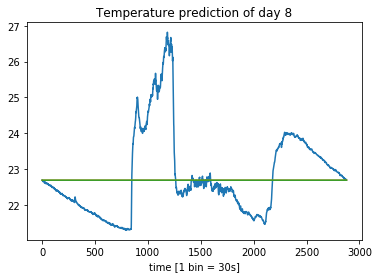

In [39]:
import matplotlib.pyplot as plt

t = np.arange(len(temp_test_sync))
fig1, ax1 = plt.subplots()
ax1.plot(t, y,)
ax1.set_title("Temperature prediction of day 8")
ax1.set_xlabel("time [1 bin = 30s]")

ax1.plot(t, y_hat1)
ax1.plot(t, y_hat2)

plt.show()

In [3]:
i=0 #Initialise counter

n=10   # number of inputs

beta=np.zeros(n) ## first and last parameters are 1, others are zeros
beta[1]=1   
beta[-1]=1
beta.shape=(n,1)


#Loop for sending messages to Kafka with the topic dataLinearModel

while True:
    x=np.random.rand(1,n)[0]
    y=float(x.dot(beta))+0.1*np.random.rand(1)[0] ## y =x^T beta +w
    message=np.array2string(np.append([i,y],x),separator=",") 
    print(message)
    producer.send('dataLinearModel', message.encode())
    i=i+1
    time.sleep(1)

[ 0.        , 0.95772618, 0.67060354, 0.24211019, 0.17263733, 0.79885759,
  0.48056794, 0.98570543, 0.1627009 , 0.58327203, 0.78245165, 0.68484422]
[ 1.        , 0.65940146, 0.10026097, 0.05903539, 0.22909641, 0.32563214,
  0.6809396 , 0.60368021, 0.39138901, 0.26470633, 0.22869574, 0.52838563]
[ 2.        , 0.2607595 , 0.63829029, 0.13070341, 0.41263292, 0.54827117,
  0.04545682, 0.82817345, 0.67135199, 0.6920729 , 0.5594482 , 0.06165693]
[ 3.        , 0.95416609, 0.04906261, 0.12341107, 0.1070854 , 0.00331074,
  0.36320009, 0.2750774 , 0.57627341, 0.03799513, 0.60491055, 0.77024075]
[ 4.        , 1.7365181 , 0.92561066, 0.80130513, 0.36961445, 0.1497974 ,
  0.0540831 , 0.53595227, 0.70130951, 0.77182248, 0.23849375, 0.88075003]
[ 5.        , 1.21626752, 0.92572199, 0.6323603 , 0.83326384, 0.66514895,
  0.12938035, 0.99302658, 0.18598089, 0.5205909 , 0.48324244, 0.51460192]
[ 6.        , 0.86638299, 0.34990381, 0.54791102, 0.95241497, 0.70053108,
  0.23466649, 0.05525377, 0.45685857, 

[ 49.        ,  1.87313449,  0.62510852,  0.99297458,  0.14825713,
   0.33426   ,  0.96796691,  0.38571584,  0.14563271,  0.68380523,
   0.0765593 ,  0.87961825]
[ 50.        ,  0.85262817,  0.37115393,  0.79027126,  0.12221132,
   0.52871574,  0.18528548,  0.94761125,  0.67077707,  0.56343033,
   0.73476217,  0.05936989]
[ 51.        ,  1.53177351,  0.07192952,  0.8356925 ,  0.30456939,
   0.72036634,  0.60152491,  0.10571554,  0.53027396,  0.45361879,
   0.83916123,  0.68076368]
[ 52.        ,  0.54462778,  0.14085798,  0.13559422,  0.60213847,
   0.81927175,  0.40551726,  0.85744463,  0.39721184,  0.37305844,
   0.62073097,  0.33708896]
[  5.30000000e+01,  5.13963328e-01,  4.61748724e-01,  8.03057483e-03,
   3.47863740e-01,  4.84717892e-01,  2.52756041e-01,  7.83358292e-01,
   3.77895161e-01,  4.84854538e-01,  6.85209293e-01,  4.11295530e-01]
[  5.40000000e+01,  6.12267499e-01,  6.67857444e-01,  3.05062782e-03,
   8.59376114e-02,  2.48637159e-01,  7.93277057e-01,  4.25576201e-01,
  

[ 95.        ,  0.74256141,  0.7398143 ,  0.41258847,  0.82803955,
   0.15263898,  0.21054319,  0.42126611,  0.95203626,  0.10866459,
   0.51548958,  0.2905914 ]
[ 96.        ,  1.6696113 ,  0.98821607,  0.77123873,  0.67754367,
   0.43592821,  0.59097779,  0.20514365,  0.47219884,  0.28216909,
   0.4722199 ,  0.84666987]
[  9.70000000e+01,  4.85469055e-01,  6.60786921e-01,  2.33056135e-01,
   3.84478482e-01,  3.91092594e-02,  7.71698443e-01,  1.49730783e-01,
   2.20663948e-01,  7.69490805e-01,  6.71920478e-01,  1.69012289e-01]
[  9.80000000e+01,  1.36440073e+00,  1.98287538e-01,  3.30879059e-01,
   3.45809287e-01,  2.19958074e-01,  1.17128169e-01,  3.16137321e-01,
   7.34358494e-02,  1.84843309e-01,  5.56264035e-01,  9.55274517e-01]
[ 99.        ,  0.78407331,  0.36046046,  0.11776012,  0.67550267,
   0.79697578,  0.86638062,  0.19087129,  0.92443062,  0.22827448,
   0.6916496 ,  0.61069823]
[  1.00000000e+02,  1.05427074e+00,  2.23994077e-01,  2.22770007e-01,
   6.05842881e-01,  3.50

[ 137.        ,   1.56186691,   0.99772438,   0.73882414,   0.83229368,
    0.97996755,   0.77968494,   0.59510207,   0.34350337,   0.97291179,
    0.81865215,   0.78996039]
[  1.38000000e+02,  7.57344521e-01,  1.84121855e-03,  6.36404205e-01,
   8.86699789e-01,  9.81942860e-01,  3.03023302e-01,  4.47183902e-01,
   3.96710388e-01,  4.58223461e-01,  3.27556420e-01,  5.25036817e-02]
[  1.39000000e+02,  4.98088612e-01,  4.56647121e-01,  3.91178471e-01,
   1.91155223e-01,  1.05275659e-01,  2.12562195e-01,  3.22837434e-02,
   3.48470711e-01,  8.48370513e-01,  8.33550996e-01,  1.06781542e-01]
[  1.40000000e+02,  1.92212795e+00,  9.98387534e-01,  9.29409010e-01,
   6.17675495e-01,  6.81671152e-01,  2.64679670e-03,  2.80075024e-01,
   2.14498159e-02,  3.06135621e-01,  2.89395416e-01,  9.45287703e-01]
[  1.41000000e+02,  1.01230413e+00,  8.83800860e-01,  1.12125637e-01,
   7.70669374e-01,  1.91134872e-01,  8.47097335e-01,  5.38594024e-01,
   8.12080883e-01,  9.81414722e-01,  4.82912664e-01,  8.

[  1.78000000e+02,  1.82875554e+00,  6.85009784e-01,  9.62205070e-01,
   2.33256374e-02,  4.96188875e-01,  1.97638018e-01,  2.90406817e-01,
   7.27624227e-01,  4.20159381e-01,  7.42523967e-01,  7.83997807e-01]
[ 179.        ,   0.81341134,   0.54902644,   0.54997082,   0.704293  ,
    0.26121434,   0.73872776,   0.93690926,   0.64383099,   0.57384691,
    0.58668034,   0.23413189]
[  1.80000000e+02,  8.29697063e-01,  1.43703938e-01,  4.55591019e-01,
   9.31675835e-01,  5.55087904e-01,  7.06814862e-02,  6.72866323e-01,
   4.51644377e-01,  8.61214737e-01,  6.61000725e-01,  3.13623451e-01]
[ 181.        ,   0.92105487,   0.58577252,   0.55747535,   0.18783516,
    0.85034097,   0.82093457,   0.31894866,   0.50293326,   0.29657657,
    0.7351163 ,   0.31786376]
[  1.82000000e+02,  1.33262804e+00,  6.22761781e-01,  5.73983404e-01,
   3.46354217e-01,  5.98646880e-02,  4.59793514e-01,  9.72061587e-01,
   3.53080028e-01,  2.44058206e-01,  6.63953027e-01,  6.71737402e-01]
[  1.83000000e+02,  1.

[  2.19000000e+02,  1.52232424e+00,  2.94435038e-01,  5.17974212e-01,
   7.31628761e-01,  8.21507627e-03,  1.37696962e-01,  8.63706904e-01,
   2.15442942e-01,  4.10482911e-01,  5.34053617e-01,  9.30558840e-01]
[  2.20000000e+02,  8.93981474e-01,  6.78031313e-01,  4.98971550e-01,
   8.43419256e-01,  5.17246108e-02,  4.22236392e-03,  6.78908640e-01,
   4.08572853e-01,  2.80855511e-01,  8.77346136e-01,  3.73867061e-01]
[  2.21000000e+02,  1.02867200e+00,  1.37114082e-01,  3.74474724e-01,
   1.39824653e-01,  6.30201472e-01,  5.27514491e-02,  1.55546721e-01,
   3.53721296e-01,  7.49433302e-01,  6.22094467e-01,  5.58719219e-01]
[  2.22000000e+02,  1.41758510e+00,  6.78739913e-02,  4.29769880e-01,
   8.92242018e-01,  3.11614812e-02,  8.19866398e-01,  2.74089879e-01,
   3.93933653e-01,  7.73496980e-01,  3.51457460e-01,  9.67317940e-01]
[  2.23000000e+02,  1.21644562e+00,  7.67136369e-02,  8.74078533e-01,
   4.29372282e-01,  9.39368616e-01,  6.98425433e-01,  1.37329695e-01,
   9.00577398e-01,  

[  2.59000000e+02,  9.21804610e-01,  8.81025149e-01,  5.98463907e-02,
   1.25308028e-01,  7.97221413e-01,  5.26468124e-01,  5.97221169e-01,
   7.56180103e-01,  1.11127410e-01,  3.48878014e-01,  8.59532760e-01]
[  2.60000000e+02,  1.10892291e+00,  8.38355992e-01,  6.71369543e-01,
   8.43517127e-01,  6.92606033e-01,  3.25365642e-01,  1.19906416e-01,
   8.72460866e-01,  5.40435782e-01,  3.17458219e-01,  3.70615578e-01]
[  2.61000000e+02,  1.01373696e+00,  6.32787331e-02,  6.94373043e-01,
   7.28604506e-01,  7.59644155e-01,  2.43176596e-01,  6.98170100e-01,
   3.44032375e-01,  6.18245322e-01,  6.62289125e-01,  2.84650567e-01]
[  2.62000000e+02,  1.02990244e+00,  8.91542202e-01,  7.88932814e-01,
   1.52445833e-01,  4.89390947e-01,  8.37448099e-01,  3.13640470e-01,
   3.51954809e-01,  2.68490924e-01,  9.34797539e-01,  1.53344422e-01]
[  2.63000000e+02,  4.45038113e-01,  2.17660932e-01,  2.79841010e-01,
   1.08898440e-01,  8.66654122e-01,  6.07488436e-02,  5.10911444e-01,
   4.48856088e-01,  

[  2.99000000e+02,  1.06174472e+00,  3.03100166e-01,  1.47760876e-01,
   1.20282542e-01,  7.12303989e-01,  4.19277850e-01,  8.88124125e-01,
   8.63633713e-01,  6.92813643e-01,  2.55863371e-01,  8.88044353e-01]
[  3.00000000e+02,  7.96047208e-01,  8.12009039e-01,  2.47553377e-02,
   2.28740953e-01,  5.05999549e-01,  1.22879474e-01,  4.61715299e-01,
   4.44393358e-01,  9.29285284e-01,  1.26860686e-01,  7.14768131e-01]
[  3.01000000e+02,  1.75520054e+00,  8.53669787e-01,  7.44129656e-01,
   9.53786481e-01,  8.46402510e-01,  5.84660562e-01,  5.61710609e-01,
   2.11651644e-01,  2.45065390e-01,  4.07838127e-02,  9.87382149e-01]
[  3.02000000e+02,  8.45640460e-01,  5.34555820e-01,  5.54810256e-01,
   6.47091176e-01,  3.13049701e-01,  5.92483266e-01,  5.00259298e-01,
   8.89477920e-01,  5.73420687e-01,  8.58084435e-01,  2.58458725e-01]
[  3.03000000e+02,  1.76698678e+00,  6.86137209e-01,  8.77545669e-01,
   1.78887386e-01,  8.65480733e-01,  6.72477197e-01,  6.64758132e-01,
   3.52301421e-01,  

[  3.39000000e+02,  4.72944846e-01,  7.99646771e-01,  4.03747488e-01,
   1.20106340e-02,  5.08223959e-01,  1.74215977e-01,  3.60462012e-02,
   1.91199483e-01,  1.59315988e-01,  7.12895586e-01,  3.05595571e-02]
[  3.40000000e+02,  4.57426466e-01,  4.01728911e-01,  3.70136246e-01,
   5.95981926e-01,  1.91499102e-02,  9.17663702e-02,  1.58054703e-01,
   6.46276694e-01,  6.30856149e-01,  2.83864794e-01,  8.13679283e-02]


KeyboardInterrupt: 